# SSD300 Training Tutorial

This tutorial explains how to train an SSD300 on the Pascal VOC datasets. The preset parameters reproduce the training of the original SSD300 "07+12" model. Training SSD512 works simiarly, so there's no extra tutorial for that. The same goes for training on other datasets.

You can find a summary of a full training here to get an impression of what it should look like:
[SSD300 "07+12" training summary](https://github.com/pierluigiferrari/ssd_keras/blob/master/training_summaries/ssd300_pascal_07%2B12_training_summary.md)

In [11]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

# added these two lines to see if GPU is supported
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5390435909386788224
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9213191127
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11673584908626702450
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:21:00.0, compute capability: 6.1"
]


## 0. Preliminary note

All places in the code where you need to make any changes are marked `TODO` and explained accordingly. All code cells that don't contain `TODO` markers just need to be executed.

## 1. Set the model configuration parameters

This section sets the configuration parameters for the model definition. The parameters set here are being used both by the `ssd_300()` function that builds the SSD300 model as well as further down by the constructor for the `SSDInputEncoder` object that is needed to run the training. Most of these parameters are needed to define the anchor boxes.

The parameters as set below produce the original SSD300 architecture that was trained on the Pascal VOC datsets, i.e. they are all chosen to correspond exactly to their respective counterparts in the `.prototxt` file that defines the original Caffe implementation. Note that the anchor box scaling factors of the original SSD implementation vary depending on the datasets on which the models were trained. The scaling factors used for the MS COCO datasets are smaller than the scaling factors used for the Pascal VOC datasets. The reason why the list of scaling factors has 7 elements while there are only 6 predictor layers is that the last scaling factor is used for the second aspect-ratio-1 box of the last predictor layer. Refer to the documentation for details.

As mentioned above, the parameters set below are not only needed to build the model, but are also passed to the `SSDInputEncoder` constructor further down, which is responsible for matching and encoding ground truth boxes and anchor boxes during the training. In order to do that, it needs to know the anchor box parameters.

In [12]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## 2. Build or load the model

You will want to execute either of the two code cells in the subsequent two sub-sections, not both.

### 2.1 Create a new model and load trained VGG-16 weights into it (or trained SSD weights)

If you want to create a new SSD300 model, this is the relevant section for you. If you want to load a previously saved SSD300 model, skip ahead to section 2.2.

The code cell below does the following things:
1. It calls the function `ssd_300()` to build the model.
2. It then loads the weights file that is found at `weights_path` into the model. You could load the trained VGG-16 weights or you could load the weights of a trained model. If you want to reproduce the original SSD training, load the pre-trained VGG-16 weights. In any case, you need to set the path to the weights file you want to load on your local machine. Download links to all the trained weights are provided in the [README](https://github.com/pierluigiferrari/ssd_keras/blob/master/README.md) of this repository.
3. Finally, it compiles the model for the training. In order to do so, we're defining an optimizer (Adam) and a loss function (SSDLoss) to be passed to the `compile()` method.

Normally, the optimizer of choice would be Adam (commented out below), but since the original implementation uses plain SGD with momentum, we'll do the same in order to reproduce the original training. Adam is generally the superior optimizer, so if your goal is not to have everything exactly as in the original training, feel free to switch to Adam. You might need to adjust the learning rate scheduler below slightly in case you use Adam.

Note that the learning rate that is being set here doesn't matter, because further below we'll pass a learning rate scheduler to the training function, which will overwrite any learning rate set here, i.e. what matters are the learning rates that are defined by the learning rate scheduler.

`SSDLoss` is a custom Keras loss function that implements the multi-task that consists of a log loss for classification and a smooth L1 loss for localization. `neg_pos_ratio` and `alpha` are set as in the paper.

In [14]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = r'C:\Users\putz\CS Projects\tc-detection-keras\test_weights\VGG_coco_SSD_300x300_iter_400000_subsampled_1_classes.h5'

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)

### 2.2 Load a previously created model

If you have previously created and saved a model and would now like to load it, execute the next code cell. The only thing you need to do here is to set the path to the saved model HDF5 file that you would like to load.

The SSD model contains custom objects: Neither the loss function nor the anchor box or L2-normalization layer types are contained in the Keras core library, so we need to provide them to the model loader.

This next code cell assumes that you want to load a model that was created in 'training' mode. If you want to load a model that was created in 'inference' or 'inference_fast' mode, you'll have to add the `DecodeDetections` or `DecodeDetectionsFast` layer type to the `custom_objects` dictionary below.

In [ ]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'path/to/trained/model.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

## 3. Set up the data generators for the training

The code cells below set up the data generators for the training and validation datasets to train the model. The settings below reproduce the original SSD training on Pascal VOC 2007 `trainval` plus 2012 `trainval` and validation on Pascal VOC 2007 `test`.

The only thing you need to change here are the filepaths to the datasets on your local machine. Note that parsing the labels from the XML annotations files can take a while.

Note that the generator provides two options to speed up the training. By default, it loads the individual images for a batch from disk. This has two disadvantages. First, for compressed image formats like JPG, this is a huge computational waste, because every image needs to be decompressed again and again every time it is being loaded. Second, the images on disk are likely not stored in a contiguous block of memory, which may also slow down the loading process. The first option that `DataGenerator` provides to deal with this is to load the entire dataset into memory, which reduces the access time for any image to a negligible amount, but of course this is only an option if you have enough free memory to hold the whole dataset. As a second option, `DataGenerator` provides the possibility to convert the dataset into a single HDF5 file. This HDF5 file stores the images as uncompressed arrays in a contiguous block of memory, which dramatically speeds up the loading time. It's not as good as having the images in memory, but it's a lot better than the default option of loading them from their compressed JPG state every time they are needed. Of course such an HDF5 dataset may require significantly more disk space than the compressed images (around 9 GB total for Pascal VOC 2007 `trainval` plus 2012 `trainval` and another 2.6 GB for 2007 `test`). You can later load these HDF5 datasets directly in the constructor.

The original SSD implementation uses a batch size of 32 for the training. In case you run into GPU memory issues, reduce the batch size accordingly. You need at least 7 GB of free GPU memory to train an SSD300 with 20 object classes with a batch size of 32.

The `DataGenerator` itself is fairly generic. It doesn't contain any data augmentation or bounding box encoding logic. Instead, you pass a list of image transformations and an encoder for the bounding boxes in the `transformations` and `label_encoder` arguments of the data generator's `generate()` method, and the data generator will then apply those given transformations and the encoding to the data. Everything here is preset already, but if you'd like to learn more about the data generator and its data augmentation capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

The data augmentation settings defined further down reproduce the data augmentation pipeline of the original SSD training. The training generator receives an object `ssd_data_augmentation`, which is a transformation object that is itself composed of a whole chain of transformations that replicate the data augmentation procedure used to train the original Caffe implementation. The validation generator receives an object `resize`, which simply resizes the input images.

An `SSDInputEncoder` object, `ssd_input_encoder`, is passed to both the training and validation generators. As explained above, it matches the ground truth labels to the model's anchor boxes and encodes the box coordinates into the format that the model needs.

In order to train the model on a dataset other than Pascal VOC, either choose `DataGenerator`'s appropriate parser method that corresponds to your data format, or, if `DataGenerator` does not provide a suitable parser for your data format, you can write an additional parser and add it. Out of the box, `DataGenerator` can handle datasets that use the Pascal VOC format (use `parse_xml()`), the MS COCO format (use `parse_json()`) and a wide range of CSV formats (use `parse_csv()`).

In [15]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

# The directories that contain the images.
traffic_cone_images_dir      = r'C:\Users\putz\CS Projects\tc-detection-keras\dataset\VOCdevkit\cone_images_PascalVOC\JPEGImages'

# The directories that contain the annotations.
traffic_cone_annotations_dir      = r'C:\Users\putz\CS Projects\tc-detection-keras\dataset\VOCdevkit\cone_images_PascalVOC\Annotations'

# The paths to the image sets.
VOC_tc_train_image_set_filename    = r'C:\Users\putz\CS Projects\tc-detection-keras\dataset\VOCdevkit\cone_images_PascalVOC\ImageSets\Main\train.txt'
VOC_tc_val_image_set_filename      = r'C:\Users\putz\CS Projects\tc-detection-keras\dataset\VOCdevkit\cone_images_PascalVOC\ImageSets\Main\val.txt'
VOC_tc_trainval_image_set_filename = r'C:\Users\putz\CS Projects\tc-detection-keras\dataset\VOCdevkit\cone_images_PascalVOC\ImageSets\Main\trainval.txt'
VOC_tc_test_image_set_filename     = r'C:\Users\putz\CS Projects\tc-detection-keras\dataset\VOCdevkit\cone_images_PascalVOC\ImageSets\Main\test.txt'

# The XML parser needs to know what object class names to look for and in which order to map them to integers.
classes = ['traffic_cone']

train_dataset.parse_xml(images_dirs=[traffic_cone_images_dir],
                        image_set_filenames=[VOC_tc_trainval_image_set_filename],
                        annotations_dirs=[traffic_cone_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[traffic_cone_images_dir],
                      image_set_filenames=[VOC_tc_test_image_set_filename],
                      annotations_dirs=[traffic_cone_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that case the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

train_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07+12_trainval.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07_test.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

Processing image set 'test.txt': 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 473.50it/s]


OSError: Unable to create file (unable to truncate a file which is already open)

In [5]:
# 3: Set the batch size.

batch_size = 30 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	    13
Number of images in the validation dataset:	    17


## 4. Set the remaining training parameters

We've already chosen an optimizer and set the batch size above, now let's set the remaining training parameters. I'll set one epoch to consist of 1,000 training steps. The next code cell defines a learning rate schedule that replicates the learning rate schedule of the original Caffe implementation for the training of the SSD300 Pascal VOC "07+12" model. That model was trained for 120,000 steps with a learning rate of 0.001 for the first 80,000 steps, 0.0001 for the next 20,000 steps, and 0.00001 for the last 20,000 steps. If you're training on a different dataset, define the learning rate schedule however you see fit.

I'll set only a few essential Keras callbacks below, feel free to add more callbacks if you want TensorBoard summaries or whatever. We obviously need the learning rate scheduler and we want to save the best models during the training. It also makes sense to continuously stream our training history to a CSV log file after every epoch, because if we didn't do that, in case the training terminates with an exception at some point or if the kernel of this Jupyter notebook dies for some reason or anything like that happens, we would lose the entire history for the trained epochs. Finally, we'll also add a callback that makes sure that the training terminates if the loss becomes `NaN`. Depending on the optimizer you use, it can happen that the loss becomes `NaN` during the first iterations of the training. In later iterations it's less of a risk. For example, I've never seen a `NaN` loss when I trained SSD using an Adam optimizer, but I've seen a `NaN` loss a couple of times during the very first couple of hundred training steps of training a new model when I used an SGD optimizer.

In [6]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [7]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='ssd300_pascal_07+12_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='ssd300_pascal_07+12_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

## 5. Train

In order to reproduce the training of the "07+12" model mentioned above, at 1,000 training steps per epoch you'd have to train for 120 epochs. That is going to take really long though, so you might not want to do all 120 epochs in one go and instead train only for a few epochs at a time. You can find a summary of a full training [here](https://github.com/pierluigiferrari/ssd_keras/blob/master/training_summaries/ssd300_pascal_07%2B12_training_summary.md).

In order to only run a partial training and resume smoothly later on, there are a few things you should note:
1. Always load the full model if you can, rather than building a new model and loading previously saved weights into it. Optimizers like SGD or Adam keep running averages of past gradient moments internally. If you always save and load full models when resuming a training, then the state of the optimizer is maintained and the training picks up exactly where it left off. If you build a new model and load weights into it, the optimizer is being initialized from scratch, which, especially in the case of Adam, leads to small but unnecessary setbacks every time you resume the training with previously saved weights.
2. In order for the learning rate scheduler callback above to work properly, `fit_generator()` needs to know which epoch we're in, otherwise it will start with epoch 0 every time you resume the training. Set `initial_epoch` to be the next epoch of your training. Note that this parameter is zero-based, i.e. the first epoch is epoch 0. If you had trained for 10 epochs previously and now you'd want to resume the training from there, you'd set `initial_epoch = 10` (since epoch 10 is the eleventh epoch). Furthermore, set `final_epoch` to the last epoch you want to run. To stick with the previous example, if you had trained for 10 epochs previously and now you'd want to train for another 10 epochs, you'd set `initial_epoch = 10` and `final_epoch = 20`.
3. In order for the model checkpoint callback above to work correctly after a kernel restart, set `model_checkpoint.best` to the best validation loss from the previous training. If you don't do this and a new `ModelCheckpoint` object is created after a kernel restart, that object obviously won't know what the last best validation loss was, so it will always save the weights of the first epoch of your new training and record that loss as its new best loss. This isn't super-important, I just wanted to mention it.

In [8]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 120
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/120

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.


 311/1000 [========>.....................] - ETA: 2:34:04 - loss: 2.88 - ETA: 1:19:09 - loss: 2.88 - ETA: 54:09 - loss: 2.8836 - ETA: 41:38 - loss: 2.88 - ETA: 34:07 - loss: 2.88 - ETA: 29:08 - loss: 2.88 - ETA: 25:34 - loss: 2.88 - ETA: 22:53 - loss: 2.88 - ETA: 20:47 - loss: 2.88 - ETA: 19:06 - loss: 2.88 - ETA: 17:44 - loss: 2.88 - ETA: 16:36 - loss: 2.88 - ETA: 15:38 - loss: 2.88 - ETA: 14:49 - loss: 2.88 - ETA: 14:06 - loss: 2.88 - ETA: 13:28 - loss: 2.88 - ETA: 12:55 - loss: 2.88 - ETA: 12:25 - loss: 2.88 - ETA: 11:58 - loss: 2.88 - ETA: 11:34 - loss: 2.88 - ETA: 11:12 - loss: 2.88 - ETA: 10:52 - loss: 2.88 - ETA: 10:34 - loss: 2.88 - ETA: 10:18 - loss: 2.88 - ETA: 10:02 - loss: 2.88 - ETA: 9:51 - loss: 2.8832 - ETA: 9:42 - loss: 2.883 - ETA: 9:37 - loss: 2.883 - ETA: 9:30 - loss: 2.883 - ETA: 9:27 - loss: 2.883 - ETA: 9:20 - loss: 2.883 - ETA: 9:14 - loss: 2.883 - ETA: 9:09 - loss: 2.883 - ETA: 9:03 - loss: 2.883 - ETA: 8:58 - loss: 2.883 - ETA: 8:54 - loss: 2.883 - ETA: 8:51 - 

 625/1000 [=================>............] - ETA: 5:08 - loss: 2.875 - ETA: 5:07 - loss: 2.875 - ETA: 5:07 - loss: 2.875 - ETA: 5:07 - loss: 2.875 - ETA: 5:06 - loss: 2.875 - ETA: 5:06 - loss: 2.875 - ETA: 5:05 - loss: 2.875 - ETA: 5:05 - loss: 2.875 - ETA: 5:04 - loss: 2.874 - ETA: 5:04 - loss: 2.874 - ETA: 5:03 - loss: 2.874 - ETA: 5:03 - loss: 2.874 - ETA: 5:02 - loss: 2.874 - ETA: 5:02 - loss: 2.874 - ETA: 5:01 - loss: 2.874 - ETA: 5:01 - loss: 2.874 - ETA: 5:00 - loss: 2.874 - ETA: 4:59 - loss: 2.874 - ETA: 4:59 - loss: 2.874 - ETA: 4:59 - loss: 2.874 - ETA: 4:58 - loss: 2.874 - ETA: 4:58 - loss: 2.874 - ETA: 4:57 - loss: 2.874 - ETA: 4:57 - loss: 2.874 - ETA: 4:56 - loss: 2.874 - ETA: 4:56 - loss: 2.874 - ETA: 4:55 - loss: 2.874 - ETA: 4:55 - loss: 2.874 - ETA: 4:54 - loss: 2.874 - ETA: 4:54 - loss: 2.874 - ETA: 4:53 - loss: 2.874 - ETA: 4:53 - loss: 2.874 - ETA: 4:52 - loss: 2.874 - ETA: 4:52 - loss: 2.874 - ETA: 4:51 - loss: 2.874 - ETA: 4:51 - loss: 2.874 - ETA: 4:51 - loss: 2

 945/1000 [===========================>..] - ETA: 2:45 - loss: 2.866 - ETA: 2:45 - loss: 2.866 - ETA: 2:44 - loss: 2.866 - ETA: 2:44 - loss: 2.866 - ETA: 2:43 - loss: 2.866 - ETA: 2:43 - loss: 2.866 - ETA: 2:43 - loss: 2.866 - ETA: 2:42 - loss: 2.866 - ETA: 2:42 - loss: 2.865 - ETA: 2:41 - loss: 2.865 - ETA: 2:41 - loss: 2.865 - ETA: 2:40 - loss: 2.865 - ETA: 2:40 - loss: 2.865 - ETA: 2:40 - loss: 2.865 - ETA: 2:39 - loss: 2.865 - ETA: 2:39 - loss: 2.865 - ETA: 2:38 - loss: 2.865 - ETA: 2:38 - loss: 2.865 - ETA: 2:37 - loss: 2.865 - ETA: 2:37 - loss: 2.865 - ETA: 2:36 - loss: 2.865 - ETA: 2:36 - loss: 2.865 - ETA: 2:36 - loss: 2.865 - ETA: 2:35 - loss: 2.865 - ETA: 2:35 - loss: 2.865 - ETA: 2:34 - loss: 2.865 - ETA: 2:34 - loss: 2.865 - ETA: 2:33 - loss: 2.865 - ETA: 2:33 - loss: 2.865 - ETA: 2:32 - loss: 2.865 - ETA: 2:32 - loss: 2.865 - ETA: 2:32 - loss: 2.865 - ETA: 2:31 - loss: 2.865 - ETA: 2:31 - loss: 2.865 - ETA: 2:30 - loss: 2.865 - ETA: 2:30 - loss: 2.865 - ETA: 2:29 - loss: 2

1000/1000 [==============================] - ETA: 23s - loss: 2.85 - ETA: 23s - loss: 2.85 - ETA: 23s - loss: 2.85 - ETA: 22s - loss: 2.85 - ETA: 22s - loss: 2.85 - ETA: 21s - loss: 2.85 - ETA: 21s - loss: 2.85 - ETA: 20s - loss: 2.85 - ETA: 20s - loss: 2.85 - ETA: 19s - loss: 2.85 - ETA: 19s - loss: 2.85 - ETA: 19s - loss: 2.85 - ETA: 18s - loss: 2.85 - ETA: 18s - loss: 2.85 - ETA: 17s - loss: 2.85 - ETA: 17s - loss: 2.85 - ETA: 16s - loss: 2.85 - ETA: 16s - loss: 2.85 - ETA: 15s - loss: 2.85 - ETA: 15s - loss: 2.85 - ETA: 15s - loss: 2.85 - ETA: 14s - loss: 2.85 - ETA: 14s - loss: 2.85 - ETA: 13s - loss: 2.85 - ETA: 13s - loss: 2.85 - ETA: 12s - loss: 2.85 - ETA: 12s - loss: 2.85 - ETA: 11s - loss: 2.85 - ETA: 11s - loss: 2.85 - ETA: 11s - loss: 2.85 - ETA: 10s - loss: 2.85 - ETA: 10s - loss: 2.85 - ETA: 9s - loss: 2.8561 - ETA: 9s - loss: 2.856 - ETA: 8s - loss: 2.856 - ETA: 8s - loss: 2.856 - ETA: 7s - loss: 2.856 - ETA: 7s - loss: 2.856 - ETA: 7s - loss: 2.855 - ETA: 6s - loss: 2.

 314/1000 [========>.....................] - ETA: 4:15 - loss: 2.827 - ETA: 4:19 - loss: 2.827 - ETA: 4:19 - loss: 2.826 - ETA: 4:17 - loss: 2.826 - ETA: 4:17 - loss: 2.826 - ETA: 4:17 - loss: 2.826 - ETA: 4:17 - loss: 2.826 - ETA: 4:17 - loss: 2.826 - ETA: 4:17 - loss: 2.826 - ETA: 4:17 - loss: 2.826 - ETA: 4:17 - loss: 2.826 - ETA: 4:19 - loss: 2.826 - ETA: 4:26 - loss: 2.826 - ETA: 4:38 - loss: 2.826 - ETA: 4:48 - loss: 2.826 - ETA: 4:55 - loss: 2.826 - ETA: 5:01 - loss: 2.826 - ETA: 5:09 - loss: 2.826 - ETA: 5:14 - loss: 2.826 - ETA: 5:19 - loss: 2.826 - ETA: 5:25 - loss: 2.826 - ETA: 5:34 - loss: 2.826 - ETA: 5:36 - loss: 2.826 - ETA: 5:37 - loss: 2.826 - ETA: 5:39 - loss: 2.826 - ETA: 5:40 - loss: 2.826 - ETA: 5:43 - loss: 2.826 - ETA: 5:48 - loss: 2.826 - ETA: 5:52 - loss: 2.826 - ETA: 5:59 - loss: 2.826 - ETA: 6:05 - loss: 2.826 - ETA: 6:06 - loss: 2.826 - ETA: 6:07 - loss: 2.826 - ETA: 6:10 - loss: 2.826 - ETA: 6:08 - loss: 2.826 - ETA: 6:09 - loss: 2.826 - ETA: 6:12 - loss: 2

 628/1000 [=================>............] - ETA: 4:54 - loss: 2.818 - ETA: 4:53 - loss: 2.818 - ETA: 4:53 - loss: 2.818 - ETA: 4:52 - loss: 2.818 - ETA: 4:52 - loss: 2.818 - ETA: 4:51 - loss: 2.818 - ETA: 4:51 - loss: 2.818 - ETA: 4:51 - loss: 2.818 - ETA: 4:50 - loss: 2.817 - ETA: 4:50 - loss: 2.817 - ETA: 4:50 - loss: 2.817 - ETA: 4:49 - loss: 2.817 - ETA: 4:49 - loss: 2.817 - ETA: 4:48 - loss: 2.817 - ETA: 4:48 - loss: 2.817 - ETA: 4:47 - loss: 2.817 - ETA: 4:47 - loss: 2.817 - ETA: 4:46 - loss: 2.817 - ETA: 4:46 - loss: 2.817 - ETA: 4:46 - loss: 2.817 - ETA: 4:45 - loss: 2.817 - ETA: 4:45 - loss: 2.817 - ETA: 4:45 - loss: 2.817 - ETA: 4:44 - loss: 2.817 - ETA: 4:44 - loss: 2.817 - ETA: 4:44 - loss: 2.817 - ETA: 4:43 - loss: 2.817 - ETA: 4:43 - loss: 2.817 - ETA: 4:42 - loss: 2.817 - ETA: 4:42 - loss: 2.817 - ETA: 4:41 - loss: 2.817 - ETA: 4:41 - loss: 2.817 - ETA: 4:41 - loss: 2.817 - ETA: 4:40 - loss: 2.817 - ETA: 4:40 - loss: 2.817 - ETA: 4:39 - loss: 2.817 - ETA: 4:38 - loss: 2

 948/1000 [===========================>..] - ETA: 2:40 - loss: 2.809 - ETA: 2:39 - loss: 2.809 - ETA: 2:39 - loss: 2.809 - ETA: 2:39 - loss: 2.809 - ETA: 2:38 - loss: 2.809 - ETA: 2:38 - loss: 2.809 - ETA: 2:37 - loss: 2.809 - ETA: 2:37 - loss: 2.809 - ETA: 2:36 - loss: 2.809 - ETA: 2:36 - loss: 2.809 - ETA: 2:35 - loss: 2.809 - ETA: 2:35 - loss: 2.809 - ETA: 2:35 - loss: 2.809 - ETA: 2:34 - loss: 2.809 - ETA: 2:34 - loss: 2.808 - ETA: 2:33 - loss: 2.808 - ETA: 2:33 - loss: 2.808 - ETA: 2:33 - loss: 2.808 - ETA: 2:32 - loss: 2.808 - ETA: 2:32 - loss: 2.808 - ETA: 2:31 - loss: 2.808 - ETA: 2:31 - loss: 2.808 - ETA: 2:30 - loss: 2.808 - ETA: 2:30 - loss: 2.808 - ETA: 2:30 - loss: 2.808 - ETA: 2:29 - loss: 2.808 - ETA: 2:29 - loss: 2.808 - ETA: 2:28 - loss: 2.808 - ETA: 2:28 - loss: 2.808 - ETA: 2:27 - loss: 2.808 - ETA: 2:27 - loss: 2.808 - ETA: 2:27 - loss: 2.808 - ETA: 2:26 - loss: 2.808 - ETA: 2:26 - loss: 2.808 - ETA: 2:25 - loss: 2.808 - ETA: 2:25 - loss: 2.808 - ETA: 2:24 - loss: 2

1000/1000 [==============================] - ETA: 22s - loss: 2.80 - ETA: 21s - loss: 2.80 - ETA: 21s - loss: 2.80 - ETA: 20s - loss: 2.80 - ETA: 20s - loss: 2.80 - ETA: 19s - loss: 2.80 - ETA: 19s - loss: 2.80 - ETA: 19s - loss: 2.80 - ETA: 18s - loss: 2.80 - ETA: 18s - loss: 2.80 - ETA: 17s - loss: 2.80 - ETA: 17s - loss: 2.80 - ETA: 16s - loss: 2.80 - ETA: 16s - loss: 2.80 - ETA: 16s - loss: 2.80 - ETA: 15s - loss: 2.80 - ETA: 15s - loss: 2.79 - ETA: 14s - loss: 2.79 - ETA: 14s - loss: 2.79 - ETA: 13s - loss: 2.79 - ETA: 13s - loss: 2.79 - ETA: 13s - loss: 2.79 - ETA: 12s - loss: 2.79 - ETA: 12s - loss: 2.79 - ETA: 11s - loss: 2.79 - ETA: 11s - loss: 2.79 - ETA: 10s - loss: 2.79 - ETA: 10s - loss: 2.79 - ETA: 10s - loss: 2.79 - ETA: 9s - loss: 2.7996 - ETA: 9s - loss: 2.799 - ETA: 8s - loss: 2.799 - ETA: 8s - loss: 2.799 - ETA: 7s - loss: 2.799 - ETA: 7s - loss: 2.799 - ETA: 6s - loss: 2.799 - ETA: 6s - loss: 2.799 - ETA: 6s - loss: 2.799 - ETA: 5s - loss: 2.799 - ETA: 5s - loss: 2.

 314/1000 [========>.....................] - ETA: 4:22 - loss: 2.771 - ETA: 6:35 - loss: 2.771 - ETA: 7:41 - loss: 2.771 - ETA: 7:38 - loss: 2.770 - ETA: 7:20 - loss: 2.770 - ETA: 7:19 - loss: 2.770 - ETA: 7:08 - loss: 2.770 - ETA: 6:58 - loss: 2.770 - ETA: 6:55 - loss: 2.770 - ETA: 6:50 - loss: 2.770 - ETA: 6:49 - loss: 2.770 - ETA: 6:51 - loss: 2.770 - ETA: 6:45 - loss: 2.770 - ETA: 6:48 - loss: 2.770 - ETA: 6:55 - loss: 2.770 - ETA: 7:01 - loss: 2.770 - ETA: 7:06 - loss: 2.770 - ETA: 7:08 - loss: 2.770 - ETA: 7:06 - loss: 2.770 - ETA: 7:06 - loss: 2.770 - ETA: 7:04 - loss: 2.770 - ETA: 7:02 - loss: 2.770 - ETA: 7:01 - loss: 2.770 - ETA: 7:02 - loss: 2.770 - ETA: 6:59 - loss: 2.770 - ETA: 7:02 - loss: 2.770 - ETA: 6:58 - loss: 2.770 - ETA: 6:57 - loss: 2.770 - ETA: 6:58 - loss: 2.770 - ETA: 6:58 - loss: 2.770 - ETA: 7:01 - loss: 2.770 - ETA: 7:02 - loss: 2.770 - ETA: 7:03 - loss: 2.770 - ETA: 7:02 - loss: 2.770 - ETA: 7:04 - loss: 2.770 - ETA: 7:04 - loss: 2.770 - ETA: 7:03 - loss: 2

 628/1000 [=================>............] - ETA: 5:00 - loss: 2.762 - ETA: 5:00 - loss: 2.762 - ETA: 4:59 - loss: 2.762 - ETA: 4:59 - loss: 2.762 - ETA: 4:58 - loss: 2.762 - ETA: 4:58 - loss: 2.762 - ETA: 4:58 - loss: 2.762 - ETA: 4:58 - loss: 2.762 - ETA: 4:57 - loss: 2.762 - ETA: 4:57 - loss: 2.762 - ETA: 4:56 - loss: 2.762 - ETA: 4:56 - loss: 2.762 - ETA: 4:55 - loss: 2.762 - ETA: 4:55 - loss: 2.762 - ETA: 4:54 - loss: 2.762 - ETA: 4:54 - loss: 2.761 - ETA: 4:53 - loss: 2.761 - ETA: 4:53 - loss: 2.761 - ETA: 4:52 - loss: 2.761 - ETA: 4:52 - loss: 2.761 - ETA: 4:52 - loss: 2.761 - ETA: 4:51 - loss: 2.761 - ETA: 4:51 - loss: 2.761 - ETA: 4:50 - loss: 2.761 - ETA: 4:50 - loss: 2.761 - ETA: 4:49 - loss: 2.761 - ETA: 4:49 - loss: 2.761 - ETA: 4:48 - loss: 2.761 - ETA: 4:48 - loss: 2.761 - ETA: 4:47 - loss: 2.761 - ETA: 4:47 - loss: 2.761 - ETA: 4:46 - loss: 2.761 - ETA: 4:46 - loss: 2.761 - ETA: 4:45 - loss: 2.761 - ETA: 4:45 - loss: 2.761 - ETA: 4:44 - loss: 2.761 - ETA: 4:44 - loss: 2

 948/1000 [===========================>..] - ETA: 2:43 - loss: 2.753 - ETA: 2:42 - loss: 2.753 - ETA: 2:42 - loss: 2.753 - ETA: 2:42 - loss: 2.753 - ETA: 2:41 - loss: 2.753 - ETA: 2:41 - loss: 2.753 - ETA: 2:40 - loss: 2.753 - ETA: 2:40 - loss: 2.753 - ETA: 2:39 - loss: 2.753 - ETA: 2:39 - loss: 2.753 - ETA: 2:39 - loss: 2.753 - ETA: 2:38 - loss: 2.753 - ETA: 2:38 - loss: 2.753 - ETA: 2:37 - loss: 2.753 - ETA: 2:37 - loss: 2.753 - ETA: 2:36 - loss: 2.753 - ETA: 2:36 - loss: 2.753 - ETA: 2:35 - loss: 2.753 - ETA: 2:35 - loss: 2.753 - ETA: 2:35 - loss: 2.753 - ETA: 2:34 - loss: 2.753 - ETA: 2:34 - loss: 2.753 - ETA: 2:33 - loss: 2.753 - ETA: 2:33 - loss: 2.753 - ETA: 2:32 - loss: 2.753 - ETA: 2:32 - loss: 2.753 - ETA: 2:31 - loss: 2.753 - ETA: 2:31 - loss: 2.753 - ETA: 2:30 - loss: 2.752 - ETA: 2:30 - loss: 2.752 - ETA: 2:29 - loss: 2.752 - ETA: 2:29 - loss: 2.752 - ETA: 2:28 - loss: 2.752 - ETA: 2:28 - loss: 2.752 - ETA: 2:28 - loss: 2.752 - ETA: 2:27 - loss: 2.752 - ETA: 2:27 - loss: 2

1000/1000 [==============================] - ETA: 22s - loss: 2.74 - ETA: 21s - loss: 2.74 - ETA: 21s - loss: 2.74 - ETA: 21s - loss: 2.74 - ETA: 20s - loss: 2.74 - ETA: 20s - loss: 2.74 - ETA: 19s - loss: 2.74 - ETA: 19s - loss: 2.74 - ETA: 18s - loss: 2.74 - ETA: 18s - loss: 2.74 - ETA: 17s - loss: 2.74 - ETA: 17s - loss: 2.74 - ETA: 17s - loss: 2.74 - ETA: 16s - loss: 2.74 - ETA: 16s - loss: 2.74 - ETA: 15s - loss: 2.74 - ETA: 15s - loss: 2.74 - ETA: 14s - loss: 2.74 - ETA: 14s - loss: 2.74 - ETA: 14s - loss: 2.74 - ETA: 13s - loss: 2.74 - ETA: 13s - loss: 2.74 - ETA: 12s - loss: 2.74 - ETA: 12s - loss: 2.74 - ETA: 11s - loss: 2.74 - ETA: 11s - loss: 2.74 - ETA: 10s - loss: 2.74 - ETA: 10s - loss: 2.74 - ETA: 10s - loss: 2.74 - ETA: 9s - loss: 2.7441 - ETA: 9s - loss: 2.744 - ETA: 8s - loss: 2.744 - ETA: 8s - loss: 2.744 - ETA: 7s - loss: 2.744 - ETA: 7s - loss: 2.744 - ETA: 7s - loss: 2.744 - ETA: 6s - loss: 2.743 - ETA: 6s - loss: 2.743 - ETA: 5s - loss: 2.743 - ETA: 5s - loss: 2.

 314/1000 [========>.....................] - ETA: 5:42 - loss: 2.716 - ETA: 7:29 - loss: 2.716 - ETA: 8:30 - loss: 2.716 - ETA: 8:30 - loss: 2.716 - ETA: 8:21 - loss: 2.716 - ETA: 7:56 - loss: 2.716 - ETA: 8:04 - loss: 2.716 - ETA: 8:07 - loss: 2.716 - ETA: 7:52 - loss: 2.715 - ETA: 7:49 - loss: 2.715 - ETA: 7:38 - loss: 2.715 - ETA: 7:36 - loss: 2.715 - ETA: 7:28 - loss: 2.715 - ETA: 7:28 - loss: 2.715 - ETA: 7:23 - loss: 2.715 - ETA: 7:22 - loss: 2.715 - ETA: 7:15 - loss: 2.715 - ETA: 7:14 - loss: 2.715 - ETA: 7:18 - loss: 2.715 - ETA: 7:17 - loss: 2.715 - ETA: 7:13 - loss: 2.715 - ETA: 7:18 - loss: 2.715 - ETA: 7:18 - loss: 2.715 - ETA: 7:17 - loss: 2.715 - ETA: 7:20 - loss: 2.715 - ETA: 7:23 - loss: 2.715 - ETA: 7:22 - loss: 2.715 - ETA: 7:22 - loss: 2.715 - ETA: 7:19 - loss: 2.715 - ETA: 7:19 - loss: 2.715 - ETA: 7:15 - loss: 2.715 - ETA: 7:17 - loss: 2.715 - ETA: 7:15 - loss: 2.715 - ETA: 7:14 - loss: 2.715 - ETA: 7:15 - loss: 2.715 - ETA: 7:11 - loss: 2.715 - ETA: 7:12 - loss: 2

 628/1000 [=================>............] - ETA: 5:00 - loss: 2.707 - ETA: 4:59 - loss: 2.707 - ETA: 4:59 - loss: 2.707 - ETA: 4:58 - loss: 2.707 - ETA: 4:58 - loss: 2.707 - ETA: 4:57 - loss: 2.707 - ETA: 4:57 - loss: 2.707 - ETA: 4:56 - loss: 2.707 - ETA: 4:56 - loss: 2.707 - ETA: 4:55 - loss: 2.707 - ETA: 4:55 - loss: 2.707 - ETA: 4:55 - loss: 2.707 - ETA: 4:54 - loss: 2.707 - ETA: 4:54 - loss: 2.707 - ETA: 4:53 - loss: 2.707 - ETA: 4:53 - loss: 2.707 - ETA: 4:52 - loss: 2.707 - ETA: 4:52 - loss: 2.707 - ETA: 4:52 - loss: 2.707 - ETA: 4:51 - loss: 2.707 - ETA: 4:51 - loss: 2.707 - ETA: 4:50 - loss: 2.707 - ETA: 4:50 - loss: 2.707 - ETA: 4:49 - loss: 2.707 - ETA: 4:49 - loss: 2.707 - ETA: 4:48 - loss: 2.707 - ETA: 4:48 - loss: 2.706 - ETA: 4:47 - loss: 2.706 - ETA: 4:47 - loss: 2.706 - ETA: 4:47 - loss: 2.706 - ETA: 4:46 - loss: 2.706 - ETA: 4:46 - loss: 2.706 - ETA: 4:45 - loss: 2.706 - ETA: 4:45 - loss: 2.706 - ETA: 4:44 - loss: 2.706 - ETA: 4:44 - loss: 2.706 - ETA: 4:43 - loss: 2

 948/1000 [===========================>..] - ETA: 2:43 - loss: 2.699 - ETA: 2:43 - loss: 2.699 - ETA: 2:42 - loss: 2.699 - ETA: 2:42 - loss: 2.699 - ETA: 2:41 - loss: 2.699 - ETA: 2:41 - loss: 2.699 - ETA: 2:40 - loss: 2.699 - ETA: 2:40 - loss: 2.699 - ETA: 2:39 - loss: 2.698 - ETA: 2:39 - loss: 2.698 - ETA: 2:39 - loss: 2.698 - ETA: 2:38 - loss: 2.698 - ETA: 2:38 - loss: 2.698 - ETA: 2:37 - loss: 2.698 - ETA: 2:37 - loss: 2.698 - ETA: 2:36 - loss: 2.698 - ETA: 2:36 - loss: 2.698 - ETA: 2:36 - loss: 2.698 - ETA: 2:35 - loss: 2.698 - ETA: 2:35 - loss: 2.698 - ETA: 2:34 - loss: 2.698 - ETA: 2:34 - loss: 2.698 - ETA: 2:33 - loss: 2.698 - ETA: 2:33 - loss: 2.698 - ETA: 2:33 - loss: 2.698 - ETA: 2:32 - loss: 2.698 - ETA: 2:32 - loss: 2.698 - ETA: 2:31 - loss: 2.698 - ETA: 2:31 - loss: 2.698 - ETA: 2:30 - loss: 2.698 - ETA: 2:30 - loss: 2.698 - ETA: 2:29 - loss: 2.698 - ETA: 2:29 - loss: 2.698 - ETA: 2:28 - loss: 2.698 - ETA: 2:28 - loss: 2.698 - ETA: 2:28 - loss: 2.698 - ETA: 2:27 - loss: 2

1000/1000 [==============================] - ETA: 22s - loss: 2.69 - ETA: 22s - loss: 2.69 - ETA: 21s - loss: 2.69 - ETA: 21s - loss: 2.69 - ETA: 20s - loss: 2.69 - ETA: 20s - loss: 2.69 - ETA: 19s - loss: 2.69 - ETA: 19s - loss: 2.69 - ETA: 18s - loss: 2.69 - ETA: 18s - loss: 2.69 - ETA: 18s - loss: 2.69 - ETA: 17s - loss: 2.69 - ETA: 17s - loss: 2.69 - ETA: 16s - loss: 2.69 - ETA: 16s - loss: 2.69 - ETA: 15s - loss: 2.69 - ETA: 15s - loss: 2.69 - ETA: 14s - loss: 2.69 - ETA: 14s - loss: 2.69 - ETA: 14s - loss: 2.69 - ETA: 13s - loss: 2.69 - ETA: 13s - loss: 2.69 - ETA: 12s - loss: 2.69 - ETA: 12s - loss: 2.68 - ETA: 11s - loss: 2.68 - ETA: 11s - loss: 2.68 - ETA: 11s - loss: 2.68 - ETA: 10s - loss: 2.68 - ETA: 10s - loss: 2.68 - ETA: 9s - loss: 2.6898 - ETA: 9s - loss: 2.689 - ETA: 8s - loss: 2.689 - ETA: 8s - loss: 2.689 - ETA: 7s - loss: 2.689 - ETA: 7s - loss: 2.689 - ETA: 7s - loss: 2.689 - ETA: 6s - loss: 2.689 - ETA: 6s - loss: 2.689 - ETA: 5s - loss: 2.689 - ETA: 5s - loss: 2.

 314/1000 [========>.....................] - ETA: 4:46 - loss: 2.662 - ETA: 6:22 - loss: 2.662 - ETA: 7:02 - loss: 2.662 - ETA: 7:53 - loss: 2.662 - ETA: 7:51 - loss: 2.662 - ETA: 7:35 - loss: 2.662 - ETA: 7:27 - loss: 2.662 - ETA: 7:26 - loss: 2.662 - ETA: 7:22 - loss: 2.662 - ETA: 7:21 - loss: 2.662 - ETA: 7:30 - loss: 2.662 - ETA: 7:28 - loss: 2.662 - ETA: 7:38 - loss: 2.662 - ETA: 7:32 - loss: 2.662 - ETA: 7:26 - loss: 2.662 - ETA: 7:23 - loss: 2.662 - ETA: 7:25 - loss: 2.661 - ETA: 7:30 - loss: 2.661 - ETA: 7:30 - loss: 2.661 - ETA: 7:26 - loss: 2.661 - ETA: 7:24 - loss: 2.661 - ETA: 7:24 - loss: 2.661 - ETA: 7:22 - loss: 2.661 - ETA: 7:21 - loss: 2.661 - ETA: 7:21 - loss: 2.661 - ETA: 7:20 - loss: 2.661 - ETA: 7:22 - loss: 2.661 - ETA: 7:20 - loss: 2.661 - ETA: 7:18 - loss: 2.661 - ETA: 7:21 - loss: 2.661 - ETA: 7:19 - loss: 2.661 - ETA: 7:18 - loss: 2.661 - ETA: 7:16 - loss: 2.661 - ETA: 7:16 - loss: 2.661 - ETA: 7:13 - loss: 2.661 - ETA: 7:10 - loss: 2.661 - ETA: 7:09 - loss: 2

 628/1000 [=================>............] - ETA: 4:58 - loss: 2.654 - ETA: 4:57 - loss: 2.654 - ETA: 4:57 - loss: 2.654 - ETA: 4:57 - loss: 2.653 - ETA: 4:57 - loss: 2.653 - ETA: 4:56 - loss: 2.653 - ETA: 4:56 - loss: 2.653 - ETA: 4:55 - loss: 2.653 - ETA: 4:55 - loss: 2.653 - ETA: 4:54 - loss: 2.653 - ETA: 4:54 - loss: 2.653 - ETA: 4:53 - loss: 2.653 - ETA: 4:53 - loss: 2.653 - ETA: 4:53 - loss: 2.653 - ETA: 4:52 - loss: 2.653 - ETA: 4:52 - loss: 2.653 - ETA: 4:51 - loss: 2.653 - ETA: 4:51 - loss: 2.653 - ETA: 4:50 - loss: 2.653 - ETA: 4:50 - loss: 2.653 - ETA: 4:50 - loss: 2.653 - ETA: 4:49 - loss: 2.653 - ETA: 4:49 - loss: 2.653 - ETA: 4:48 - loss: 2.653 - ETA: 4:48 - loss: 2.653 - ETA: 4:47 - loss: 2.653 - ETA: 4:47 - loss: 2.653 - ETA: 4:47 - loss: 2.653 - ETA: 4:46 - loss: 2.653 - ETA: 4:46 - loss: 2.653 - ETA: 4:46 - loss: 2.653 - ETA: 4:45 - loss: 2.653 - ETA: 4:45 - loss: 2.653 - ETA: 4:44 - loss: 2.653 - ETA: 4:44 - loss: 2.653 - ETA: 4:43 - loss: 2.653 - ETA: 4:43 - loss: 2

 948/1000 [===========================>..] - ETA: 2:41 - loss: 2.645 - ETA: 2:40 - loss: 2.645 - ETA: 2:40 - loss: 2.645 - ETA: 2:39 - loss: 2.645 - ETA: 2:39 - loss: 2.645 - ETA: 2:39 - loss: 2.645 - ETA: 2:38 - loss: 2.645 - ETA: 2:38 - loss: 2.645 - ETA: 2:37 - loss: 2.645 - ETA: 2:37 - loss: 2.645 - ETA: 2:36 - loss: 2.645 - ETA: 2:36 - loss: 2.645 - ETA: 2:36 - loss: 2.645 - ETA: 2:35 - loss: 2.645 - ETA: 2:35 - loss: 2.645 - ETA: 2:34 - loss: 2.645 - ETA: 2:34 - loss: 2.645 - ETA: 2:33 - loss: 2.645 - ETA: 2:33 - loss: 2.645 - ETA: 2:33 - loss: 2.645 - ETA: 2:32 - loss: 2.645 - ETA: 2:32 - loss: 2.645 - ETA: 2:31 - loss: 2.645 - ETA: 2:31 - loss: 2.645 - ETA: 2:30 - loss: 2.645 - ETA: 2:30 - loss: 2.645 - ETA: 2:30 - loss: 2.645 - ETA: 2:29 - loss: 2.645 - ETA: 2:29 - loss: 2.645 - ETA: 2:28 - loss: 2.644 - ETA: 2:28 - loss: 2.644 - ETA: 2:28 - loss: 2.644 - ETA: 2:27 - loss: 2.644 - ETA: 2:27 - loss: 2.644 - ETA: 2:26 - loss: 2.644 - ETA: 2:26 - loss: 2.644 - ETA: 2:25 - loss: 2

1000/1000 [==============================] - ETA: 22s - loss: 2.63 - ETA: 21s - loss: 2.63 - ETA: 21s - loss: 2.63 - ETA: 21s - loss: 2.63 - ETA: 20s - loss: 2.63 - ETA: 20s - loss: 2.63 - ETA: 19s - loss: 2.63 - ETA: 19s - loss: 2.63 - ETA: 18s - loss: 2.63 - ETA: 18s - loss: 2.63 - ETA: 17s - loss: 2.63 - ETA: 17s - loss: 2.63 - ETA: 17s - loss: 2.63 - ETA: 16s - loss: 2.63 - ETA: 16s - loss: 2.63 - ETA: 15s - loss: 2.63 - ETA: 15s - loss: 2.63 - ETA: 14s - loss: 2.63 - ETA: 14s - loss: 2.63 - ETA: 14s - loss: 2.63 - ETA: 13s - loss: 2.63 - ETA: 13s - loss: 2.63 - ETA: 12s - loss: 2.63 - ETA: 12s - loss: 2.63 - ETA: 11s - loss: 2.63 - ETA: 11s - loss: 2.63 - ETA: 10s - loss: 2.63 - ETA: 10s - loss: 2.63 - ETA: 10s - loss: 2.63 - ETA: 9s - loss: 2.6365 - ETA: 9s - loss: 2.636 - ETA: 8s - loss: 2.636 - ETA: 8s - loss: 2.636 - ETA: 7s - loss: 2.636 - ETA: 7s - loss: 2.636 - ETA: 7s - loss: 2.636 - ETA: 6s - loss: 2.636 - ETA: 6s - loss: 2.636 - ETA: 5s - loss: 2.636 - ETA: 5s - loss: 2.

 314/1000 [========>.....................] - ETA: 4:19 - loss: 2.609 - ETA: 6:34 - loss: 2.609 - ETA: 7:44 - loss: 2.609 - ETA: 7:32 - loss: 2.609 - ETA: 7:18 - loss: 2.609 - ETA: 7:29 - loss: 2.609 - ETA: 7:31 - loss: 2.609 - ETA: 7:24 - loss: 2.609 - ETA: 7:19 - loss: 2.609 - ETA: 7:13 - loss: 2.609 - ETA: 7:05 - loss: 2.609 - ETA: 7:07 - loss: 2.609 - ETA: 7:07 - loss: 2.609 - ETA: 7:07 - loss: 2.609 - ETA: 7:04 - loss: 2.609 - ETA: 7:04 - loss: 2.609 - ETA: 7:02 - loss: 2.609 - ETA: 7:00 - loss: 2.609 - ETA: 7:00 - loss: 2.609 - ETA: 7:03 - loss: 2.609 - ETA: 7:07 - loss: 2.609 - ETA: 7:08 - loss: 2.609 - ETA: 7:10 - loss: 2.609 - ETA: 7:10 - loss: 2.609 - ETA: 7:06 - loss: 2.609 - ETA: 7:08 - loss: 2.609 - ETA: 7:04 - loss: 2.609 - ETA: 7:02 - loss: 2.608 - ETA: 6:59 - loss: 2.608 - ETA: 6:58 - loss: 2.608 - ETA: 7:01 - loss: 2.608 - ETA: 7:02 - loss: 2.608 - ETA: 7:00 - loss: 2.608 - ETA: 6:58 - loss: 2.608 - ETA: 6:56 - loss: 2.608 - ETA: 6:54 - loss: 2.608 - ETA: 6:53 - loss: 2

 628/1000 [=================>............] - ETA: 4:53 - loss: 2.601 - ETA: 4:53 - loss: 2.601 - ETA: 4:52 - loss: 2.601 - ETA: 4:52 - loss: 2.601 - ETA: 4:52 - loss: 2.601 - ETA: 4:51 - loss: 2.601 - ETA: 4:51 - loss: 2.601 - ETA: 4:50 - loss: 2.601 - ETA: 4:50 - loss: 2.601 - ETA: 4:50 - loss: 2.601 - ETA: 4:49 - loss: 2.601 - ETA: 4:49 - loss: 2.601 - ETA: 4:48 - loss: 2.601 - ETA: 4:48 - loss: 2.601 - ETA: 4:48 - loss: 2.601 - ETA: 4:47 - loss: 2.601 - ETA: 4:47 - loss: 2.601 - ETA: 4:46 - loss: 2.601 - ETA: 4:46 - loss: 2.601 - ETA: 4:45 - loss: 2.601 - ETA: 4:45 - loss: 2.600 - ETA: 4:45 - loss: 2.600 - ETA: 4:44 - loss: 2.600 - ETA: 4:44 - loss: 2.600 - ETA: 4:43 - loss: 2.600 - ETA: 4:42 - loss: 2.600 - ETA: 4:42 - loss: 2.600 - ETA: 4:42 - loss: 2.600 - ETA: 4:41 - loss: 2.600 - ETA: 4:41 - loss: 2.600 - ETA: 4:41 - loss: 2.600 - ETA: 4:40 - loss: 2.600 - ETA: 4:40 - loss: 2.600 - ETA: 4:39 - loss: 2.600 - ETA: 4:39 - loss: 2.600 - ETA: 4:39 - loss: 2.600 - ETA: 4:39 - loss: 2

 949/1000 [===========================>..] - ETA: 2:39 - loss: 2.593 - ETA: 2:39 - loss: 2.593 - ETA: 2:39 - loss: 2.593 - ETA: 2:38 - loss: 2.593 - ETA: 2:38 - loss: 2.593 - ETA: 2:37 - loss: 2.593 - ETA: 2:37 - loss: 2.593 - ETA: 2:36 - loss: 2.593 - ETA: 2:36 - loss: 2.593 - ETA: 2:36 - loss: 2.593 - ETA: 2:35 - loss: 2.593 - ETA: 2:35 - loss: 2.593 - ETA: 2:34 - loss: 2.593 - ETA: 2:34 - loss: 2.593 - ETA: 2:33 - loss: 2.593 - ETA: 2:33 - loss: 2.592 - ETA: 2:33 - loss: 2.592 - ETA: 2:32 - loss: 2.592 - ETA: 2:32 - loss: 2.592 - ETA: 2:31 - loss: 2.592 - ETA: 2:31 - loss: 2.592 - ETA: 2:30 - loss: 2.592 - ETA: 2:30 - loss: 2.592 - ETA: 2:29 - loss: 2.592 - ETA: 2:29 - loss: 2.592 - ETA: 2:29 - loss: 2.592 - ETA: 2:28 - loss: 2.592 - ETA: 2:28 - loss: 2.592 - ETA: 2:27 - loss: 2.592 - ETA: 2:27 - loss: 2.592 - ETA: 2:26 - loss: 2.592 - ETA: 2:26 - loss: 2.592 - ETA: 2:25 - loss: 2.592 - ETA: 2:25 - loss: 2.592 - ETA: 2:24 - loss: 2.592 - ETA: 2:24 - loss: 2.592 - ETA: 2:24 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.58 - ETA: 21s - loss: 2.58 - ETA: 20s - loss: 2.58 - ETA: 20s - loss: 2.58 - ETA: 19s - loss: 2.58 - ETA: 19s - loss: 2.58 - ETA: 18s - loss: 2.58 - ETA: 18s - loss: 2.58 - ETA: 18s - loss: 2.58 - ETA: 17s - loss: 2.58 - ETA: 17s - loss: 2.58 - ETA: 16s - loss: 2.58 - ETA: 16s - loss: 2.58 - ETA: 15s - loss: 2.58 - ETA: 15s - loss: 2.58 - ETA: 15s - loss: 2.58 - ETA: 14s - loss: 2.58 - ETA: 14s - loss: 2.58 - ETA: 13s - loss: 2.58 - ETA: 13s - loss: 2.58 - ETA: 12s - loss: 2.58 - ETA: 12s - loss: 2.58 - ETA: 12s - loss: 2.58 - ETA: 11s - loss: 2.58 - ETA: 11s - loss: 2.58 - ETA: 10s - loss: 2.58 - ETA: 10s - loss: 2.58 - ETA: 9s - loss: 2.5843 - ETA: 9s - loss: 2.584 - ETA: 9s - loss: 2.584 - ETA: 8s - loss: 2.584 - ETA: 8s - loss: 2.584 - ETA: 7s - loss: 2.584 - ETA: 7s - loss: 2.584 - ETA: 6s - loss: 2.584 - ETA: 6s - loss: 2.584 - ETA: 6s - loss: 2.584 - ETA: 5s - loss: 2.584 - ETA: 5s - loss: 2.584 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 5:51 - loss: 2.558 - ETA: 8:19 - loss: 2.557 - ETA: 8:11 - loss: 2.557 - ETA: 8:25 - loss: 2.557 - ETA: 8:17 - loss: 2.557 - ETA: 8:11 - loss: 2.557 - ETA: 8:01 - loss: 2.557 - ETA: 8:09 - loss: 2.557 - ETA: 8:12 - loss: 2.557 - ETA: 8:16 - loss: 2.557 - ETA: 8:19 - loss: 2.557 - ETA: 8:12 - loss: 2.557 - ETA: 8:10 - loss: 2.557 - ETA: 8:01 - loss: 2.557 - ETA: 8:00 - loss: 2.557 - ETA: 8:01 - loss: 2.557 - ETA: 7:55 - loss: 2.557 - ETA: 7:51 - loss: 2.557 - ETA: 7:50 - loss: 2.557 - ETA: 7:43 - loss: 2.557 - ETA: 7:44 - loss: 2.557 - ETA: 7:44 - loss: 2.557 - ETA: 7:43 - loss: 2.557 - ETA: 7:43 - loss: 2.557 - ETA: 7:42 - loss: 2.557 - ETA: 7:37 - loss: 2.557 - ETA: 7:31 - loss: 2.557 - ETA: 7:31 - loss: 2.557 - ETA: 7:30 - loss: 2.557 - ETA: 7:34 - loss: 2.557 - ETA: 7:32 - loss: 2.557 - ETA: 7:32 - loss: 2.557 - ETA: 7:28 - loss: 2.557 - ETA: 7:31 - loss: 2.557 - ETA: 7:30 - loss: 2.557 - ETA: 7:27 - loss: 2.557 - ETA: 7:26 - loss: 2

 628/1000 [=================>............] - ETA: 4:58 - loss: 2.549 - ETA: 4:58 - loss: 2.549 - ETA: 4:58 - loss: 2.549 - ETA: 4:57 - loss: 2.549 - ETA: 4:57 - loss: 2.549 - ETA: 4:56 - loss: 2.549 - ETA: 4:56 - loss: 2.549 - ETA: 4:55 - loss: 2.549 - ETA: 4:55 - loss: 2.549 - ETA: 4:55 - loss: 2.549 - ETA: 4:54 - loss: 2.549 - ETA: 4:54 - loss: 2.549 - ETA: 4:54 - loss: 2.549 - ETA: 4:53 - loss: 2.549 - ETA: 4:53 - loss: 2.549 - ETA: 4:52 - loss: 2.549 - ETA: 4:52 - loss: 2.549 - ETA: 4:51 - loss: 2.549 - ETA: 4:51 - loss: 2.549 - ETA: 4:50 - loss: 2.549 - ETA: 4:50 - loss: 2.549 - ETA: 4:49 - loss: 2.549 - ETA: 4:49 - loss: 2.549 - ETA: 4:48 - loss: 2.549 - ETA: 4:48 - loss: 2.549 - ETA: 4:48 - loss: 2.549 - ETA: 4:47 - loss: 2.549 - ETA: 4:47 - loss: 2.549 - ETA: 4:46 - loss: 2.549 - ETA: 4:46 - loss: 2.549 - ETA: 4:45 - loss: 2.549 - ETA: 4:45 - loss: 2.549 - ETA: 4:44 - loss: 2.549 - ETA: 4:44 - loss: 2.549 - ETA: 4:43 - loss: 2.549 - ETA: 4:43 - loss: 2.549 - ETA: 4:42 - loss: 2

 949/1000 [===========================>..] - ETA: 2:40 - loss: 2.542 - ETA: 2:39 - loss: 2.541 - ETA: 2:39 - loss: 2.541 - ETA: 2:38 - loss: 2.541 - ETA: 2:38 - loss: 2.541 - ETA: 2:37 - loss: 2.541 - ETA: 2:37 - loss: 2.541 - ETA: 2:37 - loss: 2.541 - ETA: 2:36 - loss: 2.541 - ETA: 2:36 - loss: 2.541 - ETA: 2:35 - loss: 2.541 - ETA: 2:35 - loss: 2.541 - ETA: 2:34 - loss: 2.541 - ETA: 2:34 - loss: 2.541 - ETA: 2:34 - loss: 2.541 - ETA: 2:33 - loss: 2.541 - ETA: 2:33 - loss: 2.541 - ETA: 2:32 - loss: 2.541 - ETA: 2:32 - loss: 2.541 - ETA: 2:31 - loss: 2.541 - ETA: 2:31 - loss: 2.541 - ETA: 2:31 - loss: 2.541 - ETA: 2:30 - loss: 2.541 - ETA: 2:30 - loss: 2.541 - ETA: 2:29 - loss: 2.541 - ETA: 2:29 - loss: 2.541 - ETA: 2:29 - loss: 2.541 - ETA: 2:28 - loss: 2.541 - ETA: 2:28 - loss: 2.541 - ETA: 2:27 - loss: 2.541 - ETA: 2:27 - loss: 2.541 - ETA: 2:26 - loss: 2.541 - ETA: 2:26 - loss: 2.541 - ETA: 2:26 - loss: 2.541 - ETA: 2:25 - loss: 2.541 - ETA: 2:25 - loss: 2.541 - ETA: 2:24 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.53 - ETA: 21s - loss: 2.53 - ETA: 20s - loss: 2.53 - ETA: 20s - loss: 2.53 - ETA: 19s - loss: 2.53 - ETA: 19s - loss: 2.53 - ETA: 18s - loss: 2.53 - ETA: 18s - loss: 2.53 - ETA: 18s - loss: 2.53 - ETA: 17s - loss: 2.53 - ETA: 17s - loss: 2.53 - ETA: 16s - loss: 2.53 - ETA: 16s - loss: 2.53 - ETA: 15s - loss: 2.53 - ETA: 15s - loss: 2.53 - ETA: 15s - loss: 2.53 - ETA: 14s - loss: 2.53 - ETA: 14s - loss: 2.53 - ETA: 13s - loss: 2.53 - ETA: 13s - loss: 2.53 - ETA: 12s - loss: 2.53 - ETA: 12s - loss: 2.53 - ETA: 12s - loss: 2.53 - ETA: 11s - loss: 2.53 - ETA: 11s - loss: 2.53 - ETA: 10s - loss: 2.53 - ETA: 10s - loss: 2.53 - ETA: 9s - loss: 2.5332 - ETA: 9s - loss: 2.533 - ETA: 9s - loss: 2.533 - ETA: 8s - loss: 2.533 - ETA: 8s - loss: 2.533 - ETA: 7s - loss: 2.533 - ETA: 7s - loss: 2.533 - ETA: 6s - loss: 2.533 - ETA: 6s - loss: 2.533 - ETA: 6s - loss: 2.532 - ETA: 5s - loss: 2.532 - ETA: 5s - loss: 2.532 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 5:05 - loss: 2.507 - ETA: 6:31 - loss: 2.507 - ETA: 6:53 - loss: 2.507 - ETA: 7:21 - loss: 2.507 - ETA: 7:15 - loss: 2.507 - ETA: 7:04 - loss: 2.507 - ETA: 7:01 - loss: 2.507 - ETA: 7:01 - loss: 2.507 - ETA: 7:01 - loss: 2.507 - ETA: 7:06 - loss: 2.507 - ETA: 7:06 - loss: 2.507 - ETA: 7:07 - loss: 2.507 - ETA: 7:10 - loss: 2.507 - ETA: 7:07 - loss: 2.507 - ETA: 7:09 - loss: 2.507 - ETA: 7:09 - loss: 2.506 - ETA: 7:06 - loss: 2.506 - ETA: 7:01 - loss: 2.506 - ETA: 7:01 - loss: 2.506 - ETA: 7:05 - loss: 2.506 - ETA: 7:02 - loss: 2.506 - ETA: 6:57 - loss: 2.506 - ETA: 6:58 - loss: 2.506 - ETA: 6:58 - loss: 2.506 - ETA: 7:06 - loss: 2.506 - ETA: 7:10 - loss: 2.506 - ETA: 7:12 - loss: 2.506 - ETA: 7:11 - loss: 2.506 - ETA: 7:09 - loss: 2.506 - ETA: 7:07 - loss: 2.506 - ETA: 7:06 - loss: 2.506 - ETA: 7:03 - loss: 2.506 - ETA: 7:03 - loss: 2.506 - ETA: 7:04 - loss: 2.506 - ETA: 7:04 - loss: 2.506 - ETA: 7:03 - loss: 2.506 - ETA: 7:04 - loss: 2

 628/1000 [=================>............] - ETA: 4:58 - loss: 2.499 - ETA: 4:58 - loss: 2.499 - ETA: 4:58 - loss: 2.499 - ETA: 4:57 - loss: 2.499 - ETA: 4:57 - loss: 2.499 - ETA: 4:56 - loss: 2.499 - ETA: 4:56 - loss: 2.499 - ETA: 4:55 - loss: 2.499 - ETA: 4:55 - loss: 2.499 - ETA: 4:54 - loss: 2.499 - ETA: 4:54 - loss: 2.499 - ETA: 4:54 - loss: 2.499 - ETA: 4:53 - loss: 2.499 - ETA: 4:53 - loss: 2.499 - ETA: 4:52 - loss: 2.499 - ETA: 4:52 - loss: 2.499 - ETA: 4:51 - loss: 2.499 - ETA: 4:51 - loss: 2.499 - ETA: 4:51 - loss: 2.499 - ETA: 4:50 - loss: 2.499 - ETA: 4:50 - loss: 2.498 - ETA: 4:50 - loss: 2.498 - ETA: 4:49 - loss: 2.498 - ETA: 4:49 - loss: 2.498 - ETA: 4:48 - loss: 2.498 - ETA: 4:48 - loss: 2.498 - ETA: 4:47 - loss: 2.498 - ETA: 4:47 - loss: 2.498 - ETA: 4:46 - loss: 2.498 - ETA: 4:46 - loss: 2.498 - ETA: 4:46 - loss: 2.498 - ETA: 4:45 - loss: 2.498 - ETA: 4:45 - loss: 2.498 - ETA: 4:44 - loss: 2.498 - ETA: 4:44 - loss: 2.498 - ETA: 4:43 - loss: 2.498 - ETA: 4:43 - loss: 2

 949/1000 [===========================>..] - ETA: 2:40 - loss: 2.491 - ETA: 2:40 - loss: 2.491 - ETA: 2:39 - loss: 2.491 - ETA: 2:39 - loss: 2.491 - ETA: 2:39 - loss: 2.491 - ETA: 2:38 - loss: 2.491 - ETA: 2:38 - loss: 2.491 - ETA: 2:37 - loss: 2.491 - ETA: 2:37 - loss: 2.491 - ETA: 2:36 - loss: 2.491 - ETA: 2:36 - loss: 2.491 - ETA: 2:36 - loss: 2.491 - ETA: 2:35 - loss: 2.491 - ETA: 2:35 - loss: 2.491 - ETA: 2:34 - loss: 2.491 - ETA: 2:34 - loss: 2.491 - ETA: 2:34 - loss: 2.491 - ETA: 2:33 - loss: 2.491 - ETA: 2:33 - loss: 2.491 - ETA: 2:32 - loss: 2.491 - ETA: 2:32 - loss: 2.491 - ETA: 2:31 - loss: 2.491 - ETA: 2:31 - loss: 2.491 - ETA: 2:31 - loss: 2.491 - ETA: 2:30 - loss: 2.491 - ETA: 2:30 - loss: 2.491 - ETA: 2:29 - loss: 2.491 - ETA: 2:29 - loss: 2.491 - ETA: 2:28 - loss: 2.490 - ETA: 2:28 - loss: 2.490 - ETA: 2:27 - loss: 2.490 - ETA: 2:27 - loss: 2.490 - ETA: 2:26 - loss: 2.490 - ETA: 2:26 - loss: 2.490 - ETA: 2:26 - loss: 2.490 - ETA: 2:25 - loss: 2.490 - ETA: 2:25 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.48 - ETA: 21s - loss: 2.48 - ETA: 20s - loss: 2.48 - ETA: 20s - loss: 2.48 - ETA: 19s - loss: 2.48 - ETA: 19s - loss: 2.48 - ETA: 19s - loss: 2.48 - ETA: 18s - loss: 2.48 - ETA: 18s - loss: 2.48 - ETA: 17s - loss: 2.48 - ETA: 17s - loss: 2.48 - ETA: 16s - loss: 2.48 - ETA: 16s - loss: 2.48 - ETA: 16s - loss: 2.48 - ETA: 15s - loss: 2.48 - ETA: 15s - loss: 2.48 - ETA: 14s - loss: 2.48 - ETA: 14s - loss: 2.48 - ETA: 13s - loss: 2.48 - ETA: 13s - loss: 2.48 - ETA: 12s - loss: 2.48 - ETA: 12s - loss: 2.48 - ETA: 12s - loss: 2.48 - ETA: 11s - loss: 2.48 - ETA: 11s - loss: 2.48 - ETA: 10s - loss: 2.48 - ETA: 10s - loss: 2.48 - ETA: 9s - loss: 2.4830 - ETA: 9s - loss: 2.483 - ETA: 9s - loss: 2.482 - ETA: 8s - loss: 2.482 - ETA: 8s - loss: 2.482 - ETA: 7s - loss: 2.482 - ETA: 7s - loss: 2.482 - ETA: 6s - loss: 2.482 - ETA: 6s - loss: 2.482 - ETA: 6s - loss: 2.482 - ETA: 5s - loss: 2.482 - ETA: 5s - loss: 2.482 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 4:21 - loss: 2.457 - ETA: 4:59 - loss: 2.457 - ETA: 5:58 - loss: 2.457 - ETA: 6:32 - loss: 2.457 - ETA: 6:28 - loss: 2.457 - ETA: 6:32 - loss: 2.457 - ETA: 7:10 - loss: 2.457 - ETA: 7:14 - loss: 2.457 - ETA: 7:15 - loss: 2.457 - ETA: 7:05 - loss: 2.457 - ETA: 6:56 - loss: 2.457 - ETA: 6:56 - loss: 2.457 - ETA: 6:48 - loss: 2.457 - ETA: 6:53 - loss: 2.457 - ETA: 6:52 - loss: 2.457 - ETA: 6:46 - loss: 2.457 - ETA: 6:53 - loss: 2.457 - ETA: 6:56 - loss: 2.457 - ETA: 6:51 - loss: 2.457 - ETA: 6:55 - loss: 2.457 - ETA: 6:57 - loss: 2.457 - ETA: 6:58 - loss: 2.457 - ETA: 6:55 - loss: 2.457 - ETA: 6:52 - loss: 2.457 - ETA: 6:52 - loss: 2.457 - ETA: 6:49 - loss: 2.457 - ETA: 6:47 - loss: 2.457 - ETA: 6:45 - loss: 2.457 - ETA: 6:49 - loss: 2.457 - ETA: 6:49 - loss: 2.456 - ETA: 6:49 - loss: 2.456 - ETA: 6:48 - loss: 2.456 - ETA: 6:47 - loss: 2.456 - ETA: 6:44 - loss: 2.456 - ETA: 6:42 - loss: 2.456 - ETA: 6:41 - loss: 2.456 - ETA: 6:43 - loss: 2

 628/1000 [=================>............] - ETA: 4:53 - loss: 2.450 - ETA: 4:52 - loss: 2.449 - ETA: 4:52 - loss: 2.449 - ETA: 4:51 - loss: 2.449 - ETA: 4:51 - loss: 2.449 - ETA: 4:50 - loss: 2.449 - ETA: 4:50 - loss: 2.449 - ETA: 4:50 - loss: 2.449 - ETA: 4:50 - loss: 2.449 - ETA: 4:49 - loss: 2.449 - ETA: 4:49 - loss: 2.449 - ETA: 4:48 - loss: 2.449 - ETA: 4:48 - loss: 2.449 - ETA: 4:47 - loss: 2.449 - ETA: 4:47 - loss: 2.449 - ETA: 4:46 - loss: 2.449 - ETA: 4:46 - loss: 2.449 - ETA: 4:45 - loss: 2.449 - ETA: 4:45 - loss: 2.449 - ETA: 4:44 - loss: 2.449 - ETA: 4:44 - loss: 2.449 - ETA: 4:43 - loss: 2.449 - ETA: 4:43 - loss: 2.449 - ETA: 4:43 - loss: 2.449 - ETA: 4:42 - loss: 2.449 - ETA: 4:42 - loss: 2.449 - ETA: 4:41 - loss: 2.449 - ETA: 4:41 - loss: 2.449 - ETA: 4:40 - loss: 2.449 - ETA: 4:40 - loss: 2.449 - ETA: 4:40 - loss: 2.449 - ETA: 4:39 - loss: 2.449 - ETA: 4:39 - loss: 2.449 - ETA: 4:38 - loss: 2.449 - ETA: 4:38 - loss: 2.449 - ETA: 4:38 - loss: 2.449 - ETA: 4:37 - loss: 2

 949/1000 [===========================>..] - ETA: 2:38 - loss: 2.442 - ETA: 2:37 - loss: 2.442 - ETA: 2:37 - loss: 2.442 - ETA: 2:36 - loss: 2.442 - ETA: 2:36 - loss: 2.442 - ETA: 2:36 - loss: 2.442 - ETA: 2:35 - loss: 2.442 - ETA: 2:35 - loss: 2.442 - ETA: 2:34 - loss: 2.442 - ETA: 2:34 - loss: 2.442 - ETA: 2:33 - loss: 2.442 - ETA: 2:33 - loss: 2.442 - ETA: 2:33 - loss: 2.442 - ETA: 2:32 - loss: 2.442 - ETA: 2:32 - loss: 2.441 - ETA: 2:31 - loss: 2.441 - ETA: 2:31 - loss: 2.441 - ETA: 2:31 - loss: 2.441 - ETA: 2:30 - loss: 2.441 - ETA: 2:30 - loss: 2.441 - ETA: 2:29 - loss: 2.441 - ETA: 2:29 - loss: 2.441 - ETA: 2:28 - loss: 2.441 - ETA: 2:28 - loss: 2.441 - ETA: 2:28 - loss: 2.441 - ETA: 2:27 - loss: 2.441 - ETA: 2:27 - loss: 2.441 - ETA: 2:26 - loss: 2.441 - ETA: 2:26 - loss: 2.441 - ETA: 2:25 - loss: 2.441 - ETA: 2:25 - loss: 2.441 - ETA: 2:25 - loss: 2.441 - ETA: 2:24 - loss: 2.441 - ETA: 2:24 - loss: 2.441 - ETA: 2:23 - loss: 2.441 - ETA: 2:23 - loss: 2.441 - ETA: 2:23 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.43 - ETA: 20s - loss: 2.43 - ETA: 20s - loss: 2.43 - ETA: 20s - loss: 2.43 - ETA: 19s - loss: 2.43 - ETA: 19s - loss: 2.43 - ETA: 18s - loss: 2.43 - ETA: 18s - loss: 2.43 - ETA: 17s - loss: 2.43 - ETA: 17s - loss: 2.43 - ETA: 17s - loss: 2.43 - ETA: 16s - loss: 2.43 - ETA: 16s - loss: 2.43 - ETA: 15s - loss: 2.43 - ETA: 15s - loss: 2.43 - ETA: 14s - loss: 2.43 - ETA: 14s - loss: 2.43 - ETA: 14s - loss: 2.43 - ETA: 13s - loss: 2.43 - ETA: 13s - loss: 2.43 - ETA: 12s - loss: 2.43 - ETA: 12s - loss: 2.43 - ETA: 11s - loss: 2.43 - ETA: 11s - loss: 2.43 - ETA: 11s - loss: 2.43 - ETA: 10s - loss: 2.43 - ETA: 10s - loss: 2.43 - ETA: 9s - loss: 2.4338 - ETA: 9s - loss: 2.433 - ETA: 8s - loss: 2.433 - ETA: 8s - loss: 2.433 - ETA: 8s - loss: 2.433 - ETA: 7s - loss: 2.433 - ETA: 7s - loss: 2.433 - ETA: 6s - loss: 2.433 - ETA: 6s - loss: 2.433 - ETA: 5s - loss: 2.433 - ETA: 5s - loss: 2.433 - ETA: 5s - loss: 2.433 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 5:17 - loss: 2.409 - ETA: 5:56 - loss: 2.409 - ETA: 5:59 - loss: 2.408 - ETA: 6:51 - loss: 2.408 - ETA: 7:02 - loss: 2.408 - ETA: 7:09 - loss: 2.408 - ETA: 7:23 - loss: 2.408 - ETA: 7:17 - loss: 2.408 - ETA: 7:09 - loss: 2.408 - ETA: 7:10 - loss: 2.408 - ETA: 7:04 - loss: 2.408 - ETA: 7:06 - loss: 2.408 - ETA: 6:59 - loss: 2.408 - ETA: 6:57 - loss: 2.408 - ETA: 7:16 - loss: 2.408 - ETA: 7:16 - loss: 2.408 - ETA: 7:16 - loss: 2.408 - ETA: 7:16 - loss: 2.408 - ETA: 7:19 - loss: 2.408 - ETA: 7:17 - loss: 2.408 - ETA: 7:16 - loss: 2.408 - ETA: 7:16 - loss: 2.408 - ETA: 7:15 - loss: 2.408 - ETA: 7:10 - loss: 2.408 - ETA: 7:10 - loss: 2.408 - ETA: 7:11 - loss: 2.408 - ETA: 7:10 - loss: 2.408 - ETA: 7:10 - loss: 2.408 - ETA: 7:11 - loss: 2.408 - ETA: 7:09 - loss: 2.408 - ETA: 7:08 - loss: 2.408 - ETA: 7:09 - loss: 2.408 - ETA: 7:07 - loss: 2.408 - ETA: 7:06 - loss: 2.408 - ETA: 7:03 - loss: 2.408 - ETA: 7:04 - loss: 2.408 - ETA: 7:05 - loss: 2

 628/1000 [=================>............] - ETA: 4:53 - loss: 2.401 - ETA: 4:53 - loss: 2.401 - ETA: 4:52 - loss: 2.401 - ETA: 4:52 - loss: 2.401 - ETA: 4:51 - loss: 2.401 - ETA: 4:51 - loss: 2.401 - ETA: 4:51 - loss: 2.401 - ETA: 4:50 - loss: 2.401 - ETA: 4:50 - loss: 2.401 - ETA: 4:49 - loss: 2.401 - ETA: 4:49 - loss: 2.401 - ETA: 4:49 - loss: 2.401 - ETA: 4:48 - loss: 2.401 - ETA: 4:48 - loss: 2.401 - ETA: 4:47 - loss: 2.401 - ETA: 4:47 - loss: 2.401 - ETA: 4:47 - loss: 2.401 - ETA: 4:47 - loss: 2.401 - ETA: 4:46 - loss: 2.401 - ETA: 4:46 - loss: 2.401 - ETA: 4:45 - loss: 2.401 - ETA: 4:45 - loss: 2.400 - ETA: 4:45 - loss: 2.400 - ETA: 4:44 - loss: 2.400 - ETA: 4:44 - loss: 2.400 - ETA: 4:43 - loss: 2.400 - ETA: 4:43 - loss: 2.400 - ETA: 4:43 - loss: 2.400 - ETA: 4:42 - loss: 2.400 - ETA: 4:42 - loss: 2.400 - ETA: 4:41 - loss: 2.400 - ETA: 4:41 - loss: 2.400 - ETA: 4:40 - loss: 2.400 - ETA: 4:40 - loss: 2.400 - ETA: 4:40 - loss: 2.400 - ETA: 4:39 - loss: 2.400 - ETA: 4:39 - loss: 2

 949/1000 [===========================>..] - ETA: 2:39 - loss: 2.393 - ETA: 2:39 - loss: 2.393 - ETA: 2:38 - loss: 2.393 - ETA: 2:38 - loss: 2.393 - ETA: 2:37 - loss: 2.393 - ETA: 2:37 - loss: 2.393 - ETA: 2:36 - loss: 2.393 - ETA: 2:36 - loss: 2.393 - ETA: 2:36 - loss: 2.393 - ETA: 2:35 - loss: 2.393 - ETA: 2:35 - loss: 2.393 - ETA: 2:34 - loss: 2.393 - ETA: 2:34 - loss: 2.393 - ETA: 2:33 - loss: 2.393 - ETA: 2:33 - loss: 2.393 - ETA: 2:32 - loss: 2.393 - ETA: 2:32 - loss: 2.393 - ETA: 2:32 - loss: 2.393 - ETA: 2:31 - loss: 2.393 - ETA: 2:31 - loss: 2.393 - ETA: 2:30 - loss: 2.393 - ETA: 2:30 - loss: 2.393 - ETA: 2:30 - loss: 2.393 - ETA: 2:29 - loss: 2.393 - ETA: 2:29 - loss: 2.393 - ETA: 2:28 - loss: 2.393 - ETA: 2:28 - loss: 2.393 - ETA: 2:27 - loss: 2.393 - ETA: 2:27 - loss: 2.393 - ETA: 2:26 - loss: 2.393 - ETA: 2:26 - loss: 2.393 - ETA: 2:26 - loss: 2.393 - ETA: 2:25 - loss: 2.393 - ETA: 2:25 - loss: 2.393 - ETA: 2:24 - loss: 2.393 - ETA: 2:24 - loss: 2.393 - ETA: 2:23 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.38 - ETA: 21s - loss: 2.38 - ETA: 20s - loss: 2.38 - ETA: 20s - loss: 2.38 - ETA: 19s - loss: 2.38 - ETA: 19s - loss: 2.38 - ETA: 18s - loss: 2.38 - ETA: 18s - loss: 2.38 - ETA: 18s - loss: 2.38 - ETA: 17s - loss: 2.38 - ETA: 17s - loss: 2.38 - ETA: 16s - loss: 2.38 - ETA: 16s - loss: 2.38 - ETA: 15s - loss: 2.38 - ETA: 15s - loss: 2.38 - ETA: 15s - loss: 2.38 - ETA: 14s - loss: 2.38 - ETA: 14s - loss: 2.38 - ETA: 13s - loss: 2.38 - ETA: 13s - loss: 2.38 - ETA: 12s - loss: 2.38 - ETA: 12s - loss: 2.38 - ETA: 12s - loss: 2.38 - ETA: 11s - loss: 2.38 - ETA: 11s - loss: 2.38 - ETA: 10s - loss: 2.38 - ETA: 10s - loss: 2.38 - ETA: 9s - loss: 2.3856 - ETA: 9s - loss: 2.385 - ETA: 9s - loss: 2.385 - ETA: 8s - loss: 2.385 - ETA: 8s - loss: 2.385 - ETA: 7s - loss: 2.385 - ETA: 7s - loss: 2.385 - ETA: 6s - loss: 2.385 - ETA: 6s - loss: 2.385 - ETA: 6s - loss: 2.385 - ETA: 5s - loss: 2.385 - ETA: 5s - loss: 2.385 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 4:17 - loss: 2.361 - ETA: 5:08 - loss: 2.361 - ETA: 5:46 - loss: 2.361 - ETA: 6:56 - loss: 2.361 - ETA: 6:52 - loss: 2.361 - ETA: 6:49 - loss: 2.361 - ETA: 6:58 - loss: 2.361 - ETA: 6:50 - loss: 2.361 - ETA: 7:02 - loss: 2.361 - ETA: 6:51 - loss: 2.361 - ETA: 6:56 - loss: 2.361 - ETA: 6:49 - loss: 2.361 - ETA: 6:46 - loss: 2.361 - ETA: 6:45 - loss: 2.361 - ETA: 6:44 - loss: 2.360 - ETA: 6:44 - loss: 2.360 - ETA: 6:48 - loss: 2.360 - ETA: 6:54 - loss: 2.360 - ETA: 6:55 - loss: 2.360 - ETA: 6:58 - loss: 2.360 - ETA: 6:59 - loss: 2.360 - ETA: 6:58 - loss: 2.360 - ETA: 6:55 - loss: 2.360 - ETA: 6:58 - loss: 2.360 - ETA: 6:57 - loss: 2.360 - ETA: 6:57 - loss: 2.360 - ETA: 7:02 - loss: 2.360 - ETA: 7:07 - loss: 2.360 - ETA: 7:06 - loss: 2.360 - ETA: 7:07 - loss: 2.360 - ETA: 7:04 - loss: 2.360 - ETA: 7:07 - loss: 2.360 - ETA: 7:06 - loss: 2.360 - ETA: 7:03 - loss: 2.360 - ETA: 7:06 - loss: 2.360 - ETA: 7:04 - loss: 2.360 - ETA: 7:06 - loss: 2

 628/1000 [=================>............] - ETA: 4:56 - loss: 2.353 - ETA: 4:56 - loss: 2.353 - ETA: 4:55 - loss: 2.353 - ETA: 4:55 - loss: 2.353 - ETA: 4:54 - loss: 2.353 - ETA: 4:54 - loss: 2.353 - ETA: 4:54 - loss: 2.353 - ETA: 4:53 - loss: 2.353 - ETA: 4:53 - loss: 2.353 - ETA: 4:52 - loss: 2.353 - ETA: 4:52 - loss: 2.353 - ETA: 4:51 - loss: 2.353 - ETA: 4:50 - loss: 2.353 - ETA: 4:50 - loss: 2.353 - ETA: 4:50 - loss: 2.353 - ETA: 4:49 - loss: 2.353 - ETA: 4:48 - loss: 2.353 - ETA: 4:48 - loss: 2.353 - ETA: 4:48 - loss: 2.353 - ETA: 4:47 - loss: 2.353 - ETA: 4:47 - loss: 2.353 - ETA: 4:46 - loss: 2.353 - ETA: 4:46 - loss: 2.353 - ETA: 4:45 - loss: 2.353 - ETA: 4:45 - loss: 2.353 - ETA: 4:45 - loss: 2.353 - ETA: 4:44 - loss: 2.353 - ETA: 4:44 - loss: 2.353 - ETA: 4:44 - loss: 2.353 - ETA: 4:43 - loss: 2.353 - ETA: 4:43 - loss: 2.353 - ETA: 4:42 - loss: 2.353 - ETA: 4:42 - loss: 2.353 - ETA: 4:41 - loss: 2.353 - ETA: 4:41 - loss: 2.353 - ETA: 4:41 - loss: 2.353 - ETA: 4:40 - loss: 2

 949/1000 [===========================>..] - ETA: 2:38 - loss: 2.346 - ETA: 2:38 - loss: 2.346 - ETA: 2:37 - loss: 2.346 - ETA: 2:37 - loss: 2.346 - ETA: 2:37 - loss: 2.346 - ETA: 2:36 - loss: 2.346 - ETA: 2:36 - loss: 2.346 - ETA: 2:35 - loss: 2.346 - ETA: 2:35 - loss: 2.346 - ETA: 2:34 - loss: 2.346 - ETA: 2:34 - loss: 2.346 - ETA: 2:34 - loss: 2.346 - ETA: 2:33 - loss: 2.346 - ETA: 2:33 - loss: 2.346 - ETA: 2:32 - loss: 2.346 - ETA: 2:32 - loss: 2.346 - ETA: 2:32 - loss: 2.346 - ETA: 2:31 - loss: 2.346 - ETA: 2:31 - loss: 2.346 - ETA: 2:30 - loss: 2.346 - ETA: 2:30 - loss: 2.346 - ETA: 2:29 - loss: 2.346 - ETA: 2:29 - loss: 2.346 - ETA: 2:28 - loss: 2.346 - ETA: 2:28 - loss: 2.345 - ETA: 2:28 - loss: 2.345 - ETA: 2:27 - loss: 2.345 - ETA: 2:27 - loss: 2.345 - ETA: 2:27 - loss: 2.345 - ETA: 2:26 - loss: 2.345 - ETA: 2:26 - loss: 2.345 - ETA: 2:25 - loss: 2.345 - ETA: 2:25 - loss: 2.345 - ETA: 2:24 - loss: 2.345 - ETA: 2:24 - loss: 2.345 - ETA: 2:23 - loss: 2.345 - ETA: 2:23 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.33 - ETA: 20s - loss: 2.33 - ETA: 20s - loss: 2.33 - ETA: 20s - loss: 2.33 - ETA: 19s - loss: 2.33 - ETA: 19s - loss: 2.33 - ETA: 18s - loss: 2.33 - ETA: 18s - loss: 2.33 - ETA: 17s - loss: 2.33 - ETA: 17s - loss: 2.33 - ETA: 17s - loss: 2.33 - ETA: 16s - loss: 2.33 - ETA: 16s - loss: 2.33 - ETA: 15s - loss: 2.33 - ETA: 15s - loss: 2.33 - ETA: 14s - loss: 2.33 - ETA: 14s - loss: 2.33 - ETA: 14s - loss: 2.33 - ETA: 13s - loss: 2.33 - ETA: 13s - loss: 2.33 - ETA: 12s - loss: 2.33 - ETA: 12s - loss: 2.33 - ETA: 11s - loss: 2.33 - ETA: 11s - loss: 2.33 - ETA: 11s - loss: 2.33 - ETA: 10s - loss: 2.33 - ETA: 10s - loss: 2.33 - ETA: 9s - loss: 2.3384 - ETA: 9s - loss: 2.338 - ETA: 8s - loss: 2.338 - ETA: 8s - loss: 2.338 - ETA: 8s - loss: 2.338 - ETA: 7s - loss: 2.338 - ETA: 7s - loss: 2.338 - ETA: 6s - loss: 2.338 - ETA: 6s - loss: 2.338 - ETA: 5s - loss: 2.338 - ETA: 5s - loss: 2.338 - ETA: 5s - loss: 2.338 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 4:25 - loss: 2.314 - ETA: 6:27 - loss: 2.314 - ETA: 7:27 - loss: 2.314 - ETA: 7:26 - loss: 2.314 - ETA: 7:52 - loss: 2.314 - ETA: 7:24 - loss: 2.314 - ETA: 7:22 - loss: 2.314 - ETA: 7:23 - loss: 2.314 - ETA: 7:19 - loss: 2.314 - ETA: 7:08 - loss: 2.314 - ETA: 7:02 - loss: 2.314 - ETA: 6:59 - loss: 2.314 - ETA: 6:59 - loss: 2.314 - ETA: 6:57 - loss: 2.314 - ETA: 7:02 - loss: 2.314 - ETA: 7:09 - loss: 2.314 - ETA: 7:05 - loss: 2.314 - ETA: 7:06 - loss: 2.314 - ETA: 7:06 - loss: 2.314 - ETA: 7:08 - loss: 2.314 - ETA: 7:07 - loss: 2.314 - ETA: 7:04 - loss: 2.314 - ETA: 7:04 - loss: 2.314 - ETA: 7:03 - loss: 2.314 - ETA: 7:01 - loss: 2.314 - ETA: 7:00 - loss: 2.313 - ETA: 7:01 - loss: 2.313 - ETA: 7:00 - loss: 2.313 - ETA: 7:02 - loss: 2.313 - ETA: 7:04 - loss: 2.313 - ETA: 7:01 - loss: 2.313 - ETA: 7:00 - loss: 2.313 - ETA: 6:59 - loss: 2.313 - ETA: 6:59 - loss: 2.313 - ETA: 6:57 - loss: 2.313 - ETA: 6:56 - loss: 2.313 - ETA: 6:56 - loss: 2

 628/1000 [=================>............] - ETA: 4:58 - loss: 2.307 - ETA: 4:57 - loss: 2.307 - ETA: 4:57 - loss: 2.307 - ETA: 4:56 - loss: 2.307 - ETA: 4:56 - loss: 2.307 - ETA: 4:56 - loss: 2.307 - ETA: 4:55 - loss: 2.307 - ETA: 4:55 - loss: 2.307 - ETA: 4:55 - loss: 2.307 - ETA: 4:54 - loss: 2.307 - ETA: 4:54 - loss: 2.307 - ETA: 4:53 - loss: 2.307 - ETA: 4:53 - loss: 2.307 - ETA: 4:52 - loss: 2.307 - ETA: 4:52 - loss: 2.306 - ETA: 4:52 - loss: 2.306 - ETA: 4:51 - loss: 2.306 - ETA: 4:51 - loss: 2.306 - ETA: 4:50 - loss: 2.306 - ETA: 4:50 - loss: 2.306 - ETA: 4:49 - loss: 2.306 - ETA: 4:49 - loss: 2.306 - ETA: 4:48 - loss: 2.306 - ETA: 4:48 - loss: 2.306 - ETA: 4:47 - loss: 2.306 - ETA: 4:47 - loss: 2.306 - ETA: 4:46 - loss: 2.306 - ETA: 4:46 - loss: 2.306 - ETA: 4:45 - loss: 2.306 - ETA: 4:45 - loss: 2.306 - ETA: 4:44 - loss: 2.306 - ETA: 4:44 - loss: 2.306 - ETA: 4:44 - loss: 2.306 - ETA: 4:43 - loss: 2.306 - ETA: 4:43 - loss: 2.306 - ETA: 4:42 - loss: 2.306 - ETA: 4:42 - loss: 2

 949/1000 [===========================>..] - ETA: 2:40 - loss: 2.300 - ETA: 2:39 - loss: 2.300 - ETA: 2:39 - loss: 2.300 - ETA: 2:38 - loss: 2.300 - ETA: 2:38 - loss: 2.300 - ETA: 2:38 - loss: 2.299 - ETA: 2:37 - loss: 2.299 - ETA: 2:37 - loss: 2.299 - ETA: 2:36 - loss: 2.299 - ETA: 2:36 - loss: 2.299 - ETA: 2:36 - loss: 2.299 - ETA: 2:35 - loss: 2.299 - ETA: 2:35 - loss: 2.299 - ETA: 2:34 - loss: 2.299 - ETA: 2:34 - loss: 2.299 - ETA: 2:33 - loss: 2.299 - ETA: 2:33 - loss: 2.299 - ETA: 2:33 - loss: 2.299 - ETA: 2:32 - loss: 2.299 - ETA: 2:32 - loss: 2.299 - ETA: 2:31 - loss: 2.299 - ETA: 2:31 - loss: 2.299 - ETA: 2:30 - loss: 2.299 - ETA: 2:30 - loss: 2.299 - ETA: 2:29 - loss: 2.299 - ETA: 2:29 - loss: 2.299 - ETA: 2:29 - loss: 2.299 - ETA: 2:28 - loss: 2.299 - ETA: 2:28 - loss: 2.299 - ETA: 2:27 - loss: 2.299 - ETA: 2:27 - loss: 2.299 - ETA: 2:26 - loss: 2.299 - ETA: 2:26 - loss: 2.299 - ETA: 2:25 - loss: 2.299 - ETA: 2:25 - loss: 2.299 - ETA: 2:25 - loss: 2.299 - ETA: 2:24 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.29 - ETA: 21s - loss: 2.29 - ETA: 20s - loss: 2.29 - ETA: 20s - loss: 2.29 - ETA: 19s - loss: 2.29 - ETA: 19s - loss: 2.29 - ETA: 18s - loss: 2.29 - ETA: 18s - loss: 2.29 - ETA: 18s - loss: 2.29 - ETA: 17s - loss: 2.29 - ETA: 17s - loss: 2.29 - ETA: 16s - loss: 2.29 - ETA: 16s - loss: 2.29 - ETA: 15s - loss: 2.29 - ETA: 15s - loss: 2.29 - ETA: 15s - loss: 2.29 - ETA: 14s - loss: 2.29 - ETA: 14s - loss: 2.29 - ETA: 13s - loss: 2.29 - ETA: 13s - loss: 2.29 - ETA: 12s - loss: 2.29 - ETA: 12s - loss: 2.29 - ETA: 12s - loss: 2.29 - ETA: 11s - loss: 2.29 - ETA: 11s - loss: 2.29 - ETA: 10s - loss: 2.29 - ETA: 10s - loss: 2.29 - ETA: 9s - loss: 2.2921 - ETA: 9s - loss: 2.292 - ETA: 9s - loss: 2.292 - ETA: 8s - loss: 2.292 - ETA: 8s - loss: 2.292 - ETA: 7s - loss: 2.292 - ETA: 7s - loss: 2.291 - ETA: 6s - loss: 2.291 - ETA: 6s - loss: 2.291 - ETA: 6s - loss: 2.291 - ETA: 5s - loss: 2.291 - ETA: 5s - loss: 2.291 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 4:22 - loss: 2.268 - ETA: 4:59 - loss: 2.268 - ETA: 5:43 - loss: 2.268 - ETA: 6:22 - loss: 2.268 - ETA: 6:43 - loss: 2.268 - ETA: 6:36 - loss: 2.268 - ETA: 6:40 - loss: 2.268 - ETA: 6:45 - loss: 2.268 - ETA: 6:43 - loss: 2.268 - ETA: 6:44 - loss: 2.268 - ETA: 6:55 - loss: 2.268 - ETA: 6:51 - loss: 2.268 - ETA: 6:53 - loss: 2.268 - ETA: 6:50 - loss: 2.268 - ETA: 6:54 - loss: 2.268 - ETA: 6:48 - loss: 2.268 - ETA: 6:52 - loss: 2.268 - ETA: 6:52 - loss: 2.268 - ETA: 6:52 - loss: 2.268 - ETA: 6:49 - loss: 2.268 - ETA: 6:48 - loss: 2.268 - ETA: 6:47 - loss: 2.268 - ETA: 6:44 - loss: 2.268 - ETA: 6:48 - loss: 2.268 - ETA: 6:49 - loss: 2.268 - ETA: 6:47 - loss: 2.268 - ETA: 6:51 - loss: 2.268 - ETA: 6:50 - loss: 2.268 - ETA: 6:48 - loss: 2.268 - ETA: 6:49 - loss: 2.268 - ETA: 6:48 - loss: 2.268 - ETA: 6:51 - loss: 2.268 - ETA: 6:49 - loss: 2.268 - ETA: 6:48 - loss: 2.267 - ETA: 6:48 - loss: 2.267 - ETA: 6:46 - loss: 2.267 - ETA: 6:43 - loss: 2

 628/1000 [=================>............] - ETA: 4:51 - loss: 2.261 - ETA: 4:51 - loss: 2.261 - ETA: 4:50 - loss: 2.261 - ETA: 4:50 - loss: 2.261 - ETA: 4:50 - loss: 2.261 - ETA: 4:49 - loss: 2.261 - ETA: 4:49 - loss: 2.261 - ETA: 4:48 - loss: 2.261 - ETA: 4:48 - loss: 2.261 - ETA: 4:47 - loss: 2.261 - ETA: 4:47 - loss: 2.261 - ETA: 4:46 - loss: 2.261 - ETA: 4:46 - loss: 2.261 - ETA: 4:46 - loss: 2.261 - ETA: 4:45 - loss: 2.261 - ETA: 4:45 - loss: 2.261 - ETA: 4:44 - loss: 2.261 - ETA: 4:44 - loss: 2.261 - ETA: 4:43 - loss: 2.261 - ETA: 4:43 - loss: 2.261 - ETA: 4:43 - loss: 2.261 - ETA: 4:42 - loss: 2.261 - ETA: 4:42 - loss: 2.261 - ETA: 4:41 - loss: 2.261 - ETA: 4:41 - loss: 2.261 - ETA: 4:40 - loss: 2.261 - ETA: 4:40 - loss: 2.261 - ETA: 4:40 - loss: 2.261 - ETA: 4:39 - loss: 2.260 - ETA: 4:39 - loss: 2.260 - ETA: 4:39 - loss: 2.260 - ETA: 4:38 - loss: 2.260 - ETA: 4:38 - loss: 2.260 - ETA: 4:37 - loss: 2.260 - ETA: 4:37 - loss: 2.260 - ETA: 4:37 - loss: 2.260 - ETA: 4:36 - loss: 2

 949/1000 [===========================>..] - ETA: 2:39 - loss: 2.254 - ETA: 2:38 - loss: 2.254 - ETA: 2:38 - loss: 2.254 - ETA: 2:37 - loss: 2.254 - ETA: 2:37 - loss: 2.254 - ETA: 2:36 - loss: 2.254 - ETA: 2:36 - loss: 2.254 - ETA: 2:36 - loss: 2.254 - ETA: 2:35 - loss: 2.254 - ETA: 2:35 - loss: 2.254 - ETA: 2:34 - loss: 2.254 - ETA: 2:34 - loss: 2.254 - ETA: 2:33 - loss: 2.254 - ETA: 2:33 - loss: 2.254 - ETA: 2:33 - loss: 2.254 - ETA: 2:32 - loss: 2.254 - ETA: 2:32 - loss: 2.254 - ETA: 2:31 - loss: 2.254 - ETA: 2:31 - loss: 2.254 - ETA: 2:30 - loss: 2.254 - ETA: 2:30 - loss: 2.254 - ETA: 2:29 - loss: 2.254 - ETA: 2:29 - loss: 2.254 - ETA: 2:29 - loss: 2.254 - ETA: 2:28 - loss: 2.254 - ETA: 2:28 - loss: 2.253 - ETA: 2:27 - loss: 2.253 - ETA: 2:27 - loss: 2.253 - ETA: 2:26 - loss: 2.253 - ETA: 2:26 - loss: 2.253 - ETA: 2:26 - loss: 2.253 - ETA: 2:25 - loss: 2.253 - ETA: 2:25 - loss: 2.253 - ETA: 2:24 - loss: 2.253 - ETA: 2:24 - loss: 2.253 - ETA: 2:23 - loss: 2.253 - ETA: 2:23 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.24 - ETA: 21s - loss: 2.24 - ETA: 20s - loss: 2.24 - ETA: 20s - loss: 2.24 - ETA: 19s - loss: 2.24 - ETA: 19s - loss: 2.24 - ETA: 18s - loss: 2.24 - ETA: 18s - loss: 2.24 - ETA: 18s - loss: 2.24 - ETA: 17s - loss: 2.24 - ETA: 17s - loss: 2.24 - ETA: 16s - loss: 2.24 - ETA: 16s - loss: 2.24 - ETA: 15s - loss: 2.24 - ETA: 15s - loss: 2.24 - ETA: 14s - loss: 2.24 - ETA: 14s - loss: 2.24 - ETA: 14s - loss: 2.24 - ETA: 13s - loss: 2.24 - ETA: 13s - loss: 2.24 - ETA: 12s - loss: 2.24 - ETA: 12s - loss: 2.24 - ETA: 11s - loss: 2.24 - ETA: 11s - loss: 2.24 - ETA: 11s - loss: 2.24 - ETA: 10s - loss: 2.24 - ETA: 10s - loss: 2.24 - ETA: 9s - loss: 2.2467 - ETA: 9s - loss: 2.246 - ETA: 8s - loss: 2.246 - ETA: 8s - loss: 2.246 - ETA: 8s - loss: 2.246 - ETA: 7s - loss: 2.246 - ETA: 7s - loss: 2.246 - ETA: 6s - loss: 2.246 - ETA: 6s - loss: 2.246 - ETA: 5s - loss: 2.246 - ETA: 5s - loss: 2.246 - ETA: 5s - loss: 2.246 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 6:34 - loss: 2.223 - ETA: 7:05 - loss: 2.223 - ETA: 7:04 - loss: 2.223 - ETA: 7:05 - loss: 2.223 - ETA: 7:18 - loss: 2.223 - ETA: 7:04 - loss: 2.223 - ETA: 7:00 - loss: 2.223 - ETA: 6:50 - loss: 2.223 - ETA: 6:51 - loss: 2.223 - ETA: 6:53 - loss: 2.223 - ETA: 6:57 - loss: 2.223 - ETA: 7:00 - loss: 2.223 - ETA: 7:00 - loss: 2.223 - ETA: 6:55 - loss: 2.223 - ETA: 6:56 - loss: 2.223 - ETA: 6:57 - loss: 2.223 - ETA: 6:57 - loss: 2.223 - ETA: 6:59 - loss: 2.223 - ETA: 6:56 - loss: 2.223 - ETA: 6:54 - loss: 2.223 - ETA: 6:52 - loss: 2.223 - ETA: 6:56 - loss: 2.223 - ETA: 6:55 - loss: 2.223 - ETA: 6:50 - loss: 2.223 - ETA: 6:53 - loss: 2.223 - ETA: 6:54 - loss: 2.223 - ETA: 6:55 - loss: 2.223 - ETA: 6:54 - loss: 2.223 - ETA: 6:54 - loss: 2.223 - ETA: 6:51 - loss: 2.223 - ETA: 6:49 - loss: 2.223 - ETA: 6:49 - loss: 2.223 - ETA: 6:46 - loss: 2.223 - ETA: 6:46 - loss: 2.223 - ETA: 6:45 - loss: 2.223 - ETA: 6:47 - loss: 2.223 - ETA: 6:45 - loss: 2

 628/1000 [=================>............] - ETA: 4:55 - loss: 2.216 - ETA: 4:55 - loss: 2.216 - ETA: 4:54 - loss: 2.216 - ETA: 4:54 - loss: 2.216 - ETA: 4:53 - loss: 2.216 - ETA: 4:53 - loss: 2.216 - ETA: 4:52 - loss: 2.216 - ETA: 4:52 - loss: 2.216 - ETA: 4:51 - loss: 2.216 - ETA: 4:51 - loss: 2.216 - ETA: 4:50 - loss: 2.216 - ETA: 4:50 - loss: 2.216 - ETA: 4:50 - loss: 2.216 - ETA: 4:49 - loss: 2.216 - ETA: 4:49 - loss: 2.216 - ETA: 4:48 - loss: 2.216 - ETA: 4:48 - loss: 2.216 - ETA: 4:47 - loss: 2.216 - ETA: 4:47 - loss: 2.216 - ETA: 4:46 - loss: 2.216 - ETA: 4:46 - loss: 2.216 - ETA: 4:46 - loss: 2.216 - ETA: 4:45 - loss: 2.216 - ETA: 4:45 - loss: 2.216 - ETA: 4:44 - loss: 2.216 - ETA: 4:44 - loss: 2.216 - ETA: 4:44 - loss: 2.216 - ETA: 4:43 - loss: 2.216 - ETA: 4:43 - loss: 2.216 - ETA: 4:43 - loss: 2.216 - ETA: 4:42 - loss: 2.216 - ETA: 4:42 - loss: 2.216 - ETA: 4:41 - loss: 2.216 - ETA: 4:41 - loss: 2.216 - ETA: 4:40 - loss: 2.216 - ETA: 4:40 - loss: 2.216 - ETA: 4:40 - loss: 2

 949/1000 [===========================>..] - ETA: 2:40 - loss: 2.209 - ETA: 2:39 - loss: 2.209 - ETA: 2:39 - loss: 2.209 - ETA: 2:39 - loss: 2.209 - ETA: 2:38 - loss: 2.209 - ETA: 2:38 - loss: 2.209 - ETA: 2:37 - loss: 2.209 - ETA: 2:37 - loss: 2.209 - ETA: 2:37 - loss: 2.209 - ETA: 2:36 - loss: 2.209 - ETA: 2:36 - loss: 2.209 - ETA: 2:35 - loss: 2.209 - ETA: 2:35 - loss: 2.209 - ETA: 2:34 - loss: 2.209 - ETA: 2:34 - loss: 2.209 - ETA: 2:34 - loss: 2.209 - ETA: 2:33 - loss: 2.209 - ETA: 2:33 - loss: 2.209 - ETA: 2:32 - loss: 2.209 - ETA: 2:32 - loss: 2.209 - ETA: 2:31 - loss: 2.209 - ETA: 2:31 - loss: 2.209 - ETA: 2:31 - loss: 2.209 - ETA: 2:30 - loss: 2.209 - ETA: 2:30 - loss: 2.209 - ETA: 2:29 - loss: 2.209 - ETA: 2:29 - loss: 2.209 - ETA: 2:28 - loss: 2.209 - ETA: 2:28 - loss: 2.209 - ETA: 2:28 - loss: 2.209 - ETA: 2:27 - loss: 2.209 - ETA: 2:27 - loss: 2.209 - ETA: 2:26 - loss: 2.209 - ETA: 2:26 - loss: 2.209 - ETA: 2:26 - loss: 2.209 - ETA: 2:25 - loss: 2.209 - ETA: 2:25 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.20 - ETA: 21s - loss: 2.20 - ETA: 20s - loss: 2.20 - ETA: 20s - loss: 2.20 - ETA: 19s - loss: 2.20 - ETA: 19s - loss: 2.20 - ETA: 19s - loss: 2.20 - ETA: 18s - loss: 2.20 - ETA: 18s - loss: 2.20 - ETA: 17s - loss: 2.20 - ETA: 17s - loss: 2.20 - ETA: 16s - loss: 2.20 - ETA: 16s - loss: 2.20 - ETA: 15s - loss: 2.20 - ETA: 15s - loss: 2.20 - ETA: 15s - loss: 2.20 - ETA: 14s - loss: 2.20 - ETA: 14s - loss: 2.20 - ETA: 13s - loss: 2.20 - ETA: 13s - loss: 2.20 - ETA: 12s - loss: 2.20 - ETA: 12s - loss: 2.20 - ETA: 12s - loss: 2.20 - ETA: 11s - loss: 2.20 - ETA: 11s - loss: 2.20 - ETA: 10s - loss: 2.20 - ETA: 10s - loss: 2.20 - ETA: 9s - loss: 2.2022 - ETA: 9s - loss: 2.202 - ETA: 9s - loss: 2.202 - ETA: 8s - loss: 2.202 - ETA: 8s - loss: 2.202 - ETA: 7s - loss: 2.202 - ETA: 7s - loss: 2.202 - ETA: 6s - loss: 2.202 - ETA: 6s - loss: 2.202 - ETA: 6s - loss: 2.202 - ETA: 5s - loss: 2.202 - ETA: 5s - loss: 2.202 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 9:12 - loss: 2.179 - ETA: 8:15 - loss: 2.179 - ETA: 8:19 - loss: 2.179 - ETA: 8:13 - loss: 2.179 - ETA: 7:44 - loss: 2.179 - ETA: 7:37 - loss: 2.179 - ETA: 7:46 - loss: 2.179 - ETA: 7:33 - loss: 2.179 - ETA: 7:36 - loss: 2.179 - ETA: 7:34 - loss: 2.179 - ETA: 7:33 - loss: 2.179 - ETA: 7:30 - loss: 2.179 - ETA: 7:30 - loss: 2.179 - ETA: 7:26 - loss: 2.179 - ETA: 7:20 - loss: 2.179 - ETA: 7:14 - loss: 2.179 - ETA: 7:10 - loss: 2.179 - ETA: 7:17 - loss: 2.179 - ETA: 7:25 - loss: 2.179 - ETA: 7:27 - loss: 2.179 - ETA: 7:23 - loss: 2.179 - ETA: 7:20 - loss: 2.179 - ETA: 7:16 - loss: 2.179 - ETA: 7:15 - loss: 2.179 - ETA: 7:12 - loss: 2.179 - ETA: 7:12 - loss: 2.179 - ETA: 7:13 - loss: 2.179 - ETA: 7:11 - loss: 2.179 - ETA: 7:07 - loss: 2.179 - ETA: 7:07 - loss: 2.179 - ETA: 7:05 - loss: 2.179 - ETA: 7:04 - loss: 2.179 - ETA: 7:01 - loss: 2.179 - ETA: 7:00 - loss: 2.179 - ETA: 7:01 - loss: 2.179 - ETA: 7:01 - loss: 2.179 - ETA: 7:02 - loss: 2

 628/1000 [=================>............] - ETA: 4:57 - loss: 2.172 - ETA: 4:56 - loss: 2.172 - ETA: 4:56 - loss: 2.172 - ETA: 4:55 - loss: 2.172 - ETA: 4:55 - loss: 2.172 - ETA: 4:55 - loss: 2.172 - ETA: 4:54 - loss: 2.172 - ETA: 4:54 - loss: 2.172 - ETA: 4:53 - loss: 2.172 - ETA: 4:53 - loss: 2.172 - ETA: 4:53 - loss: 2.172 - ETA: 4:52 - loss: 2.172 - ETA: 4:52 - loss: 2.172 - ETA: 4:51 - loss: 2.172 - ETA: 4:51 - loss: 2.172 - ETA: 4:50 - loss: 2.172 - ETA: 4:50 - loss: 2.172 - ETA: 4:49 - loss: 2.172 - ETA: 4:49 - loss: 2.172 - ETA: 4:48 - loss: 2.172 - ETA: 4:48 - loss: 2.172 - ETA: 4:48 - loss: 2.172 - ETA: 4:47 - loss: 2.172 - ETA: 4:47 - loss: 2.172 - ETA: 4:46 - loss: 2.172 - ETA: 4:46 - loss: 2.172 - ETA: 4:45 - loss: 2.172 - ETA: 4:45 - loss: 2.172 - ETA: 4:44 - loss: 2.172 - ETA: 4:44 - loss: 2.172 - ETA: 4:43 - loss: 2.172 - ETA: 4:43 - loss: 2.172 - ETA: 4:42 - loss: 2.172 - ETA: 4:42 - loss: 2.172 - ETA: 4:41 - loss: 2.172 - ETA: 4:41 - loss: 2.172 - ETA: 4:41 - loss: 2

 949/1000 [===========================>..] - ETA: 2:40 - loss: 2.166 - ETA: 2:39 - loss: 2.166 - ETA: 2:39 - loss: 2.166 - ETA: 2:38 - loss: 2.166 - ETA: 2:38 - loss: 2.166 - ETA: 2:38 - loss: 2.166 - ETA: 2:37 - loss: 2.166 - ETA: 2:37 - loss: 2.165 - ETA: 2:36 - loss: 2.165 - ETA: 2:36 - loss: 2.165 - ETA: 2:35 - loss: 2.165 - ETA: 2:35 - loss: 2.165 - ETA: 2:35 - loss: 2.165 - ETA: 2:34 - loss: 2.165 - ETA: 2:34 - loss: 2.165 - ETA: 2:33 - loss: 2.165 - ETA: 2:33 - loss: 2.165 - ETA: 2:32 - loss: 2.165 - ETA: 2:32 - loss: 2.165 - ETA: 2:32 - loss: 2.165 - ETA: 2:31 - loss: 2.165 - ETA: 2:31 - loss: 2.165 - ETA: 2:30 - loss: 2.165 - ETA: 2:30 - loss: 2.165 - ETA: 2:29 - loss: 2.165 - ETA: 2:29 - loss: 2.165 - ETA: 2:28 - loss: 2.165 - ETA: 2:28 - loss: 2.165 - ETA: 2:28 - loss: 2.165 - ETA: 2:27 - loss: 2.165 - ETA: 2:27 - loss: 2.165 - ETA: 2:26 - loss: 2.165 - ETA: 2:26 - loss: 2.165 - ETA: 2:25 - loss: 2.165 - ETA: 2:25 - loss: 2.165 - ETA: 2:24 - loss: 2.165 - ETA: 2:24 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.15 - ETA: 21s - loss: 2.15 - ETA: 20s - loss: 2.15 - ETA: 20s - loss: 2.15 - ETA: 19s - loss: 2.15 - ETA: 19s - loss: 2.15 - ETA: 18s - loss: 2.15 - ETA: 18s - loss: 2.15 - ETA: 18s - loss: 2.15 - ETA: 17s - loss: 2.15 - ETA: 17s - loss: 2.15 - ETA: 16s - loss: 2.15 - ETA: 16s - loss: 2.15 - ETA: 15s - loss: 2.15 - ETA: 15s - loss: 2.15 - ETA: 15s - loss: 2.15 - ETA: 14s - loss: 2.15 - ETA: 14s - loss: 2.15 - ETA: 13s - loss: 2.15 - ETA: 13s - loss: 2.15 - ETA: 12s - loss: 2.15 - ETA: 12s - loss: 2.15 - ETA: 12s - loss: 2.15 - ETA: 11s - loss: 2.15 - ETA: 11s - loss: 2.15 - ETA: 10s - loss: 2.15 - ETA: 10s - loss: 2.15 - ETA: 9s - loss: 2.1586 - ETA: 9s - loss: 2.158 - ETA: 9s - loss: 2.158 - ETA: 8s - loss: 2.158 - ETA: 8s - loss: 2.158 - ETA: 7s - loss: 2.158 - ETA: 7s - loss: 2.158 - ETA: 6s - loss: 2.158 - ETA: 6s - loss: 2.158 - ETA: 6s - loss: 2.158 - ETA: 5s - loss: 2.158 - ETA: 5s - loss: 2.158 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 4:14 - loss: 2.136 - ETA: 6:12 - loss: 2.136 - ETA: 6:35 - loss: 2.136 - ETA: 7:13 - loss: 2.136 - ETA: 7:14 - loss: 2.136 - ETA: 7:26 - loss: 2.136 - ETA: 7:34 - loss: 2.136 - ETA: 7:33 - loss: 2.136 - ETA: 7:28 - loss: 2.136 - ETA: 7:24 - loss: 2.136 - ETA: 7:21 - loss: 2.136 - ETA: 7:23 - loss: 2.136 - ETA: 7:20 - loss: 2.136 - ETA: 7:19 - loss: 2.136 - ETA: 7:18 - loss: 2.136 - ETA: 7:15 - loss: 2.136 - ETA: 7:18 - loss: 2.136 - ETA: 7:16 - loss: 2.136 - ETA: 7:12 - loss: 2.136 - ETA: 7:11 - loss: 2.136 - ETA: 7:08 - loss: 2.136 - ETA: 7:10 - loss: 2.136 - ETA: 7:11 - loss: 2.136 - ETA: 7:09 - loss: 2.136 - ETA: 7:09 - loss: 2.136 - ETA: 7:09 - loss: 2.136 - ETA: 7:11 - loss: 2.136 - ETA: 7:13 - loss: 2.136 - ETA: 7:11 - loss: 2.136 - ETA: 7:11 - loss: 2.135 - ETA: 7:08 - loss: 2.135 - ETA: 7:08 - loss: 2.135 - ETA: 7:09 - loss: 2.135 - ETA: 7:08 - loss: 2.135 - ETA: 7:08 - loss: 2.135 - ETA: 7:10 - loss: 2.135 - ETA: 7:10 - loss: 2

 628/1000 [=================>............] - ETA: 4:55 - loss: 2.129 - ETA: 4:54 - loss: 2.129 - ETA: 4:54 - loss: 2.129 - ETA: 4:53 - loss: 2.129 - ETA: 4:53 - loss: 2.129 - ETA: 4:52 - loss: 2.129 - ETA: 4:52 - loss: 2.129 - ETA: 4:51 - loss: 2.129 - ETA: 4:51 - loss: 2.129 - ETA: 4:50 - loss: 2.129 - ETA: 4:50 - loss: 2.129 - ETA: 4:50 - loss: 2.129 - ETA: 4:49 - loss: 2.129 - ETA: 4:49 - loss: 2.129 - ETA: 4:48 - loss: 2.129 - ETA: 4:48 - loss: 2.129 - ETA: 4:47 - loss: 2.129 - ETA: 4:47 - loss: 2.129 - ETA: 4:47 - loss: 2.129 - ETA: 4:46 - loss: 2.129 - ETA: 4:46 - loss: 2.129 - ETA: 4:46 - loss: 2.129 - ETA: 4:45 - loss: 2.129 - ETA: 4:45 - loss: 2.129 - ETA: 4:44 - loss: 2.129 - ETA: 4:44 - loss: 2.129 - ETA: 4:43 - loss: 2.129 - ETA: 4:43 - loss: 2.129 - ETA: 4:43 - loss: 2.129 - ETA: 4:42 - loss: 2.129 - ETA: 4:42 - loss: 2.129 - ETA: 4:41 - loss: 2.129 - ETA: 4:41 - loss: 2.129 - ETA: 4:41 - loss: 2.129 - ETA: 4:40 - loss: 2.129 - ETA: 4:39 - loss: 2.129 - ETA: 4:39 - loss: 2

 949/1000 [===========================>..] - ETA: 2:39 - loss: 2.123 - ETA: 2:39 - loss: 2.123 - ETA: 2:38 - loss: 2.123 - ETA: 2:38 - loss: 2.123 - ETA: 2:38 - loss: 2.123 - ETA: 2:37 - loss: 2.123 - ETA: 2:37 - loss: 2.123 - ETA: 2:36 - loss: 2.123 - ETA: 2:36 - loss: 2.123 - ETA: 2:35 - loss: 2.123 - ETA: 2:35 - loss: 2.123 - ETA: 2:35 - loss: 2.123 - ETA: 2:34 - loss: 2.122 - ETA: 2:34 - loss: 2.122 - ETA: 2:33 - loss: 2.122 - ETA: 2:33 - loss: 2.122 - ETA: 2:32 - loss: 2.122 - ETA: 2:32 - loss: 2.122 - ETA: 2:32 - loss: 2.122 - ETA: 2:31 - loss: 2.122 - ETA: 2:31 - loss: 2.122 - ETA: 2:30 - loss: 2.122 - ETA: 2:30 - loss: 2.122 - ETA: 2:29 - loss: 2.122 - ETA: 2:29 - loss: 2.122 - ETA: 2:29 - loss: 2.122 - ETA: 2:28 - loss: 2.122 - ETA: 2:28 - loss: 2.122 - ETA: 2:27 - loss: 2.122 - ETA: 2:27 - loss: 2.122 - ETA: 2:26 - loss: 2.122 - ETA: 2:26 - loss: 2.122 - ETA: 2:26 - loss: 2.122 - ETA: 2:25 - loss: 2.122 - ETA: 2:25 - loss: 2.122 - ETA: 2:24 - loss: 2.122 - ETA: 2:24 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.11 - ETA: 21s - loss: 2.11 - ETA: 20s - loss: 2.11 - ETA: 20s - loss: 2.11 - ETA: 19s - loss: 2.11 - ETA: 19s - loss: 2.11 - ETA: 18s - loss: 2.11 - ETA: 18s - loss: 2.11 - ETA: 18s - loss: 2.11 - ETA: 17s - loss: 2.11 - ETA: 17s - loss: 2.11 - ETA: 16s - loss: 2.11 - ETA: 16s - loss: 2.11 - ETA: 15s - loss: 2.11 - ETA: 15s - loss: 2.11 - ETA: 15s - loss: 2.11 - ETA: 14s - loss: 2.11 - ETA: 14s - loss: 2.11 - ETA: 13s - loss: 2.11 - ETA: 13s - loss: 2.11 - ETA: 12s - loss: 2.11 - ETA: 12s - loss: 2.11 - ETA: 12s - loss: 2.11 - ETA: 11s - loss: 2.11 - ETA: 11s - loss: 2.11 - ETA: 10s - loss: 2.11 - ETA: 10s - loss: 2.11 - ETA: 9s - loss: 2.1158 - ETA: 9s - loss: 2.115 - ETA: 9s - loss: 2.115 - ETA: 8s - loss: 2.115 - ETA: 8s - loss: 2.115 - ETA: 7s - loss: 2.115 - ETA: 7s - loss: 2.115 - ETA: 6s - loss: 2.115 - ETA: 6s - loss: 2.115 - ETA: 6s - loss: 2.115 - ETA: 5s - loss: 2.115 - ETA: 5s - loss: 2.115 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 4:16 - loss: 2.094 - ETA: 5:32 - loss: 2.094 - ETA: 6:19 - loss: 2.094 - ETA: 6:50 - loss: 2.094 - ETA: 6:37 - loss: 2.094 - ETA: 6:39 - loss: 2.094 - ETA: 6:40 - loss: 2.094 - ETA: 6:48 - loss: 2.094 - ETA: 6:56 - loss: 2.094 - ETA: 6:54 - loss: 2.094 - ETA: 6:49 - loss: 2.094 - ETA: 6:48 - loss: 2.094 - ETA: 6:45 - loss: 2.094 - ETA: 6:46 - loss: 2.094 - ETA: 6:46 - loss: 2.094 - ETA: 6:48 - loss: 2.093 - ETA: 6:50 - loss: 2.093 - ETA: 6:46 - loss: 2.093 - ETA: 6:50 - loss: 2.093 - ETA: 6:45 - loss: 2.093 - ETA: 6:43 - loss: 2.093 - ETA: 6:41 - loss: 2.093 - ETA: 6:41 - loss: 2.093 - ETA: 6:44 - loss: 2.093 - ETA: 6:44 - loss: 2.093 - ETA: 6:44 - loss: 2.093 - ETA: 6:47 - loss: 2.093 - ETA: 6:43 - loss: 2.093 - ETA: 6:45 - loss: 2.093 - ETA: 6:45 - loss: 2.093 - ETA: 6:45 - loss: 2.093 - ETA: 6:45 - loss: 2.093 - ETA: 6:42 - loss: 2.093 - ETA: 6:44 - loss: 2.093 - ETA: 6:42 - loss: 2.093 - ETA: 6:44 - loss: 2.093 - ETA: 6:42 - loss: 2

 628/1000 [=================>............] - ETA: 4:54 - loss: 2.087 - ETA: 4:54 - loss: 2.087 - ETA: 4:53 - loss: 2.087 - ETA: 4:53 - loss: 2.087 - ETA: 4:52 - loss: 2.087 - ETA: 4:52 - loss: 2.087 - ETA: 4:51 - loss: 2.087 - ETA: 4:51 - loss: 2.087 - ETA: 4:50 - loss: 2.087 - ETA: 4:50 - loss: 2.087 - ETA: 4:50 - loss: 2.087 - ETA: 4:49 - loss: 2.087 - ETA: 4:48 - loss: 2.087 - ETA: 4:48 - loss: 2.087 - ETA: 4:47 - loss: 2.087 - ETA: 4:47 - loss: 2.087 - ETA: 4:47 - loss: 2.087 - ETA: 4:46 - loss: 2.087 - ETA: 4:46 - loss: 2.087 - ETA: 4:45 - loss: 2.087 - ETA: 4:45 - loss: 2.087 - ETA: 4:44 - loss: 2.087 - ETA: 4:44 - loss: 2.087 - ETA: 4:44 - loss: 2.087 - ETA: 4:44 - loss: 2.087 - ETA: 4:43 - loss: 2.087 - ETA: 4:43 - loss: 2.087 - ETA: 4:42 - loss: 2.087 - ETA: 4:42 - loss: 2.087 - ETA: 4:41 - loss: 2.087 - ETA: 4:41 - loss: 2.087 - ETA: 4:40 - loss: 2.087 - ETA: 4:40 - loss: 2.087 - ETA: 4:39 - loss: 2.087 - ETA: 4:39 - loss: 2.087 - ETA: 4:38 - loss: 2.087 - ETA: 4:38 - loss: 2

 949/1000 [===========================>..] - ETA: 2:38 - loss: 2.081 - ETA: 2:38 - loss: 2.081 - ETA: 2:37 - loss: 2.081 - ETA: 2:37 - loss: 2.081 - ETA: 2:36 - loss: 2.081 - ETA: 2:36 - loss: 2.081 - ETA: 2:36 - loss: 2.081 - ETA: 2:35 - loss: 2.081 - ETA: 2:35 - loss: 2.081 - ETA: 2:34 - loss: 2.081 - ETA: 2:34 - loss: 2.080 - ETA: 2:33 - loss: 2.080 - ETA: 2:33 - loss: 2.080 - ETA: 2:33 - loss: 2.080 - ETA: 2:32 - loss: 2.080 - ETA: 2:32 - loss: 2.080 - ETA: 2:31 - loss: 2.080 - ETA: 2:31 - loss: 2.080 - ETA: 2:30 - loss: 2.080 - ETA: 2:30 - loss: 2.080 - ETA: 2:30 - loss: 2.080 - ETA: 2:29 - loss: 2.080 - ETA: 2:29 - loss: 2.080 - ETA: 2:28 - loss: 2.080 - ETA: 2:28 - loss: 2.080 - ETA: 2:28 - loss: 2.080 - ETA: 2:27 - loss: 2.080 - ETA: 2:27 - loss: 2.080 - ETA: 2:26 - loss: 2.080 - ETA: 2:26 - loss: 2.080 - ETA: 2:25 - loss: 2.080 - ETA: 2:25 - loss: 2.080 - ETA: 2:24 - loss: 2.080 - ETA: 2:24 - loss: 2.080 - ETA: 2:24 - loss: 2.080 - ETA: 2:23 - loss: 2.080 - ETA: 2:23 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.07 - ETA: 21s - loss: 2.07 - ETA: 20s - loss: 2.07 - ETA: 20s - loss: 2.07 - ETA: 19s - loss: 2.07 - ETA: 19s - loss: 2.07 - ETA: 18s - loss: 2.07 - ETA: 18s - loss: 2.07 - ETA: 18s - loss: 2.07 - ETA: 17s - loss: 2.07 - ETA: 17s - loss: 2.07 - ETA: 16s - loss: 2.07 - ETA: 16s - loss: 2.07 - ETA: 15s - loss: 2.07 - ETA: 15s - loss: 2.07 - ETA: 15s - loss: 2.07 - ETA: 14s - loss: 2.07 - ETA: 14s - loss: 2.07 - ETA: 13s - loss: 2.07 - ETA: 13s - loss: 2.07 - ETA: 12s - loss: 2.07 - ETA: 12s - loss: 2.07 - ETA: 12s - loss: 2.07 - ETA: 11s - loss: 2.07 - ETA: 11s - loss: 2.07 - ETA: 10s - loss: 2.07 - ETA: 10s - loss: 2.07 - ETA: 9s - loss: 2.0739 - ETA: 9s - loss: 2.073 - ETA: 9s - loss: 2.073 - ETA: 8s - loss: 2.073 - ETA: 8s - loss: 2.073 - ETA: 7s - loss: 2.073 - ETA: 7s - loss: 2.073 - ETA: 6s - loss: 2.073 - ETA: 6s - loss: 2.073 - ETA: 6s - loss: 2.073 - ETA: 5s - loss: 2.073 - ETA: 5s - loss: 2.073 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 4:21 - loss: 2.052 - ETA: 4:45 - loss: 2.052 - ETA: 6:02 - loss: 2.052 - ETA: 6:22 - loss: 2.052 - ETA: 6:25 - loss: 2.052 - ETA: 6:54 - loss: 2.052 - ETA: 6:47 - loss: 2.052 - ETA: 6:54 - loss: 2.052 - ETA: 6:56 - loss: 2.052 - ETA: 6:51 - loss: 2.052 - ETA: 6:45 - loss: 2.052 - ETA: 6:39 - loss: 2.052 - ETA: 6:43 - loss: 2.052 - ETA: 6:38 - loss: 2.052 - ETA: 6:39 - loss: 2.052 - ETA: 6:43 - loss: 2.052 - ETA: 6:43 - loss: 2.052 - ETA: 6:42 - loss: 2.052 - ETA: 6:43 - loss: 2.052 - ETA: 6:41 - loss: 2.052 - ETA: 6:40 - loss: 2.052 - ETA: 6:42 - loss: 2.052 - ETA: 6:40 - loss: 2.052 - ETA: 6:41 - loss: 2.052 - ETA: 6:42 - loss: 2.052 - ETA: 6:47 - loss: 2.052 - ETA: 6:46 - loss: 2.052 - ETA: 6:45 - loss: 2.052 - ETA: 6:44 - loss: 2.052 - ETA: 6:42 - loss: 2.052 - ETA: 6:41 - loss: 2.052 - ETA: 6:40 - loss: 2.052 - ETA: 6:39 - loss: 2.052 - ETA: 6:37 - loss: 2.052 - ETA: 6:35 - loss: 2.052 - ETA: 6:36 - loss: 2.052 - ETA: 6:36 - loss: 2

 628/1000 [=================>............] - ETA: 4:52 - loss: 2.046 - ETA: 4:51 - loss: 2.046 - ETA: 4:51 - loss: 2.046 - ETA: 4:50 - loss: 2.046 - ETA: 4:50 - loss: 2.046 - ETA: 4:49 - loss: 2.046 - ETA: 4:49 - loss: 2.046 - ETA: 4:49 - loss: 2.046 - ETA: 4:48 - loss: 2.046 - ETA: 4:48 - loss: 2.046 - ETA: 4:48 - loss: 2.046 - ETA: 4:47 - loss: 2.046 - ETA: 4:47 - loss: 2.046 - ETA: 4:46 - loss: 2.046 - ETA: 4:46 - loss: 2.046 - ETA: 4:46 - loss: 2.046 - ETA: 4:45 - loss: 2.046 - ETA: 4:45 - loss: 2.046 - ETA: 4:44 - loss: 2.046 - ETA: 4:44 - loss: 2.046 - ETA: 4:43 - loss: 2.045 - ETA: 4:43 - loss: 2.045 - ETA: 4:42 - loss: 2.045 - ETA: 4:42 - loss: 2.045 - ETA: 4:42 - loss: 2.045 - ETA: 4:41 - loss: 2.045 - ETA: 4:41 - loss: 2.045 - ETA: 4:41 - loss: 2.045 - ETA: 4:40 - loss: 2.045 - ETA: 4:40 - loss: 2.045 - ETA: 4:39 - loss: 2.045 - ETA: 4:39 - loss: 2.045 - ETA: 4:39 - loss: 2.045 - ETA: 4:38 - loss: 2.045 - ETA: 4:38 - loss: 2.045 - ETA: 4:37 - loss: 2.045 - ETA: 4:37 - loss: 2

 949/1000 [===========================>..] - ETA: 2:38 - loss: 2.039 - ETA: 2:38 - loss: 2.039 - ETA: 2:38 - loss: 2.039 - ETA: 2:37 - loss: 2.039 - ETA: 2:37 - loss: 2.039 - ETA: 2:36 - loss: 2.039 - ETA: 2:36 - loss: 2.039 - ETA: 2:36 - loss: 2.039 - ETA: 2:35 - loss: 2.039 - ETA: 2:35 - loss: 2.039 - ETA: 2:34 - loss: 2.039 - ETA: 2:34 - loss: 2.039 - ETA: 2:34 - loss: 2.039 - ETA: 2:33 - loss: 2.039 - ETA: 2:33 - loss: 2.039 - ETA: 2:32 - loss: 2.039 - ETA: 2:32 - loss: 2.039 - ETA: 2:31 - loss: 2.039 - ETA: 2:31 - loss: 2.039 - ETA: 2:31 - loss: 2.039 - ETA: 2:30 - loss: 2.039 - ETA: 2:30 - loss: 2.039 - ETA: 2:29 - loss: 2.039 - ETA: 2:29 - loss: 2.039 - ETA: 2:28 - loss: 2.039 - ETA: 2:28 - loss: 2.039 - ETA: 2:28 - loss: 2.039 - ETA: 2:27 - loss: 2.039 - ETA: 2:27 - loss: 2.039 - ETA: 2:26 - loss: 2.039 - ETA: 2:26 - loss: 2.039 - ETA: 2:25 - loss: 2.039 - ETA: 2:25 - loss: 2.039 - ETA: 2:25 - loss: 2.039 - ETA: 2:24 - loss: 2.039 - ETA: 2:24 - loss: 2.039 - ETA: 2:23 - loss: 2

1000/1000 [==============================] - ETA: 21s - loss: 2.03 - ETA: 21s - loss: 2.03 - ETA: 20s - loss: 2.03 - ETA: 20s - loss: 2.03 - ETA: 19s - loss: 2.03 - ETA: 19s - loss: 2.03 - ETA: 18s - loss: 2.03 - ETA: 18s - loss: 2.03 - ETA: 18s - loss: 2.03 - ETA: 17s - loss: 2.03 - ETA: 17s - loss: 2.03 - ETA: 16s - loss: 2.03 - ETA: 16s - loss: 2.03 - ETA: 15s - loss: 2.03 - ETA: 15s - loss: 2.03 - ETA: 15s - loss: 2.03 - ETA: 14s - loss: 2.03 - ETA: 14s - loss: 2.03 - ETA: 13s - loss: 2.03 - ETA: 13s - loss: 2.03 - ETA: 12s - loss: 2.03 - ETA: 12s - loss: 2.03 - ETA: 12s - loss: 2.03 - ETA: 11s - loss: 2.03 - ETA: 11s - loss: 2.03 - ETA: 10s - loss: 2.03 - ETA: 10s - loss: 2.03 - ETA: 9s - loss: 2.0329 - ETA: 9s - loss: 2.032 - ETA: 9s - loss: 2.032 - ETA: 8s - loss: 2.032 - ETA: 8s - loss: 2.032 - ETA: 7s - loss: 2.032 - ETA: 7s - loss: 2.032 - ETA: 6s - loss: 2.032 - ETA: 6s - loss: 2.032 - ETA: 6s - loss: 2.032 - ETA: 5s - loss: 2.032 - ETA: 5s - loss: 2.032 - ETA: 4s - loss: 2.

 314/1000 [========>.....................] - ETA: 6:57 - loss: 2.012 - ETA: 7:42 - loss: 2.012 - ETA: 8:21 - loss: 2.012 - ETA: 7:58 - loss: 2.012 - ETA: 7:41 - loss: 2.012 - ETA: 7:49 - loss: 2.012 - ETA: 7:49 - loss: 2.012 - ETA: 7:42 - loss: 2.012 - ETA: 7:35 - loss: 2.012 - ETA: 7:40 - loss: 2.011 - ETA: 7:41 - loss: 2.011 - ETA: 7:31 - loss: 2.011 - ETA: 7:28 - loss: 2.011 - ETA: 7:22 - loss: 2.011 - ETA: 7:30 - loss: 2.011 - ETA: 7:27 - loss: 2.011 - ETA: 7:25 - loss: 2.011 - ETA: 7:32 - loss: 2.011 - ETA: 7:29 - loss: 2.011 - ETA: 7:24 - loss: 2.011 - ETA: 7:23 - loss: 2.011 - ETA: 7:21 - loss: 2.011 - ETA: 7:18 - loss: 2.011 - ETA: 7:15 - loss: 2.011 - ETA: 7:13 - loss: 2.011 - ETA: 7:10 - loss: 2.011 - ETA: 7:10 - loss: 2.011 - ETA: 7:06 - loss: 2.011 - ETA: 7:04 - loss: 2.011 - ETA: 7:02 - loss: 2.011 - ETA: 6:59 - loss: 2.011 - ETA: 6:56 - loss: 2.011 - ETA: 6:55 - loss: 2.011 - ETA: 6:55 - loss: 2.011 - ETA: 6:52 - loss: 2.011 - ETA: 6:49 - loss: 2.011 - ETA: 6:48 - loss: 2

 628/1000 [=================>............] - ETA: 4:54 - loss: 2.005 - ETA: 4:54 - loss: 2.005 - ETA: 4:54 - loss: 2.005 - ETA: 4:53 - loss: 2.005 - ETA: 4:53 - loss: 2.005 - ETA: 4:53 - loss: 2.005 - ETA: 4:52 - loss: 2.005 - ETA: 4:52 - loss: 2.005 - ETA: 4:51 - loss: 2.005 - ETA: 4:51 - loss: 2.005 - ETA: 4:50 - loss: 2.005 - ETA: 4:50 - loss: 2.005 - ETA: 4:49 - loss: 2.005 - ETA: 4:49 - loss: 2.005 - ETA: 4:48 - loss: 2.005 - ETA: 4:48 - loss: 2.005 - ETA: 4:47 - loss: 2.005 - ETA: 4:47 - loss: 2.005 - ETA: 4:46 - loss: 2.005 - ETA: 4:46 - loss: 2.005 - ETA: 4:45 - loss: 2.005 - ETA: 4:45 - loss: 2.005 - ETA: 4:44 - loss: 2.005 - ETA: 4:44 - loss: 2.005 - ETA: 4:44 - loss: 2.005 - ETA: 4:43 - loss: 2.005 - ETA: 4:43 - loss: 2.005 - ETA: 4:42 - loss: 2.005 - ETA: 4:42 - loss: 2.005 - ETA: 4:41 - loss: 2.005 - ETA: 4:41 - loss: 2.005 - ETA: 4:41 - loss: 2.005 - ETA: 4:40 - loss: 2.005 - ETA: 4:40 - loss: 2.005 - ETA: 4:39 - loss: 2.005 - ETA: 4:39 - loss: 2.005 - ETA: 4:38 - loss: 2

 949/1000 [===========================>..] - ETA: 2:39 - loss: 1.999 - ETA: 2:38 - loss: 1.999 - ETA: 2:38 - loss: 1.999 - ETA: 2:37 - loss: 1.999 - ETA: 2:37 - loss: 1.999 - ETA: 2:36 - loss: 1.999 - ETA: 2:36 - loss: 1.999 - ETA: 2:35 - loss: 1.999 - ETA: 2:35 - loss: 1.999 - ETA: 2:35 - loss: 1.999 - ETA: 2:34 - loss: 1.999 - ETA: 2:34 - loss: 1.999 - ETA: 2:33 - loss: 1.999 - ETA: 2:33 - loss: 1.999 - ETA: 2:32 - loss: 1.999 - ETA: 2:32 - loss: 1.999 - ETA: 2:32 - loss: 1.999 - ETA: 2:31 - loss: 1.999 - ETA: 2:31 - loss: 1.999 - ETA: 2:30 - loss: 1.999 - ETA: 2:30 - loss: 1.999 - ETA: 2:29 - loss: 1.999 - ETA: 2:29 - loss: 1.999 - ETA: 2:29 - loss: 1.999 - ETA: 2:28 - loss: 1.999 - ETA: 2:28 - loss: 1.999 - ETA: 2:27 - loss: 1.999 - ETA: 2:27 - loss: 1.999 - ETA: 2:26 - loss: 1.999 - ETA: 2:26 - loss: 1.999 - ETA: 2:26 - loss: 1.998 - ETA: 2:25 - loss: 1.998 - ETA: 2:25 - loss: 1.998 - ETA: 2:24 - loss: 1.998 - ETA: 2:24 - loss: 1.998 - ETA: 2:23 - loss: 1.998 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.99 - ETA: 20s - loss: 1.99 - ETA: 20s - loss: 1.99 - ETA: 20s - loss: 1.99 - ETA: 19s - loss: 1.99 - ETA: 19s - loss: 1.99 - ETA: 18s - loss: 1.99 - ETA: 18s - loss: 1.99 - ETA: 17s - loss: 1.99 - ETA: 17s - loss: 1.99 - ETA: 17s - loss: 1.99 - ETA: 16s - loss: 1.99 - ETA: 16s - loss: 1.99 - ETA: 15s - loss: 1.99 - ETA: 15s - loss: 1.99 - ETA: 15s - loss: 1.99 - ETA: 14s - loss: 1.99 - ETA: 14s - loss: 1.99 - ETA: 13s - loss: 1.99 - ETA: 13s - loss: 1.99 - ETA: 12s - loss: 1.99 - ETA: 12s - loss: 1.99 - ETA: 12s - loss: 1.99 - ETA: 11s - loss: 1.99 - ETA: 11s - loss: 1.99 - ETA: 10s - loss: 1.99 - ETA: 10s - loss: 1.99 - ETA: 9s - loss: 1.9926 - ETA: 9s - loss: 1.992 - ETA: 8s - loss: 1.992 - ETA: 8s - loss: 1.992 - ETA: 8s - loss: 1.992 - ETA: 7s - loss: 1.992 - ETA: 7s - loss: 1.992 - ETA: 6s - loss: 1.992 - ETA: 6s - loss: 1.992 - ETA: 5s - loss: 1.992 - ETA: 5s - loss: 1.992 - ETA: 5s - loss: 1.992 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 5:08 - loss: 1.972 - ETA: 6:50 - loss: 1.972 - ETA: 7:44 - loss: 1.972 - ETA: 7:43 - loss: 1.972 - ETA: 7:29 - loss: 1.972 - ETA: 7:52 - loss: 1.972 - ETA: 7:47 - loss: 1.972 - ETA: 7:40 - loss: 1.972 - ETA: 7:42 - loss: 1.972 - ETA: 7:29 - loss: 1.972 - ETA: 7:31 - loss: 1.972 - ETA: 7:21 - loss: 1.972 - ETA: 7:17 - loss: 1.972 - ETA: 7:14 - loss: 1.972 - ETA: 7:14 - loss: 1.972 - ETA: 7:13 - loss: 1.972 - ETA: 7:10 - loss: 1.972 - ETA: 7:14 - loss: 1.971 - ETA: 7:12 - loss: 1.971 - ETA: 7:07 - loss: 1.971 - ETA: 7:06 - loss: 1.971 - ETA: 7:09 - loss: 1.971 - ETA: 7:09 - loss: 1.971 - ETA: 7:15 - loss: 1.971 - ETA: 7:10 - loss: 1.971 - ETA: 7:09 - loss: 1.971 - ETA: 7:08 - loss: 1.971 - ETA: 7:05 - loss: 1.971 - ETA: 7:06 - loss: 1.971 - ETA: 7:03 - loss: 1.971 - ETA: 7:03 - loss: 1.971 - ETA: 7:01 - loss: 1.971 - ETA: 6:57 - loss: 1.971 - ETA: 6:56 - loss: 1.971 - ETA: 6:55 - loss: 1.971 - ETA: 6:55 - loss: 1.971 - ETA: 6:54 - loss: 1

 628/1000 [=================>............] - ETA: 4:54 - loss: 1.966 - ETA: 4:53 - loss: 1.966 - ETA: 4:53 - loss: 1.966 - ETA: 4:52 - loss: 1.966 - ETA: 4:52 - loss: 1.966 - ETA: 4:52 - loss: 1.966 - ETA: 4:51 - loss: 1.966 - ETA: 4:51 - loss: 1.966 - ETA: 4:50 - loss: 1.965 - ETA: 4:50 - loss: 1.965 - ETA: 4:49 - loss: 1.965 - ETA: 4:49 - loss: 1.965 - ETA: 4:48 - loss: 1.965 - ETA: 4:48 - loss: 1.965 - ETA: 4:47 - loss: 1.965 - ETA: 4:47 - loss: 1.965 - ETA: 4:46 - loss: 1.965 - ETA: 4:46 - loss: 1.965 - ETA: 4:46 - loss: 1.965 - ETA: 4:45 - loss: 1.965 - ETA: 4:45 - loss: 1.965 - ETA: 4:45 - loss: 1.965 - ETA: 4:44 - loss: 1.965 - ETA: 4:44 - loss: 1.965 - ETA: 4:44 - loss: 1.965 - ETA: 4:43 - loss: 1.965 - ETA: 4:43 - loss: 1.965 - ETA: 4:42 - loss: 1.965 - ETA: 4:42 - loss: 1.965 - ETA: 4:41 - loss: 1.965 - ETA: 4:41 - loss: 1.965 - ETA: 4:41 - loss: 1.965 - ETA: 4:40 - loss: 1.965 - ETA: 4:39 - loss: 1.965 - ETA: 4:39 - loss: 1.965 - ETA: 4:39 - loss: 1.965 - ETA: 4:38 - loss: 1

 949/1000 [===========================>..] - ETA: 2:39 - loss: 1.959 - ETA: 2:38 - loss: 1.959 - ETA: 2:38 - loss: 1.959 - ETA: 2:37 - loss: 1.959 - ETA: 2:37 - loss: 1.959 - ETA: 2:36 - loss: 1.959 - ETA: 2:36 - loss: 1.959 - ETA: 2:36 - loss: 1.959 - ETA: 2:35 - loss: 1.959 - ETA: 2:35 - loss: 1.959 - ETA: 2:34 - loss: 1.959 - ETA: 2:34 - loss: 1.959 - ETA: 2:33 - loss: 1.959 - ETA: 2:33 - loss: 1.959 - ETA: 2:32 - loss: 1.959 - ETA: 2:32 - loss: 1.959 - ETA: 2:32 - loss: 1.959 - ETA: 2:31 - loss: 1.959 - ETA: 2:31 - loss: 1.959 - ETA: 2:30 - loss: 1.959 - ETA: 2:30 - loss: 1.959 - ETA: 2:29 - loss: 1.959 - ETA: 2:29 - loss: 1.959 - ETA: 2:29 - loss: 1.959 - ETA: 2:28 - loss: 1.959 - ETA: 2:28 - loss: 1.959 - ETA: 2:27 - loss: 1.959 - ETA: 2:27 - loss: 1.959 - ETA: 2:26 - loss: 1.959 - ETA: 2:26 - loss: 1.959 - ETA: 2:26 - loss: 1.959 - ETA: 2:25 - loss: 1.959 - ETA: 2:25 - loss: 1.959 - ETA: 2:24 - loss: 1.959 - ETA: 2:24 - loss: 1.959 - ETA: 2:23 - loss: 1.959 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.95 - ETA: 21s - loss: 1.95 - ETA: 20s - loss: 1.95 - ETA: 20s - loss: 1.95 - ETA: 19s - loss: 1.95 - ETA: 19s - loss: 1.95 - ETA: 18s - loss: 1.95 - ETA: 18s - loss: 1.95 - ETA: 18s - loss: 1.95 - ETA: 17s - loss: 1.95 - ETA: 17s - loss: 1.95 - ETA: 16s - loss: 1.95 - ETA: 16s - loss: 1.95 - ETA: 15s - loss: 1.95 - ETA: 15s - loss: 1.95 - ETA: 15s - loss: 1.95 - ETA: 14s - loss: 1.95 - ETA: 14s - loss: 1.95 - ETA: 13s - loss: 1.95 - ETA: 13s - loss: 1.95 - ETA: 12s - loss: 1.95 - ETA: 12s - loss: 1.95 - ETA: 12s - loss: 1.95 - ETA: 11s - loss: 1.95 - ETA: 11s - loss: 1.95 - ETA: 10s - loss: 1.95 - ETA: 10s - loss: 1.95 - ETA: 9s - loss: 1.9532 - ETA: 9s - loss: 1.953 - ETA: 9s - loss: 1.953 - ETA: 8s - loss: 1.953 - ETA: 8s - loss: 1.953 - ETA: 7s - loss: 1.953 - ETA: 7s - loss: 1.953 - ETA: 6s - loss: 1.953 - ETA: 6s - loss: 1.953 - ETA: 6s - loss: 1.953 - ETA: 5s - loss: 1.953 - ETA: 5s - loss: 1.952 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:26 - loss: 1.933 - ETA: 4:21 - loss: 1.933 - ETA: 4:53 - loss: 1.933 - ETA: 5:39 - loss: 1.933 - ETA: 5:45 - loss: 1.933 - ETA: 5:57 - loss: 1.933 - ETA: 6:17 - loss: 1.933 - ETA: 6:20 - loss: 1.933 - ETA: 6:21 - loss: 1.933 - ETA: 6:40 - loss: 1.933 - ETA: 6:42 - loss: 1.933 - ETA: 6:38 - loss: 1.933 - ETA: 6:35 - loss: 1.933 - ETA: 6:38 - loss: 1.933 - ETA: 6:40 - loss: 1.932 - ETA: 6:46 - loss: 1.932 - ETA: 6:40 - loss: 1.932 - ETA: 6:39 - loss: 1.932 - ETA: 6:41 - loss: 1.932 - ETA: 6:44 - loss: 1.932 - ETA: 6:45 - loss: 1.932 - ETA: 6:44 - loss: 1.932 - ETA: 6:48 - loss: 1.932 - ETA: 6:46 - loss: 1.932 - ETA: 6:49 - loss: 1.932 - ETA: 6:45 - loss: 1.932 - ETA: 6:44 - loss: 1.932 - ETA: 6:45 - loss: 1.932 - ETA: 6:46 - loss: 1.932 - ETA: 6:43 - loss: 1.932 - ETA: 6:41 - loss: 1.932 - ETA: 6:40 - loss: 1.932 - ETA: 6:43 - loss: 1.932 - ETA: 6:48 - loss: 1.932 - ETA: 6:46 - loss: 1.932 - ETA: 6:44 - loss: 1.932 - ETA: 6:48 - loss: 1

 628/1000 [=================>............] - ETA: 4:55 - loss: 1.927 - ETA: 4:55 - loss: 1.927 - ETA: 4:54 - loss: 1.927 - ETA: 4:54 - loss: 1.927 - ETA: 4:53 - loss: 1.927 - ETA: 4:53 - loss: 1.927 - ETA: 4:52 - loss: 1.927 - ETA: 4:52 - loss: 1.927 - ETA: 4:52 - loss: 1.927 - ETA: 4:51 - loss: 1.927 - ETA: 4:51 - loss: 1.927 - ETA: 4:50 - loss: 1.926 - ETA: 4:50 - loss: 1.926 - ETA: 4:50 - loss: 1.926 - ETA: 4:49 - loss: 1.926 - ETA: 4:49 - loss: 1.926 - ETA: 4:48 - loss: 1.926 - ETA: 4:48 - loss: 1.926 - ETA: 4:48 - loss: 1.926 - ETA: 4:47 - loss: 1.926 - ETA: 4:47 - loss: 1.926 - ETA: 4:46 - loss: 1.926 - ETA: 4:46 - loss: 1.926 - ETA: 4:45 - loss: 1.926 - ETA: 4:45 - loss: 1.926 - ETA: 4:44 - loss: 1.926 - ETA: 4:44 - loss: 1.926 - ETA: 4:44 - loss: 1.926 - ETA: 4:43 - loss: 1.926 - ETA: 4:43 - loss: 1.926 - ETA: 4:42 - loss: 1.926 - ETA: 4:42 - loss: 1.926 - ETA: 4:41 - loss: 1.926 - ETA: 4:41 - loss: 1.926 - ETA: 4:41 - loss: 1.926 - ETA: 4:40 - loss: 1.926 - ETA: 4:40 - loss: 1

 949/1000 [===========================>..] - ETA: 2:39 - loss: 1.921 - ETA: 2:39 - loss: 1.921 - ETA: 2:39 - loss: 1.921 - ETA: 2:38 - loss: 1.921 - ETA: 2:38 - loss: 1.921 - ETA: 2:37 - loss: 1.921 - ETA: 2:37 - loss: 1.921 - ETA: 2:36 - loss: 1.921 - ETA: 2:36 - loss: 1.921 - ETA: 2:36 - loss: 1.921 - ETA: 2:35 - loss: 1.920 - ETA: 2:35 - loss: 1.920 - ETA: 2:34 - loss: 1.920 - ETA: 2:34 - loss: 1.920 - ETA: 2:33 - loss: 1.920 - ETA: 2:33 - loss: 1.920 - ETA: 2:33 - loss: 1.920 - ETA: 2:32 - loss: 1.920 - ETA: 2:32 - loss: 1.920 - ETA: 2:31 - loss: 1.920 - ETA: 2:31 - loss: 1.920 - ETA: 2:30 - loss: 1.920 - ETA: 2:30 - loss: 1.920 - ETA: 2:29 - loss: 1.920 - ETA: 2:29 - loss: 1.920 - ETA: 2:29 - loss: 1.920 - ETA: 2:28 - loss: 1.920 - ETA: 2:28 - loss: 1.920 - ETA: 2:27 - loss: 1.920 - ETA: 2:27 - loss: 1.920 - ETA: 2:27 - loss: 1.920 - ETA: 2:26 - loss: 1.920 - ETA: 2:26 - loss: 1.920 - ETA: 2:25 - loss: 1.920 - ETA: 2:25 - loss: 1.920 - ETA: 2:24 - loss: 1.920 - ETA: 2:24 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.91 - ETA: 21s - loss: 1.91 - ETA: 20s - loss: 1.91 - ETA: 20s - loss: 1.91 - ETA: 19s - loss: 1.91 - ETA: 19s - loss: 1.91 - ETA: 18s - loss: 1.91 - ETA: 18s - loss: 1.91 - ETA: 18s - loss: 1.91 - ETA: 17s - loss: 1.91 - ETA: 17s - loss: 1.91 - ETA: 16s - loss: 1.91 - ETA: 16s - loss: 1.91 - ETA: 15s - loss: 1.91 - ETA: 15s - loss: 1.91 - ETA: 15s - loss: 1.91 - ETA: 14s - loss: 1.91 - ETA: 14s - loss: 1.91 - ETA: 13s - loss: 1.91 - ETA: 13s - loss: 1.91 - ETA: 12s - loss: 1.91 - ETA: 12s - loss: 1.91 - ETA: 12s - loss: 1.91 - ETA: 11s - loss: 1.91 - ETA: 11s - loss: 1.91 - ETA: 10s - loss: 1.91 - ETA: 10s - loss: 1.91 - ETA: 9s - loss: 1.9145 - ETA: 9s - loss: 1.914 - ETA: 9s - loss: 1.914 - ETA: 8s - loss: 1.914 - ETA: 8s - loss: 1.914 - ETA: 7s - loss: 1.914 - ETA: 7s - loss: 1.914 - ETA: 6s - loss: 1.914 - ETA: 6s - loss: 1.914 - ETA: 6s - loss: 1.914 - ETA: 5s - loss: 1.914 - ETA: 5s - loss: 1.914 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:55 - loss: 1.894 - ETA: 6:15 - loss: 1.894 - ETA: 6:37 - loss: 1.894 - ETA: 6:56 - loss: 1.894 - ETA: 7:02 - loss: 1.894 - ETA: 6:54 - loss: 1.894 - ETA: 6:42 - loss: 1.894 - ETA: 6:58 - loss: 1.894 - ETA: 7:15 - loss: 1.894 - ETA: 7:08 - loss: 1.894 - ETA: 7:05 - loss: 1.894 - ETA: 7:06 - loss: 1.894 - ETA: 7:04 - loss: 1.894 - ETA: 7:04 - loss: 1.894 - ETA: 7:03 - loss: 1.894 - ETA: 7:04 - loss: 1.894 - ETA: 7:11 - loss: 1.894 - ETA: 7:06 - loss: 1.894 - ETA: 7:05 - loss: 1.894 - ETA: 7:07 - loss: 1.894 - ETA: 7:05 - loss: 1.894 - ETA: 7:05 - loss: 1.894 - ETA: 7:05 - loss: 1.894 - ETA: 7:05 - loss: 1.894 - ETA: 7:04 - loss: 1.894 - ETA: 7:02 - loss: 1.894 - ETA: 6:59 - loss: 1.894 - ETA: 6:58 - loss: 1.894 - ETA: 6:56 - loss: 1.894 - ETA: 6:56 - loss: 1.894 - ETA: 6:53 - loss: 1.894 - ETA: 6:59 - loss: 1.894 - ETA: 6:58 - loss: 1.894 - ETA: 6:58 - loss: 1.894 - ETA: 6:55 - loss: 1.894 - ETA: 6:57 - loss: 1.894 - ETA: 6:59 - loss: 1

 628/1000 [=================>............] - ETA: 4:52 - loss: 1.889 - ETA: 4:51 - loss: 1.889 - ETA: 4:50 - loss: 1.889 - ETA: 4:50 - loss: 1.888 - ETA: 4:50 - loss: 1.888 - ETA: 4:49 - loss: 1.888 - ETA: 4:48 - loss: 1.888 - ETA: 4:48 - loss: 1.888 - ETA: 4:48 - loss: 1.888 - ETA: 4:47 - loss: 1.888 - ETA: 4:47 - loss: 1.888 - ETA: 4:46 - loss: 1.888 - ETA: 4:46 - loss: 1.888 - ETA: 4:46 - loss: 1.888 - ETA: 4:45 - loss: 1.888 - ETA: 4:45 - loss: 1.888 - ETA: 4:45 - loss: 1.888 - ETA: 4:44 - loss: 1.888 - ETA: 4:44 - loss: 1.888 - ETA: 4:43 - loss: 1.888 - ETA: 4:43 - loss: 1.888 - ETA: 4:42 - loss: 1.888 - ETA: 4:42 - loss: 1.888 - ETA: 4:41 - loss: 1.888 - ETA: 4:41 - loss: 1.888 - ETA: 4:41 - loss: 1.888 - ETA: 4:40 - loss: 1.888 - ETA: 4:40 - loss: 1.888 - ETA: 4:39 - loss: 1.888 - ETA: 4:39 - loss: 1.888 - ETA: 4:39 - loss: 1.888 - ETA: 4:38 - loss: 1.888 - ETA: 4:38 - loss: 1.888 - ETA: 4:38 - loss: 1.888 - ETA: 4:37 - loss: 1.888 - ETA: 4:37 - loss: 1.888 - ETA: 4:36 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.883 - ETA: 2:38 - loss: 1.883 - ETA: 2:37 - loss: 1.883 - ETA: 2:37 - loss: 1.883 - ETA: 2:36 - loss: 1.883 - ETA: 2:36 - loss: 1.883 - ETA: 2:35 - loss: 1.883 - ETA: 2:35 - loss: 1.883 - ETA: 2:35 - loss: 1.882 - ETA: 2:34 - loss: 1.882 - ETA: 2:34 - loss: 1.882 - ETA: 2:33 - loss: 1.882 - ETA: 2:33 - loss: 1.882 - ETA: 2:32 - loss: 1.882 - ETA: 2:32 - loss: 1.882 - ETA: 2:32 - loss: 1.882 - ETA: 2:31 - loss: 1.882 - ETA: 2:31 - loss: 1.882 - ETA: 2:30 - loss: 1.882 - ETA: 2:30 - loss: 1.882 - ETA: 2:29 - loss: 1.882 - ETA: 2:29 - loss: 1.882 - ETA: 2:29 - loss: 1.882 - ETA: 2:28 - loss: 1.882 - ETA: 2:28 - loss: 1.882 - ETA: 2:27 - loss: 1.882 - ETA: 2:27 - loss: 1.882 - ETA: 2:26 - loss: 1.882 - ETA: 2:26 - loss: 1.882 - ETA: 2:26 - loss: 1.882 - ETA: 2:25 - loss: 1.882 - ETA: 2:25 - loss: 1.882 - ETA: 2:24 - loss: 1.882 - ETA: 2:24 - loss: 1.882 - ETA: 2:23 - loss: 1.882 - ETA: 2:23 - loss: 1.882 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.87 - ETA: 20s - loss: 1.87 - ETA: 20s - loss: 1.87 - ETA: 20s - loss: 1.87 - ETA: 19s - loss: 1.87 - ETA: 19s - loss: 1.87 - ETA: 18s - loss: 1.87 - ETA: 18s - loss: 1.87 - ETA: 17s - loss: 1.87 - ETA: 17s - loss: 1.87 - ETA: 17s - loss: 1.87 - ETA: 16s - loss: 1.87 - ETA: 16s - loss: 1.87 - ETA: 15s - loss: 1.87 - ETA: 15s - loss: 1.87 - ETA: 14s - loss: 1.87 - ETA: 14s - loss: 1.87 - ETA: 14s - loss: 1.87 - ETA: 13s - loss: 1.87 - ETA: 13s - loss: 1.87 - ETA: 12s - loss: 1.87 - ETA: 12s - loss: 1.87 - ETA: 11s - loss: 1.87 - ETA: 11s - loss: 1.87 - ETA: 11s - loss: 1.87 - ETA: 10s - loss: 1.87 - ETA: 10s - loss: 1.87 - ETA: 9s - loss: 1.8766 - ETA: 9s - loss: 1.876 - ETA: 8s - loss: 1.876 - ETA: 8s - loss: 1.876 - ETA: 8s - loss: 1.876 - ETA: 7s - loss: 1.876 - ETA: 7s - loss: 1.876 - ETA: 6s - loss: 1.876 - ETA: 6s - loss: 1.876 - ETA: 5s - loss: 1.876 - ETA: 5s - loss: 1.876 - ETA: 5s - loss: 1.876 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:24 - loss: 1.857 - ETA: 4:41 - loss: 1.857 - ETA: 5:49 - loss: 1.857 - ETA: 6:50 - loss: 1.857 - ETA: 6:54 - loss: 1.857 - ETA: 6:54 - loss: 1.857 - ETA: 6:58 - loss: 1.857 - ETA: 6:56 - loss: 1.857 - ETA: 6:55 - loss: 1.857 - ETA: 6:56 - loss: 1.857 - ETA: 7:03 - loss: 1.857 - ETA: 6:55 - loss: 1.857 - ETA: 6:56 - loss: 1.857 - ETA: 6:56 - loss: 1.857 - ETA: 6:56 - loss: 1.857 - ETA: 6:55 - loss: 1.857 - ETA: 6:54 - loss: 1.857 - ETA: 6:56 - loss: 1.857 - ETA: 6:52 - loss: 1.857 - ETA: 6:54 - loss: 1.857 - ETA: 6:52 - loss: 1.857 - ETA: 6:53 - loss: 1.857 - ETA: 6:55 - loss: 1.857 - ETA: 6:56 - loss: 1.857 - ETA: 6:56 - loss: 1.857 - ETA: 6:56 - loss: 1.856 - ETA: 6:57 - loss: 1.856 - ETA: 6:56 - loss: 1.856 - ETA: 6:56 - loss: 1.856 - ETA: 6:56 - loss: 1.856 - ETA: 6:56 - loss: 1.856 - ETA: 6:57 - loss: 1.856 - ETA: 7:02 - loss: 1.856 - ETA: 7:03 - loss: 1.856 - ETA: 7:02 - loss: 1.856 - ETA: 7:01 - loss: 1.856 - ETA: 7:00 - loss: 1

 628/1000 [=================>............] - ETA: 4:53 - loss: 1.851 - ETA: 4:52 - loss: 1.851 - ETA: 4:52 - loss: 1.851 - ETA: 4:51 - loss: 1.851 - ETA: 4:51 - loss: 1.851 - ETA: 4:51 - loss: 1.851 - ETA: 4:50 - loss: 1.851 - ETA: 4:50 - loss: 1.851 - ETA: 4:49 - loss: 1.851 - ETA: 4:49 - loss: 1.851 - ETA: 4:49 - loss: 1.851 - ETA: 4:48 - loss: 1.851 - ETA: 4:48 - loss: 1.851 - ETA: 4:47 - loss: 1.851 - ETA: 4:47 - loss: 1.851 - ETA: 4:47 - loss: 1.851 - ETA: 4:46 - loss: 1.851 - ETA: 4:46 - loss: 1.851 - ETA: 4:45 - loss: 1.851 - ETA: 4:45 - loss: 1.851 - ETA: 4:44 - loss: 1.851 - ETA: 4:44 - loss: 1.851 - ETA: 4:43 - loss: 1.851 - ETA: 4:43 - loss: 1.851 - ETA: 4:43 - loss: 1.851 - ETA: 4:42 - loss: 1.851 - ETA: 4:42 - loss: 1.851 - ETA: 4:41 - loss: 1.851 - ETA: 4:41 - loss: 1.851 - ETA: 4:40 - loss: 1.851 - ETA: 4:40 - loss: 1.851 - ETA: 4:39 - loss: 1.851 - ETA: 4:39 - loss: 1.851 - ETA: 4:39 - loss: 1.851 - ETA: 4:38 - loss: 1.851 - ETA: 4:38 - loss: 1.850 - ETA: 4:37 - loss: 1

 949/1000 [===========================>..] - ETA: 2:39 - loss: 1.845 - ETA: 2:39 - loss: 1.845 - ETA: 2:38 - loss: 1.845 - ETA: 2:38 - loss: 1.845 - ETA: 2:37 - loss: 1.845 - ETA: 2:37 - loss: 1.845 - ETA: 2:36 - loss: 1.845 - ETA: 2:36 - loss: 1.845 - ETA: 2:36 - loss: 1.845 - ETA: 2:35 - loss: 1.845 - ETA: 2:35 - loss: 1.845 - ETA: 2:34 - loss: 1.845 - ETA: 2:34 - loss: 1.845 - ETA: 2:34 - loss: 1.845 - ETA: 2:33 - loss: 1.845 - ETA: 2:33 - loss: 1.845 - ETA: 2:32 - loss: 1.845 - ETA: 2:32 - loss: 1.845 - ETA: 2:31 - loss: 1.845 - ETA: 2:31 - loss: 1.845 - ETA: 2:30 - loss: 1.845 - ETA: 2:30 - loss: 1.845 - ETA: 2:30 - loss: 1.845 - ETA: 2:29 - loss: 1.845 - ETA: 2:29 - loss: 1.845 - ETA: 2:28 - loss: 1.845 - ETA: 2:28 - loss: 1.845 - ETA: 2:27 - loss: 1.845 - ETA: 2:27 - loss: 1.845 - ETA: 2:26 - loss: 1.845 - ETA: 2:26 - loss: 1.845 - ETA: 2:26 - loss: 1.845 - ETA: 2:25 - loss: 1.845 - ETA: 2:25 - loss: 1.845 - ETA: 2:24 - loss: 1.845 - ETA: 2:24 - loss: 1.845 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 19s - loss: 1.83 - ETA: 19s - loss: 1.83 - ETA: 18s - loss: 1.83 - ETA: 18s - loss: 1.83 - ETA: 18s - loss: 1.83 - ETA: 17s - loss: 1.83 - ETA: 17s - loss: 1.83 - ETA: 16s - loss: 1.83 - ETA: 16s - loss: 1.83 - ETA: 15s - loss: 1.83 - ETA: 15s - loss: 1.83 - ETA: 15s - loss: 1.83 - ETA: 14s - loss: 1.83 - ETA: 14s - loss: 1.83 - ETA: 13s - loss: 1.83 - ETA: 13s - loss: 1.83 - ETA: 12s - loss: 1.83 - ETA: 12s - loss: 1.83 - ETA: 12s - loss: 1.83 - ETA: 11s - loss: 1.83 - ETA: 11s - loss: 1.83 - ETA: 10s - loss: 1.83 - ETA: 10s - loss: 1.83 - ETA: 9s - loss: 1.8394 - ETA: 9s - loss: 1.839 - ETA: 9s - loss: 1.839 - ETA: 8s - loss: 1.839 - ETA: 8s - loss: 1.839 - ETA: 7s - loss: 1.839 - ETA: 7s - loss: 1.839 - ETA: 6s - loss: 1.839 - ETA: 6s - loss: 1.839 - ETA: 6s - loss: 1.839 - ETA: 5s - loss: 1.839 - ETA: 5s - loss: 1.839 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 5:39 - loss: 1.820 - ETA: 6:08 - loss: 1.820 - ETA: 7:38 - loss: 1.820 - ETA: 8:09 - loss: 1.820 - ETA: 7:42 - loss: 1.820 - ETA: 7:45 - loss: 1.820 - ETA: 7:36 - loss: 1.820 - ETA: 7:26 - loss: 1.820 - ETA: 7:36 - loss: 1.820 - ETA: 7:23 - loss: 1.820 - ETA: 7:18 - loss: 1.820 - ETA: 7:12 - loss: 1.820 - ETA: 7:12 - loss: 1.820 - ETA: 7:08 - loss: 1.820 - ETA: 7:10 - loss: 1.820 - ETA: 7:08 - loss: 1.820 - ETA: 7:06 - loss: 1.820 - ETA: 7:00 - loss: 1.820 - ETA: 7:00 - loss: 1.820 - ETA: 6:58 - loss: 1.820 - ETA: 6:57 - loss: 1.820 - ETA: 6:57 - loss: 1.820 - ETA: 6:55 - loss: 1.820 - ETA: 6:54 - loss: 1.820 - ETA: 6:54 - loss: 1.820 - ETA: 6:53 - loss: 1.820 - ETA: 6:51 - loss: 1.820 - ETA: 6:52 - loss: 1.820 - ETA: 6:52 - loss: 1.820 - ETA: 6:52 - loss: 1.820 - ETA: 6:53 - loss: 1.820 - ETA: 6:51 - loss: 1.820 - ETA: 6:49 - loss: 1.820 - ETA: 6:48 - loss: 1.820 - ETA: 6:46 - loss: 1.820 - ETA: 6:45 - loss: 1.820 - ETA: 6:44 - loss: 1

 628/1000 [=================>............] - ETA: 4:57 - loss: 1.814 - ETA: 4:56 - loss: 1.814 - ETA: 4:56 - loss: 1.814 - ETA: 4:56 - loss: 1.814 - ETA: 4:55 - loss: 1.814 - ETA: 4:55 - loss: 1.814 - ETA: 4:55 - loss: 1.814 - ETA: 4:54 - loss: 1.814 - ETA: 4:54 - loss: 1.814 - ETA: 4:53 - loss: 1.814 - ETA: 4:53 - loss: 1.814 - ETA: 4:52 - loss: 1.814 - ETA: 4:52 - loss: 1.814 - ETA: 4:51 - loss: 1.814 - ETA: 4:51 - loss: 1.814 - ETA: 4:51 - loss: 1.814 - ETA: 4:50 - loss: 1.814 - ETA: 4:50 - loss: 1.814 - ETA: 4:49 - loss: 1.814 - ETA: 4:49 - loss: 1.814 - ETA: 4:48 - loss: 1.814 - ETA: 4:48 - loss: 1.814 - ETA: 4:47 - loss: 1.814 - ETA: 4:47 - loss: 1.814 - ETA: 4:46 - loss: 1.814 - ETA: 4:46 - loss: 1.814 - ETA: 4:45 - loss: 1.814 - ETA: 4:45 - loss: 1.814 - ETA: 4:44 - loss: 1.814 - ETA: 4:44 - loss: 1.814 - ETA: 4:43 - loss: 1.814 - ETA: 4:43 - loss: 1.814 - ETA: 4:42 - loss: 1.814 - ETA: 4:42 - loss: 1.814 - ETA: 4:41 - loss: 1.814 - ETA: 4:41 - loss: 1.814 - ETA: 4:40 - loss: 1

 949/1000 [===========================>..] - ETA: 2:40 - loss: 1.809 - ETA: 2:39 - loss: 1.809 - ETA: 2:39 - loss: 1.809 - ETA: 2:38 - loss: 1.809 - ETA: 2:38 - loss: 1.809 - ETA: 2:37 - loss: 1.809 - ETA: 2:37 - loss: 1.809 - ETA: 2:37 - loss: 1.809 - ETA: 2:36 - loss: 1.809 - ETA: 2:36 - loss: 1.809 - ETA: 2:35 - loss: 1.809 - ETA: 2:35 - loss: 1.809 - ETA: 2:34 - loss: 1.809 - ETA: 2:34 - loss: 1.809 - ETA: 2:33 - loss: 1.809 - ETA: 2:33 - loss: 1.809 - ETA: 2:33 - loss: 1.809 - ETA: 2:32 - loss: 1.808 - ETA: 2:32 - loss: 1.808 - ETA: 2:31 - loss: 1.808 - ETA: 2:31 - loss: 1.808 - ETA: 2:30 - loss: 1.808 - ETA: 2:30 - loss: 1.808 - ETA: 2:29 - loss: 1.808 - ETA: 2:29 - loss: 1.808 - ETA: 2:29 - loss: 1.808 - ETA: 2:28 - loss: 1.808 - ETA: 2:28 - loss: 1.808 - ETA: 2:27 - loss: 1.808 - ETA: 2:27 - loss: 1.808 - ETA: 2:26 - loss: 1.808 - ETA: 2:26 - loss: 1.808 - ETA: 2:25 - loss: 1.808 - ETA: 2:25 - loss: 1.808 - ETA: 2:25 - loss: 1.808 - ETA: 2:24 - loss: 1.808 - ETA: 2:24 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.80 - ETA: 21s - loss: 1.80 - ETA: 20s - loss: 1.80 - ETA: 20s - loss: 1.80 - ETA: 19s - loss: 1.80 - ETA: 19s - loss: 1.80 - ETA: 19s - loss: 1.80 - ETA: 18s - loss: 1.80 - ETA: 18s - loss: 1.80 - ETA: 17s - loss: 1.80 - ETA: 17s - loss: 1.80 - ETA: 16s - loss: 1.80 - ETA: 16s - loss: 1.80 - ETA: 15s - loss: 1.80 - ETA: 15s - loss: 1.80 - ETA: 15s - loss: 1.80 - ETA: 14s - loss: 1.80 - ETA: 14s - loss: 1.80 - ETA: 13s - loss: 1.80 - ETA: 13s - loss: 1.80 - ETA: 12s - loss: 1.80 - ETA: 12s - loss: 1.80 - ETA: 12s - loss: 1.80 - ETA: 11s - loss: 1.80 - ETA: 11s - loss: 1.80 - ETA: 10s - loss: 1.80 - ETA: 10s - loss: 1.80 - ETA: 9s - loss: 1.8030 - ETA: 9s - loss: 1.803 - ETA: 9s - loss: 1.802 - ETA: 8s - loss: 1.802 - ETA: 8s - loss: 1.802 - ETA: 7s - loss: 1.802 - ETA: 7s - loss: 1.802 - ETA: 6s - loss: 1.802 - ETA: 6s - loss: 1.802 - ETA: 6s - loss: 1.802 - ETA: 5s - loss: 1.802 - ETA: 5s - loss: 1.802 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:25 - loss: 1.784 - ETA: 5:11 - loss: 1.784 - ETA: 6:43 - loss: 1.784 - ETA: 6:52 - loss: 1.784 - ETA: 6:44 - loss: 1.784 - ETA: 7:02 - loss: 1.784 - ETA: 6:54 - loss: 1.784 - ETA: 7:06 - loss: 1.784 - ETA: 7:01 - loss: 1.784 - ETA: 6:53 - loss: 1.784 - ETA: 6:53 - loss: 1.784 - ETA: 6:48 - loss: 1.784 - ETA: 6:52 - loss: 1.784 - ETA: 6:54 - loss: 1.784 - ETA: 6:50 - loss: 1.784 - ETA: 6:54 - loss: 1.784 - ETA: 6:55 - loss: 1.784 - ETA: 6:52 - loss: 1.784 - ETA: 6:55 - loss: 1.784 - ETA: 6:51 - loss: 1.784 - ETA: 6:54 - loss: 1.784 - ETA: 6:51 - loss: 1.784 - ETA: 6:52 - loss: 1.784 - ETA: 6:49 - loss: 1.784 - ETA: 6:51 - loss: 1.784 - ETA: 6:50 - loss: 1.784 - ETA: 6:53 - loss: 1.784 - ETA: 6:50 - loss: 1.784 - ETA: 6:50 - loss: 1.784 - ETA: 6:56 - loss: 1.784 - ETA: 6:53 - loss: 1.784 - ETA: 6:53 - loss: 1.784 - ETA: 6:52 - loss: 1.784 - ETA: 6:55 - loss: 1.784 - ETA: 6:54 - loss: 1.784 - ETA: 6:52 - loss: 1.784 - ETA: 6:50 - loss: 1

 628/1000 [=================>............] - ETA: 4:56 - loss: 1.779 - ETA: 4:55 - loss: 1.779 - ETA: 4:55 - loss: 1.778 - ETA: 4:55 - loss: 1.778 - ETA: 4:54 - loss: 1.778 - ETA: 4:53 - loss: 1.778 - ETA: 4:53 - loss: 1.778 - ETA: 4:52 - loss: 1.778 - ETA: 4:52 - loss: 1.778 - ETA: 4:52 - loss: 1.778 - ETA: 4:51 - loss: 1.778 - ETA: 4:51 - loss: 1.778 - ETA: 4:51 - loss: 1.778 - ETA: 4:50 - loss: 1.778 - ETA: 4:50 - loss: 1.778 - ETA: 4:49 - loss: 1.778 - ETA: 4:49 - loss: 1.778 - ETA: 4:48 - loss: 1.778 - ETA: 4:48 - loss: 1.778 - ETA: 4:47 - loss: 1.778 - ETA: 4:47 - loss: 1.778 - ETA: 4:47 - loss: 1.778 - ETA: 4:46 - loss: 1.778 - ETA: 4:46 - loss: 1.778 - ETA: 4:45 - loss: 1.778 - ETA: 4:45 - loss: 1.778 - ETA: 4:45 - loss: 1.778 - ETA: 4:44 - loss: 1.778 - ETA: 4:44 - loss: 1.778 - ETA: 4:43 - loss: 1.778 - ETA: 4:43 - loss: 1.778 - ETA: 4:42 - loss: 1.778 - ETA: 4:42 - loss: 1.778 - ETA: 4:42 - loss: 1.778 - ETA: 4:41 - loss: 1.778 - ETA: 4:41 - loss: 1.778 - ETA: 4:41 - loss: 1

 949/1000 [===========================>..] - ETA: 2:39 - loss: 1.773 - ETA: 2:39 - loss: 1.773 - ETA: 2:38 - loss: 1.773 - ETA: 2:38 - loss: 1.773 - ETA: 2:37 - loss: 1.773 - ETA: 2:37 - loss: 1.773 - ETA: 2:37 - loss: 1.773 - ETA: 2:36 - loss: 1.773 - ETA: 2:36 - loss: 1.773 - ETA: 2:35 - loss: 1.773 - ETA: 2:35 - loss: 1.773 - ETA: 2:34 - loss: 1.773 - ETA: 2:34 - loss: 1.773 - ETA: 2:34 - loss: 1.773 - ETA: 2:33 - loss: 1.773 - ETA: 2:33 - loss: 1.773 - ETA: 2:32 - loss: 1.773 - ETA: 2:32 - loss: 1.773 - ETA: 2:31 - loss: 1.773 - ETA: 2:31 - loss: 1.773 - ETA: 2:30 - loss: 1.773 - ETA: 2:30 - loss: 1.773 - ETA: 2:30 - loss: 1.773 - ETA: 2:29 - loss: 1.773 - ETA: 2:29 - loss: 1.773 - ETA: 2:28 - loss: 1.773 - ETA: 2:28 - loss: 1.773 - ETA: 2:27 - loss: 1.772 - ETA: 2:27 - loss: 1.772 - ETA: 2:27 - loss: 1.772 - ETA: 2:26 - loss: 1.772 - ETA: 2:26 - loss: 1.772 - ETA: 2:25 - loss: 1.772 - ETA: 2:25 - loss: 1.772 - ETA: 2:24 - loss: 1.772 - ETA: 2:24 - loss: 1.772 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.76 - ETA: 21s - loss: 1.76 - ETA: 20s - loss: 1.76 - ETA: 20s - loss: 1.76 - ETA: 19s - loss: 1.76 - ETA: 19s - loss: 1.76 - ETA: 18s - loss: 1.76 - ETA: 18s - loss: 1.76 - ETA: 18s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 16s - loss: 1.76 - ETA: 16s - loss: 1.76 - ETA: 15s - loss: 1.76 - ETA: 15s - loss: 1.76 - ETA: 15s - loss: 1.76 - ETA: 14s - loss: 1.76 - ETA: 14s - loss: 1.76 - ETA: 13s - loss: 1.76 - ETA: 13s - loss: 1.76 - ETA: 12s - loss: 1.76 - ETA: 12s - loss: 1.76 - ETA: 12s - loss: 1.76 - ETA: 11s - loss: 1.76 - ETA: 11s - loss: 1.76 - ETA: 10s - loss: 1.76 - ETA: 10s - loss: 1.76 - ETA: 9s - loss: 1.7673 - ETA: 9s - loss: 1.767 - ETA: 9s - loss: 1.767 - ETA: 8s - loss: 1.767 - ETA: 8s - loss: 1.767 - ETA: 7s - loss: 1.767 - ETA: 7s - loss: 1.767 - ETA: 6s - loss: 1.767 - ETA: 6s - loss: 1.767 - ETA: 6s - loss: 1.767 - ETA: 5s - loss: 1.767 - ETA: 5s - loss: 1.767 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:50 - loss: 1.749 - ETA: 7:02 - loss: 1.749 - ETA: 7:10 - loss: 1.749 - ETA: 7:24 - loss: 1.749 - ETA: 7:08 - loss: 1.749 - ETA: 7:12 - loss: 1.749 - ETA: 6:59 - loss: 1.749 - ETA: 7:01 - loss: 1.749 - ETA: 7:08 - loss: 1.749 - ETA: 7:05 - loss: 1.749 - ETA: 7:10 - loss: 1.749 - ETA: 7:12 - loss: 1.749 - ETA: 7:08 - loss: 1.749 - ETA: 7:03 - loss: 1.749 - ETA: 7:12 - loss: 1.749 - ETA: 7:14 - loss: 1.749 - ETA: 7:18 - loss: 1.749 - ETA: 7:18 - loss: 1.748 - ETA: 7:13 - loss: 1.748 - ETA: 7:11 - loss: 1.748 - ETA: 7:11 - loss: 1.748 - ETA: 7:07 - loss: 1.748 - ETA: 7:11 - loss: 1.748 - ETA: 7:07 - loss: 1.748 - ETA: 7:07 - loss: 1.748 - ETA: 7:08 - loss: 1.748 - ETA: 7:05 - loss: 1.748 - ETA: 7:04 - loss: 1.748 - ETA: 7:03 - loss: 1.748 - ETA: 7:02 - loss: 1.748 - ETA: 6:59 - loss: 1.748 - ETA: 7:02 - loss: 1.748 - ETA: 6:59 - loss: 1.748 - ETA: 6:56 - loss: 1.748 - ETA: 6:54 - loss: 1.748 - ETA: 6:55 - loss: 1.748 - ETA: 6:57 - loss: 1

 628/1000 [=================>............] - ETA: 4:55 - loss: 1.743 - ETA: 4:55 - loss: 1.743 - ETA: 4:55 - loss: 1.743 - ETA: 4:54 - loss: 1.743 - ETA: 4:54 - loss: 1.743 - ETA: 4:54 - loss: 1.743 - ETA: 4:53 - loss: 1.743 - ETA: 4:52 - loss: 1.743 - ETA: 4:52 - loss: 1.743 - ETA: 4:52 - loss: 1.743 - ETA: 4:51 - loss: 1.743 - ETA: 4:51 - loss: 1.743 - ETA: 4:51 - loss: 1.743 - ETA: 4:50 - loss: 1.743 - ETA: 4:50 - loss: 1.743 - ETA: 4:49 - loss: 1.743 - ETA: 4:49 - loss: 1.743 - ETA: 4:48 - loss: 1.743 - ETA: 4:48 - loss: 1.743 - ETA: 4:48 - loss: 1.743 - ETA: 4:47 - loss: 1.743 - ETA: 4:47 - loss: 1.743 - ETA: 4:46 - loss: 1.743 - ETA: 4:45 - loss: 1.743 - ETA: 4:45 - loss: 1.743 - ETA: 4:45 - loss: 1.743 - ETA: 4:44 - loss: 1.743 - ETA: 4:44 - loss: 1.743 - ETA: 4:43 - loss: 1.743 - ETA: 4:43 - loss: 1.743 - ETA: 4:42 - loss: 1.743 - ETA: 4:42 - loss: 1.743 - ETA: 4:41 - loss: 1.743 - ETA: 4:41 - loss: 1.743 - ETA: 4:41 - loss: 1.743 - ETA: 4:40 - loss: 1.743 - ETA: 4:40 - loss: 1

 949/1000 [===========================>..] - ETA: 2:39 - loss: 1.738 - ETA: 2:39 - loss: 1.738 - ETA: 2:38 - loss: 1.738 - ETA: 2:38 - loss: 1.738 - ETA: 2:37 - loss: 1.738 - ETA: 2:37 - loss: 1.738 - ETA: 2:36 - loss: 1.738 - ETA: 2:36 - loss: 1.738 - ETA: 2:36 - loss: 1.738 - ETA: 2:35 - loss: 1.738 - ETA: 2:35 - loss: 1.738 - ETA: 2:34 - loss: 1.738 - ETA: 2:34 - loss: 1.738 - ETA: 2:33 - loss: 1.738 - ETA: 2:33 - loss: 1.738 - ETA: 2:33 - loss: 1.738 - ETA: 2:32 - loss: 1.738 - ETA: 2:32 - loss: 1.738 - ETA: 2:31 - loss: 1.738 - ETA: 2:31 - loss: 1.738 - ETA: 2:30 - loss: 1.737 - ETA: 2:30 - loss: 1.737 - ETA: 2:29 - loss: 1.737 - ETA: 2:29 - loss: 1.737 - ETA: 2:29 - loss: 1.737 - ETA: 2:28 - loss: 1.737 - ETA: 2:28 - loss: 1.737 - ETA: 2:28 - loss: 1.737 - ETA: 2:27 - loss: 1.737 - ETA: 2:27 - loss: 1.737 - ETA: 2:26 - loss: 1.737 - ETA: 2:26 - loss: 1.737 - ETA: 2:25 - loss: 1.737 - ETA: 2:25 - loss: 1.737 - ETA: 2:25 - loss: 1.737 - ETA: 2:24 - loss: 1.737 - ETA: 2:24 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.73 - ETA: 21s - loss: 1.73 - ETA: 20s - loss: 1.73 - ETA: 20s - loss: 1.73 - ETA: 19s - loss: 1.73 - ETA: 19s - loss: 1.73 - ETA: 18s - loss: 1.73 - ETA: 18s - loss: 1.73 - ETA: 18s - loss: 1.73 - ETA: 17s - loss: 1.73 - ETA: 17s - loss: 1.73 - ETA: 16s - loss: 1.73 - ETA: 16s - loss: 1.73 - ETA: 15s - loss: 1.73 - ETA: 15s - loss: 1.73 - ETA: 15s - loss: 1.73 - ETA: 14s - loss: 1.73 - ETA: 14s - loss: 1.73 - ETA: 13s - loss: 1.73 - ETA: 13s - loss: 1.73 - ETA: 12s - loss: 1.73 - ETA: 12s - loss: 1.73 - ETA: 12s - loss: 1.73 - ETA: 11s - loss: 1.73 - ETA: 11s - loss: 1.73 - ETA: 10s - loss: 1.73 - ETA: 10s - loss: 1.73 - ETA: 9s - loss: 1.7323 - ETA: 9s - loss: 1.732 - ETA: 9s - loss: 1.732 - ETA: 8s - loss: 1.732 - ETA: 8s - loss: 1.732 - ETA: 7s - loss: 1.732 - ETA: 7s - loss: 1.732 - ETA: 6s - loss: 1.732 - ETA: 6s - loss: 1.732 - ETA: 6s - loss: 1.732 - ETA: 5s - loss: 1.732 - ETA: 5s - loss: 1.732 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:22 - loss: 1.714 - ETA: 6:25 - loss: 1.714 - ETA: 6:14 - loss: 1.714 - ETA: 6:27 - loss: 1.714 - ETA: 6:38 - loss: 1.714 - ETA: 7:03 - loss: 1.714 - ETA: 7:12 - loss: 1.714 - ETA: 7:20 - loss: 1.714 - ETA: 7:33 - loss: 1.714 - ETA: 7:33 - loss: 1.714 - ETA: 7:38 - loss: 1.714 - ETA: 7:39 - loss: 1.714 - ETA: 7:36 - loss: 1.714 - ETA: 7:28 - loss: 1.714 - ETA: 7:25 - loss: 1.714 - ETA: 7:18 - loss: 1.714 - ETA: 7:17 - loss: 1.714 - ETA: 7:17 - loss: 1.714 - ETA: 7:13 - loss: 1.714 - ETA: 7:18 - loss: 1.714 - ETA: 7:15 - loss: 1.714 - ETA: 7:10 - loss: 1.714 - ETA: 7:06 - loss: 1.714 - ETA: 7:05 - loss: 1.714 - ETA: 7:05 - loss: 1.714 - ETA: 7:03 - loss: 1.714 - ETA: 7:02 - loss: 1.714 - ETA: 7:03 - loss: 1.714 - ETA: 6:59 - loss: 1.714 - ETA: 7:00 - loss: 1.714 - ETA: 6:57 - loss: 1.714 - ETA: 6:55 - loss: 1.714 - ETA: 6:54 - loss: 1.714 - ETA: 6:52 - loss: 1.714 - ETA: 6:51 - loss: 1.714 - ETA: 6:51 - loss: 1.714 - ETA: 6:50 - loss: 1

 628/1000 [=================>............] - ETA: 4:52 - loss: 1.709 - ETA: 4:51 - loss: 1.709 - ETA: 4:51 - loss: 1.709 - ETA: 4:51 - loss: 1.709 - ETA: 4:50 - loss: 1.709 - ETA: 4:50 - loss: 1.709 - ETA: 4:49 - loss: 1.709 - ETA: 4:49 - loss: 1.709 - ETA: 4:48 - loss: 1.709 - ETA: 4:48 - loss: 1.709 - ETA: 4:48 - loss: 1.709 - ETA: 4:47 - loss: 1.709 - ETA: 4:47 - loss: 1.709 - ETA: 4:46 - loss: 1.709 - ETA: 4:46 - loss: 1.709 - ETA: 4:45 - loss: 1.709 - ETA: 4:45 - loss: 1.708 - ETA: 4:45 - loss: 1.708 - ETA: 4:44 - loss: 1.708 - ETA: 4:43 - loss: 1.708 - ETA: 4:43 - loss: 1.708 - ETA: 4:43 - loss: 1.708 - ETA: 4:42 - loss: 1.708 - ETA: 4:42 - loss: 1.708 - ETA: 4:41 - loss: 1.708 - ETA: 4:41 - loss: 1.708 - ETA: 4:40 - loss: 1.708 - ETA: 4:40 - loss: 1.708 - ETA: 4:40 - loss: 1.708 - ETA: 4:39 - loss: 1.708 - ETA: 4:39 - loss: 1.708 - ETA: 4:38 - loss: 1.708 - ETA: 4:38 - loss: 1.708 - ETA: 4:37 - loss: 1.708 - ETA: 4:37 - loss: 1.708 - ETA: 4:36 - loss: 1.708 - ETA: 4:36 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.703 - ETA: 2:37 - loss: 1.703 - ETA: 2:37 - loss: 1.703 - ETA: 2:36 - loss: 1.703 - ETA: 2:36 - loss: 1.703 - ETA: 2:36 - loss: 1.703 - ETA: 2:35 - loss: 1.703 - ETA: 2:35 - loss: 1.703 - ETA: 2:34 - loss: 1.703 - ETA: 2:34 - loss: 1.703 - ETA: 2:33 - loss: 1.703 - ETA: 2:33 - loss: 1.703 - ETA: 2:32 - loss: 1.703 - ETA: 2:32 - loss: 1.703 - ETA: 2:32 - loss: 1.703 - ETA: 2:31 - loss: 1.703 - ETA: 2:31 - loss: 1.703 - ETA: 2:30 - loss: 1.703 - ETA: 2:30 - loss: 1.703 - ETA: 2:30 - loss: 1.703 - ETA: 2:29 - loss: 1.703 - ETA: 2:29 - loss: 1.703 - ETA: 2:28 - loss: 1.703 - ETA: 2:28 - loss: 1.703 - ETA: 2:27 - loss: 1.703 - ETA: 2:27 - loss: 1.703 - ETA: 2:27 - loss: 1.703 - ETA: 2:26 - loss: 1.703 - ETA: 2:26 - loss: 1.703 - ETA: 2:25 - loss: 1.703 - ETA: 2:25 - loss: 1.703 - ETA: 2:24 - loss: 1.703 - ETA: 2:24 - loss: 1.703 - ETA: 2:24 - loss: 1.703 - ETA: 2:23 - loss: 1.703 - ETA: 2:23 - loss: 1.703 - ETA: 2:22 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.69 - ETA: 20s - loss: 1.69 - ETA: 20s - loss: 1.69 - ETA: 20s - loss: 1.69 - ETA: 19s - loss: 1.69 - ETA: 19s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 17s - loss: 1.69 - ETA: 17s - loss: 1.69 - ETA: 17s - loss: 1.69 - ETA: 16s - loss: 1.69 - ETA: 16s - loss: 1.69 - ETA: 15s - loss: 1.69 - ETA: 15s - loss: 1.69 - ETA: 14s - loss: 1.69 - ETA: 14s - loss: 1.69 - ETA: 14s - loss: 1.69 - ETA: 13s - loss: 1.69 - ETA: 13s - loss: 1.69 - ETA: 12s - loss: 1.69 - ETA: 12s - loss: 1.69 - ETA: 11s - loss: 1.69 - ETA: 11s - loss: 1.69 - ETA: 11s - loss: 1.69 - ETA: 10s - loss: 1.69 - ETA: 10s - loss: 1.69 - ETA: 9s - loss: 1.6980 - ETA: 9s - loss: 1.698 - ETA: 8s - loss: 1.697 - ETA: 8s - loss: 1.697 - ETA: 8s - loss: 1.697 - ETA: 7s - loss: 1.697 - ETA: 7s - loss: 1.697 - ETA: 6s - loss: 1.697 - ETA: 6s - loss: 1.697 - ETA: 5s - loss: 1.697 - ETA: 5s - loss: 1.697 - ETA: 5s - loss: 1.697 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:37 - loss: 1.680 - ETA: 6:31 - loss: 1.680 - ETA: 7:01 - loss: 1.680 - ETA: 7:06 - loss: 1.680 - ETA: 7:06 - loss: 1.680 - ETA: 7:05 - loss: 1.680 - ETA: 6:50 - loss: 1.680 - ETA: 6:56 - loss: 1.680 - ETA: 6:54 - loss: 1.680 - ETA: 6:59 - loss: 1.680 - ETA: 7:02 - loss: 1.680 - ETA: 6:57 - loss: 1.680 - ETA: 6:51 - loss: 1.680 - ETA: 6:54 - loss: 1.680 - ETA: 6:54 - loss: 1.680 - ETA: 6:53 - loss: 1.680 - ETA: 6:53 - loss: 1.680 - ETA: 6:53 - loss: 1.680 - ETA: 6:52 - loss: 1.680 - ETA: 6:50 - loss: 1.680 - ETA: 6:49 - loss: 1.680 - ETA: 6:48 - loss: 1.680 - ETA: 6:49 - loss: 1.680 - ETA: 6:50 - loss: 1.680 - ETA: 6:54 - loss: 1.680 - ETA: 6:59 - loss: 1.680 - ETA: 7:00 - loss: 1.680 - ETA: 7:02 - loss: 1.680 - ETA: 7:08 - loss: 1.680 - ETA: 7:09 - loss: 1.680 - ETA: 7:07 - loss: 1.680 - ETA: 7:07 - loss: 1.680 - ETA: 7:04 - loss: 1.680 - ETA: 7:03 - loss: 1.680 - ETA: 7:03 - loss: 1.680 - ETA: 7:00 - loss: 1.680 - ETA: 7:01 - loss: 1

 628/1000 [=================>............] - ETA: 4:49 - loss: 1.675 - ETA: 4:49 - loss: 1.675 - ETA: 4:48 - loss: 1.675 - ETA: 4:48 - loss: 1.675 - ETA: 4:47 - loss: 1.675 - ETA: 4:47 - loss: 1.675 - ETA: 4:46 - loss: 1.675 - ETA: 4:46 - loss: 1.675 - ETA: 4:46 - loss: 1.675 - ETA: 4:46 - loss: 1.675 - ETA: 4:45 - loss: 1.675 - ETA: 4:45 - loss: 1.675 - ETA: 4:44 - loss: 1.675 - ETA: 4:44 - loss: 1.675 - ETA: 4:44 - loss: 1.675 - ETA: 4:43 - loss: 1.675 - ETA: 4:43 - loss: 1.675 - ETA: 4:42 - loss: 1.675 - ETA: 4:42 - loss: 1.675 - ETA: 4:41 - loss: 1.675 - ETA: 4:41 - loss: 1.675 - ETA: 4:40 - loss: 1.675 - ETA: 4:40 - loss: 1.675 - ETA: 4:40 - loss: 1.675 - ETA: 4:39 - loss: 1.675 - ETA: 4:39 - loss: 1.675 - ETA: 4:38 - loss: 1.674 - ETA: 4:38 - loss: 1.674 - ETA: 4:38 - loss: 1.674 - ETA: 4:38 - loss: 1.674 - ETA: 4:37 - loss: 1.674 - ETA: 4:37 - loss: 1.674 - ETA: 4:37 - loss: 1.674 - ETA: 4:36 - loss: 1.674 - ETA: 4:36 - loss: 1.674 - ETA: 4:36 - loss: 1.674 - ETA: 4:35 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.670 - ETA: 2:37 - loss: 1.670 - ETA: 2:37 - loss: 1.670 - ETA: 2:36 - loss: 1.670 - ETA: 2:36 - loss: 1.670 - ETA: 2:36 - loss: 1.670 - ETA: 2:35 - loss: 1.670 - ETA: 2:35 - loss: 1.670 - ETA: 2:34 - loss: 1.670 - ETA: 2:34 - loss: 1.670 - ETA: 2:34 - loss: 1.670 - ETA: 2:33 - loss: 1.669 - ETA: 2:33 - loss: 1.669 - ETA: 2:32 - loss: 1.669 - ETA: 2:32 - loss: 1.669 - ETA: 2:31 - loss: 1.669 - ETA: 2:31 - loss: 1.669 - ETA: 2:31 - loss: 1.669 - ETA: 2:30 - loss: 1.669 - ETA: 2:30 - loss: 1.669 - ETA: 2:29 - loss: 1.669 - ETA: 2:29 - loss: 1.669 - ETA: 2:28 - loss: 1.669 - ETA: 2:28 - loss: 1.669 - ETA: 2:27 - loss: 1.669 - ETA: 2:27 - loss: 1.669 - ETA: 2:27 - loss: 1.669 - ETA: 2:26 - loss: 1.669 - ETA: 2:26 - loss: 1.669 - ETA: 2:25 - loss: 1.669 - ETA: 2:25 - loss: 1.669 - ETA: 2:24 - loss: 1.669 - ETA: 2:24 - loss: 1.669 - ETA: 2:24 - loss: 1.669 - ETA: 2:23 - loss: 1.669 - ETA: 2:23 - loss: 1.669 - ETA: 2:22 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.66 - ETA: 20s - loss: 1.66 - ETA: 20s - loss: 1.66 - ETA: 20s - loss: 1.66 - ETA: 19s - loss: 1.66 - ETA: 19s - loss: 1.66 - ETA: 18s - loss: 1.66 - ETA: 18s - loss: 1.66 - ETA: 17s - loss: 1.66 - ETA: 17s - loss: 1.66 - ETA: 17s - loss: 1.66 - ETA: 16s - loss: 1.66 - ETA: 16s - loss: 1.66 - ETA: 15s - loss: 1.66 - ETA: 15s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 12s - loss: 1.66 - ETA: 12s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 9s - loss: 1.6643 - ETA: 9s - loss: 1.664 - ETA: 8s - loss: 1.664 - ETA: 8s - loss: 1.664 - ETA: 8s - loss: 1.664 - ETA: 7s - loss: 1.664 - ETA: 7s - loss: 1.664 - ETA: 6s - loss: 1.664 - ETA: 6s - loss: 1.664 - ETA: 5s - loss: 1.664 - ETA: 5s - loss: 1.664 - ETA: 5s - loss: 1.664 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 5:18 - loss: 1.647 - ETA: 7:08 - loss: 1.647 - ETA: 7:25 - loss: 1.647 - ETA: 8:09 - loss: 1.647 - ETA: 7:45 - loss: 1.647 - ETA: 7:37 - loss: 1.647 - ETA: 7:22 - loss: 1.647 - ETA: 7:22 - loss: 1.647 - ETA: 7:36 - loss: 1.647 - ETA: 7:21 - loss: 1.647 - ETA: 7:30 - loss: 1.647 - ETA: 7:27 - loss: 1.647 - ETA: 7:27 - loss: 1.647 - ETA: 7:23 - loss: 1.647 - ETA: 7:21 - loss: 1.647 - ETA: 7:24 - loss: 1.647 - ETA: 7:21 - loss: 1.647 - ETA: 7:16 - loss: 1.647 - ETA: 7:14 - loss: 1.647 - ETA: 7:14 - loss: 1.647 - ETA: 7:12 - loss: 1.647 - ETA: 7:08 - loss: 1.647 - ETA: 7:06 - loss: 1.647 - ETA: 7:05 - loss: 1.647 - ETA: 7:04 - loss: 1.647 - ETA: 7:02 - loss: 1.646 - ETA: 7:01 - loss: 1.646 - ETA: 7:01 - loss: 1.646 - ETA: 7:00 - loss: 1.646 - ETA: 6:58 - loss: 1.646 - ETA: 6:55 - loss: 1.646 - ETA: 6:57 - loss: 1.646 - ETA: 6:53 - loss: 1.646 - ETA: 6:55 - loss: 1.646 - ETA: 6:54 - loss: 1.646 - ETA: 6:54 - loss: 1.646 - ETA: 6:56 - loss: 1

 628/1000 [=================>............] - ETA: 4:51 - loss: 1.642 - ETA: 4:51 - loss: 1.642 - ETA: 4:50 - loss: 1.642 - ETA: 4:50 - loss: 1.642 - ETA: 4:49 - loss: 1.642 - ETA: 4:49 - loss: 1.642 - ETA: 4:48 - loss: 1.642 - ETA: 4:48 - loss: 1.642 - ETA: 4:47 - loss: 1.642 - ETA: 4:47 - loss: 1.642 - ETA: 4:46 - loss: 1.642 - ETA: 4:46 - loss: 1.642 - ETA: 4:45 - loss: 1.642 - ETA: 4:45 - loss: 1.642 - ETA: 4:44 - loss: 1.642 - ETA: 4:44 - loss: 1.642 - ETA: 4:44 - loss: 1.641 - ETA: 4:43 - loss: 1.641 - ETA: 4:43 - loss: 1.641 - ETA: 4:42 - loss: 1.641 - ETA: 4:42 - loss: 1.641 - ETA: 4:42 - loss: 1.641 - ETA: 4:41 - loss: 1.641 - ETA: 4:41 - loss: 1.641 - ETA: 4:40 - loss: 1.641 - ETA: 4:40 - loss: 1.641 - ETA: 4:40 - loss: 1.641 - ETA: 4:39 - loss: 1.641 - ETA: 4:39 - loss: 1.641 - ETA: 4:38 - loss: 1.641 - ETA: 4:38 - loss: 1.641 - ETA: 4:38 - loss: 1.641 - ETA: 4:38 - loss: 1.641 - ETA: 4:37 - loss: 1.641 - ETA: 4:37 - loss: 1.641 - ETA: 4:36 - loss: 1.641 - ETA: 4:36 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.637 - ETA: 2:37 - loss: 1.637 - ETA: 2:37 - loss: 1.637 - ETA: 2:36 - loss: 1.637 - ETA: 2:36 - loss: 1.637 - ETA: 2:36 - loss: 1.637 - ETA: 2:35 - loss: 1.637 - ETA: 2:35 - loss: 1.636 - ETA: 2:34 - loss: 1.636 - ETA: 2:34 - loss: 1.636 - ETA: 2:33 - loss: 1.636 - ETA: 2:33 - loss: 1.636 - ETA: 2:33 - loss: 1.636 - ETA: 2:32 - loss: 1.636 - ETA: 2:32 - loss: 1.636 - ETA: 2:31 - loss: 1.636 - ETA: 2:31 - loss: 1.636 - ETA: 2:30 - loss: 1.636 - ETA: 2:30 - loss: 1.636 - ETA: 2:30 - loss: 1.636 - ETA: 2:29 - loss: 1.636 - ETA: 2:29 - loss: 1.636 - ETA: 2:28 - loss: 1.636 - ETA: 2:28 - loss: 1.636 - ETA: 2:27 - loss: 1.636 - ETA: 2:27 - loss: 1.636 - ETA: 2:27 - loss: 1.636 - ETA: 2:26 - loss: 1.636 - ETA: 2:26 - loss: 1.636 - ETA: 2:25 - loss: 1.636 - ETA: 2:25 - loss: 1.636 - ETA: 2:25 - loss: 1.636 - ETA: 2:24 - loss: 1.636 - ETA: 2:24 - loss: 1.636 - ETA: 2:23 - loss: 1.636 - ETA: 2:23 - loss: 1.636 - ETA: 2:22 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.63 - ETA: 20s - loss: 1.63 - ETA: 20s - loss: 1.63 - ETA: 20s - loss: 1.63 - ETA: 19s - loss: 1.63 - ETA: 19s - loss: 1.63 - ETA: 18s - loss: 1.63 - ETA: 18s - loss: 1.63 - ETA: 17s - loss: 1.63 - ETA: 17s - loss: 1.63 - ETA: 17s - loss: 1.63 - ETA: 16s - loss: 1.63 - ETA: 16s - loss: 1.63 - ETA: 15s - loss: 1.63 - ETA: 15s - loss: 1.63 - ETA: 14s - loss: 1.63 - ETA: 14s - loss: 1.63 - ETA: 14s - loss: 1.63 - ETA: 13s - loss: 1.63 - ETA: 13s - loss: 1.63 - ETA: 12s - loss: 1.63 - ETA: 12s - loss: 1.63 - ETA: 11s - loss: 1.63 - ETA: 11s - loss: 1.63 - ETA: 11s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 9s - loss: 1.6314 - ETA: 9s - loss: 1.631 - ETA: 8s - loss: 1.631 - ETA: 8s - loss: 1.631 - ETA: 8s - loss: 1.631 - ETA: 7s - loss: 1.631 - ETA: 7s - loss: 1.631 - ETA: 6s - loss: 1.631 - ETA: 6s - loss: 1.631 - ETA: 5s - loss: 1.631 - ETA: 5s - loss: 1.631 - ETA: 5s - loss: 1.631 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:22 - loss: 1.614 - ETA: 6:16 - loss: 1.614 - ETA: 6:42 - loss: 1.614 - ETA: 6:45 - loss: 1.614 - ETA: 6:46 - loss: 1.614 - ETA: 6:37 - loss: 1.614 - ETA: 6:30 - loss: 1.614 - ETA: 6:41 - loss: 1.614 - ETA: 6:36 - loss: 1.614 - ETA: 6:34 - loss: 1.614 - ETA: 6:43 - loss: 1.614 - ETA: 6:43 - loss: 1.614 - ETA: 6:43 - loss: 1.614 - ETA: 6:44 - loss: 1.614 - ETA: 6:50 - loss: 1.614 - ETA: 6:55 - loss: 1.614 - ETA: 6:50 - loss: 1.614 - ETA: 6:51 - loss: 1.614 - ETA: 6:51 - loss: 1.614 - ETA: 6:53 - loss: 1.614 - ETA: 6:55 - loss: 1.614 - ETA: 6:54 - loss: 1.614 - ETA: 6:53 - loss: 1.614 - ETA: 6:57 - loss: 1.614 - ETA: 6:57 - loss: 1.614 - ETA: 7:03 - loss: 1.614 - ETA: 7:04 - loss: 1.614 - ETA: 7:01 - loss: 1.614 - ETA: 7:01 - loss: 1.614 - ETA: 6:58 - loss: 1.614 - ETA: 6:59 - loss: 1.614 - ETA: 6:56 - loss: 1.614 - ETA: 6:54 - loss: 1.614 - ETA: 6:59 - loss: 1.614 - ETA: 6:58 - loss: 1.614 - ETA: 6:56 - loss: 1.614 - ETA: 6:55 - loss: 1

 628/1000 [=================>............] - ETA: 4:53 - loss: 1.609 - ETA: 4:53 - loss: 1.609 - ETA: 4:52 - loss: 1.609 - ETA: 4:52 - loss: 1.609 - ETA: 4:51 - loss: 1.609 - ETA: 4:51 - loss: 1.609 - ETA: 4:50 - loss: 1.609 - ETA: 4:50 - loss: 1.609 - ETA: 4:50 - loss: 1.609 - ETA: 4:49 - loss: 1.609 - ETA: 4:49 - loss: 1.609 - ETA: 4:48 - loss: 1.609 - ETA: 4:48 - loss: 1.609 - ETA: 4:47 - loss: 1.609 - ETA: 4:47 - loss: 1.609 - ETA: 4:46 - loss: 1.609 - ETA: 4:46 - loss: 1.609 - ETA: 4:46 - loss: 1.609 - ETA: 4:45 - loss: 1.609 - ETA: 4:45 - loss: 1.609 - ETA: 4:44 - loss: 1.609 - ETA: 4:44 - loss: 1.609 - ETA: 4:44 - loss: 1.609 - ETA: 4:43 - loss: 1.609 - ETA: 4:43 - loss: 1.609 - ETA: 4:42 - loss: 1.609 - ETA: 4:42 - loss: 1.609 - ETA: 4:41 - loss: 1.609 - ETA: 4:41 - loss: 1.609 - ETA: 4:41 - loss: 1.609 - ETA: 4:40 - loss: 1.609 - ETA: 4:39 - loss: 1.609 - ETA: 4:39 - loss: 1.609 - ETA: 4:39 - loss: 1.609 - ETA: 4:38 - loss: 1.609 - ETA: 4:38 - loss: 1.609 - ETA: 4:37 - loss: 1

 949/1000 [===========================>..] - ETA: 2:37 - loss: 1.604 - ETA: 2:37 - loss: 1.604 - ETA: 2:36 - loss: 1.604 - ETA: 2:36 - loss: 1.604 - ETA: 2:36 - loss: 1.604 - ETA: 2:35 - loss: 1.604 - ETA: 2:35 - loss: 1.604 - ETA: 2:34 - loss: 1.604 - ETA: 2:34 - loss: 1.604 - ETA: 2:33 - loss: 1.604 - ETA: 2:33 - loss: 1.604 - ETA: 2:33 - loss: 1.604 - ETA: 2:32 - loss: 1.604 - ETA: 2:32 - loss: 1.604 - ETA: 2:31 - loss: 1.604 - ETA: 2:31 - loss: 1.604 - ETA: 2:30 - loss: 1.604 - ETA: 2:30 - loss: 1.604 - ETA: 2:29 - loss: 1.604 - ETA: 2:29 - loss: 1.604 - ETA: 2:29 - loss: 1.604 - ETA: 2:28 - loss: 1.604 - ETA: 2:28 - loss: 1.604 - ETA: 2:27 - loss: 1.604 - ETA: 2:27 - loss: 1.604 - ETA: 2:26 - loss: 1.604 - ETA: 2:26 - loss: 1.604 - ETA: 2:26 - loss: 1.604 - ETA: 2:25 - loss: 1.604 - ETA: 2:25 - loss: 1.604 - ETA: 2:24 - loss: 1.604 - ETA: 2:24 - loss: 1.604 - ETA: 2:23 - loss: 1.604 - ETA: 2:23 - loss: 1.604 - ETA: 2:23 - loss: 1.604 - ETA: 2:22 - loss: 1.604 - ETA: 2:22 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.59 - ETA: 20s - loss: 1.59 - ETA: 20s - loss: 1.59 - ETA: 19s - loss: 1.59 - ETA: 19s - loss: 1.59 - ETA: 19s - loss: 1.59 - ETA: 18s - loss: 1.59 - ETA: 18s - loss: 1.59 - ETA: 17s - loss: 1.59 - ETA: 17s - loss: 1.59 - ETA: 16s - loss: 1.59 - ETA: 16s - loss: 1.59 - ETA: 16s - loss: 1.59 - ETA: 15s - loss: 1.59 - ETA: 15s - loss: 1.59 - ETA: 14s - loss: 1.59 - ETA: 14s - loss: 1.59 - ETA: 14s - loss: 1.59 - ETA: 13s - loss: 1.59 - ETA: 13s - loss: 1.59 - ETA: 12s - loss: 1.59 - ETA: 12s - loss: 1.59 - ETA: 11s - loss: 1.59 - ETA: 11s - loss: 1.59 - ETA: 11s - loss: 1.59 - ETA: 10s - loss: 1.59 - ETA: 10s - loss: 1.59 - ETA: 9s - loss: 1.5991 - ETA: 9s - loss: 1.599 - ETA: 8s - loss: 1.599 - ETA: 8s - loss: 1.599 - ETA: 8s - loss: 1.599 - ETA: 7s - loss: 1.599 - ETA: 7s - loss: 1.599 - ETA: 6s - loss: 1.599 - ETA: 6s - loss: 1.599 - ETA: 5s - loss: 1.598 - ETA: 5s - loss: 1.598 - ETA: 5s - loss: 1.598 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:25 - loss: 1.582 - ETA: 6:29 - loss: 1.582 - ETA: 6:56 - loss: 1.582 - ETA: 7:22 - loss: 1.582 - ETA: 7:26 - loss: 1.582 - ETA: 7:27 - loss: 1.582 - ETA: 7:28 - loss: 1.582 - ETA: 7:33 - loss: 1.582 - ETA: 7:32 - loss: 1.582 - ETA: 7:21 - loss: 1.582 - ETA: 7:28 - loss: 1.582 - ETA: 7:28 - loss: 1.582 - ETA: 7:20 - loss: 1.582 - ETA: 7:22 - loss: 1.582 - ETA: 7:19 - loss: 1.582 - ETA: 7:17 - loss: 1.582 - ETA: 7:12 - loss: 1.582 - ETA: 7:07 - loss: 1.582 - ETA: 7:03 - loss: 1.582 - ETA: 7:04 - loss: 1.582 - ETA: 7:00 - loss: 1.582 - ETA: 7:01 - loss: 1.582 - ETA: 6:57 - loss: 1.582 - ETA: 6:59 - loss: 1.582 - ETA: 6:57 - loss: 1.582 - ETA: 6:54 - loss: 1.582 - ETA: 6:55 - loss: 1.582 - ETA: 6:57 - loss: 1.582 - ETA: 6:58 - loss: 1.582 - ETA: 6:58 - loss: 1.582 - ETA: 6:58 - loss: 1.582 - ETA: 6:56 - loss: 1.582 - ETA: 6:53 - loss: 1.582 - ETA: 6:53 - loss: 1.582 - ETA: 6:53 - loss: 1.582 - ETA: 6:52 - loss: 1.582 - ETA: 6:49 - loss: 1

 628/1000 [=================>............] - ETA: 4:53 - loss: 1.577 - ETA: 4:52 - loss: 1.577 - ETA: 4:52 - loss: 1.577 - ETA: 4:51 - loss: 1.577 - ETA: 4:51 - loss: 1.577 - ETA: 4:50 - loss: 1.577 - ETA: 4:50 - loss: 1.577 - ETA: 4:50 - loss: 1.577 - ETA: 4:49 - loss: 1.577 - ETA: 4:49 - loss: 1.577 - ETA: 4:49 - loss: 1.577 - ETA: 4:48 - loss: 1.577 - ETA: 4:48 - loss: 1.577 - ETA: 4:47 - loss: 1.577 - ETA: 4:47 - loss: 1.577 - ETA: 4:46 - loss: 1.577 - ETA: 4:46 - loss: 1.577 - ETA: 4:45 - loss: 1.577 - ETA: 4:45 - loss: 1.577 - ETA: 4:45 - loss: 1.577 - ETA: 4:44 - loss: 1.577 - ETA: 4:44 - loss: 1.577 - ETA: 4:43 - loss: 1.577 - ETA: 4:43 - loss: 1.577 - ETA: 4:42 - loss: 1.577 - ETA: 4:42 - loss: 1.577 - ETA: 4:42 - loss: 1.577 - ETA: 4:41 - loss: 1.577 - ETA: 4:41 - loss: 1.577 - ETA: 4:40 - loss: 1.577 - ETA: 4:40 - loss: 1.577 - ETA: 4:39 - loss: 1.577 - ETA: 4:39 - loss: 1.577 - ETA: 4:39 - loss: 1.577 - ETA: 4:38 - loss: 1.577 - ETA: 4:38 - loss: 1.577 - ETA: 4:37 - loss: 1

 949/1000 [===========================>..] - ETA: 2:39 - loss: 1.572 - ETA: 2:39 - loss: 1.572 - ETA: 2:38 - loss: 1.572 - ETA: 2:38 - loss: 1.572 - ETA: 2:38 - loss: 1.572 - ETA: 2:37 - loss: 1.572 - ETA: 2:37 - loss: 1.572 - ETA: 2:36 - loss: 1.572 - ETA: 2:36 - loss: 1.572 - ETA: 2:35 - loss: 1.572 - ETA: 2:35 - loss: 1.572 - ETA: 2:35 - loss: 1.572 - ETA: 2:34 - loss: 1.572 - ETA: 2:34 - loss: 1.572 - ETA: 2:33 - loss: 1.572 - ETA: 2:33 - loss: 1.572 - ETA: 2:32 - loss: 1.572 - ETA: 2:32 - loss: 1.572 - ETA: 2:32 - loss: 1.572 - ETA: 2:31 - loss: 1.572 - ETA: 2:31 - loss: 1.572 - ETA: 2:30 - loss: 1.572 - ETA: 2:30 - loss: 1.572 - ETA: 2:29 - loss: 1.572 - ETA: 2:29 - loss: 1.572 - ETA: 2:29 - loss: 1.572 - ETA: 2:28 - loss: 1.572 - ETA: 2:28 - loss: 1.572 - ETA: 2:27 - loss: 1.572 - ETA: 2:27 - loss: 1.572 - ETA: 2:26 - loss: 1.572 - ETA: 2:26 - loss: 1.572 - ETA: 2:26 - loss: 1.572 - ETA: 2:25 - loss: 1.572 - ETA: 2:25 - loss: 1.572 - ETA: 2:24 - loss: 1.572 - ETA: 2:24 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.56 - ETA: 21s - loss: 1.56 - ETA: 20s - loss: 1.56 - ETA: 20s - loss: 1.56 - ETA: 19s - loss: 1.56 - ETA: 19s - loss: 1.56 - ETA: 18s - loss: 1.56 - ETA: 18s - loss: 1.56 - ETA: 18s - loss: 1.56 - ETA: 17s - loss: 1.56 - ETA: 17s - loss: 1.56 - ETA: 16s - loss: 1.56 - ETA: 16s - loss: 1.56 - ETA: 15s - loss: 1.56 - ETA: 15s - loss: 1.56 - ETA: 15s - loss: 1.56 - ETA: 14s - loss: 1.56 - ETA: 14s - loss: 1.56 - ETA: 13s - loss: 1.56 - ETA: 13s - loss: 1.56 - ETA: 12s - loss: 1.56 - ETA: 12s - loss: 1.56 - ETA: 12s - loss: 1.56 - ETA: 11s - loss: 1.56 - ETA: 11s - loss: 1.56 - ETA: 10s - loss: 1.56 - ETA: 10s - loss: 1.56 - ETA: 9s - loss: 1.5674 - ETA: 9s - loss: 1.567 - ETA: 9s - loss: 1.567 - ETA: 8s - loss: 1.567 - ETA: 8s - loss: 1.567 - ETA: 7s - loss: 1.567 - ETA: 7s - loss: 1.567 - ETA: 6s - loss: 1.567 - ETA: 6s - loss: 1.567 - ETA: 6s - loss: 1.567 - ETA: 5s - loss: 1.567 - ETA: 5s - loss: 1.567 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:22 - loss: 1.551 - ETA: 6:52 - loss: 1.551 - ETA: 7:17 - loss: 1.551 - ETA: 7:22 - loss: 1.551 - ETA: 6:58 - loss: 1.551 - ETA: 6:48 - loss: 1.551 - ETA: 6:57 - loss: 1.551 - ETA: 6:50 - loss: 1.551 - ETA: 6:44 - loss: 1.551 - ETA: 6:40 - loss: 1.551 - ETA: 6:36 - loss: 1.551 - ETA: 6:36 - loss: 1.551 - ETA: 6:37 - loss: 1.551 - ETA: 6:33 - loss: 1.551 - ETA: 6:37 - loss: 1.551 - ETA: 6:33 - loss: 1.551 - ETA: 6:33 - loss: 1.551 - ETA: 6:35 - loss: 1.551 - ETA: 6:42 - loss: 1.551 - ETA: 6:44 - loss: 1.551 - ETA: 6:46 - loss: 1.551 - ETA: 6:45 - loss: 1.551 - ETA: 6:45 - loss: 1.551 - ETA: 6:45 - loss: 1.551 - ETA: 6:47 - loss: 1.551 - ETA: 6:48 - loss: 1.551 - ETA: 6:45 - loss: 1.551 - ETA: 6:46 - loss: 1.551 - ETA: 6:47 - loss: 1.551 - ETA: 6:47 - loss: 1.551 - ETA: 6:44 - loss: 1.551 - ETA: 6:44 - loss: 1.550 - ETA: 6:42 - loss: 1.550 - ETA: 6:42 - loss: 1.550 - ETA: 6:42 - loss: 1.550 - ETA: 6:40 - loss: 1.550 - ETA: 6:39 - loss: 1

 628/1000 [=================>............] - ETA: 4:55 - loss: 1.546 - ETA: 4:55 - loss: 1.546 - ETA: 4:54 - loss: 1.546 - ETA: 4:53 - loss: 1.546 - ETA: 4:53 - loss: 1.546 - ETA: 4:53 - loss: 1.546 - ETA: 4:52 - loss: 1.546 - ETA: 4:52 - loss: 1.546 - ETA: 4:51 - loss: 1.546 - ETA: 4:51 - loss: 1.546 - ETA: 4:51 - loss: 1.546 - ETA: 4:50 - loss: 1.546 - ETA: 4:50 - loss: 1.546 - ETA: 4:50 - loss: 1.546 - ETA: 4:49 - loss: 1.546 - ETA: 4:49 - loss: 1.546 - ETA: 4:49 - loss: 1.546 - ETA: 4:48 - loss: 1.546 - ETA: 4:48 - loss: 1.546 - ETA: 4:47 - loss: 1.546 - ETA: 4:47 - loss: 1.546 - ETA: 4:47 - loss: 1.546 - ETA: 4:46 - loss: 1.546 - ETA: 4:46 - loss: 1.546 - ETA: 4:45 - loss: 1.546 - ETA: 4:45 - loss: 1.546 - ETA: 4:44 - loss: 1.546 - ETA: 4:44 - loss: 1.546 - ETA: 4:43 - loss: 1.546 - ETA: 4:43 - loss: 1.546 - ETA: 4:43 - loss: 1.546 - ETA: 4:42 - loss: 1.546 - ETA: 4:42 - loss: 1.546 - ETA: 4:41 - loss: 1.546 - ETA: 4:41 - loss: 1.546 - ETA: 4:40 - loss: 1.546 - ETA: 4:40 - loss: 1

 949/1000 [===========================>..] - ETA: 2:39 - loss: 1.541 - ETA: 2:38 - loss: 1.541 - ETA: 2:38 - loss: 1.541 - ETA: 2:37 - loss: 1.541 - ETA: 2:37 - loss: 1.541 - ETA: 2:36 - loss: 1.541 - ETA: 2:36 - loss: 1.541 - ETA: 2:36 - loss: 1.541 - ETA: 2:35 - loss: 1.541 - ETA: 2:35 - loss: 1.541 - ETA: 2:34 - loss: 1.541 - ETA: 2:34 - loss: 1.541 - ETA: 2:33 - loss: 1.541 - ETA: 2:33 - loss: 1.541 - ETA: 2:33 - loss: 1.541 - ETA: 2:32 - loss: 1.541 - ETA: 2:32 - loss: 1.541 - ETA: 2:31 - loss: 1.541 - ETA: 2:31 - loss: 1.541 - ETA: 2:30 - loss: 1.541 - ETA: 2:30 - loss: 1.541 - ETA: 2:30 - loss: 1.541 - ETA: 2:29 - loss: 1.541 - ETA: 2:29 - loss: 1.541 - ETA: 2:28 - loss: 1.541 - ETA: 2:28 - loss: 1.541 - ETA: 2:27 - loss: 1.541 - ETA: 2:27 - loss: 1.541 - ETA: 2:27 - loss: 1.541 - ETA: 2:26 - loss: 1.541 - ETA: 2:26 - loss: 1.541 - ETA: 2:25 - loss: 1.541 - ETA: 2:25 - loss: 1.541 - ETA: 2:25 - loss: 1.541 - ETA: 2:24 - loss: 1.541 - ETA: 2:24 - loss: 1.541 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.53 - ETA: 21s - loss: 1.53 - ETA: 20s - loss: 1.53 - ETA: 20s - loss: 1.53 - ETA: 19s - loss: 1.53 - ETA: 19s - loss: 1.53 - ETA: 18s - loss: 1.53 - ETA: 18s - loss: 1.53 - ETA: 18s - loss: 1.53 - ETA: 17s - loss: 1.53 - ETA: 17s - loss: 1.53 - ETA: 16s - loss: 1.53 - ETA: 16s - loss: 1.53 - ETA: 15s - loss: 1.53 - ETA: 15s - loss: 1.53 - ETA: 15s - loss: 1.53 - ETA: 14s - loss: 1.53 - ETA: 14s - loss: 1.53 - ETA: 13s - loss: 1.53 - ETA: 13s - loss: 1.53 - ETA: 12s - loss: 1.53 - ETA: 12s - loss: 1.53 - ETA: 12s - loss: 1.53 - ETA: 11s - loss: 1.53 - ETA: 11s - loss: 1.53 - ETA: 10s - loss: 1.53 - ETA: 10s - loss: 1.53 - ETA: 9s - loss: 1.5364 - ETA: 9s - loss: 1.536 - ETA: 9s - loss: 1.536 - ETA: 8s - loss: 1.536 - ETA: 8s - loss: 1.536 - ETA: 7s - loss: 1.536 - ETA: 7s - loss: 1.536 - ETA: 6s - loss: 1.536 - ETA: 6s - loss: 1.536 - ETA: 6s - loss: 1.536 - ETA: 5s - loss: 1.536 - ETA: 5s - loss: 1.536 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:16 - loss: 1.520 - ETA: 6:23 - loss: 1.520 - ETA: 6:38 - loss: 1.520 - ETA: 7:05 - loss: 1.520 - ETA: 7:19 - loss: 1.520 - ETA: 7:01 - loss: 1.520 - ETA: 7:09 - loss: 1.520 - ETA: 7:13 - loss: 1.520 - ETA: 7:16 - loss: 1.520 - ETA: 7:23 - loss: 1.520 - ETA: 7:16 - loss: 1.520 - ETA: 7:25 - loss: 1.520 - ETA: 7:16 - loss: 1.520 - ETA: 7:18 - loss: 1.520 - ETA: 7:17 - loss: 1.520 - ETA: 7:11 - loss: 1.520 - ETA: 7:10 - loss: 1.520 - ETA: 7:10 - loss: 1.520 - ETA: 7:07 - loss: 1.520 - ETA: 7:04 - loss: 1.520 - ETA: 7:04 - loss: 1.520 - ETA: 7:02 - loss: 1.520 - ETA: 6:59 - loss: 1.520 - ETA: 6:56 - loss: 1.520 - ETA: 6:55 - loss: 1.520 - ETA: 6:53 - loss: 1.520 - ETA: 6:50 - loss: 1.520 - ETA: 6:48 - loss: 1.520 - ETA: 6:50 - loss: 1.520 - ETA: 6:49 - loss: 1.520 - ETA: 6:46 - loss: 1.520 - ETA: 6:44 - loss: 1.520 - ETA: 6:44 - loss: 1.520 - ETA: 6:43 - loss: 1.520 - ETA: 6:44 - loss: 1.520 - ETA: 6:44 - loss: 1.520 - ETA: 6:42 - loss: 1

 628/1000 [=================>............] - ETA: 4:55 - loss: 1.515 - ETA: 4:55 - loss: 1.515 - ETA: 4:54 - loss: 1.515 - ETA: 4:54 - loss: 1.515 - ETA: 4:53 - loss: 1.515 - ETA: 4:53 - loss: 1.515 - ETA: 4:52 - loss: 1.515 - ETA: 4:52 - loss: 1.515 - ETA: 4:52 - loss: 1.515 - ETA: 4:51 - loss: 1.515 - ETA: 4:51 - loss: 1.515 - ETA: 4:50 - loss: 1.515 - ETA: 4:50 - loss: 1.515 - ETA: 4:50 - loss: 1.515 - ETA: 4:49 - loss: 1.515 - ETA: 4:49 - loss: 1.515 - ETA: 4:48 - loss: 1.515 - ETA: 4:48 - loss: 1.515 - ETA: 4:47 - loss: 1.515 - ETA: 4:47 - loss: 1.515 - ETA: 4:47 - loss: 1.515 - ETA: 4:46 - loss: 1.515 - ETA: 4:46 - loss: 1.515 - ETA: 4:45 - loss: 1.515 - ETA: 4:45 - loss: 1.515 - ETA: 4:44 - loss: 1.515 - ETA: 4:44 - loss: 1.515 - ETA: 4:44 - loss: 1.515 - ETA: 4:43 - loss: 1.515 - ETA: 4:43 - loss: 1.515 - ETA: 4:42 - loss: 1.515 - ETA: 4:42 - loss: 1.515 - ETA: 4:41 - loss: 1.515 - ETA: 4:41 - loss: 1.515 - ETA: 4:40 - loss: 1.515 - ETA: 4:40 - loss: 1.515 - ETA: 4:40 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.511 - ETA: 2:38 - loss: 1.511 - ETA: 2:38 - loss: 1.511 - ETA: 2:37 - loss: 1.511 - ETA: 2:37 - loss: 1.511 - ETA: 2:36 - loss: 1.511 - ETA: 2:36 - loss: 1.511 - ETA: 2:36 - loss: 1.511 - ETA: 2:35 - loss: 1.511 - ETA: 2:35 - loss: 1.511 - ETA: 2:34 - loss: 1.511 - ETA: 2:34 - loss: 1.511 - ETA: 2:33 - loss: 1.511 - ETA: 2:33 - loss: 1.511 - ETA: 2:32 - loss: 1.511 - ETA: 2:32 - loss: 1.511 - ETA: 2:32 - loss: 1.510 - ETA: 2:31 - loss: 1.510 - ETA: 2:31 - loss: 1.510 - ETA: 2:30 - loss: 1.510 - ETA: 2:30 - loss: 1.510 - ETA: 2:29 - loss: 1.510 - ETA: 2:29 - loss: 1.510 - ETA: 2:29 - loss: 1.510 - ETA: 2:28 - loss: 1.510 - ETA: 2:28 - loss: 1.510 - ETA: 2:27 - loss: 1.510 - ETA: 2:27 - loss: 1.510 - ETA: 2:26 - loss: 1.510 - ETA: 2:26 - loss: 1.510 - ETA: 2:26 - loss: 1.510 - ETA: 2:25 - loss: 1.510 - ETA: 2:25 - loss: 1.510 - ETA: 2:24 - loss: 1.510 - ETA: 2:24 - loss: 1.510 - ETA: 2:23 - loss: 1.510 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.50 - ETA: 21s - loss: 1.50 - ETA: 20s - loss: 1.50 - ETA: 20s - loss: 1.50 - ETA: 19s - loss: 1.50 - ETA: 19s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 16s - loss: 1.50 - ETA: 16s - loss: 1.50 - ETA: 15s - loss: 1.50 - ETA: 15s - loss: 1.50 - ETA: 15s - loss: 1.50 - ETA: 14s - loss: 1.50 - ETA: 14s - loss: 1.50 - ETA: 13s - loss: 1.50 - ETA: 13s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 9s - loss: 1.5059 - ETA: 9s - loss: 1.505 - ETA: 9s - loss: 1.505 - ETA: 8s - loss: 1.505 - ETA: 8s - loss: 1.505 - ETA: 7s - loss: 1.505 - ETA: 7s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 5:00 - loss: 1.490 - ETA: 6:42 - loss: 1.490 - ETA: 7:01 - loss: 1.490 - ETA: 6:48 - loss: 1.490 - ETA: 7:07 - loss: 1.490 - ETA: 7:17 - loss: 1.490 - ETA: 7:15 - loss: 1.490 - ETA: 7:20 - loss: 1.490 - ETA: 7:17 - loss: 1.490 - ETA: 7:14 - loss: 1.490 - ETA: 7:10 - loss: 1.490 - ETA: 7:10 - loss: 1.490 - ETA: 7:12 - loss: 1.490 - ETA: 7:22 - loss: 1.490 - ETA: 7:15 - loss: 1.490 - ETA: 7:20 - loss: 1.490 - ETA: 7:13 - loss: 1.490 - ETA: 7:14 - loss: 1.490 - ETA: 7:15 - loss: 1.490 - ETA: 7:09 - loss: 1.490 - ETA: 7:04 - loss: 1.490 - ETA: 7:07 - loss: 1.490 - ETA: 7:03 - loss: 1.490 - ETA: 7:09 - loss: 1.490 - ETA: 7:04 - loss: 1.490 - ETA: 7:03 - loss: 1.490 - ETA: 7:05 - loss: 1.490 - ETA: 7:02 - loss: 1.490 - ETA: 6:59 - loss: 1.490 - ETA: 6:56 - loss: 1.490 - ETA: 6:53 - loss: 1.490 - ETA: 6:52 - loss: 1.490 - ETA: 6:52 - loss: 1.490 - ETA: 6:53 - loss: 1.490 - ETA: 6:55 - loss: 1.490 - ETA: 6:54 - loss: 1.490 - ETA: 6:53 - loss: 1

 628/1000 [=================>............] - ETA: 4:52 - loss: 1.485 - ETA: 4:52 - loss: 1.485 - ETA: 4:51 - loss: 1.485 - ETA: 4:51 - loss: 1.485 - ETA: 4:51 - loss: 1.485 - ETA: 4:50 - loss: 1.485 - ETA: 4:50 - loss: 1.485 - ETA: 4:49 - loss: 1.485 - ETA: 4:49 - loss: 1.485 - ETA: 4:48 - loss: 1.485 - ETA: 4:48 - loss: 1.485 - ETA: 4:47 - loss: 1.485 - ETA: 4:47 - loss: 1.485 - ETA: 4:46 - loss: 1.485 - ETA: 4:46 - loss: 1.485 - ETA: 4:46 - loss: 1.485 - ETA: 4:45 - loss: 1.485 - ETA: 4:45 - loss: 1.485 - ETA: 4:44 - loss: 1.485 - ETA: 4:44 - loss: 1.485 - ETA: 4:43 - loss: 1.485 - ETA: 4:43 - loss: 1.485 - ETA: 4:42 - loss: 1.485 - ETA: 4:42 - loss: 1.485 - ETA: 4:42 - loss: 1.485 - ETA: 4:41 - loss: 1.485 - ETA: 4:41 - loss: 1.485 - ETA: 4:40 - loss: 1.485 - ETA: 4:40 - loss: 1.485 - ETA: 4:40 - loss: 1.485 - ETA: 4:39 - loss: 1.485 - ETA: 4:39 - loss: 1.485 - ETA: 4:39 - loss: 1.485 - ETA: 4:38 - loss: 1.485 - ETA: 4:38 - loss: 1.485 - ETA: 4:37 - loss: 1.485 - ETA: 4:37 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.481 - ETA: 2:38 - loss: 1.481 - ETA: 2:37 - loss: 1.481 - ETA: 2:37 - loss: 1.481 - ETA: 2:37 - loss: 1.481 - ETA: 2:36 - loss: 1.481 - ETA: 2:36 - loss: 1.481 - ETA: 2:35 - loss: 1.481 - ETA: 2:35 - loss: 1.481 - ETA: 2:34 - loss: 1.481 - ETA: 2:34 - loss: 1.481 - ETA: 2:34 - loss: 1.481 - ETA: 2:33 - loss: 1.481 - ETA: 2:33 - loss: 1.481 - ETA: 2:32 - loss: 1.481 - ETA: 2:32 - loss: 1.481 - ETA: 2:31 - loss: 1.481 - ETA: 2:31 - loss: 1.481 - ETA: 2:31 - loss: 1.481 - ETA: 2:30 - loss: 1.481 - ETA: 2:30 - loss: 1.481 - ETA: 2:29 - loss: 1.480 - ETA: 2:29 - loss: 1.480 - ETA: 2:28 - loss: 1.480 - ETA: 2:28 - loss: 1.480 - ETA: 2:28 - loss: 1.480 - ETA: 2:27 - loss: 1.480 - ETA: 2:27 - loss: 1.480 - ETA: 2:26 - loss: 1.480 - ETA: 2:26 - loss: 1.480 - ETA: 2:25 - loss: 1.480 - ETA: 2:25 - loss: 1.480 - ETA: 2:24 - loss: 1.480 - ETA: 2:24 - loss: 1.480 - ETA: 2:23 - loss: 1.480 - ETA: 2:23 - loss: 1.480 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.47 - ETA: 20s - loss: 1.47 - ETA: 20s - loss: 1.47 - ETA: 20s - loss: 1.47 - ETA: 19s - loss: 1.47 - ETA: 19s - loss: 1.47 - ETA: 18s - loss: 1.47 - ETA: 18s - loss: 1.47 - ETA: 17s - loss: 1.47 - ETA: 17s - loss: 1.47 - ETA: 17s - loss: 1.47 - ETA: 16s - loss: 1.47 - ETA: 16s - loss: 1.47 - ETA: 15s - loss: 1.47 - ETA: 15s - loss: 1.47 - ETA: 14s - loss: 1.47 - ETA: 14s - loss: 1.47 - ETA: 14s - loss: 1.47 - ETA: 13s - loss: 1.47 - ETA: 13s - loss: 1.47 - ETA: 12s - loss: 1.47 - ETA: 12s - loss: 1.47 - ETA: 11s - loss: 1.47 - ETA: 11s - loss: 1.47 - ETA: 11s - loss: 1.47 - ETA: 10s - loss: 1.47 - ETA: 10s - loss: 1.47 - ETA: 9s - loss: 1.4761 - ETA: 9s - loss: 1.476 - ETA: 8s - loss: 1.476 - ETA: 8s - loss: 1.476 - ETA: 8s - loss: 1.476 - ETA: 7s - loss: 1.476 - ETA: 7s - loss: 1.476 - ETA: 6s - loss: 1.476 - ETA: 6s - loss: 1.476 - ETA: 5s - loss: 1.476 - ETA: 5s - loss: 1.476 - ETA: 5s - loss: 1.476 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:17 - loss: 1.461 - ETA: 4:26 - loss: 1.461 - ETA: 5:53 - loss: 1.461 - ETA: 6:11 - loss: 1.461 - ETA: 6:17 - loss: 1.461 - ETA: 6:35 - loss: 1.461 - ETA: 6:42 - loss: 1.461 - ETA: 6:36 - loss: 1.461 - ETA: 6:49 - loss: 1.460 - ETA: 6:50 - loss: 1.460 - ETA: 6:50 - loss: 1.460 - ETA: 6:56 - loss: 1.460 - ETA: 6:58 - loss: 1.460 - ETA: 6:54 - loss: 1.460 - ETA: 6:57 - loss: 1.460 - ETA: 6:56 - loss: 1.460 - ETA: 6:56 - loss: 1.460 - ETA: 6:52 - loss: 1.460 - ETA: 6:51 - loss: 1.460 - ETA: 6:52 - loss: 1.460 - ETA: 6:56 - loss: 1.460 - ETA: 6:57 - loss: 1.460 - ETA: 6:58 - loss: 1.460 - ETA: 6:58 - loss: 1.460 - ETA: 6:58 - loss: 1.460 - ETA: 6:57 - loss: 1.460 - ETA: 6:59 - loss: 1.460 - ETA: 6:59 - loss: 1.460 - ETA: 6:59 - loss: 1.460 - ETA: 6:56 - loss: 1.460 - ETA: 6:57 - loss: 1.460 - ETA: 6:57 - loss: 1.460 - ETA: 6:58 - loss: 1.460 - ETA: 6:56 - loss: 1.460 - ETA: 6:56 - loss: 1.460 - ETA: 6:55 - loss: 1.460 - ETA: 6:54 - loss: 1

 628/1000 [=================>............] - ETA: 4:54 - loss: 1.456 - ETA: 4:54 - loss: 1.456 - ETA: 4:53 - loss: 1.456 - ETA: 4:53 - loss: 1.456 - ETA: 4:53 - loss: 1.456 - ETA: 4:53 - loss: 1.456 - ETA: 4:52 - loss: 1.456 - ETA: 4:52 - loss: 1.456 - ETA: 4:51 - loss: 1.456 - ETA: 4:51 - loss: 1.456 - ETA: 4:50 - loss: 1.456 - ETA: 4:50 - loss: 1.456 - ETA: 4:49 - loss: 1.456 - ETA: 4:49 - loss: 1.456 - ETA: 4:48 - loss: 1.456 - ETA: 4:48 - loss: 1.456 - ETA: 4:47 - loss: 1.456 - ETA: 4:47 - loss: 1.456 - ETA: 4:46 - loss: 1.456 - ETA: 4:45 - loss: 1.456 - ETA: 4:45 - loss: 1.456 - ETA: 4:45 - loss: 1.456 - ETA: 4:44 - loss: 1.456 - ETA: 4:44 - loss: 1.456 - ETA: 4:43 - loss: 1.456 - ETA: 4:43 - loss: 1.456 - ETA: 4:42 - loss: 1.456 - ETA: 4:42 - loss: 1.456 - ETA: 4:41 - loss: 1.456 - ETA: 4:41 - loss: 1.456 - ETA: 4:41 - loss: 1.456 - ETA: 4:40 - loss: 1.456 - ETA: 4:40 - loss: 1.456 - ETA: 4:40 - loss: 1.456 - ETA: 4:39 - loss: 1.456 - ETA: 4:39 - loss: 1.456 - ETA: 4:38 - loss: 1

 949/1000 [===========================>..] - ETA: 2:39 - loss: 1.451 - ETA: 2:38 - loss: 1.451 - ETA: 2:38 - loss: 1.451 - ETA: 2:37 - loss: 1.451 - ETA: 2:37 - loss: 1.451 - ETA: 2:36 - loss: 1.451 - ETA: 2:36 - loss: 1.451 - ETA: 2:35 - loss: 1.451 - ETA: 2:35 - loss: 1.451 - ETA: 2:35 - loss: 1.451 - ETA: 2:34 - loss: 1.451 - ETA: 2:34 - loss: 1.451 - ETA: 2:33 - loss: 1.451 - ETA: 2:33 - loss: 1.451 - ETA: 2:32 - loss: 1.451 - ETA: 2:32 - loss: 1.451 - ETA: 2:32 - loss: 1.451 - ETA: 2:31 - loss: 1.451 - ETA: 2:31 - loss: 1.451 - ETA: 2:30 - loss: 1.451 - ETA: 2:30 - loss: 1.451 - ETA: 2:29 - loss: 1.451 - ETA: 2:29 - loss: 1.451 - ETA: 2:29 - loss: 1.451 - ETA: 2:28 - loss: 1.451 - ETA: 2:28 - loss: 1.451 - ETA: 2:27 - loss: 1.451 - ETA: 2:27 - loss: 1.451 - ETA: 2:26 - loss: 1.451 - ETA: 2:26 - loss: 1.451 - ETA: 2:25 - loss: 1.451 - ETA: 2:25 - loss: 1.451 - ETA: 2:25 - loss: 1.451 - ETA: 2:24 - loss: 1.451 - ETA: 2:24 - loss: 1.451 - ETA: 2:23 - loss: 1.451 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.44 - ETA: 21s - loss: 1.44 - ETA: 20s - loss: 1.44 - ETA: 20s - loss: 1.44 - ETA: 19s - loss: 1.44 - ETA: 19s - loss: 1.44 - ETA: 18s - loss: 1.44 - ETA: 18s - loss: 1.44 - ETA: 18s - loss: 1.44 - ETA: 17s - loss: 1.44 - ETA: 17s - loss: 1.44 - ETA: 16s - loss: 1.44 - ETA: 16s - loss: 1.44 - ETA: 15s - loss: 1.44 - ETA: 15s - loss: 1.44 - ETA: 15s - loss: 1.44 - ETA: 14s - loss: 1.44 - ETA: 14s - loss: 1.44 - ETA: 13s - loss: 1.44 - ETA: 13s - loss: 1.44 - ETA: 12s - loss: 1.44 - ETA: 12s - loss: 1.44 - ETA: 12s - loss: 1.44 - ETA: 11s - loss: 1.44 - ETA: 11s - loss: 1.44 - ETA: 10s - loss: 1.44 - ETA: 10s - loss: 1.44 - ETA: 9s - loss: 1.4469 - ETA: 9s - loss: 1.446 - ETA: 9s - loss: 1.446 - ETA: 8s - loss: 1.446 - ETA: 8s - loss: 1.446 - ETA: 7s - loss: 1.446 - ETA: 7s - loss: 1.446 - ETA: 6s - loss: 1.446 - ETA: 6s - loss: 1.446 - ETA: 6s - loss: 1.446 - ETA: 5s - loss: 1.446 - ETA: 5s - loss: 1.446 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:35 - loss: 1.432 - ETA: 7:07 - loss: 1.432 - ETA: 7:29 - loss: 1.432 - ETA: 7:07 - loss: 1.432 - ETA: 6:52 - loss: 1.432 - ETA: 6:52 - loss: 1.432 - ETA: 6:57 - loss: 1.432 - ETA: 6:59 - loss: 1.432 - ETA: 6:58 - loss: 1.432 - ETA: 6:58 - loss: 1.432 - ETA: 6:57 - loss: 1.432 - ETA: 6:58 - loss: 1.432 - ETA: 6:58 - loss: 1.432 - ETA: 6:59 - loss: 1.431 - ETA: 6:56 - loss: 1.431 - ETA: 6:57 - loss: 1.431 - ETA: 6:53 - loss: 1.431 - ETA: 6:53 - loss: 1.431 - ETA: 6:49 - loss: 1.431 - ETA: 6:49 - loss: 1.431 - ETA: 6:48 - loss: 1.431 - ETA: 6:49 - loss: 1.431 - ETA: 6:45 - loss: 1.431 - ETA: 6:45 - loss: 1.431 - ETA: 6:46 - loss: 1.431 - ETA: 6:43 - loss: 1.431 - ETA: 6:43 - loss: 1.431 - ETA: 6:40 - loss: 1.431 - ETA: 6:38 - loss: 1.431 - ETA: 6:39 - loss: 1.431 - ETA: 6:42 - loss: 1.431 - ETA: 6:42 - loss: 1.431 - ETA: 6:39 - loss: 1.431 - ETA: 6:39 - loss: 1.431 - ETA: 6:38 - loss: 1.431 - ETA: 6:38 - loss: 1.431 - ETA: 6:38 - loss: 1

 628/1000 [=================>............] - ETA: 4:52 - loss: 1.427 - ETA: 4:52 - loss: 1.427 - ETA: 4:52 - loss: 1.427 - ETA: 4:51 - loss: 1.427 - ETA: 4:51 - loss: 1.427 - ETA: 4:51 - loss: 1.427 - ETA: 4:50 - loss: 1.427 - ETA: 4:50 - loss: 1.427 - ETA: 4:49 - loss: 1.427 - ETA: 4:49 - loss: 1.427 - ETA: 4:48 - loss: 1.427 - ETA: 4:48 - loss: 1.427 - ETA: 4:48 - loss: 1.427 - ETA: 4:47 - loss: 1.427 - ETA: 4:47 - loss: 1.427 - ETA: 4:46 - loss: 1.427 - ETA: 4:46 - loss: 1.427 - ETA: 4:45 - loss: 1.427 - ETA: 4:45 - loss: 1.427 - ETA: 4:44 - loss: 1.427 - ETA: 4:44 - loss: 1.427 - ETA: 4:43 - loss: 1.427 - ETA: 4:43 - loss: 1.427 - ETA: 4:42 - loss: 1.427 - ETA: 4:42 - loss: 1.427 - ETA: 4:42 - loss: 1.427 - ETA: 4:41 - loss: 1.427 - ETA: 4:41 - loss: 1.427 - ETA: 4:41 - loss: 1.427 - ETA: 4:40 - loss: 1.427 - ETA: 4:40 - loss: 1.427 - ETA: 4:39 - loss: 1.427 - ETA: 4:39 - loss: 1.427 - ETA: 4:38 - loss: 1.427 - ETA: 4:38 - loss: 1.427 - ETA: 4:37 - loss: 1.427 - ETA: 4:37 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.423 - ETA: 2:37 - loss: 1.423 - ETA: 2:37 - loss: 1.423 - ETA: 2:36 - loss: 1.423 - ETA: 2:36 - loss: 1.423 - ETA: 2:36 - loss: 1.423 - ETA: 2:35 - loss: 1.423 - ETA: 2:35 - loss: 1.423 - ETA: 2:34 - loss: 1.423 - ETA: 2:34 - loss: 1.423 - ETA: 2:33 - loss: 1.423 - ETA: 2:33 - loss: 1.423 - ETA: 2:33 - loss: 1.423 - ETA: 2:32 - loss: 1.423 - ETA: 2:32 - loss: 1.423 - ETA: 2:31 - loss: 1.423 - ETA: 2:31 - loss: 1.422 - ETA: 2:31 - loss: 1.422 - ETA: 2:30 - loss: 1.422 - ETA: 2:30 - loss: 1.422 - ETA: 2:29 - loss: 1.422 - ETA: 2:29 - loss: 1.422 - ETA: 2:29 - loss: 1.422 - ETA: 2:28 - loss: 1.422 - ETA: 2:28 - loss: 1.422 - ETA: 2:27 - loss: 1.422 - ETA: 2:27 - loss: 1.422 - ETA: 2:26 - loss: 1.422 - ETA: 2:26 - loss: 1.422 - ETA: 2:26 - loss: 1.422 - ETA: 2:25 - loss: 1.422 - ETA: 2:25 - loss: 1.422 - ETA: 2:24 - loss: 1.422 - ETA: 2:24 - loss: 1.422 - ETA: 2:24 - loss: 1.422 - ETA: 2:23 - loss: 1.422 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.41 - ETA: 20s - loss: 1.41 - ETA: 20s - loss: 1.41 - ETA: 20s - loss: 1.41 - ETA: 19s - loss: 1.41 - ETA: 19s - loss: 1.41 - ETA: 18s - loss: 1.41 - ETA: 18s - loss: 1.41 - ETA: 17s - loss: 1.41 - ETA: 17s - loss: 1.41 - ETA: 17s - loss: 1.41 - ETA: 16s - loss: 1.41 - ETA: 16s - loss: 1.41 - ETA: 15s - loss: 1.41 - ETA: 15s - loss: 1.41 - ETA: 14s - loss: 1.41 - ETA: 14s - loss: 1.41 - ETA: 14s - loss: 1.41 - ETA: 13s - loss: 1.41 - ETA: 13s - loss: 1.41 - ETA: 12s - loss: 1.41 - ETA: 12s - loss: 1.41 - ETA: 11s - loss: 1.41 - ETA: 11s - loss: 1.41 - ETA: 11s - loss: 1.41 - ETA: 10s - loss: 1.41 - ETA: 10s - loss: 1.41 - ETA: 9s - loss: 1.4182 - ETA: 9s - loss: 1.418 - ETA: 8s - loss: 1.418 - ETA: 8s - loss: 1.418 - ETA: 8s - loss: 1.418 - ETA: 7s - loss: 1.418 - ETA: 7s - loss: 1.418 - ETA: 6s - loss: 1.418 - ETA: 6s - loss: 1.418 - ETA: 5s - loss: 1.418 - ETA: 5s - loss: 1.418 - ETA: 5s - loss: 1.418 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 6:10 - loss: 1.403 - ETA: 6:51 - loss: 1.403 - ETA: 7:22 - loss: 1.403 - ETA: 7:40 - loss: 1.403 - ETA: 7:23 - loss: 1.403 - ETA: 7:11 - loss: 1.403 - ETA: 7:08 - loss: 1.403 - ETA: 7:05 - loss: 1.403 - ETA: 7:01 - loss: 1.403 - ETA: 6:52 - loss: 1.403 - ETA: 6:52 - loss: 1.403 - ETA: 6:55 - loss: 1.403 - ETA: 6:57 - loss: 1.403 - ETA: 6:53 - loss: 1.403 - ETA: 7:00 - loss: 1.403 - ETA: 6:59 - loss: 1.403 - ETA: 7:00 - loss: 1.403 - ETA: 7:01 - loss: 1.403 - ETA: 7:00 - loss: 1.403 - ETA: 6:57 - loss: 1.403 - ETA: 6:56 - loss: 1.403 - ETA: 6:58 - loss: 1.403 - ETA: 6:57 - loss: 1.403 - ETA: 7:00 - loss: 1.403 - ETA: 7:00 - loss: 1.403 - ETA: 7:00 - loss: 1.403 - ETA: 6:58 - loss: 1.403 - ETA: 7:03 - loss: 1.403 - ETA: 7:02 - loss: 1.403 - ETA: 7:03 - loss: 1.403 - ETA: 7:03 - loss: 1.403 - ETA: 7:01 - loss: 1.403 - ETA: 7:00 - loss: 1.403 - ETA: 6:58 - loss: 1.403 - ETA: 6:57 - loss: 1.403 - ETA: 6:57 - loss: 1.403 - ETA: 6:54 - loss: 1

 628/1000 [=================>............] - ETA: 4:54 - loss: 1.399 - ETA: 4:53 - loss: 1.399 - ETA: 4:53 - loss: 1.399 - ETA: 4:52 - loss: 1.399 - ETA: 4:52 - loss: 1.399 - ETA: 4:52 - loss: 1.399 - ETA: 4:51 - loss: 1.399 - ETA: 4:51 - loss: 1.399 - ETA: 4:50 - loss: 1.399 - ETA: 4:50 - loss: 1.399 - ETA: 4:49 - loss: 1.399 - ETA: 4:49 - loss: 1.399 - ETA: 4:49 - loss: 1.399 - ETA: 4:48 - loss: 1.399 - ETA: 4:48 - loss: 1.399 - ETA: 4:48 - loss: 1.399 - ETA: 4:47 - loss: 1.399 - ETA: 4:47 - loss: 1.399 - ETA: 4:46 - loss: 1.399 - ETA: 4:46 - loss: 1.399 - ETA: 4:45 - loss: 1.399 - ETA: 4:45 - loss: 1.399 - ETA: 4:44 - loss: 1.399 - ETA: 4:44 - loss: 1.399 - ETA: 4:43 - loss: 1.399 - ETA: 4:43 - loss: 1.399 - ETA: 4:43 - loss: 1.399 - ETA: 4:42 - loss: 1.399 - ETA: 4:42 - loss: 1.399 - ETA: 4:42 - loss: 1.399 - ETA: 4:41 - loss: 1.399 - ETA: 4:41 - loss: 1.398 - ETA: 4:40 - loss: 1.398 - ETA: 4:40 - loss: 1.398 - ETA: 4:39 - loss: 1.398 - ETA: 4:39 - loss: 1.398 - ETA: 4:38 - loss: 1

 949/1000 [===========================>..] - ETA: 2:39 - loss: 1.395 - ETA: 2:39 - loss: 1.395 - ETA: 2:39 - loss: 1.395 - ETA: 2:38 - loss: 1.394 - ETA: 2:38 - loss: 1.394 - ETA: 2:37 - loss: 1.394 - ETA: 2:37 - loss: 1.394 - ETA: 2:36 - loss: 1.394 - ETA: 2:36 - loss: 1.394 - ETA: 2:35 - loss: 1.394 - ETA: 2:35 - loss: 1.394 - ETA: 2:35 - loss: 1.394 - ETA: 2:34 - loss: 1.394 - ETA: 2:34 - loss: 1.394 - ETA: 2:33 - loss: 1.394 - ETA: 2:33 - loss: 1.394 - ETA: 2:33 - loss: 1.394 - ETA: 2:32 - loss: 1.394 - ETA: 2:32 - loss: 1.394 - ETA: 2:31 - loss: 1.394 - ETA: 2:31 - loss: 1.394 - ETA: 2:30 - loss: 1.394 - ETA: 2:30 - loss: 1.394 - ETA: 2:30 - loss: 1.394 - ETA: 2:29 - loss: 1.394 - ETA: 2:29 - loss: 1.394 - ETA: 2:28 - loss: 1.394 - ETA: 2:28 - loss: 1.394 - ETA: 2:27 - loss: 1.394 - ETA: 2:27 - loss: 1.394 - ETA: 2:27 - loss: 1.394 - ETA: 2:26 - loss: 1.394 - ETA: 2:26 - loss: 1.394 - ETA: 2:25 - loss: 1.394 - ETA: 2:25 - loss: 1.394 - ETA: 2:24 - loss: 1.394 - ETA: 2:24 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.39 - ETA: 20s - loss: 1.39 - ETA: 20s - loss: 1.39 - ETA: 20s - loss: 1.39 - ETA: 19s - loss: 1.39 - ETA: 19s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 16s - loss: 1.39 - ETA: 16s - loss: 1.39 - ETA: 15s - loss: 1.39 - ETA: 15s - loss: 1.39 - ETA: 14s - loss: 1.39 - ETA: 14s - loss: 1.39 - ETA: 14s - loss: 1.39 - ETA: 13s - loss: 1.39 - ETA: 13s - loss: 1.39 - ETA: 12s - loss: 1.39 - ETA: 12s - loss: 1.39 - ETA: 11s - loss: 1.39 - ETA: 11s - loss: 1.39 - ETA: 11s - loss: 1.39 - ETA: 10s - loss: 1.39 - ETA: 10s - loss: 1.39 - ETA: 9s - loss: 1.3902 - ETA: 9s - loss: 1.390 - ETA: 8s - loss: 1.390 - ETA: 8s - loss: 1.390 - ETA: 8s - loss: 1.390 - ETA: 7s - loss: 1.390 - ETA: 7s - loss: 1.390 - ETA: 6s - loss: 1.390 - ETA: 6s - loss: 1.390 - ETA: 5s - loss: 1.390 - ETA: 5s - loss: 1.390 - ETA: 5s - loss: 1.390 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 5:07 - loss: 1.376 - ETA: 6:50 - loss: 1.376 - ETA: 7:29 - loss: 1.375 - ETA: 7:46 - loss: 1.375 - ETA: 7:31 - loss: 1.375 - ETA: 7:28 - loss: 1.375 - ETA: 7:20 - loss: 1.375 - ETA: 7:10 - loss: 1.375 - ETA: 7:13 - loss: 1.375 - ETA: 7:04 - loss: 1.375 - ETA: 6:57 - loss: 1.375 - ETA: 7:01 - loss: 1.375 - ETA: 6:56 - loss: 1.375 - ETA: 6:56 - loss: 1.375 - ETA: 6:52 - loss: 1.375 - ETA: 6:49 - loss: 1.375 - ETA: 6:52 - loss: 1.375 - ETA: 6:51 - loss: 1.375 - ETA: 6:47 - loss: 1.375 - ETA: 6:44 - loss: 1.375 - ETA: 6:46 - loss: 1.375 - ETA: 6:48 - loss: 1.375 - ETA: 6:43 - loss: 1.375 - ETA: 6:41 - loss: 1.375 - ETA: 6:40 - loss: 1.375 - ETA: 6:38 - loss: 1.375 - ETA: 6:41 - loss: 1.375 - ETA: 6:40 - loss: 1.375 - ETA: 6:38 - loss: 1.375 - ETA: 6:38 - loss: 1.375 - ETA: 6:38 - loss: 1.375 - ETA: 6:39 - loss: 1.375 - ETA: 6:36 - loss: 1.375 - ETA: 6:36 - loss: 1.375 - ETA: 6:34 - loss: 1.375 - ETA: 6:37 - loss: 1.375 - ETA: 6:39 - loss: 1

 628/1000 [=================>............] - ETA: 4:52 - loss: 1.371 - ETA: 4:52 - loss: 1.371 - ETA: 4:51 - loss: 1.371 - ETA: 4:51 - loss: 1.371 - ETA: 4:50 - loss: 1.371 - ETA: 4:50 - loss: 1.371 - ETA: 4:50 - loss: 1.371 - ETA: 4:49 - loss: 1.371 - ETA: 4:49 - loss: 1.371 - ETA: 4:48 - loss: 1.371 - ETA: 4:48 - loss: 1.371 - ETA: 4:47 - loss: 1.371 - ETA: 4:47 - loss: 1.371 - ETA: 4:47 - loss: 1.371 - ETA: 4:46 - loss: 1.371 - ETA: 4:46 - loss: 1.371 - ETA: 4:45 - loss: 1.371 - ETA: 4:45 - loss: 1.371 - ETA: 4:44 - loss: 1.371 - ETA: 4:44 - loss: 1.371 - ETA: 4:43 - loss: 1.371 - ETA: 4:43 - loss: 1.371 - ETA: 4:43 - loss: 1.371 - ETA: 4:42 - loss: 1.371 - ETA: 4:42 - loss: 1.371 - ETA: 4:41 - loss: 1.371 - ETA: 4:41 - loss: 1.371 - ETA: 4:41 - loss: 1.371 - ETA: 4:40 - loss: 1.371 - ETA: 4:40 - loss: 1.371 - ETA: 4:39 - loss: 1.371 - ETA: 4:39 - loss: 1.371 - ETA: 4:39 - loss: 1.371 - ETA: 4:38 - loss: 1.371 - ETA: 4:38 - loss: 1.371 - ETA: 4:38 - loss: 1.371 - ETA: 4:37 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.367 - ETA: 2:38 - loss: 1.367 - ETA: 2:37 - loss: 1.367 - ETA: 2:37 - loss: 1.367 - ETA: 2:37 - loss: 1.367 - ETA: 2:36 - loss: 1.367 - ETA: 2:36 - loss: 1.367 - ETA: 2:35 - loss: 1.367 - ETA: 2:35 - loss: 1.367 - ETA: 2:35 - loss: 1.367 - ETA: 2:34 - loss: 1.367 - ETA: 2:34 - loss: 1.367 - ETA: 2:33 - loss: 1.367 - ETA: 2:33 - loss: 1.367 - ETA: 2:33 - loss: 1.367 - ETA: 2:32 - loss: 1.367 - ETA: 2:32 - loss: 1.367 - ETA: 2:31 - loss: 1.367 - ETA: 2:31 - loss: 1.367 - ETA: 2:30 - loss: 1.367 - ETA: 2:30 - loss: 1.367 - ETA: 2:29 - loss: 1.367 - ETA: 2:29 - loss: 1.367 - ETA: 2:29 - loss: 1.367 - ETA: 2:28 - loss: 1.367 - ETA: 2:28 - loss: 1.367 - ETA: 2:27 - loss: 1.367 - ETA: 2:27 - loss: 1.367 - ETA: 2:27 - loss: 1.367 - ETA: 2:26 - loss: 1.367 - ETA: 2:26 - loss: 1.367 - ETA: 2:25 - loss: 1.366 - ETA: 2:25 - loss: 1.366 - ETA: 2:25 - loss: 1.366 - ETA: 2:24 - loss: 1.366 - ETA: 2:24 - loss: 1.366 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.36 - ETA: 21s - loss: 1.36 - ETA: 20s - loss: 1.36 - ETA: 20s - loss: 1.36 - ETA: 19s - loss: 1.36 - ETA: 19s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 16s - loss: 1.36 - ETA: 16s - loss: 1.36 - ETA: 15s - loss: 1.36 - ETA: 15s - loss: 1.36 - ETA: 15s - loss: 1.36 - ETA: 14s - loss: 1.36 - ETA: 14s - loss: 1.36 - ETA: 13s - loss: 1.36 - ETA: 13s - loss: 1.36 - ETA: 12s - loss: 1.36 - ETA: 12s - loss: 1.36 - ETA: 12s - loss: 1.36 - ETA: 11s - loss: 1.36 - ETA: 11s - loss: 1.36 - ETA: 10s - loss: 1.36 - ETA: 10s - loss: 1.36 - ETA: 9s - loss: 1.3626 - ETA: 9s - loss: 1.362 - ETA: 9s - loss: 1.362 - ETA: 8s - loss: 1.362 - ETA: 8s - loss: 1.362 - ETA: 7s - loss: 1.362 - ETA: 7s - loss: 1.362 - ETA: 6s - loss: 1.362 - ETA: 6s - loss: 1.362 - ETA: 6s - loss: 1.362 - ETA: 5s - loss: 1.362 - ETA: 5s - loss: 1.362 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:31 - loss: 1.348 - ETA: 6:01 - loss: 1.348 - ETA: 6:26 - loss: 1.348 - ETA: 6:40 - loss: 1.348 - ETA: 6:54 - loss: 1.348 - ETA: 7:04 - loss: 1.348 - ETA: 7:05 - loss: 1.348 - ETA: 7:16 - loss: 1.348 - ETA: 7:18 - loss: 1.348 - ETA: 7:06 - loss: 1.348 - ETA: 7:16 - loss: 1.348 - ETA: 7:12 - loss: 1.348 - ETA: 7:12 - loss: 1.348 - ETA: 7:11 - loss: 1.348 - ETA: 7:08 - loss: 1.348 - ETA: 7:05 - loss: 1.348 - ETA: 7:07 - loss: 1.348 - ETA: 7:08 - loss: 1.348 - ETA: 7:04 - loss: 1.348 - ETA: 7:00 - loss: 1.348 - ETA: 6:59 - loss: 1.348 - ETA: 7:01 - loss: 1.348 - ETA: 7:00 - loss: 1.348 - ETA: 6:59 - loss: 1.348 - ETA: 6:55 - loss: 1.348 - ETA: 6:55 - loss: 1.348 - ETA: 6:55 - loss: 1.348 - ETA: 6:54 - loss: 1.348 - ETA: 6:53 - loss: 1.348 - ETA: 6:49 - loss: 1.348 - ETA: 6:49 - loss: 1.348 - ETA: 6:47 - loss: 1.348 - ETA: 6:47 - loss: 1.348 - ETA: 6:46 - loss: 1.348 - ETA: 6:42 - loss: 1.348 - ETA: 6:43 - loss: 1.348 - ETA: 6:44 - loss: 1

 628/1000 [=================>............] - ETA: 4:49 - loss: 1.344 - ETA: 4:49 - loss: 1.344 - ETA: 4:49 - loss: 1.344 - ETA: 4:48 - loss: 1.344 - ETA: 4:48 - loss: 1.344 - ETA: 4:47 - loss: 1.344 - ETA: 4:47 - loss: 1.344 - ETA: 4:46 - loss: 1.344 - ETA: 4:46 - loss: 1.344 - ETA: 4:45 - loss: 1.344 - ETA: 4:45 - loss: 1.344 - ETA: 4:45 - loss: 1.344 - ETA: 4:44 - loss: 1.344 - ETA: 4:44 - loss: 1.344 - ETA: 4:44 - loss: 1.344 - ETA: 4:43 - loss: 1.344 - ETA: 4:43 - loss: 1.344 - ETA: 4:42 - loss: 1.344 - ETA: 4:42 - loss: 1.344 - ETA: 4:42 - loss: 1.344 - ETA: 4:41 - loss: 1.344 - ETA: 4:41 - loss: 1.344 - ETA: 4:41 - loss: 1.344 - ETA: 4:40 - loss: 1.344 - ETA: 4:40 - loss: 1.344 - ETA: 4:39 - loss: 1.344 - ETA: 4:39 - loss: 1.344 - ETA: 4:38 - loss: 1.344 - ETA: 4:38 - loss: 1.344 - ETA: 4:38 - loss: 1.344 - ETA: 4:37 - loss: 1.344 - ETA: 4:37 - loss: 1.344 - ETA: 4:36 - loss: 1.344 - ETA: 4:36 - loss: 1.344 - ETA: 4:35 - loss: 1.344 - ETA: 4:35 - loss: 1.344 - ETA: 4:34 - loss: 1

 949/1000 [===========================>..] - ETA: 2:37 - loss: 1.340 - ETA: 2:37 - loss: 1.340 - ETA: 2:36 - loss: 1.340 - ETA: 2:36 - loss: 1.340 - ETA: 2:35 - loss: 1.340 - ETA: 2:35 - loss: 1.340 - ETA: 2:35 - loss: 1.340 - ETA: 2:34 - loss: 1.340 - ETA: 2:34 - loss: 1.340 - ETA: 2:33 - loss: 1.340 - ETA: 2:33 - loss: 1.340 - ETA: 2:33 - loss: 1.340 - ETA: 2:32 - loss: 1.340 - ETA: 2:32 - loss: 1.340 - ETA: 2:31 - loss: 1.340 - ETA: 2:31 - loss: 1.340 - ETA: 2:30 - loss: 1.340 - ETA: 2:30 - loss: 1.340 - ETA: 2:30 - loss: 1.340 - ETA: 2:29 - loss: 1.340 - ETA: 2:29 - loss: 1.340 - ETA: 2:28 - loss: 1.340 - ETA: 2:28 - loss: 1.340 - ETA: 2:27 - loss: 1.340 - ETA: 2:27 - loss: 1.340 - ETA: 2:27 - loss: 1.340 - ETA: 2:26 - loss: 1.339 - ETA: 2:26 - loss: 1.339 - ETA: 2:25 - loss: 1.339 - ETA: 2:25 - loss: 1.339 - ETA: 2:24 - loss: 1.339 - ETA: 2:24 - loss: 1.339 - ETA: 2:24 - loss: 1.339 - ETA: 2:23 - loss: 1.339 - ETA: 2:23 - loss: 1.339 - ETA: 2:22 - loss: 1.339 - ETA: 2:22 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.33 - ETA: 20s - loss: 1.33 - ETA: 20s - loss: 1.33 - ETA: 19s - loss: 1.33 - ETA: 19s - loss: 1.33 - ETA: 19s - loss: 1.33 - ETA: 18s - loss: 1.33 - ETA: 18s - loss: 1.33 - ETA: 17s - loss: 1.33 - ETA: 17s - loss: 1.33 - ETA: 16s - loss: 1.33 - ETA: 16s - loss: 1.33 - ETA: 16s - loss: 1.33 - ETA: 15s - loss: 1.33 - ETA: 15s - loss: 1.33 - ETA: 14s - loss: 1.33 - ETA: 14s - loss: 1.33 - ETA: 13s - loss: 1.33 - ETA: 13s - loss: 1.33 - ETA: 13s - loss: 1.33 - ETA: 12s - loss: 1.33 - ETA: 12s - loss: 1.33 - ETA: 11s - loss: 1.33 - ETA: 11s - loss: 1.33 - ETA: 11s - loss: 1.33 - ETA: 10s - loss: 1.33 - ETA: 10s - loss: 1.33 - ETA: 9s - loss: 1.3356 - ETA: 9s - loss: 1.335 - ETA: 8s - loss: 1.335 - ETA: 8s - loss: 1.335 - ETA: 8s - loss: 1.335 - ETA: 7s - loss: 1.335 - ETA: 7s - loss: 1.335 - ETA: 6s - loss: 1.335 - ETA: 6s - loss: 1.335 - ETA: 5s - loss: 1.335 - ETA: 5s - loss: 1.335 - ETA: 5s - loss: 1.335 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:51 - loss: 1.322 - ETA: 6:17 - loss: 1.322 - ETA: 6:58 - loss: 1.322 - ETA: 7:17 - loss: 1.322 - ETA: 7:18 - loss: 1.322 - ETA: 7:23 - loss: 1.321 - ETA: 7:18 - loss: 1.321 - ETA: 7:08 - loss: 1.321 - ETA: 7:15 - loss: 1.321 - ETA: 7:11 - loss: 1.321 - ETA: 7:11 - loss: 1.321 - ETA: 7:15 - loss: 1.321 - ETA: 7:05 - loss: 1.321 - ETA: 7:00 - loss: 1.321 - ETA: 6:59 - loss: 1.321 - ETA: 7:01 - loss: 1.321 - ETA: 7:03 - loss: 1.321 - ETA: 7:04 - loss: 1.321 - ETA: 7:09 - loss: 1.321 - ETA: 7:05 - loss: 1.321 - ETA: 7:01 - loss: 1.321 - ETA: 6:56 - loss: 1.321 - ETA: 7:00 - loss: 1.321 - ETA: 7:02 - loss: 1.321 - ETA: 7:08 - loss: 1.321 - ETA: 7:07 - loss: 1.321 - ETA: 7:04 - loss: 1.321 - ETA: 7:04 - loss: 1.321 - ETA: 7:04 - loss: 1.321 - ETA: 7:01 - loss: 1.321 - ETA: 7:02 - loss: 1.321 - ETA: 6:57 - loss: 1.321 - ETA: 6:58 - loss: 1.321 - ETA: 6:59 - loss: 1.321 - ETA: 6:59 - loss: 1.321 - ETA: 6:55 - loss: 1.321 - ETA: 6:55 - loss: 1

 628/1000 [=================>............] - ETA: 4:55 - loss: 1.317 - ETA: 4:54 - loss: 1.317 - ETA: 4:54 - loss: 1.317 - ETA: 4:53 - loss: 1.317 - ETA: 4:53 - loss: 1.317 - ETA: 4:53 - loss: 1.317 - ETA: 4:52 - loss: 1.317 - ETA: 4:52 - loss: 1.317 - ETA: 4:51 - loss: 1.317 - ETA: 4:51 - loss: 1.317 - ETA: 4:50 - loss: 1.317 - ETA: 4:50 - loss: 1.317 - ETA: 4:50 - loss: 1.317 - ETA: 4:49 - loss: 1.317 - ETA: 4:49 - loss: 1.317 - ETA: 4:48 - loss: 1.317 - ETA: 4:48 - loss: 1.317 - ETA: 4:47 - loss: 1.317 - ETA: 4:47 - loss: 1.317 - ETA: 4:47 - loss: 1.317 - ETA: 4:46 - loss: 1.317 - ETA: 4:46 - loss: 1.317 - ETA: 4:45 - loss: 1.317 - ETA: 4:45 - loss: 1.317 - ETA: 4:44 - loss: 1.317 - ETA: 4:44 - loss: 1.317 - ETA: 4:44 - loss: 1.317 - ETA: 4:43 - loss: 1.317 - ETA: 4:43 - loss: 1.317 - ETA: 4:42 - loss: 1.317 - ETA: 4:42 - loss: 1.317 - ETA: 4:41 - loss: 1.317 - ETA: 4:41 - loss: 1.317 - ETA: 4:40 - loss: 1.317 - ETA: 4:40 - loss: 1.317 - ETA: 4:39 - loss: 1.317 - ETA: 4:39 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.313 - ETA: 2:38 - loss: 1.313 - ETA: 2:37 - loss: 1.313 - ETA: 2:37 - loss: 1.313 - ETA: 2:37 - loss: 1.313 - ETA: 2:36 - loss: 1.313 - ETA: 2:36 - loss: 1.313 - ETA: 2:35 - loss: 1.313 - ETA: 2:35 - loss: 1.313 - ETA: 2:34 - loss: 1.313 - ETA: 2:34 - loss: 1.313 - ETA: 2:34 - loss: 1.313 - ETA: 2:33 - loss: 1.313 - ETA: 2:33 - loss: 1.313 - ETA: 2:32 - loss: 1.313 - ETA: 2:32 - loss: 1.313 - ETA: 2:31 - loss: 1.313 - ETA: 2:31 - loss: 1.313 - ETA: 2:31 - loss: 1.313 - ETA: 2:30 - loss: 1.313 - ETA: 2:30 - loss: 1.313 - ETA: 2:29 - loss: 1.313 - ETA: 2:29 - loss: 1.313 - ETA: 2:29 - loss: 1.313 - ETA: 2:28 - loss: 1.313 - ETA: 2:28 - loss: 1.313 - ETA: 2:27 - loss: 1.313 - ETA: 2:27 - loss: 1.313 - ETA: 2:26 - loss: 1.313 - ETA: 2:26 - loss: 1.313 - ETA: 2:25 - loss: 1.313 - ETA: 2:25 - loss: 1.313 - ETA: 2:25 - loss: 1.313 - ETA: 2:24 - loss: 1.313 - ETA: 2:24 - loss: 1.313 - ETA: 2:23 - loss: 1.313 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.30 - ETA: 20s - loss: 1.30 - ETA: 20s - loss: 1.30 - ETA: 20s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 16s - loss: 1.30 - ETA: 16s - loss: 1.30 - ETA: 15s - loss: 1.30 - ETA: 15s - loss: 1.30 - ETA: 14s - loss: 1.30 - ETA: 14s - loss: 1.30 - ETA: 14s - loss: 1.30 - ETA: 13s - loss: 1.30 - ETA: 13s - loss: 1.30 - ETA: 12s - loss: 1.30 - ETA: 12s - loss: 1.30 - ETA: 11s - loss: 1.30 - ETA: 11s - loss: 1.30 - ETA: 11s - loss: 1.30 - ETA: 10s - loss: 1.30 - ETA: 10s - loss: 1.30 - ETA: 9s - loss: 1.3092 - ETA: 9s - loss: 1.309 - ETA: 8s - loss: 1.309 - ETA: 8s - loss: 1.309 - ETA: 8s - loss: 1.309 - ETA: 7s - loss: 1.309 - ETA: 7s - loss: 1.309 - ETA: 6s - loss: 1.309 - ETA: 6s - loss: 1.309 - ETA: 5s - loss: 1.309 - ETA: 5s - loss: 1.309 - ETA: 5s - loss: 1.309 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 9:25 - loss: 1.295 - ETA: 8:30 - loss: 1.295 - ETA: 8:24 - loss: 1.295 - ETA: 8:07 - loss: 1.295 - ETA: 7:47 - loss: 1.295 - ETA: 7:36 - loss: 1.295 - ETA: 7:20 - loss: 1.295 - ETA: 7:28 - loss: 1.295 - ETA: 7:19 - loss: 1.295 - ETA: 7:16 - loss: 1.295 - ETA: 7:13 - loss: 1.295 - ETA: 7:16 - loss: 1.295 - ETA: 7:17 - loss: 1.295 - ETA: 7:14 - loss: 1.295 - ETA: 7:17 - loss: 1.295 - ETA: 7:11 - loss: 1.295 - ETA: 7:11 - loss: 1.295 - ETA: 7:09 - loss: 1.295 - ETA: 7:15 - loss: 1.295 - ETA: 7:08 - loss: 1.295 - ETA: 7:07 - loss: 1.295 - ETA: 7:02 - loss: 1.295 - ETA: 6:59 - loss: 1.295 - ETA: 6:55 - loss: 1.295 - ETA: 6:56 - loss: 1.295 - ETA: 6:57 - loss: 1.295 - ETA: 6:56 - loss: 1.295 - ETA: 6:54 - loss: 1.295 - ETA: 6:54 - loss: 1.295 - ETA: 6:52 - loss: 1.295 - ETA: 6:52 - loss: 1.295 - ETA: 6:55 - loss: 1.295 - ETA: 6:55 - loss: 1.295 - ETA: 6:56 - loss: 1.295 - ETA: 6:55 - loss: 1.295 - ETA: 6:54 - loss: 1.295 - ETA: 6:51 - loss: 1

 628/1000 [=================>............] - ETA: 4:50 - loss: 1.291 - ETA: 4:50 - loss: 1.291 - ETA: 4:49 - loss: 1.291 - ETA: 4:49 - loss: 1.291 - ETA: 4:48 - loss: 1.291 - ETA: 4:48 - loss: 1.291 - ETA: 4:48 - loss: 1.291 - ETA: 4:47 - loss: 1.291 - ETA: 4:47 - loss: 1.291 - ETA: 4:46 - loss: 1.291 - ETA: 4:46 - loss: 1.291 - ETA: 4:45 - loss: 1.291 - ETA: 4:45 - loss: 1.291 - ETA: 4:44 - loss: 1.291 - ETA: 4:44 - loss: 1.291 - ETA: 4:43 - loss: 1.291 - ETA: 4:43 - loss: 1.291 - ETA: 4:42 - loss: 1.291 - ETA: 4:42 - loss: 1.291 - ETA: 4:41 - loss: 1.291 - ETA: 4:41 - loss: 1.291 - ETA: 4:41 - loss: 1.291 - ETA: 4:40 - loss: 1.291 - ETA: 4:40 - loss: 1.291 - ETA: 4:39 - loss: 1.291 - ETA: 4:39 - loss: 1.291 - ETA: 4:38 - loss: 1.291 - ETA: 4:38 - loss: 1.291 - ETA: 4:38 - loss: 1.291 - ETA: 4:37 - loss: 1.291 - ETA: 4:37 - loss: 1.291 - ETA: 4:36 - loss: 1.291 - ETA: 4:36 - loss: 1.291 - ETA: 4:36 - loss: 1.291 - ETA: 4:35 - loss: 1.291 - ETA: 4:35 - loss: 1.291 - ETA: 4:34 - loss: 1

 949/1000 [===========================>..] - ETA: 2:36 - loss: 1.287 - ETA: 2:35 - loss: 1.287 - ETA: 2:35 - loss: 1.287 - ETA: 2:35 - loss: 1.287 - ETA: 2:34 - loss: 1.287 - ETA: 2:34 - loss: 1.287 - ETA: 2:33 - loss: 1.287 - ETA: 2:33 - loss: 1.287 - ETA: 2:32 - loss: 1.287 - ETA: 2:32 - loss: 1.287 - ETA: 2:32 - loss: 1.287 - ETA: 2:31 - loss: 1.287 - ETA: 2:31 - loss: 1.287 - ETA: 2:30 - loss: 1.287 - ETA: 2:30 - loss: 1.287 - ETA: 2:30 - loss: 1.287 - ETA: 2:29 - loss: 1.287 - ETA: 2:29 - loss: 1.287 - ETA: 2:28 - loss: 1.287 - ETA: 2:28 - loss: 1.287 - ETA: 2:28 - loss: 1.287 - ETA: 2:27 - loss: 1.287 - ETA: 2:27 - loss: 1.287 - ETA: 2:26 - loss: 1.287 - ETA: 2:26 - loss: 1.287 - ETA: 2:26 - loss: 1.287 - ETA: 2:25 - loss: 1.287 - ETA: 2:25 - loss: 1.287 - ETA: 2:24 - loss: 1.287 - ETA: 2:24 - loss: 1.287 - ETA: 2:24 - loss: 1.287 - ETA: 2:23 - loss: 1.287 - ETA: 2:23 - loss: 1.287 - ETA: 2:22 - loss: 1.287 - ETA: 2:22 - loss: 1.287 - ETA: 2:21 - loss: 1.287 - ETA: 2:21 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.28 - ETA: 20s - loss: 1.28 - ETA: 20s - loss: 1.28 - ETA: 19s - loss: 1.28 - ETA: 19s - loss: 1.28 - ETA: 19s - loss: 1.28 - ETA: 18s - loss: 1.28 - ETA: 18s - loss: 1.28 - ETA: 17s - loss: 1.28 - ETA: 17s - loss: 1.28 - ETA: 17s - loss: 1.28 - ETA: 16s - loss: 1.28 - ETA: 16s - loss: 1.28 - ETA: 15s - loss: 1.28 - ETA: 15s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 11s - loss: 1.28 - ETA: 11s - loss: 1.28 - ETA: 11s - loss: 1.28 - ETA: 10s - loss: 1.28 - ETA: 10s - loss: 1.28 - ETA: 9s - loss: 1.2833 - ETA: 9s - loss: 1.283 - ETA: 8s - loss: 1.283 - ETA: 8s - loss: 1.283 - ETA: 8s - loss: 1.283 - ETA: 7s - loss: 1.283 - ETA: 7s - loss: 1.283 - ETA: 6s - loss: 1.283 - ETA: 6s - loss: 1.283 - ETA: 5s - loss: 1.283 - ETA: 5s - loss: 1.283 - ETA: 5s - loss: 1.283 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:19 - loss: 1.270 - ETA: 4:46 - loss: 1.270 - ETA: 5:40 - loss: 1.270 - ETA: 6:07 - loss: 1.270 - ETA: 6:14 - loss: 1.270 - ETA: 6:20 - loss: 1.270 - ETA: 6:28 - loss: 1.270 - ETA: 6:31 - loss: 1.270 - ETA: 6:32 - loss: 1.270 - ETA: 6:36 - loss: 1.270 - ETA: 6:39 - loss: 1.270 - ETA: 6:45 - loss: 1.270 - ETA: 6:41 - loss: 1.270 - ETA: 6:37 - loss: 1.270 - ETA: 6:34 - loss: 1.270 - ETA: 6:37 - loss: 1.270 - ETA: 6:36 - loss: 1.270 - ETA: 6:36 - loss: 1.270 - ETA: 6:34 - loss: 1.269 - ETA: 6:32 - loss: 1.269 - ETA: 6:30 - loss: 1.269 - ETA: 6:33 - loss: 1.269 - ETA: 6:33 - loss: 1.269 - ETA: 6:31 - loss: 1.269 - ETA: 6:33 - loss: 1.269 - ETA: 6:30 - loss: 1.269 - ETA: 6:32 - loss: 1.269 - ETA: 6:28 - loss: 1.269 - ETA: 6:29 - loss: 1.269 - ETA: 6:33 - loss: 1.269 - ETA: 6:36 - loss: 1.269 - ETA: 6:32 - loss: 1.269 - ETA: 6:35 - loss: 1.269 - ETA: 6:36 - loss: 1.269 - ETA: 6:35 - loss: 1.269 - ETA: 6:36 - loss: 1.269 - ETA: 6:34 - loss: 1

 628/1000 [=================>............] - ETA: 4:50 - loss: 1.266 - ETA: 4:50 - loss: 1.266 - ETA: 4:49 - loss: 1.266 - ETA: 4:49 - loss: 1.266 - ETA: 4:48 - loss: 1.266 - ETA: 4:48 - loss: 1.266 - ETA: 4:47 - loss: 1.266 - ETA: 4:47 - loss: 1.266 - ETA: 4:46 - loss: 1.266 - ETA: 4:46 - loss: 1.266 - ETA: 4:45 - loss: 1.266 - ETA: 4:45 - loss: 1.266 - ETA: 4:45 - loss: 1.266 - ETA: 4:44 - loss: 1.266 - ETA: 4:44 - loss: 1.266 - ETA: 4:43 - loss: 1.266 - ETA: 4:43 - loss: 1.266 - ETA: 4:43 - loss: 1.266 - ETA: 4:42 - loss: 1.266 - ETA: 4:42 - loss: 1.266 - ETA: 4:42 - loss: 1.265 - ETA: 4:41 - loss: 1.265 - ETA: 4:41 - loss: 1.265 - ETA: 4:40 - loss: 1.265 - ETA: 4:40 - loss: 1.265 - ETA: 4:40 - loss: 1.265 - ETA: 4:39 - loss: 1.265 - ETA: 4:39 - loss: 1.265 - ETA: 4:38 - loss: 1.265 - ETA: 4:38 - loss: 1.265 - ETA: 4:37 - loss: 1.265 - ETA: 4:37 - loss: 1.265 - ETA: 4:36 - loss: 1.265 - ETA: 4:36 - loss: 1.265 - ETA: 4:36 - loss: 1.265 - ETA: 4:35 - loss: 1.265 - ETA: 4:35 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.262 - ETA: 2:37 - loss: 1.262 - ETA: 2:37 - loss: 1.262 - ETA: 2:36 - loss: 1.262 - ETA: 2:36 - loss: 1.262 - ETA: 2:36 - loss: 1.262 - ETA: 2:35 - loss: 1.262 - ETA: 2:35 - loss: 1.262 - ETA: 2:34 - loss: 1.262 - ETA: 2:34 - loss: 1.262 - ETA: 2:34 - loss: 1.262 - ETA: 2:33 - loss: 1.262 - ETA: 2:33 - loss: 1.262 - ETA: 2:32 - loss: 1.262 - ETA: 2:32 - loss: 1.262 - ETA: 2:32 - loss: 1.262 - ETA: 2:31 - loss: 1.262 - ETA: 2:31 - loss: 1.262 - ETA: 2:30 - loss: 1.262 - ETA: 2:30 - loss: 1.262 - ETA: 2:30 - loss: 1.262 - ETA: 2:29 - loss: 1.262 - ETA: 2:29 - loss: 1.262 - ETA: 2:28 - loss: 1.261 - ETA: 2:28 - loss: 1.261 - ETA: 2:27 - loss: 1.261 - ETA: 2:27 - loss: 1.261 - ETA: 2:27 - loss: 1.261 - ETA: 2:26 - loss: 1.261 - ETA: 2:26 - loss: 1.261 - ETA: 2:25 - loss: 1.261 - ETA: 2:25 - loss: 1.261 - ETA: 2:24 - loss: 1.261 - ETA: 2:24 - loss: 1.261 - ETA: 2:24 - loss: 1.261 - ETA: 2:23 - loss: 1.261 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.25 - ETA: 21s - loss: 1.25 - ETA: 20s - loss: 1.25 - ETA: 20s - loss: 1.25 - ETA: 19s - loss: 1.25 - ETA: 19s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 16s - loss: 1.25 - ETA: 16s - loss: 1.25 - ETA: 15s - loss: 1.25 - ETA: 15s - loss: 1.25 - ETA: 14s - loss: 1.25 - ETA: 14s - loss: 1.25 - ETA: 14s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 11s - loss: 1.25 - ETA: 11s - loss: 1.25 - ETA: 11s - loss: 1.25 - ETA: 10s - loss: 1.25 - ETA: 10s - loss: 1.25 - ETA: 9s - loss: 1.2579 - ETA: 9s - loss: 1.257 - ETA: 8s - loss: 1.257 - ETA: 8s - loss: 1.257 - ETA: 8s - loss: 1.257 - ETA: 7s - loss: 1.257 - ETA: 7s - loss: 1.257 - ETA: 6s - loss: 1.257 - ETA: 6s - loss: 1.257 - ETA: 6s - loss: 1.257 - ETA: 5s - loss: 1.257 - ETA: 5s - loss: 1.257 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 7:08 - loss: 1.245 - ETA: 8:04 - loss: 1.245 - ETA: 8:12 - loss: 1.245 - ETA: 7:47 - loss: 1.245 - ETA: 7:48 - loss: 1.245 - ETA: 7:35 - loss: 1.245 - ETA: 7:34 - loss: 1.244 - ETA: 7:38 - loss: 1.244 - ETA: 7:38 - loss: 1.244 - ETA: 7:31 - loss: 1.244 - ETA: 7:21 - loss: 1.244 - ETA: 7:33 - loss: 1.244 - ETA: 7:28 - loss: 1.244 - ETA: 7:24 - loss: 1.244 - ETA: 7:25 - loss: 1.244 - ETA: 7:17 - loss: 1.244 - ETA: 7:17 - loss: 1.244 - ETA: 7:11 - loss: 1.244 - ETA: 7:11 - loss: 1.244 - ETA: 7:10 - loss: 1.244 - ETA: 7:10 - loss: 1.244 - ETA: 7:12 - loss: 1.244 - ETA: 7:06 - loss: 1.244 - ETA: 7:03 - loss: 1.244 - ETA: 7:01 - loss: 1.244 - ETA: 7:00 - loss: 1.244 - ETA: 6:58 - loss: 1.244 - ETA: 6:56 - loss: 1.244 - ETA: 6:57 - loss: 1.244 - ETA: 6:56 - loss: 1.244 - ETA: 6:58 - loss: 1.244 - ETA: 6:57 - loss: 1.244 - ETA: 6:54 - loss: 1.244 - ETA: 6:53 - loss: 1.244 - ETA: 6:52 - loss: 1.244 - ETA: 6:52 - loss: 1.244 - ETA: 6:51 - loss: 1

 628/1000 [=================>............] - ETA: 4:52 - loss: 1.241 - ETA: 4:52 - loss: 1.241 - ETA: 4:52 - loss: 1.241 - ETA: 4:51 - loss: 1.241 - ETA: 4:51 - loss: 1.241 - ETA: 4:50 - loss: 1.241 - ETA: 4:50 - loss: 1.241 - ETA: 4:50 - loss: 1.241 - ETA: 4:49 - loss: 1.241 - ETA: 4:49 - loss: 1.241 - ETA: 4:49 - loss: 1.241 - ETA: 4:48 - loss: 1.241 - ETA: 4:48 - loss: 1.241 - ETA: 4:47 - loss: 1.241 - ETA: 4:47 - loss: 1.240 - ETA: 4:46 - loss: 1.240 - ETA: 4:46 - loss: 1.240 - ETA: 4:45 - loss: 1.240 - ETA: 4:45 - loss: 1.240 - ETA: 4:44 - loss: 1.240 - ETA: 4:44 - loss: 1.240 - ETA: 4:43 - loss: 1.240 - ETA: 4:43 - loss: 1.240 - ETA: 4:43 - loss: 1.240 - ETA: 4:42 - loss: 1.240 - ETA: 4:42 - loss: 1.240 - ETA: 4:41 - loss: 1.240 - ETA: 4:41 - loss: 1.240 - ETA: 4:40 - loss: 1.240 - ETA: 4:40 - loss: 1.240 - ETA: 4:39 - loss: 1.240 - ETA: 4:39 - loss: 1.240 - ETA: 4:38 - loss: 1.240 - ETA: 4:38 - loss: 1.240 - ETA: 4:37 - loss: 1.240 - ETA: 4:37 - loss: 1.240 - ETA: 4:36 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.237 - ETA: 2:38 - loss: 1.237 - ETA: 2:37 - loss: 1.237 - ETA: 2:37 - loss: 1.237 - ETA: 2:37 - loss: 1.237 - ETA: 2:36 - loss: 1.237 - ETA: 2:36 - loss: 1.237 - ETA: 2:35 - loss: 1.237 - ETA: 2:35 - loss: 1.237 - ETA: 2:34 - loss: 1.237 - ETA: 2:34 - loss: 1.237 - ETA: 2:33 - loss: 1.237 - ETA: 2:33 - loss: 1.237 - ETA: 2:33 - loss: 1.237 - ETA: 2:32 - loss: 1.237 - ETA: 2:32 - loss: 1.237 - ETA: 2:31 - loss: 1.237 - ETA: 2:31 - loss: 1.237 - ETA: 2:30 - loss: 1.237 - ETA: 2:30 - loss: 1.237 - ETA: 2:29 - loss: 1.237 - ETA: 2:29 - loss: 1.237 - ETA: 2:29 - loss: 1.237 - ETA: 2:28 - loss: 1.236 - ETA: 2:28 - loss: 1.236 - ETA: 2:27 - loss: 1.236 - ETA: 2:27 - loss: 1.236 - ETA: 2:26 - loss: 1.236 - ETA: 2:26 - loss: 1.236 - ETA: 2:25 - loss: 1.236 - ETA: 2:25 - loss: 1.236 - ETA: 2:25 - loss: 1.236 - ETA: 2:24 - loss: 1.236 - ETA: 2:24 - loss: 1.236 - ETA: 2:23 - loss: 1.236 - ETA: 2:23 - loss: 1.236 - ETA: 2:22 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.23 - ETA: 20s - loss: 1.23 - ETA: 20s - loss: 1.23 - ETA: 20s - loss: 1.23 - ETA: 19s - loss: 1.23 - ETA: 19s - loss: 1.23 - ETA: 18s - loss: 1.23 - ETA: 18s - loss: 1.23 - ETA: 17s - loss: 1.23 - ETA: 17s - loss: 1.23 - ETA: 17s - loss: 1.23 - ETA: 16s - loss: 1.23 - ETA: 16s - loss: 1.23 - ETA: 15s - loss: 1.23 - ETA: 15s - loss: 1.23 - ETA: 14s - loss: 1.23 - ETA: 14s - loss: 1.23 - ETA: 14s - loss: 1.23 - ETA: 13s - loss: 1.23 - ETA: 13s - loss: 1.23 - ETA: 12s - loss: 1.23 - ETA: 12s - loss: 1.23 - ETA: 11s - loss: 1.23 - ETA: 11s - loss: 1.23 - ETA: 11s - loss: 1.23 - ETA: 10s - loss: 1.23 - ETA: 10s - loss: 1.23 - ETA: 9s - loss: 1.2329 - ETA: 9s - loss: 1.232 - ETA: 8s - loss: 1.232 - ETA: 8s - loss: 1.232 - ETA: 8s - loss: 1.232 - ETA: 7s - loss: 1.232 - ETA: 7s - loss: 1.232 - ETA: 6s - loss: 1.232 - ETA: 6s - loss: 1.232 - ETA: 5s - loss: 1.232 - ETA: 5s - loss: 1.232 - ETA: 5s - loss: 1.232 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 7:47 - loss: 1.220 - ETA: 7:36 - loss: 1.220 - ETA: 8:20 - loss: 1.220 - ETA: 8:54 - loss: 1.220 - ETA: 8:39 - loss: 1.220 - ETA: 8:27 - loss: 1.220 - ETA: 8:06 - loss: 1.220 - ETA: 7:50 - loss: 1.220 - ETA: 7:48 - loss: 1.220 - ETA: 7:43 - loss: 1.220 - ETA: 7:31 - loss: 1.220 - ETA: 7:26 - loss: 1.220 - ETA: 7:27 - loss: 1.220 - ETA: 7:25 - loss: 1.220 - ETA: 7:28 - loss: 1.220 - ETA: 7:28 - loss: 1.220 - ETA: 7:21 - loss: 1.220 - ETA: 7:20 - loss: 1.220 - ETA: 7:14 - loss: 1.220 - ETA: 7:16 - loss: 1.220 - ETA: 7:15 - loss: 1.220 - ETA: 7:13 - loss: 1.220 - ETA: 7:14 - loss: 1.220 - ETA: 7:11 - loss: 1.220 - ETA: 7:11 - loss: 1.220 - ETA: 7:06 - loss: 1.220 - ETA: 7:05 - loss: 1.220 - ETA: 7:04 - loss: 1.220 - ETA: 7:02 - loss: 1.220 - ETA: 7:01 - loss: 1.220 - ETA: 6:58 - loss: 1.220 - ETA: 6:59 - loss: 1.220 - ETA: 6:55 - loss: 1.220 - ETA: 6:55 - loss: 1.220 - ETA: 6:52 - loss: 1.219 - ETA: 6:51 - loss: 1.219 - ETA: 6:49 - loss: 1

 628/1000 [=================>............] - ETA: 4:51 - loss: 1.216 - ETA: 4:51 - loss: 1.216 - ETA: 4:50 - loss: 1.216 - ETA: 4:50 - loss: 1.216 - ETA: 4:49 - loss: 1.216 - ETA: 4:49 - loss: 1.216 - ETA: 4:49 - loss: 1.216 - ETA: 4:48 - loss: 1.216 - ETA: 4:48 - loss: 1.216 - ETA: 4:47 - loss: 1.216 - ETA: 4:47 - loss: 1.216 - ETA: 4:47 - loss: 1.216 - ETA: 4:47 - loss: 1.216 - ETA: 4:46 - loss: 1.216 - ETA: 4:46 - loss: 1.216 - ETA: 4:45 - loss: 1.216 - ETA: 4:45 - loss: 1.216 - ETA: 4:45 - loss: 1.216 - ETA: 4:44 - loss: 1.216 - ETA: 4:44 - loss: 1.216 - ETA: 4:43 - loss: 1.216 - ETA: 4:43 - loss: 1.216 - ETA: 4:42 - loss: 1.216 - ETA: 4:42 - loss: 1.216 - ETA: 4:41 - loss: 1.216 - ETA: 4:41 - loss: 1.216 - ETA: 4:40 - loss: 1.216 - ETA: 4:40 - loss: 1.216 - ETA: 4:40 - loss: 1.216 - ETA: 4:39 - loss: 1.216 - ETA: 4:39 - loss: 1.216 - ETA: 4:38 - loss: 1.216 - ETA: 4:38 - loss: 1.216 - ETA: 4:38 - loss: 1.216 - ETA: 4:37 - loss: 1.216 - ETA: 4:37 - loss: 1.216 - ETA: 4:36 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.212 - ETA: 2:38 - loss: 1.212 - ETA: 2:37 - loss: 1.212 - ETA: 2:37 - loss: 1.212 - ETA: 2:36 - loss: 1.212 - ETA: 2:36 - loss: 1.212 - ETA: 2:35 - loss: 1.212 - ETA: 2:35 - loss: 1.212 - ETA: 2:35 - loss: 1.212 - ETA: 2:34 - loss: 1.212 - ETA: 2:34 - loss: 1.212 - ETA: 2:33 - loss: 1.212 - ETA: 2:33 - loss: 1.212 - ETA: 2:33 - loss: 1.212 - ETA: 2:32 - loss: 1.212 - ETA: 2:32 - loss: 1.212 - ETA: 2:31 - loss: 1.212 - ETA: 2:31 - loss: 1.212 - ETA: 2:31 - loss: 1.212 - ETA: 2:30 - loss: 1.212 - ETA: 2:30 - loss: 1.212 - ETA: 2:29 - loss: 1.212 - ETA: 2:29 - loss: 1.212 - ETA: 2:28 - loss: 1.212 - ETA: 2:28 - loss: 1.212 - ETA: 2:27 - loss: 1.212 - ETA: 2:27 - loss: 1.212 - ETA: 2:27 - loss: 1.212 - ETA: 2:26 - loss: 1.212 - ETA: 2:26 - loss: 1.212 - ETA: 2:25 - loss: 1.212 - ETA: 2:25 - loss: 1.212 - ETA: 2:25 - loss: 1.212 - ETA: 2:24 - loss: 1.212 - ETA: 2:24 - loss: 1.212 - ETA: 2:23 - loss: 1.212 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.20 - ETA: 20s - loss: 1.20 - ETA: 20s - loss: 1.20 - ETA: 20s - loss: 1.20 - ETA: 19s - loss: 1.20 - ETA: 19s - loss: 1.20 - ETA: 18s - loss: 1.20 - ETA: 18s - loss: 1.20 - ETA: 17s - loss: 1.20 - ETA: 17s - loss: 1.20 - ETA: 17s - loss: 1.20 - ETA: 16s - loss: 1.20 - ETA: 16s - loss: 1.20 - ETA: 15s - loss: 1.20 - ETA: 15s - loss: 1.20 - ETA: 14s - loss: 1.20 - ETA: 14s - loss: 1.20 - ETA: 14s - loss: 1.20 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.20 - ETA: 12s - loss: 1.20 - ETA: 12s - loss: 1.20 - ETA: 11s - loss: 1.20 - ETA: 11s - loss: 1.20 - ETA: 11s - loss: 1.20 - ETA: 10s - loss: 1.20 - ETA: 10s - loss: 1.20 - ETA: 9s - loss: 1.2085 - ETA: 9s - loss: 1.208 - ETA: 8s - loss: 1.208 - ETA: 8s - loss: 1.208 - ETA: 8s - loss: 1.208 - ETA: 7s - loss: 1.208 - ETA: 7s - loss: 1.208 - ETA: 6s - loss: 1.208 - ETA: 6s - loss: 1.208 - ETA: 5s - loss: 1.208 - ETA: 5s - loss: 1.208 - ETA: 5s - loss: 1.208 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:22 - loss: 1.196 - ETA: 5:35 - loss: 1.196 - ETA: 6:16 - loss: 1.196 - ETA: 6:46 - loss: 1.196 - ETA: 6:55 - loss: 1.196 - ETA: 7:01 - loss: 1.196 - ETA: 7:04 - loss: 1.196 - ETA: 7:01 - loss: 1.196 - ETA: 7:02 - loss: 1.196 - ETA: 6:59 - loss: 1.196 - ETA: 6:54 - loss: 1.196 - ETA: 6:56 - loss: 1.196 - ETA: 6:57 - loss: 1.196 - ETA: 7:01 - loss: 1.196 - ETA: 7:01 - loss: 1.196 - ETA: 7:06 - loss: 1.196 - ETA: 7:01 - loss: 1.196 - ETA: 6:59 - loss: 1.196 - ETA: 7:00 - loss: 1.196 - ETA: 6:58 - loss: 1.196 - ETA: 7:00 - loss: 1.196 - ETA: 6:59 - loss: 1.195 - ETA: 6:57 - loss: 1.195 - ETA: 6:53 - loss: 1.195 - ETA: 6:53 - loss: 1.195 - ETA: 6:54 - loss: 1.195 - ETA: 6:53 - loss: 1.195 - ETA: 6:54 - loss: 1.195 - ETA: 6:55 - loss: 1.195 - ETA: 6:58 - loss: 1.195 - ETA: 6:55 - loss: 1.195 - ETA: 6:54 - loss: 1.195 - ETA: 6:55 - loss: 1.195 - ETA: 6:52 - loss: 1.195 - ETA: 6:52 - loss: 1.195 - ETA: 6:50 - loss: 1.195 - ETA: 6:52 - loss: 1

 628/1000 [=================>............] - ETA: 4:54 - loss: 1.192 - ETA: 4:53 - loss: 1.192 - ETA: 4:53 - loss: 1.192 - ETA: 4:52 - loss: 1.192 - ETA: 4:52 - loss: 1.192 - ETA: 4:51 - loss: 1.192 - ETA: 4:51 - loss: 1.192 - ETA: 4:51 - loss: 1.192 - ETA: 4:50 - loss: 1.192 - ETA: 4:50 - loss: 1.192 - ETA: 4:49 - loss: 1.192 - ETA: 4:49 - loss: 1.192 - ETA: 4:48 - loss: 1.192 - ETA: 4:48 - loss: 1.192 - ETA: 4:47 - loss: 1.192 - ETA: 4:47 - loss: 1.192 - ETA: 4:47 - loss: 1.192 - ETA: 4:46 - loss: 1.192 - ETA: 4:46 - loss: 1.192 - ETA: 4:45 - loss: 1.192 - ETA: 4:45 - loss: 1.192 - ETA: 4:45 - loss: 1.192 - ETA: 4:44 - loss: 1.192 - ETA: 4:44 - loss: 1.192 - ETA: 4:43 - loss: 1.192 - ETA: 4:43 - loss: 1.192 - ETA: 4:42 - loss: 1.192 - ETA: 4:42 - loss: 1.192 - ETA: 4:41 - loss: 1.192 - ETA: 4:41 - loss: 1.192 - ETA: 4:40 - loss: 1.192 - ETA: 4:40 - loss: 1.192 - ETA: 4:39 - loss: 1.192 - ETA: 4:39 - loss: 1.192 - ETA: 4:39 - loss: 1.192 - ETA: 4:38 - loss: 1.192 - ETA: 4:38 - loss: 1

 949/1000 [===========================>..] - ETA: 2:37 - loss: 1.188 - ETA: 2:36 - loss: 1.188 - ETA: 2:36 - loss: 1.188 - ETA: 2:36 - loss: 1.188 - ETA: 2:35 - loss: 1.188 - ETA: 2:35 - loss: 1.188 - ETA: 2:34 - loss: 1.188 - ETA: 2:34 - loss: 1.188 - ETA: 2:33 - loss: 1.188 - ETA: 2:33 - loss: 1.188 - ETA: 2:33 - loss: 1.188 - ETA: 2:32 - loss: 1.188 - ETA: 2:32 - loss: 1.188 - ETA: 2:32 - loss: 1.188 - ETA: 2:31 - loss: 1.188 - ETA: 2:31 - loss: 1.188 - ETA: 2:30 - loss: 1.188 - ETA: 2:30 - loss: 1.188 - ETA: 2:29 - loss: 1.188 - ETA: 2:29 - loss: 1.188 - ETA: 2:29 - loss: 1.188 - ETA: 2:28 - loss: 1.188 - ETA: 2:28 - loss: 1.188 - ETA: 2:27 - loss: 1.188 - ETA: 2:27 - loss: 1.188 - ETA: 2:27 - loss: 1.188 - ETA: 2:26 - loss: 1.188 - ETA: 2:26 - loss: 1.188 - ETA: 2:25 - loss: 1.188 - ETA: 2:25 - loss: 1.188 - ETA: 2:25 - loss: 1.188 - ETA: 2:24 - loss: 1.188 - ETA: 2:24 - loss: 1.188 - ETA: 2:23 - loss: 1.188 - ETA: 2:23 - loss: 1.188 - ETA: 2:22 - loss: 1.188 - ETA: 2:22 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.18 - ETA: 20s - loss: 1.18 - ETA: 20s - loss: 1.18 - ETA: 19s - loss: 1.18 - ETA: 19s - loss: 1.18 - ETA: 19s - loss: 1.18 - ETA: 18s - loss: 1.18 - ETA: 18s - loss: 1.18 - ETA: 17s - loss: 1.18 - ETA: 17s - loss: 1.18 - ETA: 17s - loss: 1.18 - ETA: 16s - loss: 1.18 - ETA: 16s - loss: 1.18 - ETA: 15s - loss: 1.18 - ETA: 15s - loss: 1.18 - ETA: 14s - loss: 1.18 - ETA: 14s - loss: 1.18 - ETA: 14s - loss: 1.18 - ETA: 13s - loss: 1.18 - ETA: 13s - loss: 1.18 - ETA: 12s - loss: 1.18 - ETA: 12s - loss: 1.18 - ETA: 11s - loss: 1.18 - ETA: 11s - loss: 1.18 - ETA: 11s - loss: 1.18 - ETA: 10s - loss: 1.18 - ETA: 10s - loss: 1.18 - ETA: 9s - loss: 1.1846 - ETA: 9s - loss: 1.184 - ETA: 8s - loss: 1.184 - ETA: 8s - loss: 1.184 - ETA: 8s - loss: 1.184 - ETA: 7s - loss: 1.184 - ETA: 7s - loss: 1.184 - ETA: 6s - loss: 1.184 - ETA: 6s - loss: 1.184 - ETA: 5s - loss: 1.184 - ETA: 5s - loss: 1.184 - ETA: 5s - loss: 1.184 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:23 - loss: 1.172 - ETA: 4:58 - loss: 1.172 - ETA: 5:51 - loss: 1.172 - ETA: 6:20 - loss: 1.172 - ETA: 6:35 - loss: 1.172 - ETA: 6:25 - loss: 1.172 - ETA: 6:30 - loss: 1.172 - ETA: 6:43 - loss: 1.172 - ETA: 6:53 - loss: 1.172 - ETA: 6:56 - loss: 1.172 - ETA: 6:56 - loss: 1.172 - ETA: 6:54 - loss: 1.172 - ETA: 6:54 - loss: 1.172 - ETA: 6:57 - loss: 1.172 - ETA: 6:58 - loss: 1.172 - ETA: 7:04 - loss: 1.172 - ETA: 6:58 - loss: 1.172 - ETA: 6:59 - loss: 1.172 - ETA: 6:56 - loss: 1.172 - ETA: 6:52 - loss: 1.172 - ETA: 6:51 - loss: 1.172 - ETA: 6:57 - loss: 1.172 - ETA: 6:56 - loss: 1.172 - ETA: 6:52 - loss: 1.172 - ETA: 6:49 - loss: 1.172 - ETA: 6:45 - loss: 1.172 - ETA: 6:49 - loss: 1.172 - ETA: 6:46 - loss: 1.172 - ETA: 6:50 - loss: 1.172 - ETA: 6:50 - loss: 1.172 - ETA: 6:48 - loss: 1.172 - ETA: 6:48 - loss: 1.172 - ETA: 6:48 - loss: 1.172 - ETA: 6:47 - loss: 1.172 - ETA: 6:48 - loss: 1.172 - ETA: 6:45 - loss: 1.172 - ETA: 6:45 - loss: 1

 628/1000 [=================>............] - ETA: 4:53 - loss: 1.168 - ETA: 4:53 - loss: 1.168 - ETA: 4:52 - loss: 1.168 - ETA: 4:52 - loss: 1.168 - ETA: 4:52 - loss: 1.168 - ETA: 4:51 - loss: 1.168 - ETA: 4:51 - loss: 1.168 - ETA: 4:50 - loss: 1.168 - ETA: 4:49 - loss: 1.168 - ETA: 4:49 - loss: 1.168 - ETA: 4:49 - loss: 1.168 - ETA: 4:48 - loss: 1.168 - ETA: 4:48 - loss: 1.168 - ETA: 4:47 - loss: 1.168 - ETA: 4:47 - loss: 1.168 - ETA: 4:47 - loss: 1.168 - ETA: 4:46 - loss: 1.168 - ETA: 4:46 - loss: 1.168 - ETA: 4:45 - loss: 1.168 - ETA: 4:45 - loss: 1.168 - ETA: 4:45 - loss: 1.168 - ETA: 4:44 - loss: 1.168 - ETA: 4:44 - loss: 1.168 - ETA: 4:43 - loss: 1.168 - ETA: 4:43 - loss: 1.168 - ETA: 4:43 - loss: 1.168 - ETA: 4:42 - loss: 1.168 - ETA: 4:42 - loss: 1.168 - ETA: 4:41 - loss: 1.168 - ETA: 4:41 - loss: 1.168 - ETA: 4:40 - loss: 1.168 - ETA: 4:40 - loss: 1.168 - ETA: 4:40 - loss: 1.168 - ETA: 4:39 - loss: 1.168 - ETA: 4:39 - loss: 1.168 - ETA: 4:38 - loss: 1.168 - ETA: 4:38 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.165 - ETA: 2:38 - loss: 1.165 - ETA: 2:37 - loss: 1.165 - ETA: 2:37 - loss: 1.165 - ETA: 2:37 - loss: 1.165 - ETA: 2:36 - loss: 1.165 - ETA: 2:36 - loss: 1.165 - ETA: 2:35 - loss: 1.165 - ETA: 2:35 - loss: 1.165 - ETA: 2:34 - loss: 1.165 - ETA: 2:34 - loss: 1.165 - ETA: 2:34 - loss: 1.165 - ETA: 2:33 - loss: 1.165 - ETA: 2:33 - loss: 1.165 - ETA: 2:32 - loss: 1.165 - ETA: 2:32 - loss: 1.165 - ETA: 2:32 - loss: 1.165 - ETA: 2:31 - loss: 1.165 - ETA: 2:31 - loss: 1.165 - ETA: 2:30 - loss: 1.165 - ETA: 2:30 - loss: 1.164 - ETA: 2:29 - loss: 1.164 - ETA: 2:29 - loss: 1.164 - ETA: 2:29 - loss: 1.164 - ETA: 2:28 - loss: 1.164 - ETA: 2:28 - loss: 1.164 - ETA: 2:27 - loss: 1.164 - ETA: 2:27 - loss: 1.164 - ETA: 2:27 - loss: 1.164 - ETA: 2:26 - loss: 1.164 - ETA: 2:26 - loss: 1.164 - ETA: 2:25 - loss: 1.164 - ETA: 2:25 - loss: 1.164 - ETA: 2:24 - loss: 1.164 - ETA: 2:24 - loss: 1.164 - ETA: 2:24 - loss: 1.164 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.16 - ETA: 20s - loss: 1.16 - ETA: 20s - loss: 1.16 - ETA: 20s - loss: 1.16 - ETA: 19s - loss: 1.16 - ETA: 19s - loss: 1.16 - ETA: 18s - loss: 1.16 - ETA: 18s - loss: 1.16 - ETA: 18s - loss: 1.16 - ETA: 17s - loss: 1.16 - ETA: 17s - loss: 1.16 - ETA: 16s - loss: 1.16 - ETA: 16s - loss: 1.16 - ETA: 15s - loss: 1.16 - ETA: 15s - loss: 1.16 - ETA: 15s - loss: 1.16 - ETA: 14s - loss: 1.16 - ETA: 14s - loss: 1.16 - ETA: 13s - loss: 1.16 - ETA: 13s - loss: 1.16 - ETA: 12s - loss: 1.16 - ETA: 12s - loss: 1.16 - ETA: 12s - loss: 1.16 - ETA: 11s - loss: 1.16 - ETA: 11s - loss: 1.16 - ETA: 10s - loss: 1.16 - ETA: 10s - loss: 1.16 - ETA: 9s - loss: 1.1611 - ETA: 9s - loss: 1.161 - ETA: 9s - loss: 1.161 - ETA: 8s - loss: 1.161 - ETA: 8s - loss: 1.161 - ETA: 7s - loss: 1.161 - ETA: 7s - loss: 1.161 - ETA: 6s - loss: 1.161 - ETA: 6s - loss: 1.161 - ETA: 6s - loss: 1.161 - ETA: 5s - loss: 1.161 - ETA: 5s - loss: 1.161 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:18 - loss: 1.149 - ETA: 5:01 - loss: 1.149 - ETA: 5:41 - loss: 1.149 - ETA: 6:00 - loss: 1.149 - ETA: 6:03 - loss: 1.149 - ETA: 6:19 - loss: 1.149 - ETA: 6:24 - loss: 1.149 - ETA: 6:31 - loss: 1.149 - ETA: 6:39 - loss: 1.149 - ETA: 6:40 - loss: 1.149 - ETA: 6:43 - loss: 1.149 - ETA: 6:35 - loss: 1.149 - ETA: 6:41 - loss: 1.149 - ETA: 6:36 - loss: 1.149 - ETA: 6:37 - loss: 1.149 - ETA: 6:34 - loss: 1.149 - ETA: 6:40 - loss: 1.149 - ETA: 6:46 - loss: 1.149 - ETA: 6:45 - loss: 1.149 - ETA: 6:48 - loss: 1.149 - ETA: 6:48 - loss: 1.149 - ETA: 6:48 - loss: 1.149 - ETA: 6:54 - loss: 1.149 - ETA: 6:53 - loss: 1.149 - ETA: 6:54 - loss: 1.149 - ETA: 6:51 - loss: 1.149 - ETA: 6:52 - loss: 1.149 - ETA: 6:51 - loss: 1.149 - ETA: 6:50 - loss: 1.149 - ETA: 6:50 - loss: 1.149 - ETA: 6:50 - loss: 1.148 - ETA: 6:47 - loss: 1.148 - ETA: 6:50 - loss: 1.148 - ETA: 6:48 - loss: 1.148 - ETA: 6:48 - loss: 1.148 - ETA: 6:49 - loss: 1.148 - ETA: 6:50 - loss: 1

 628/1000 [=================>............] - ETA: 4:48 - loss: 1.145 - ETA: 4:48 - loss: 1.145 - ETA: 4:47 - loss: 1.145 - ETA: 4:47 - loss: 1.145 - ETA: 4:47 - loss: 1.145 - ETA: 4:47 - loss: 1.145 - ETA: 4:46 - loss: 1.145 - ETA: 4:46 - loss: 1.145 - ETA: 4:45 - loss: 1.145 - ETA: 4:45 - loss: 1.145 - ETA: 4:44 - loss: 1.145 - ETA: 4:44 - loss: 1.145 - ETA: 4:44 - loss: 1.145 - ETA: 4:43 - loss: 1.145 - ETA: 4:43 - loss: 1.145 - ETA: 4:43 - loss: 1.145 - ETA: 4:42 - loss: 1.145 - ETA: 4:42 - loss: 1.145 - ETA: 4:41 - loss: 1.145 - ETA: 4:41 - loss: 1.145 - ETA: 4:41 - loss: 1.145 - ETA: 4:40 - loss: 1.145 - ETA: 4:40 - loss: 1.145 - ETA: 4:40 - loss: 1.145 - ETA: 4:39 - loss: 1.145 - ETA: 4:39 - loss: 1.145 - ETA: 4:38 - loss: 1.145 - ETA: 4:38 - loss: 1.145 - ETA: 4:38 - loss: 1.145 - ETA: 4:37 - loss: 1.145 - ETA: 4:37 - loss: 1.145 - ETA: 4:36 - loss: 1.145 - ETA: 4:36 - loss: 1.145 - ETA: 4:35 - loss: 1.145 - ETA: 4:35 - loss: 1.145 - ETA: 4:35 - loss: 1.145 - ETA: 4:35 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.142 - ETA: 2:37 - loss: 1.142 - ETA: 2:37 - loss: 1.142 - ETA: 2:37 - loss: 1.142 - ETA: 2:36 - loss: 1.142 - ETA: 2:36 - loss: 1.142 - ETA: 2:35 - loss: 1.142 - ETA: 2:35 - loss: 1.142 - ETA: 2:34 - loss: 1.142 - ETA: 2:34 - loss: 1.142 - ETA: 2:34 - loss: 1.142 - ETA: 2:33 - loss: 1.142 - ETA: 2:33 - loss: 1.142 - ETA: 2:32 - loss: 1.142 - ETA: 2:32 - loss: 1.141 - ETA: 2:31 - loss: 1.141 - ETA: 2:31 - loss: 1.141 - ETA: 2:31 - loss: 1.141 - ETA: 2:30 - loss: 1.141 - ETA: 2:30 - loss: 1.141 - ETA: 2:29 - loss: 1.141 - ETA: 2:29 - loss: 1.141 - ETA: 2:29 - loss: 1.141 - ETA: 2:28 - loss: 1.141 - ETA: 2:28 - loss: 1.141 - ETA: 2:27 - loss: 1.141 - ETA: 2:27 - loss: 1.141 - ETA: 2:26 - loss: 1.141 - ETA: 2:26 - loss: 1.141 - ETA: 2:26 - loss: 1.141 - ETA: 2:25 - loss: 1.141 - ETA: 2:25 - loss: 1.141 - ETA: 2:24 - loss: 1.141 - ETA: 2:24 - loss: 1.141 - ETA: 2:24 - loss: 1.141 - ETA: 2:23 - loss: 1.141 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.13 - ETA: 20s - loss: 1.13 - ETA: 20s - loss: 1.13 - ETA: 20s - loss: 1.13 - ETA: 19s - loss: 1.13 - ETA: 19s - loss: 1.13 - ETA: 18s - loss: 1.13 - ETA: 18s - loss: 1.13 - ETA: 17s - loss: 1.13 - ETA: 17s - loss: 1.13 - ETA: 17s - loss: 1.13 - ETA: 16s - loss: 1.13 - ETA: 16s - loss: 1.13 - ETA: 15s - loss: 1.13 - ETA: 15s - loss: 1.13 - ETA: 14s - loss: 1.13 - ETA: 14s - loss: 1.13 - ETA: 14s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 12s - loss: 1.13 - ETA: 12s - loss: 1.13 - ETA: 11s - loss: 1.13 - ETA: 11s - loss: 1.13 - ETA: 11s - loss: 1.13 - ETA: 10s - loss: 1.13 - ETA: 10s - loss: 1.13 - ETA: 9s - loss: 1.1381 - ETA: 9s - loss: 1.138 - ETA: 8s - loss: 1.138 - ETA: 8s - loss: 1.138 - ETA: 8s - loss: 1.138 - ETA: 7s - loss: 1.138 - ETA: 7s - loss: 1.138 - ETA: 6s - loss: 1.138 - ETA: 6s - loss: 1.138 - ETA: 5s - loss: 1.138 - ETA: 5s - loss: 1.138 - ETA: 5s - loss: 1.138 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 6:05 - loss: 1.126 - ETA: 7:09 - loss: 1.126 - ETA: 7:46 - loss: 1.126 - ETA: 7:38 - loss: 1.126 - ETA: 7:19 - loss: 1.126 - ETA: 7:15 - loss: 1.126 - ETA: 7:01 - loss: 1.126 - ETA: 7:02 - loss: 1.126 - ETA: 6:53 - loss: 1.126 - ETA: 6:52 - loss: 1.126 - ETA: 6:57 - loss: 1.126 - ETA: 6:58 - loss: 1.126 - ETA: 7:01 - loss: 1.126 - ETA: 6:58 - loss: 1.126 - ETA: 7:01 - loss: 1.126 - ETA: 7:06 - loss: 1.126 - ETA: 7:05 - loss: 1.126 - ETA: 7:00 - loss: 1.126 - ETA: 6:59 - loss: 1.126 - ETA: 7:01 - loss: 1.126 - ETA: 7:01 - loss: 1.126 - ETA: 6:59 - loss: 1.126 - ETA: 6:59 - loss: 1.126 - ETA: 6:58 - loss: 1.126 - ETA: 6:57 - loss: 1.126 - ETA: 6:56 - loss: 1.126 - ETA: 6:55 - loss: 1.126 - ETA: 6:55 - loss: 1.126 - ETA: 6:53 - loss: 1.126 - ETA: 6:52 - loss: 1.126 - ETA: 6:54 - loss: 1.126 - ETA: 6:54 - loss: 1.126 - ETA: 6:54 - loss: 1.126 - ETA: 6:52 - loss: 1.126 - ETA: 6:52 - loss: 1.126 - ETA: 6:53 - loss: 1.126 - ETA: 6:50 - loss: 1

 628/1000 [=================>............] - ETA: 4:51 - loss: 1.123 - ETA: 4:51 - loss: 1.123 - ETA: 4:51 - loss: 1.123 - ETA: 4:50 - loss: 1.123 - ETA: 4:50 - loss: 1.123 - ETA: 4:49 - loss: 1.122 - ETA: 4:49 - loss: 1.122 - ETA: 4:48 - loss: 1.122 - ETA: 4:48 - loss: 1.122 - ETA: 4:47 - loss: 1.122 - ETA: 4:47 - loss: 1.122 - ETA: 4:47 - loss: 1.122 - ETA: 4:46 - loss: 1.122 - ETA: 4:46 - loss: 1.122 - ETA: 4:45 - loss: 1.122 - ETA: 4:45 - loss: 1.122 - ETA: 4:44 - loss: 1.122 - ETA: 4:44 - loss: 1.122 - ETA: 4:43 - loss: 1.122 - ETA: 4:43 - loss: 1.122 - ETA: 4:43 - loss: 1.122 - ETA: 4:42 - loss: 1.122 - ETA: 4:42 - loss: 1.122 - ETA: 4:42 - loss: 1.122 - ETA: 4:41 - loss: 1.122 - ETA: 4:41 - loss: 1.122 - ETA: 4:40 - loss: 1.122 - ETA: 4:40 - loss: 1.122 - ETA: 4:39 - loss: 1.122 - ETA: 4:39 - loss: 1.122 - ETA: 4:39 - loss: 1.122 - ETA: 4:38 - loss: 1.122 - ETA: 4:38 - loss: 1.122 - ETA: 4:38 - loss: 1.122 - ETA: 4:37 - loss: 1.122 - ETA: 4:37 - loss: 1.122 - ETA: 4:36 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.119 - ETA: 2:37 - loss: 1.119 - ETA: 2:37 - loss: 1.119 - ETA: 2:36 - loss: 1.119 - ETA: 2:36 - loss: 1.119 - ETA: 2:35 - loss: 1.119 - ETA: 2:35 - loss: 1.119 - ETA: 2:35 - loss: 1.119 - ETA: 2:34 - loss: 1.119 - ETA: 2:34 - loss: 1.119 - ETA: 2:33 - loss: 1.119 - ETA: 2:33 - loss: 1.119 - ETA: 2:32 - loss: 1.119 - ETA: 2:32 - loss: 1.119 - ETA: 2:32 - loss: 1.119 - ETA: 2:31 - loss: 1.119 - ETA: 2:31 - loss: 1.119 - ETA: 2:30 - loss: 1.119 - ETA: 2:30 - loss: 1.119 - ETA: 2:29 - loss: 1.119 - ETA: 2:29 - loss: 1.119 - ETA: 2:29 - loss: 1.119 - ETA: 2:28 - loss: 1.119 - ETA: 2:28 - loss: 1.119 - ETA: 2:27 - loss: 1.119 - ETA: 2:27 - loss: 1.119 - ETA: 2:26 - loss: 1.119 - ETA: 2:26 - loss: 1.119 - ETA: 2:26 - loss: 1.119 - ETA: 2:25 - loss: 1.119 - ETA: 2:25 - loss: 1.119 - ETA: 2:24 - loss: 1.119 - ETA: 2:24 - loss: 1.119 - ETA: 2:24 - loss: 1.119 - ETA: 2:23 - loss: 1.119 - ETA: 2:23 - loss: 1.119 - ETA: 2:22 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.11 - ETA: 20s - loss: 1.11 - ETA: 20s - loss: 1.11 - ETA: 20s - loss: 1.11 - ETA: 19s - loss: 1.11 - ETA: 19s - loss: 1.11 - ETA: 18s - loss: 1.11 - ETA: 18s - loss: 1.11 - ETA: 17s - loss: 1.11 - ETA: 17s - loss: 1.11 - ETA: 17s - loss: 1.11 - ETA: 16s - loss: 1.11 - ETA: 16s - loss: 1.11 - ETA: 15s - loss: 1.11 - ETA: 15s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 13s - loss: 1.11 - ETA: 13s - loss: 1.11 - ETA: 12s - loss: 1.11 - ETA: 12s - loss: 1.11 - ETA: 11s - loss: 1.11 - ETA: 11s - loss: 1.11 - ETA: 11s - loss: 1.11 - ETA: 10s - loss: 1.11 - ETA: 10s - loss: 1.11 - ETA: 9s - loss: 1.1156 - ETA: 9s - loss: 1.115 - ETA: 8s - loss: 1.115 - ETA: 8s - loss: 1.115 - ETA: 8s - loss: 1.115 - ETA: 7s - loss: 1.115 - ETA: 7s - loss: 1.115 - ETA: 6s - loss: 1.115 - ETA: 6s - loss: 1.115 - ETA: 5s - loss: 1.115 - ETA: 5s - loss: 1.115 - ETA: 5s - loss: 1.115 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:15 - loss: 1.104 - ETA: 6:31 - loss: 1.104 - ETA: 6:56 - loss: 1.104 - ETA: 7:33 - loss: 1.104 - ETA: 7:37 - loss: 1.104 - ETA: 7:35 - loss: 1.104 - ETA: 7:29 - loss: 1.104 - ETA: 7:22 - loss: 1.104 - ETA: 7:16 - loss: 1.104 - ETA: 7:11 - loss: 1.104 - ETA: 7:16 - loss: 1.104 - ETA: 7:09 - loss: 1.104 - ETA: 7:13 - loss: 1.104 - ETA: 7:02 - loss: 1.104 - ETA: 7:00 - loss: 1.104 - ETA: 7:00 - loss: 1.104 - ETA: 7:01 - loss: 1.104 - ETA: 6:56 - loss: 1.104 - ETA: 6:55 - loss: 1.104 - ETA: 6:59 - loss: 1.104 - ETA: 6:56 - loss: 1.104 - ETA: 6:53 - loss: 1.104 - ETA: 6:50 - loss: 1.104 - ETA: 6:50 - loss: 1.104 - ETA: 6:47 - loss: 1.104 - ETA: 6:45 - loss: 1.103 - ETA: 6:48 - loss: 1.103 - ETA: 6:44 - loss: 1.103 - ETA: 6:44 - loss: 1.103 - ETA: 6:44 - loss: 1.103 - ETA: 6:43 - loss: 1.103 - ETA: 6:46 - loss: 1.103 - ETA: 6:46 - loss: 1.103 - ETA: 6:46 - loss: 1.103 - ETA: 6:47 - loss: 1.103 - ETA: 6:44 - loss: 1.103 - ETA: 6:44 - loss: 1

 628/1000 [=================>............] - ETA: 4:53 - loss: 1.100 - ETA: 4:53 - loss: 1.100 - ETA: 4:52 - loss: 1.100 - ETA: 4:52 - loss: 1.100 - ETA: 4:51 - loss: 1.100 - ETA: 4:51 - loss: 1.100 - ETA: 4:50 - loss: 1.100 - ETA: 4:50 - loss: 1.100 - ETA: 4:49 - loss: 1.100 - ETA: 4:49 - loss: 1.100 - ETA: 4:49 - loss: 1.100 - ETA: 4:48 - loss: 1.100 - ETA: 4:48 - loss: 1.100 - ETA: 4:47 - loss: 1.100 - ETA: 4:47 - loss: 1.100 - ETA: 4:47 - loss: 1.100 - ETA: 4:46 - loss: 1.100 - ETA: 4:46 - loss: 1.100 - ETA: 4:45 - loss: 1.100 - ETA: 4:45 - loss: 1.100 - ETA: 4:44 - loss: 1.100 - ETA: 4:44 - loss: 1.100 - ETA: 4:43 - loss: 1.100 - ETA: 4:43 - loss: 1.100 - ETA: 4:42 - loss: 1.100 - ETA: 4:42 - loss: 1.100 - ETA: 4:42 - loss: 1.100 - ETA: 4:41 - loss: 1.100 - ETA: 4:41 - loss: 1.100 - ETA: 4:40 - loss: 1.100 - ETA: 4:40 - loss: 1.100 - ETA: 4:40 - loss: 1.100 - ETA: 4:39 - loss: 1.100 - ETA: 4:39 - loss: 1.100 - ETA: 4:38 - loss: 1.100 - ETA: 4:38 - loss: 1.100 - ETA: 4:38 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.097 - ETA: 2:37 - loss: 1.097 - ETA: 2:37 - loss: 1.097 - ETA: 2:37 - loss: 1.097 - ETA: 2:36 - loss: 1.097 - ETA: 2:36 - loss: 1.097 - ETA: 2:35 - loss: 1.097 - ETA: 2:35 - loss: 1.097 - ETA: 2:34 - loss: 1.097 - ETA: 2:34 - loss: 1.097 - ETA: 2:34 - loss: 1.097 - ETA: 2:33 - loss: 1.097 - ETA: 2:33 - loss: 1.097 - ETA: 2:32 - loss: 1.097 - ETA: 2:32 - loss: 1.097 - ETA: 2:31 - loss: 1.097 - ETA: 2:31 - loss: 1.097 - ETA: 2:31 - loss: 1.097 - ETA: 2:30 - loss: 1.097 - ETA: 2:30 - loss: 1.097 - ETA: 2:29 - loss: 1.097 - ETA: 2:29 - loss: 1.097 - ETA: 2:28 - loss: 1.097 - ETA: 2:28 - loss: 1.097 - ETA: 2:28 - loss: 1.097 - ETA: 2:27 - loss: 1.097 - ETA: 2:27 - loss: 1.097 - ETA: 2:26 - loss: 1.097 - ETA: 2:26 - loss: 1.097 - ETA: 2:26 - loss: 1.097 - ETA: 2:25 - loss: 1.097 - ETA: 2:25 - loss: 1.097 - ETA: 2:24 - loss: 1.097 - ETA: 2:24 - loss: 1.097 - ETA: 2:23 - loss: 1.096 - ETA: 2:23 - loss: 1.096 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.09 - ETA: 21s - loss: 1.09 - ETA: 20s - loss: 1.09 - ETA: 20s - loss: 1.09 - ETA: 19s - loss: 1.09 - ETA: 19s - loss: 1.09 - ETA: 18s - loss: 1.09 - ETA: 18s - loss: 1.09 - ETA: 18s - loss: 1.09 - ETA: 17s - loss: 1.09 - ETA: 17s - loss: 1.09 - ETA: 16s - loss: 1.09 - ETA: 16s - loss: 1.09 - ETA: 15s - loss: 1.09 - ETA: 15s - loss: 1.09 - ETA: 15s - loss: 1.09 - ETA: 14s - loss: 1.09 - ETA: 14s - loss: 1.09 - ETA: 13s - loss: 1.09 - ETA: 13s - loss: 1.09 - ETA: 12s - loss: 1.09 - ETA: 12s - loss: 1.09 - ETA: 12s - loss: 1.09 - ETA: 11s - loss: 1.09 - ETA: 11s - loss: 1.09 - ETA: 10s - loss: 1.09 - ETA: 10s - loss: 1.09 - ETA: 9s - loss: 1.0935 - ETA: 9s - loss: 1.093 - ETA: 9s - loss: 1.093 - ETA: 8s - loss: 1.093 - ETA: 8s - loss: 1.093 - ETA: 7s - loss: 1.093 - ETA: 7s - loss: 1.093 - ETA: 6s - loss: 1.093 - ETA: 6s - loss: 1.093 - ETA: 6s - loss: 1.093 - ETA: 5s - loss: 1.093 - ETA: 5s - loss: 1.093 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 5:05 - loss: 1.082 - ETA: 6:34 - loss: 1.082 - ETA: 6:45 - loss: 1.082 - ETA: 6:58 - loss: 1.082 - ETA: 7:12 - loss: 1.082 - ETA: 7:17 - loss: 1.082 - ETA: 7:11 - loss: 1.082 - ETA: 7:24 - loss: 1.082 - ETA: 7:38 - loss: 1.082 - ETA: 7:39 - loss: 1.082 - ETA: 7:42 - loss: 1.082 - ETA: 7:37 - loss: 1.082 - ETA: 7:33 - loss: 1.082 - ETA: 7:29 - loss: 1.082 - ETA: 7:26 - loss: 1.082 - ETA: 7:25 - loss: 1.082 - ETA: 7:23 - loss: 1.082 - ETA: 7:21 - loss: 1.082 - ETA: 7:18 - loss: 1.082 - ETA: 7:18 - loss: 1.082 - ETA: 7:14 - loss: 1.082 - ETA: 7:13 - loss: 1.082 - ETA: 7:14 - loss: 1.082 - ETA: 7:16 - loss: 1.082 - ETA: 7:11 - loss: 1.082 - ETA: 7:12 - loss: 1.082 - ETA: 7:12 - loss: 1.082 - ETA: 7:07 - loss: 1.082 - ETA: 7:06 - loss: 1.082 - ETA: 7:03 - loss: 1.082 - ETA: 7:01 - loss: 1.082 - ETA: 6:58 - loss: 1.082 - ETA: 6:59 - loss: 1.082 - ETA: 6:58 - loss: 1.082 - ETA: 6:59 - loss: 1.082 - ETA: 7:00 - loss: 1.082 - ETA: 7:01 - loss: 1

 628/1000 [=================>............] - ETA: 4:56 - loss: 1.079 - ETA: 4:55 - loss: 1.079 - ETA: 4:55 - loss: 1.078 - ETA: 4:55 - loss: 1.078 - ETA: 4:54 - loss: 1.078 - ETA: 4:53 - loss: 1.078 - ETA: 4:53 - loss: 1.078 - ETA: 4:53 - loss: 1.078 - ETA: 4:53 - loss: 1.078 - ETA: 4:52 - loss: 1.078 - ETA: 4:52 - loss: 1.078 - ETA: 4:51 - loss: 1.078 - ETA: 4:51 - loss: 1.078 - ETA: 4:50 - loss: 1.078 - ETA: 4:50 - loss: 1.078 - ETA: 4:50 - loss: 1.078 - ETA: 4:49 - loss: 1.078 - ETA: 4:49 - loss: 1.078 - ETA: 4:48 - loss: 1.078 - ETA: 4:48 - loss: 1.078 - ETA: 4:47 - loss: 1.078 - ETA: 4:47 - loss: 1.078 - ETA: 4:47 - loss: 1.078 - ETA: 4:46 - loss: 1.078 - ETA: 4:46 - loss: 1.078 - ETA: 4:45 - loss: 1.078 - ETA: 4:45 - loss: 1.078 - ETA: 4:44 - loss: 1.078 - ETA: 4:44 - loss: 1.078 - ETA: 4:44 - loss: 1.078 - ETA: 4:43 - loss: 1.078 - ETA: 4:43 - loss: 1.078 - ETA: 4:42 - loss: 1.078 - ETA: 4:42 - loss: 1.078 - ETA: 4:41 - loss: 1.078 - ETA: 4:41 - loss: 1.078 - ETA: 4:41 - loss: 1

 949/1000 [===========================>..] - ETA: 2:39 - loss: 1.075 - ETA: 2:39 - loss: 1.075 - ETA: 2:38 - loss: 1.075 - ETA: 2:38 - loss: 1.075 - ETA: 2:37 - loss: 1.075 - ETA: 2:37 - loss: 1.075 - ETA: 2:36 - loss: 1.075 - ETA: 2:36 - loss: 1.075 - ETA: 2:36 - loss: 1.075 - ETA: 2:35 - loss: 1.075 - ETA: 2:35 - loss: 1.075 - ETA: 2:34 - loss: 1.075 - ETA: 2:34 - loss: 1.075 - ETA: 2:33 - loss: 1.075 - ETA: 2:33 - loss: 1.075 - ETA: 2:33 - loss: 1.075 - ETA: 2:32 - loss: 1.075 - ETA: 2:32 - loss: 1.075 - ETA: 2:31 - loss: 1.075 - ETA: 2:31 - loss: 1.075 - ETA: 2:30 - loss: 1.075 - ETA: 2:30 - loss: 1.075 - ETA: 2:29 - loss: 1.075 - ETA: 2:29 - loss: 1.075 - ETA: 2:29 - loss: 1.075 - ETA: 2:28 - loss: 1.075 - ETA: 2:28 - loss: 1.075 - ETA: 2:27 - loss: 1.075 - ETA: 2:27 - loss: 1.075 - ETA: 2:27 - loss: 1.075 - ETA: 2:26 - loss: 1.075 - ETA: 2:26 - loss: 1.075 - ETA: 2:25 - loss: 1.075 - ETA: 2:25 - loss: 1.075 - ETA: 2:24 - loss: 1.075 - ETA: 2:24 - loss: 1.075 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.07 - ETA: 21s - loss: 1.07 - ETA: 20s - loss: 1.07 - ETA: 20s - loss: 1.07 - ETA: 19s - loss: 1.07 - ETA: 19s - loss: 1.07 - ETA: 18s - loss: 1.07 - ETA: 18s - loss: 1.07 - ETA: 18s - loss: 1.07 - ETA: 17s - loss: 1.07 - ETA: 17s - loss: 1.07 - ETA: 16s - loss: 1.07 - ETA: 16s - loss: 1.07 - ETA: 15s - loss: 1.07 - ETA: 15s - loss: 1.07 - ETA: 15s - loss: 1.07 - ETA: 14s - loss: 1.07 - ETA: 14s - loss: 1.07 - ETA: 13s - loss: 1.07 - ETA: 13s - loss: 1.07 - ETA: 12s - loss: 1.07 - ETA: 12s - loss: 1.07 - ETA: 12s - loss: 1.07 - ETA: 11s - loss: 1.07 - ETA: 11s - loss: 1.07 - ETA: 10s - loss: 1.07 - ETA: 10s - loss: 1.07 - ETA: 9s - loss: 1.0719 - ETA: 9s - loss: 1.071 - ETA: 9s - loss: 1.071 - ETA: 8s - loss: 1.071 - ETA: 8s - loss: 1.071 - ETA: 7s - loss: 1.071 - ETA: 7s - loss: 1.071 - ETA: 6s - loss: 1.071 - ETA: 6s - loss: 1.071 - ETA: 6s - loss: 1.071 - ETA: 5s - loss: 1.071 - ETA: 5s - loss: 1.071 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:19 - loss: 1.060 - ETA: 6:42 - loss: 1.060 - ETA: 7:22 - loss: 1.060 - ETA: 7:33 - loss: 1.060 - ETA: 7:31 - loss: 1.060 - ETA: 7:33 - loss: 1.060 - ETA: 7:38 - loss: 1.060 - ETA: 7:31 - loss: 1.060 - ETA: 7:36 - loss: 1.060 - ETA: 7:25 - loss: 1.060 - ETA: 7:16 - loss: 1.060 - ETA: 7:17 - loss: 1.060 - ETA: 7:19 - loss: 1.060 - ETA: 7:19 - loss: 1.060 - ETA: 7:17 - loss: 1.060 - ETA: 7:16 - loss: 1.060 - ETA: 7:16 - loss: 1.060 - ETA: 7:16 - loss: 1.060 - ETA: 7:16 - loss: 1.060 - ETA: 7:15 - loss: 1.060 - ETA: 7:13 - loss: 1.060 - ETA: 7:09 - loss: 1.060 - ETA: 7:07 - loss: 1.060 - ETA: 7:05 - loss: 1.060 - ETA: 7:04 - loss: 1.060 - ETA: 7:03 - loss: 1.060 - ETA: 7:02 - loss: 1.060 - ETA: 7:02 - loss: 1.060 - ETA: 7:01 - loss: 1.060 - ETA: 7:02 - loss: 1.060 - ETA: 7:01 - loss: 1.060 - ETA: 6:58 - loss: 1.060 - ETA: 6:57 - loss: 1.060 - ETA: 6:56 - loss: 1.060 - ETA: 6:53 - loss: 1.060 - ETA: 6:51 - loss: 1.060 - ETA: 6:53 - loss: 1

 628/1000 [=================>............] - ETA: 4:51 - loss: 1.057 - ETA: 4:51 - loss: 1.057 - ETA: 4:51 - loss: 1.057 - ETA: 4:50 - loss: 1.057 - ETA: 4:50 - loss: 1.057 - ETA: 4:49 - loss: 1.057 - ETA: 4:49 - loss: 1.057 - ETA: 4:48 - loss: 1.057 - ETA: 4:48 - loss: 1.057 - ETA: 4:47 - loss: 1.057 - ETA: 4:47 - loss: 1.057 - ETA: 4:46 - loss: 1.057 - ETA: 4:46 - loss: 1.057 - ETA: 4:46 - loss: 1.057 - ETA: 4:45 - loss: 1.057 - ETA: 4:45 - loss: 1.057 - ETA: 4:45 - loss: 1.057 - ETA: 4:44 - loss: 1.057 - ETA: 4:44 - loss: 1.057 - ETA: 4:44 - loss: 1.057 - ETA: 4:43 - loss: 1.057 - ETA: 4:43 - loss: 1.057 - ETA: 4:42 - loss: 1.057 - ETA: 4:42 - loss: 1.057 - ETA: 4:41 - loss: 1.057 - ETA: 4:41 - loss: 1.057 - ETA: 4:41 - loss: 1.057 - ETA: 4:40 - loss: 1.057 - ETA: 4:40 - loss: 1.057 - ETA: 4:40 - loss: 1.057 - ETA: 4:39 - loss: 1.057 - ETA: 4:39 - loss: 1.057 - ETA: 4:38 - loss: 1.057 - ETA: 4:38 - loss: 1.057 - ETA: 4:37 - loss: 1.057 - ETA: 4:37 - loss: 1.057 - ETA: 4:36 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.054 - ETA: 2:38 - loss: 1.054 - ETA: 2:37 - loss: 1.054 - ETA: 2:37 - loss: 1.054 - ETA: 2:36 - loss: 1.054 - ETA: 2:36 - loss: 1.054 - ETA: 2:35 - loss: 1.054 - ETA: 2:35 - loss: 1.054 - ETA: 2:34 - loss: 1.054 - ETA: 2:34 - loss: 1.054 - ETA: 2:34 - loss: 1.054 - ETA: 2:33 - loss: 1.054 - ETA: 2:33 - loss: 1.054 - ETA: 2:32 - loss: 1.054 - ETA: 2:32 - loss: 1.054 - ETA: 2:32 - loss: 1.054 - ETA: 2:31 - loss: 1.054 - ETA: 2:31 - loss: 1.054 - ETA: 2:30 - loss: 1.054 - ETA: 2:30 - loss: 1.054 - ETA: 2:29 - loss: 1.054 - ETA: 2:29 - loss: 1.054 - ETA: 2:29 - loss: 1.054 - ETA: 2:28 - loss: 1.054 - ETA: 2:28 - loss: 1.054 - ETA: 2:27 - loss: 1.054 - ETA: 2:27 - loss: 1.054 - ETA: 2:26 - loss: 1.054 - ETA: 2:26 - loss: 1.054 - ETA: 2:26 - loss: 1.054 - ETA: 2:25 - loss: 1.054 - ETA: 2:25 - loss: 1.054 - ETA: 2:24 - loss: 1.053 - ETA: 2:24 - loss: 1.053 - ETA: 2:23 - loss: 1.053 - ETA: 2:23 - loss: 1.053 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.05 - ETA: 20s - loss: 1.05 - ETA: 20s - loss: 1.05 - ETA: 20s - loss: 1.05 - ETA: 19s - loss: 1.05 - ETA: 19s - loss: 1.05 - ETA: 18s - loss: 1.05 - ETA: 18s - loss: 1.05 - ETA: 17s - loss: 1.05 - ETA: 17s - loss: 1.05 - ETA: 17s - loss: 1.05 - ETA: 16s - loss: 1.05 - ETA: 16s - loss: 1.05 - ETA: 15s - loss: 1.05 - ETA: 15s - loss: 1.05 - ETA: 14s - loss: 1.05 - ETA: 14s - loss: 1.05 - ETA: 14s - loss: 1.05 - ETA: 13s - loss: 1.05 - ETA: 13s - loss: 1.05 - ETA: 12s - loss: 1.05 - ETA: 12s - loss: 1.05 - ETA: 11s - loss: 1.05 - ETA: 11s - loss: 1.05 - ETA: 11s - loss: 1.05 - ETA: 10s - loss: 1.05 - ETA: 10s - loss: 1.05 - ETA: 9s - loss: 1.0506 - ETA: 9s - loss: 1.050 - ETA: 8s - loss: 1.050 - ETA: 8s - loss: 1.050 - ETA: 8s - loss: 1.050 - ETA: 7s - loss: 1.050 - ETA: 7s - loss: 1.050 - ETA: 6s - loss: 1.050 - ETA: 6s - loss: 1.050 - ETA: 5s - loss: 1.050 - ETA: 5s - loss: 1.050 - ETA: 5s - loss: 1.050 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:26 - loss: 1.039 - ETA: 6:23 - loss: 1.039 - ETA: 6:37 - loss: 1.039 - ETA: 6:55 - loss: 1.039 - ETA: 6:51 - loss: 1.039 - ETA: 6:48 - loss: 1.039 - ETA: 6:45 - loss: 1.039 - ETA: 6:45 - loss: 1.039 - ETA: 6:47 - loss: 1.039 - ETA: 6:50 - loss: 1.039 - ETA: 6:57 - loss: 1.039 - ETA: 6:57 - loss: 1.039 - ETA: 6:57 - loss: 1.039 - ETA: 6:56 - loss: 1.039 - ETA: 6:57 - loss: 1.039 - ETA: 7:01 - loss: 1.039 - ETA: 7:08 - loss: 1.039 - ETA: 7:05 - loss: 1.039 - ETA: 7:06 - loss: 1.039 - ETA: 7:07 - loss: 1.039 - ETA: 7:08 - loss: 1.039 - ETA: 7:09 - loss: 1.039 - ETA: 7:11 - loss: 1.039 - ETA: 7:07 - loss: 1.039 - ETA: 7:07 - loss: 1.039 - ETA: 7:02 - loss: 1.039 - ETA: 7:01 - loss: 1.039 - ETA: 7:02 - loss: 1.039 - ETA: 7:01 - loss: 1.039 - ETA: 6:58 - loss: 1.039 - ETA: 6:57 - loss: 1.039 - ETA: 6:55 - loss: 1.039 - ETA: 6:51 - loss: 1.039 - ETA: 6:53 - loss: 1.039 - ETA: 6:52 - loss: 1.039 - ETA: 6:53 - loss: 1.039 - ETA: 6:50 - loss: 1

 628/1000 [=================>............] - ETA: 4:50 - loss: 1.036 - ETA: 4:50 - loss: 1.036 - ETA: 4:49 - loss: 1.036 - ETA: 4:49 - loss: 1.036 - ETA: 4:48 - loss: 1.036 - ETA: 4:48 - loss: 1.036 - ETA: 4:47 - loss: 1.036 - ETA: 4:47 - loss: 1.036 - ETA: 4:46 - loss: 1.036 - ETA: 4:46 - loss: 1.036 - ETA: 4:45 - loss: 1.036 - ETA: 4:45 - loss: 1.036 - ETA: 4:44 - loss: 1.036 - ETA: 4:44 - loss: 1.036 - ETA: 4:44 - loss: 1.036 - ETA: 4:43 - loss: 1.036 - ETA: 4:43 - loss: 1.036 - ETA: 4:42 - loss: 1.036 - ETA: 4:42 - loss: 1.036 - ETA: 4:41 - loss: 1.036 - ETA: 4:41 - loss: 1.036 - ETA: 4:40 - loss: 1.036 - ETA: 4:40 - loss: 1.036 - ETA: 4:39 - loss: 1.036 - ETA: 4:39 - loss: 1.036 - ETA: 4:38 - loss: 1.036 - ETA: 4:38 - loss: 1.036 - ETA: 4:37 - loss: 1.036 - ETA: 4:37 - loss: 1.036 - ETA: 4:37 - loss: 1.036 - ETA: 4:36 - loss: 1.036 - ETA: 4:36 - loss: 1.036 - ETA: 4:35 - loss: 1.036 - ETA: 4:35 - loss: 1.036 - ETA: 4:34 - loss: 1.036 - ETA: 4:34 - loss: 1.036 - ETA: 4:33 - loss: 1

 949/1000 [===========================>..] - ETA: 2:38 - loss: 1.033 - ETA: 2:37 - loss: 1.033 - ETA: 2:37 - loss: 1.033 - ETA: 2:36 - loss: 1.033 - ETA: 2:36 - loss: 1.033 - ETA: 2:36 - loss: 1.033 - ETA: 2:35 - loss: 1.033 - ETA: 2:35 - loss: 1.033 - ETA: 2:34 - loss: 1.033 - ETA: 2:34 - loss: 1.033 - ETA: 2:34 - loss: 1.033 - ETA: 2:33 - loss: 1.033 - ETA: 2:33 - loss: 1.033 - ETA: 2:32 - loss: 1.033 - ETA: 2:32 - loss: 1.033 - ETA: 2:31 - loss: 1.033 - ETA: 2:31 - loss: 1.033 - ETA: 2:30 - loss: 1.033 - ETA: 2:30 - loss: 1.033 - ETA: 2:30 - loss: 1.033 - ETA: 2:29 - loss: 1.033 - ETA: 2:29 - loss: 1.033 - ETA: 2:28 - loss: 1.033 - ETA: 2:28 - loss: 1.033 - ETA: 2:28 - loss: 1.033 - ETA: 2:27 - loss: 1.033 - ETA: 2:27 - loss: 1.033 - ETA: 2:26 - loss: 1.033 - ETA: 2:26 - loss: 1.033 - ETA: 2:25 - loss: 1.033 - ETA: 2:25 - loss: 1.033 - ETA: 2:25 - loss: 1.033 - ETA: 2:24 - loss: 1.033 - ETA: 2:24 - loss: 1.033 - ETA: 2:23 - loss: 1.033 - ETA: 2:23 - loss: 1.033 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.03 - ETA: 20s - loss: 1.03 - ETA: 20s - loss: 1.03 - ETA: 20s - loss: 1.03 - ETA: 19s - loss: 1.03 - ETA: 19s - loss: 1.03 - ETA: 18s - loss: 1.03 - ETA: 18s - loss: 1.03 - ETA: 17s - loss: 1.03 - ETA: 17s - loss: 1.03 - ETA: 17s - loss: 1.03 - ETA: 16s - loss: 1.03 - ETA: 16s - loss: 1.03 - ETA: 15s - loss: 1.03 - ETA: 15s - loss: 1.03 - ETA: 14s - loss: 1.03 - ETA: 14s - loss: 1.02 - ETA: 14s - loss: 1.02 - ETA: 13s - loss: 1.02 - ETA: 13s - loss: 1.02 - ETA: 12s - loss: 1.02 - ETA: 12s - loss: 1.02 - ETA: 11s - loss: 1.02 - ETA: 11s - loss: 1.02 - ETA: 11s - loss: 1.02 - ETA: 10s - loss: 1.02 - ETA: 10s - loss: 1.02 - ETA: 9s - loss: 1.0298 - ETA: 9s - loss: 1.029 - ETA: 8s - loss: 1.029 - ETA: 8s - loss: 1.029 - ETA: 8s - loss: 1.029 - ETA: 7s - loss: 1.029 - ETA: 7s - loss: 1.029 - ETA: 6s - loss: 1.029 - ETA: 6s - loss: 1.029 - ETA: 5s - loss: 1.029 - ETA: 5s - loss: 1.029 - ETA: 5s - loss: 1.029 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 4:18 - loss: 1.019 - ETA: 6:08 - loss: 1.019 - ETA: 7:01 - loss: 1.019 - ETA: 7:04 - loss: 1.019 - ETA: 6:53 - loss: 1.019 - ETA: 7:10 - loss: 1.019 - ETA: 7:08 - loss: 1.019 - ETA: 7:04 - loss: 1.019 - ETA: 6:55 - loss: 1.019 - ETA: 6:48 - loss: 1.019 - ETA: 6:54 - loss: 1.019 - ETA: 6:58 - loss: 1.019 - ETA: 6:55 - loss: 1.019 - ETA: 6:57 - loss: 1.019 - ETA: 6:53 - loss: 1.019 - ETA: 6:52 - loss: 1.019 - ETA: 6:52 - loss: 1.019 - ETA: 6:55 - loss: 1.019 - ETA: 6:54 - loss: 1.019 - ETA: 6:54 - loss: 1.019 - ETA: 6:55 - loss: 1.019 - ETA: 6:52 - loss: 1.019 - ETA: 6:51 - loss: 1.019 - ETA: 6:50 - loss: 1.019 - ETA: 6:52 - loss: 1.019 - ETA: 6:51 - loss: 1.019 - ETA: 6:50 - loss: 1.019 - ETA: 6:49 - loss: 1.019 - ETA: 6:49 - loss: 1.019 - ETA: 6:49 - loss: 1.019 - ETA: 6:47 - loss: 1.019 - ETA: 6:48 - loss: 1.019 - ETA: 6:47 - loss: 1.019 - ETA: 6:45 - loss: 1.019 - ETA: 6:43 - loss: 1.019 - ETA: 6:45 - loss: 1.019 - ETA: 6:45 - loss: 1

 628/1000 [=================>............] - ETA: 4:52 - loss: 1.016 - ETA: 4:52 - loss: 1.016 - ETA: 4:51 - loss: 1.016 - ETA: 4:51 - loss: 1.016 - ETA: 4:51 - loss: 1.016 - ETA: 4:50 - loss: 1.016 - ETA: 4:50 - loss: 1.016 - ETA: 4:50 - loss: 1.016 - ETA: 4:49 - loss: 1.016 - ETA: 4:49 - loss: 1.016 - ETA: 4:48 - loss: 1.016 - ETA: 4:48 - loss: 1.016 - ETA: 4:47 - loss: 1.016 - ETA: 4:47 - loss: 1.016 - ETA: 4:46 - loss: 1.016 - ETA: 4:46 - loss: 1.016 - ETA: 4:46 - loss: 1.016 - ETA: 4:45 - loss: 1.016 - ETA: 4:45 - loss: 1.015 - ETA: 4:44 - loss: 1.015 - ETA: 4:44 - loss: 1.015 - ETA: 4:43 - loss: 1.015 - ETA: 4:43 - loss: 1.015 - ETA: 4:43 - loss: 1.015 - ETA: 4:42 - loss: 1.015 - ETA: 4:42 - loss: 1.015 - ETA: 4:41 - loss: 1.015 - ETA: 4:41 - loss: 1.015 - ETA: 4:40 - loss: 1.015 - ETA: 4:40 - loss: 1.015 - ETA: 4:40 - loss: 1.015 - ETA: 4:39 - loss: 1.015 - ETA: 4:39 - loss: 1.015 - ETA: 4:38 - loss: 1.015 - ETA: 4:38 - loss: 1.015 - ETA: 4:37 - loss: 1.015 - ETA: 4:37 - loss: 1

 949/1000 [===========================>..] - ETA: 2:39 - loss: 1.012 - ETA: 2:38 - loss: 1.012 - ETA: 2:38 - loss: 1.012 - ETA: 2:37 - loss: 1.012 - ETA: 2:37 - loss: 1.012 - ETA: 2:36 - loss: 1.012 - ETA: 2:36 - loss: 1.012 - ETA: 2:36 - loss: 1.012 - ETA: 2:35 - loss: 1.012 - ETA: 2:35 - loss: 1.012 - ETA: 2:35 - loss: 1.012 - ETA: 2:34 - loss: 1.012 - ETA: 2:34 - loss: 1.012 - ETA: 2:33 - loss: 1.012 - ETA: 2:33 - loss: 1.012 - ETA: 2:32 - loss: 1.012 - ETA: 2:32 - loss: 1.012 - ETA: 2:31 - loss: 1.012 - ETA: 2:31 - loss: 1.012 - ETA: 2:31 - loss: 1.012 - ETA: 2:30 - loss: 1.012 - ETA: 2:30 - loss: 1.012 - ETA: 2:29 - loss: 1.012 - ETA: 2:29 - loss: 1.012 - ETA: 2:28 - loss: 1.012 - ETA: 2:28 - loss: 1.012 - ETA: 2:28 - loss: 1.012 - ETA: 2:27 - loss: 1.012 - ETA: 2:27 - loss: 1.012 - ETA: 2:26 - loss: 1.012 - ETA: 2:26 - loss: 1.012 - ETA: 2:25 - loss: 1.012 - ETA: 2:25 - loss: 1.012 - ETA: 2:24 - loss: 1.012 - ETA: 2:24 - loss: 1.012 - ETA: 2:24 - loss: 1.012 - ETA: 2:23 - loss: 1

1000/1000 [==============================] - ETA: 21s - loss: 1.00 - ETA: 21s - loss: 1.00 - ETA: 20s - loss: 1.00 - ETA: 20s - loss: 1.00 - ETA: 19s - loss: 1.00 - ETA: 19s - loss: 1.00 - ETA: 18s - loss: 1.00 - ETA: 18s - loss: 1.00 - ETA: 18s - loss: 1.00 - ETA: 17s - loss: 1.00 - ETA: 17s - loss: 1.00 - ETA: 16s - loss: 1.00 - ETA: 16s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 14s - loss: 1.00 - ETA: 14s - loss: 1.00 - ETA: 13s - loss: 1.00 - ETA: 13s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 9s - loss: 1.0094 - ETA: 9s - loss: 1.009 - ETA: 9s - loss: 1.009 - ETA: 8s - loss: 1.009 - ETA: 8s - loss: 1.009 - ETA: 7s - loss: 1.009 - ETA: 7s - loss: 1.009 - ETA: 6s - loss: 1.009 - ETA: 6s - loss: 1.009 - ETA: 6s - loss: 1.009 - ETA: 5s - loss: 1.009 - ETA: 5s - loss: 1.009 - ETA: 4s - loss: 1.

 314/1000 [========>.....................] - ETA: 5:07 - loss: 0.999 - ETA: 7:29 - loss: 0.999 - ETA: 7:38 - loss: 0.999 - ETA: 7:14 - loss: 0.999 - ETA: 7:15 - loss: 0.999 - ETA: 7:03 - loss: 0.999 - ETA: 7:03 - loss: 0.999 - ETA: 7:02 - loss: 0.999 - ETA: 7:06 - loss: 0.999 - ETA: 7:14 - loss: 0.999 - ETA: 7:11 - loss: 0.999 - ETA: 7:14 - loss: 0.999 - ETA: 7:12 - loss: 0.999 - ETA: 7:22 - loss: 0.999 - ETA: 7:17 - loss: 0.999 - ETA: 7:16 - loss: 0.999 - ETA: 7:19 - loss: 0.999 - ETA: 7:13 - loss: 0.999 - ETA: 7:09 - loss: 0.999 - ETA: 7:11 - loss: 0.998 - ETA: 7:07 - loss: 0.998 - ETA: 7:05 - loss: 0.998 - ETA: 7:04 - loss: 0.998 - ETA: 7:00 - loss: 0.998 - ETA: 7:04 - loss: 0.998 - ETA: 7:03 - loss: 0.998 - ETA: 7:00 - loss: 0.998 - ETA: 7:04 - loss: 0.998 - ETA: 7:03 - loss: 0.998 - ETA: 7:04 - loss: 0.998 - ETA: 7:02 - loss: 0.998 - ETA: 7:01 - loss: 0.998 - ETA: 7:02 - loss: 0.998 - ETA: 7:01 - loss: 0.998 - ETA: 7:03 - loss: 0.998 - ETA: 7:06 - loss: 0.998 - ETA: 7:03 - loss: 0

 628/1000 [=================>............] - ETA: 4:58 - loss: 0.996 - ETA: 4:57 - loss: 0.996 - ETA: 4:57 - loss: 0.996 - ETA: 4:57 - loss: 0.996 - ETA: 4:56 - loss: 0.996 - ETA: 4:56 - loss: 0.996 - ETA: 4:55 - loss: 0.995 - ETA: 4:55 - loss: 0.995 - ETA: 4:54 - loss: 0.995 - ETA: 4:54 - loss: 0.995 - ETA: 4:53 - loss: 0.995 - ETA: 4:53 - loss: 0.995 - ETA: 4:53 - loss: 0.995 - ETA: 4:52 - loss: 0.995 - ETA: 4:52 - loss: 0.995 - ETA: 4:51 - loss: 0.995 - ETA: 4:51 - loss: 0.995 - ETA: 4:51 - loss: 0.995 - ETA: 4:50 - loss: 0.995 - ETA: 4:50 - loss: 0.995 - ETA: 4:50 - loss: 0.995 - ETA: 4:49 - loss: 0.995 - ETA: 4:49 - loss: 0.995 - ETA: 4:48 - loss: 0.995 - ETA: 4:48 - loss: 0.995 - ETA: 4:47 - loss: 0.995 - ETA: 4:47 - loss: 0.995 - ETA: 4:47 - loss: 0.995 - ETA: 4:46 - loss: 0.995 - ETA: 4:46 - loss: 0.995 - ETA: 4:45 - loss: 0.995 - ETA: 4:45 - loss: 0.995 - ETA: 4:44 - loss: 0.995 - ETA: 4:44 - loss: 0.995 - ETA: 4:43 - loss: 0.995 - ETA: 4:43 - loss: 0.995 - ETA: 4:42 - loss: 0

 949/1000 [===========================>..] - ETA: 2:40 - loss: 0.992 - ETA: 2:39 - loss: 0.992 - ETA: 2:39 - loss: 0.992 - ETA: 2:38 - loss: 0.992 - ETA: 2:38 - loss: 0.992 - ETA: 2:38 - loss: 0.992 - ETA: 2:37 - loss: 0.992 - ETA: 2:37 - loss: 0.992 - ETA: 2:36 - loss: 0.992 - ETA: 2:36 - loss: 0.992 - ETA: 2:35 - loss: 0.992 - ETA: 2:35 - loss: 0.992 - ETA: 2:34 - loss: 0.992 - ETA: 2:34 - loss: 0.992 - ETA: 2:34 - loss: 0.992 - ETA: 2:33 - loss: 0.992 - ETA: 2:33 - loss: 0.992 - ETA: 2:32 - loss: 0.992 - ETA: 2:32 - loss: 0.992 - ETA: 2:31 - loss: 0.992 - ETA: 2:31 - loss: 0.992 - ETA: 2:30 - loss: 0.992 - ETA: 2:30 - loss: 0.992 - ETA: 2:30 - loss: 0.992 - ETA: 2:29 - loss: 0.992 - ETA: 2:29 - loss: 0.992 - ETA: 2:28 - loss: 0.992 - ETA: 2:28 - loss: 0.992 - ETA: 2:27 - loss: 0.992 - ETA: 2:27 - loss: 0.992 - ETA: 2:26 - loss: 0.992 - ETA: 2:26 - loss: 0.992 - ETA: 2:25 - loss: 0.992 - ETA: 2:25 - loss: 0.992 - ETA: 2:25 - loss: 0.992 - ETA: 2:24 - loss: 0.992 - ETA: 2:24 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.98 - ETA: 21s - loss: 0.98 - ETA: 20s - loss: 0.98 - ETA: 20s - loss: 0.98 - ETA: 19s - loss: 0.98 - ETA: 19s - loss: 0.98 - ETA: 18s - loss: 0.98 - ETA: 18s - loss: 0.98 - ETA: 18s - loss: 0.98 - ETA: 17s - loss: 0.98 - ETA: 17s - loss: 0.98 - ETA: 16s - loss: 0.98 - ETA: 16s - loss: 0.98 - ETA: 15s - loss: 0.98 - ETA: 15s - loss: 0.98 - ETA: 15s - loss: 0.98 - ETA: 14s - loss: 0.98 - ETA: 14s - loss: 0.98 - ETA: 13s - loss: 0.98 - ETA: 13s - loss: 0.98 - ETA: 12s - loss: 0.98 - ETA: 12s - loss: 0.98 - ETA: 12s - loss: 0.98 - ETA: 11s - loss: 0.98 - ETA: 11s - loss: 0.98 - ETA: 10s - loss: 0.98 - ETA: 10s - loss: 0.98 - ETA: 9s - loss: 0.9894 - ETA: 9s - loss: 0.989 - ETA: 9s - loss: 0.989 - ETA: 8s - loss: 0.989 - ETA: 8s - loss: 0.989 - ETA: 7s - loss: 0.989 - ETA: 7s - loss: 0.989 - ETA: 6s - loss: 0.989 - ETA: 6s - loss: 0.989 - ETA: 6s - loss: 0.989 - ETA: 5s - loss: 0.989 - ETA: 5s - loss: 0.989 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:21 - loss: 0.979 - ETA: 5:05 - loss: 0.979 - ETA: 5:35 - loss: 0.979 - ETA: 6:12 - loss: 0.979 - ETA: 6:35 - loss: 0.979 - ETA: 6:29 - loss: 0.979 - ETA: 6:33 - loss: 0.979 - ETA: 6:31 - loss: 0.979 - ETA: 6:41 - loss: 0.979 - ETA: 6:36 - loss: 0.979 - ETA: 6:41 - loss: 0.979 - ETA: 6:46 - loss: 0.979 - ETA: 6:41 - loss: 0.979 - ETA: 6:37 - loss: 0.979 - ETA: 6:33 - loss: 0.979 - ETA: 6:40 - loss: 0.979 - ETA: 6:36 - loss: 0.979 - ETA: 6:43 - loss: 0.979 - ETA: 6:44 - loss: 0.979 - ETA: 6:39 - loss: 0.979 - ETA: 6:43 - loss: 0.979 - ETA: 6:43 - loss: 0.979 - ETA: 6:44 - loss: 0.979 - ETA: 6:46 - loss: 0.979 - ETA: 6:52 - loss: 0.979 - ETA: 6:50 - loss: 0.979 - ETA: 6:55 - loss: 0.979 - ETA: 6:55 - loss: 0.979 - ETA: 6:57 - loss: 0.979 - ETA: 6:56 - loss: 0.979 - ETA: 6:55 - loss: 0.979 - ETA: 6:56 - loss: 0.979 - ETA: 6:56 - loss: 0.979 - ETA: 6:55 - loss: 0.979 - ETA: 6:54 - loss: 0.979 - ETA: 6:56 - loss: 0.979 - ETA: 6:53 - loss: 0

 628/1000 [=================>............] - ETA: 4:51 - loss: 0.976 - ETA: 4:51 - loss: 0.976 - ETA: 4:50 - loss: 0.976 - ETA: 4:50 - loss: 0.976 - ETA: 4:49 - loss: 0.976 - ETA: 4:49 - loss: 0.976 - ETA: 4:49 - loss: 0.976 - ETA: 4:48 - loss: 0.976 - ETA: 4:48 - loss: 0.976 - ETA: 4:47 - loss: 0.976 - ETA: 4:47 - loss: 0.976 - ETA: 4:46 - loss: 0.976 - ETA: 4:46 - loss: 0.976 - ETA: 4:46 - loss: 0.976 - ETA: 4:45 - loss: 0.976 - ETA: 4:45 - loss: 0.976 - ETA: 4:45 - loss: 0.976 - ETA: 4:44 - loss: 0.976 - ETA: 4:44 - loss: 0.976 - ETA: 4:43 - loss: 0.976 - ETA: 4:43 - loss: 0.976 - ETA: 4:43 - loss: 0.976 - ETA: 4:42 - loss: 0.976 - ETA: 4:42 - loss: 0.976 - ETA: 4:41 - loss: 0.976 - ETA: 4:41 - loss: 0.976 - ETA: 4:41 - loss: 0.976 - ETA: 4:40 - loss: 0.976 - ETA: 4:40 - loss: 0.976 - ETA: 4:39 - loss: 0.976 - ETA: 4:39 - loss: 0.976 - ETA: 4:39 - loss: 0.976 - ETA: 4:39 - loss: 0.976 - ETA: 4:38 - loss: 0.976 - ETA: 4:38 - loss: 0.975 - ETA: 4:37 - loss: 0.975 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.973 - ETA: 2:38 - loss: 0.973 - ETA: 2:37 - loss: 0.973 - ETA: 2:37 - loss: 0.973 - ETA: 2:36 - loss: 0.973 - ETA: 2:36 - loss: 0.973 - ETA: 2:35 - loss: 0.973 - ETA: 2:35 - loss: 0.973 - ETA: 2:34 - loss: 0.973 - ETA: 2:34 - loss: 0.973 - ETA: 2:34 - loss: 0.973 - ETA: 2:33 - loss: 0.973 - ETA: 2:33 - loss: 0.973 - ETA: 2:32 - loss: 0.973 - ETA: 2:32 - loss: 0.973 - ETA: 2:32 - loss: 0.973 - ETA: 2:31 - loss: 0.973 - ETA: 2:31 - loss: 0.973 - ETA: 2:30 - loss: 0.973 - ETA: 2:30 - loss: 0.973 - ETA: 2:30 - loss: 0.973 - ETA: 2:29 - loss: 0.973 - ETA: 2:29 - loss: 0.973 - ETA: 2:28 - loss: 0.973 - ETA: 2:28 - loss: 0.973 - ETA: 2:28 - loss: 0.973 - ETA: 2:27 - loss: 0.973 - ETA: 2:27 - loss: 0.973 - ETA: 2:26 - loss: 0.973 - ETA: 2:26 - loss: 0.972 - ETA: 2:25 - loss: 0.972 - ETA: 2:25 - loss: 0.972 - ETA: 2:25 - loss: 0.972 - ETA: 2:24 - loss: 0.972 - ETA: 2:24 - loss: 0.972 - ETA: 2:23 - loss: 0.972 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.97 - ETA: 21s - loss: 0.97 - ETA: 20s - loss: 0.97 - ETA: 20s - loss: 0.97 - ETA: 19s - loss: 0.97 - ETA: 19s - loss: 0.97 - ETA: 18s - loss: 0.97 - ETA: 18s - loss: 0.97 - ETA: 17s - loss: 0.97 - ETA: 17s - loss: 0.97 - ETA: 17s - loss: 0.97 - ETA: 16s - loss: 0.97 - ETA: 16s - loss: 0.97 - ETA: 15s - loss: 0.97 - ETA: 15s - loss: 0.97 - ETA: 14s - loss: 0.97 - ETA: 14s - loss: 0.97 - ETA: 14s - loss: 0.96 - ETA: 13s - loss: 0.96 - ETA: 13s - loss: 0.96 - ETA: 12s - loss: 0.96 - ETA: 12s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 10s - loss: 0.96 - ETA: 10s - loss: 0.96 - ETA: 9s - loss: 0.9698 - ETA: 9s - loss: 0.969 - ETA: 8s - loss: 0.969 - ETA: 8s - loss: 0.969 - ETA: 8s - loss: 0.969 - ETA: 7s - loss: 0.969 - ETA: 7s - loss: 0.969 - ETA: 6s - loss: 0.969 - ETA: 6s - loss: 0.969 - ETA: 5s - loss: 0.969 - ETA: 5s - loss: 0.969 - ETA: 5s - loss: 0.969 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:40 - loss: 0.960 - ETA: 5:26 - loss: 0.959 - ETA: 6:43 - loss: 0.959 - ETA: 6:51 - loss: 0.959 - ETA: 6:43 - loss: 0.959 - ETA: 7:01 - loss: 0.959 - ETA: 7:03 - loss: 0.959 - ETA: 7:07 - loss: 0.959 - ETA: 7:05 - loss: 0.959 - ETA: 7:02 - loss: 0.959 - ETA: 7:02 - loss: 0.959 - ETA: 7:09 - loss: 0.959 - ETA: 7:11 - loss: 0.959 - ETA: 7:09 - loss: 0.959 - ETA: 7:03 - loss: 0.959 - ETA: 7:03 - loss: 0.959 - ETA: 7:07 - loss: 0.959 - ETA: 7:09 - loss: 0.959 - ETA: 7:04 - loss: 0.959 - ETA: 7:06 - loss: 0.959 - ETA: 7:02 - loss: 0.959 - ETA: 7:03 - loss: 0.959 - ETA: 7:01 - loss: 0.959 - ETA: 7:02 - loss: 0.959 - ETA: 7:02 - loss: 0.959 - ETA: 7:03 - loss: 0.959 - ETA: 7:04 - loss: 0.959 - ETA: 7:00 - loss: 0.959 - ETA: 6:57 - loss: 0.959 - ETA: 6:56 - loss: 0.959 - ETA: 6:57 - loss: 0.959 - ETA: 6:56 - loss: 0.959 - ETA: 6:54 - loss: 0.959 - ETA: 6:52 - loss: 0.959 - ETA: 6:51 - loss: 0.959 - ETA: 6:51 - loss: 0.959 - ETA: 6:49 - loss: 0

 628/1000 [=================>............] - ETA: 4:49 - loss: 0.956 - ETA: 4:49 - loss: 0.956 - ETA: 4:48 - loss: 0.956 - ETA: 4:48 - loss: 0.956 - ETA: 4:48 - loss: 0.956 - ETA: 4:47 - loss: 0.956 - ETA: 4:47 - loss: 0.956 - ETA: 4:46 - loss: 0.956 - ETA: 4:46 - loss: 0.956 - ETA: 4:45 - loss: 0.956 - ETA: 4:45 - loss: 0.956 - ETA: 4:45 - loss: 0.956 - ETA: 4:44 - loss: 0.956 - ETA: 4:44 - loss: 0.956 - ETA: 4:43 - loss: 0.956 - ETA: 4:43 - loss: 0.956 - ETA: 4:42 - loss: 0.956 - ETA: 4:42 - loss: 0.956 - ETA: 4:42 - loss: 0.956 - ETA: 4:41 - loss: 0.956 - ETA: 4:41 - loss: 0.956 - ETA: 4:40 - loss: 0.956 - ETA: 4:40 - loss: 0.956 - ETA: 4:39 - loss: 0.956 - ETA: 4:39 - loss: 0.956 - ETA: 4:38 - loss: 0.956 - ETA: 4:38 - loss: 0.956 - ETA: 4:37 - loss: 0.956 - ETA: 4:37 - loss: 0.956 - ETA: 4:37 - loss: 0.956 - ETA: 4:36 - loss: 0.956 - ETA: 4:36 - loss: 0.956 - ETA: 4:35 - loss: 0.956 - ETA: 4:35 - loss: 0.956 - ETA: 4:34 - loss: 0.956 - ETA: 4:34 - loss: 0.956 - ETA: 4:34 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.953 - ETA: 2:36 - loss: 0.953 - ETA: 2:36 - loss: 0.953 - ETA: 2:35 - loss: 0.953 - ETA: 2:35 - loss: 0.953 - ETA: 2:34 - loss: 0.953 - ETA: 2:34 - loss: 0.953 - ETA: 2:34 - loss: 0.953 - ETA: 2:33 - loss: 0.953 - ETA: 2:33 - loss: 0.953 - ETA: 2:32 - loss: 0.953 - ETA: 2:32 - loss: 0.953 - ETA: 2:31 - loss: 0.953 - ETA: 2:31 - loss: 0.953 - ETA: 2:31 - loss: 0.953 - ETA: 2:30 - loss: 0.953 - ETA: 2:30 - loss: 0.953 - ETA: 2:29 - loss: 0.953 - ETA: 2:29 - loss: 0.953 - ETA: 2:28 - loss: 0.953 - ETA: 2:28 - loss: 0.953 - ETA: 2:28 - loss: 0.953 - ETA: 2:27 - loss: 0.953 - ETA: 2:27 - loss: 0.953 - ETA: 2:26 - loss: 0.953 - ETA: 2:26 - loss: 0.953 - ETA: 2:26 - loss: 0.953 - ETA: 2:25 - loss: 0.953 - ETA: 2:25 - loss: 0.953 - ETA: 2:24 - loss: 0.953 - ETA: 2:24 - loss: 0.953 - ETA: 2:24 - loss: 0.953 - ETA: 2:23 - loss: 0.953 - ETA: 2:23 - loss: 0.953 - ETA: 2:22 - loss: 0.953 - ETA: 2:22 - loss: 0.953 - ETA: 2:21 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.95 - ETA: 20s - loss: 0.95 - ETA: 20s - loss: 0.95 - ETA: 20s - loss: 0.95 - ETA: 19s - loss: 0.95 - ETA: 19s - loss: 0.95 - ETA: 18s - loss: 0.95 - ETA: 18s - loss: 0.95 - ETA: 17s - loss: 0.95 - ETA: 17s - loss: 0.95 - ETA: 17s - loss: 0.95 - ETA: 16s - loss: 0.95 - ETA: 16s - loss: 0.95 - ETA: 15s - loss: 0.95 - ETA: 15s - loss: 0.95 - ETA: 14s - loss: 0.95 - ETA: 14s - loss: 0.95 - ETA: 14s - loss: 0.95 - ETA: 13s - loss: 0.95 - ETA: 13s - loss: 0.95 - ETA: 12s - loss: 0.95 - ETA: 12s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 9s - loss: 0.9506 - ETA: 9s - loss: 0.950 - ETA: 8s - loss: 0.950 - ETA: 8s - loss: 0.950 - ETA: 8s - loss: 0.950 - ETA: 7s - loss: 0.950 - ETA: 7s - loss: 0.950 - ETA: 6s - loss: 0.950 - ETA: 6s - loss: 0.950 - ETA: 5s - loss: 0.950 - ETA: 5s - loss: 0.950 - ETA: 5s - loss: 0.950 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:24 - loss: 0.940 - ETA: 7:35 - loss: 0.940 - ETA: 7:45 - loss: 0.940 - ETA: 7:32 - loss: 0.940 - ETA: 7:26 - loss: 0.940 - ETA: 7:21 - loss: 0.940 - ETA: 7:16 - loss: 0.940 - ETA: 7:18 - loss: 0.940 - ETA: 7:09 - loss: 0.940 - ETA: 7:17 - loss: 0.940 - ETA: 7:16 - loss: 0.940 - ETA: 7:14 - loss: 0.940 - ETA: 7:08 - loss: 0.940 - ETA: 7:08 - loss: 0.940 - ETA: 7:04 - loss: 0.940 - ETA: 7:01 - loss: 0.940 - ETA: 7:02 - loss: 0.940 - ETA: 7:00 - loss: 0.940 - ETA: 6:54 - loss: 0.940 - ETA: 6:52 - loss: 0.940 - ETA: 6:48 - loss: 0.940 - ETA: 6:47 - loss: 0.940 - ETA: 6:47 - loss: 0.940 - ETA: 6:44 - loss: 0.940 - ETA: 6:43 - loss: 0.940 - ETA: 6:44 - loss: 0.940 - ETA: 6:42 - loss: 0.940 - ETA: 6:42 - loss: 0.940 - ETA: 6:43 - loss: 0.940 - ETA: 6:41 - loss: 0.940 - ETA: 6:45 - loss: 0.940 - ETA: 6:43 - loss: 0.940 - ETA: 6:40 - loss: 0.940 - ETA: 6:40 - loss: 0.940 - ETA: 6:41 - loss: 0.940 - ETA: 6:39 - loss: 0.940 - ETA: 6:39 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.938 - ETA: 4:52 - loss: 0.938 - ETA: 4:52 - loss: 0.938 - ETA: 4:51 - loss: 0.938 - ETA: 4:51 - loss: 0.938 - ETA: 4:50 - loss: 0.937 - ETA: 4:50 - loss: 0.937 - ETA: 4:50 - loss: 0.937 - ETA: 4:49 - loss: 0.937 - ETA: 4:49 - loss: 0.937 - ETA: 4:48 - loss: 0.937 - ETA: 4:48 - loss: 0.937 - ETA: 4:48 - loss: 0.937 - ETA: 4:47 - loss: 0.937 - ETA: 4:47 - loss: 0.937 - ETA: 4:47 - loss: 0.937 - ETA: 4:46 - loss: 0.937 - ETA: 4:46 - loss: 0.937 - ETA: 4:45 - loss: 0.937 - ETA: 4:45 - loss: 0.937 - ETA: 4:45 - loss: 0.937 - ETA: 4:44 - loss: 0.937 - ETA: 4:44 - loss: 0.937 - ETA: 4:43 - loss: 0.937 - ETA: 4:43 - loss: 0.937 - ETA: 4:42 - loss: 0.937 - ETA: 4:42 - loss: 0.937 - ETA: 4:41 - loss: 0.937 - ETA: 4:41 - loss: 0.937 - ETA: 4:41 - loss: 0.937 - ETA: 4:40 - loss: 0.937 - ETA: 4:40 - loss: 0.937 - ETA: 4:40 - loss: 0.937 - ETA: 4:39 - loss: 0.937 - ETA: 4:39 - loss: 0.937 - ETA: 4:39 - loss: 0.937 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.935 - ETA: 2:39 - loss: 0.935 - ETA: 2:38 - loss: 0.935 - ETA: 2:38 - loss: 0.935 - ETA: 2:37 - loss: 0.935 - ETA: 2:37 - loss: 0.935 - ETA: 2:37 - loss: 0.935 - ETA: 2:36 - loss: 0.935 - ETA: 2:36 - loss: 0.935 - ETA: 2:35 - loss: 0.935 - ETA: 2:35 - loss: 0.935 - ETA: 2:34 - loss: 0.935 - ETA: 2:34 - loss: 0.934 - ETA: 2:34 - loss: 0.934 - ETA: 2:33 - loss: 0.934 - ETA: 2:33 - loss: 0.934 - ETA: 2:32 - loss: 0.934 - ETA: 2:32 - loss: 0.934 - ETA: 2:31 - loss: 0.934 - ETA: 2:31 - loss: 0.934 - ETA: 2:31 - loss: 0.934 - ETA: 2:30 - loss: 0.934 - ETA: 2:30 - loss: 0.934 - ETA: 2:29 - loss: 0.934 - ETA: 2:29 - loss: 0.934 - ETA: 2:28 - loss: 0.934 - ETA: 2:28 - loss: 0.934 - ETA: 2:28 - loss: 0.934 - ETA: 2:27 - loss: 0.934 - ETA: 2:27 - loss: 0.934 - ETA: 2:26 - loss: 0.934 - ETA: 2:26 - loss: 0.934 - ETA: 2:25 - loss: 0.934 - ETA: 2:25 - loss: 0.934 - ETA: 2:25 - loss: 0.934 - ETA: 2:24 - loss: 0.934 - ETA: 2:24 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.93 - ETA: 21s - loss: 0.93 - ETA: 20s - loss: 0.93 - ETA: 20s - loss: 0.93 - ETA: 19s - loss: 0.93 - ETA: 19s - loss: 0.93 - ETA: 18s - loss: 0.93 - ETA: 18s - loss: 0.93 - ETA: 18s - loss: 0.93 - ETA: 17s - loss: 0.93 - ETA: 17s - loss: 0.93 - ETA: 16s - loss: 0.93 - ETA: 16s - loss: 0.93 - ETA: 15s - loss: 0.93 - ETA: 15s - loss: 0.93 - ETA: 15s - loss: 0.93 - ETA: 14s - loss: 0.93 - ETA: 14s - loss: 0.93 - ETA: 13s - loss: 0.93 - ETA: 13s - loss: 0.93 - ETA: 12s - loss: 0.93 - ETA: 12s - loss: 0.93 - ETA: 12s - loss: 0.93 - ETA: 11s - loss: 0.93 - ETA: 11s - loss: 0.93 - ETA: 10s - loss: 0.93 - ETA: 10s - loss: 0.93 - ETA: 9s - loss: 0.9318 - ETA: 9s - loss: 0.931 - ETA: 9s - loss: 0.931 - ETA: 8s - loss: 0.931 - ETA: 8s - loss: 0.931 - ETA: 7s - loss: 0.931 - ETA: 7s - loss: 0.931 - ETA: 6s - loss: 0.931 - ETA: 6s - loss: 0.931 - ETA: 6s - loss: 0.931 - ETA: 5s - loss: 0.931 - ETA: 5s - loss: 0.931 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:32 - loss: 0.922 - ETA: 6:30 - loss: 0.922 - ETA: 7:41 - loss: 0.922 - ETA: 7:29 - loss: 0.922 - ETA: 7:35 - loss: 0.922 - ETA: 7:32 - loss: 0.922 - ETA: 7:17 - loss: 0.922 - ETA: 7:12 - loss: 0.922 - ETA: 7:08 - loss: 0.922 - ETA: 6:58 - loss: 0.922 - ETA: 7:01 - loss: 0.922 - ETA: 6:54 - loss: 0.922 - ETA: 6:58 - loss: 0.922 - ETA: 7:07 - loss: 0.922 - ETA: 7:06 - loss: 0.922 - ETA: 7:07 - loss: 0.922 - ETA: 7:07 - loss: 0.922 - ETA: 7:07 - loss: 0.922 - ETA: 7:05 - loss: 0.922 - ETA: 7:06 - loss: 0.922 - ETA: 7:02 - loss: 0.922 - ETA: 7:01 - loss: 0.922 - ETA: 7:01 - loss: 0.922 - ETA: 7:04 - loss: 0.922 - ETA: 7:02 - loss: 0.922 - ETA: 7:04 - loss: 0.922 - ETA: 7:04 - loss: 0.922 - ETA: 7:06 - loss: 0.922 - ETA: 7:08 - loss: 0.922 - ETA: 7:09 - loss: 0.922 - ETA: 7:08 - loss: 0.922 - ETA: 7:08 - loss: 0.922 - ETA: 7:05 - loss: 0.922 - ETA: 7:05 - loss: 0.922 - ETA: 7:06 - loss: 0.922 - ETA: 7:05 - loss: 0.922 - ETA: 7:03 - loss: 0

 628/1000 [=================>............] - ETA: 4:58 - loss: 0.919 - ETA: 4:57 - loss: 0.919 - ETA: 4:57 - loss: 0.919 - ETA: 4:56 - loss: 0.919 - ETA: 4:56 - loss: 0.919 - ETA: 4:56 - loss: 0.919 - ETA: 4:55 - loss: 0.919 - ETA: 4:55 - loss: 0.919 - ETA: 4:54 - loss: 0.919 - ETA: 4:54 - loss: 0.919 - ETA: 4:54 - loss: 0.919 - ETA: 4:53 - loss: 0.919 - ETA: 4:53 - loss: 0.919 - ETA: 4:53 - loss: 0.919 - ETA: 4:52 - loss: 0.919 - ETA: 4:51 - loss: 0.919 - ETA: 4:51 - loss: 0.919 - ETA: 4:51 - loss: 0.919 - ETA: 4:50 - loss: 0.919 - ETA: 4:50 - loss: 0.919 - ETA: 4:50 - loss: 0.919 - ETA: 4:49 - loss: 0.919 - ETA: 4:49 - loss: 0.919 - ETA: 4:48 - loss: 0.919 - ETA: 4:48 - loss: 0.919 - ETA: 4:47 - loss: 0.919 - ETA: 4:47 - loss: 0.919 - ETA: 4:46 - loss: 0.919 - ETA: 4:46 - loss: 0.919 - ETA: 4:46 - loss: 0.919 - ETA: 4:45 - loss: 0.919 - ETA: 4:45 - loss: 0.919 - ETA: 4:44 - loss: 0.919 - ETA: 4:44 - loss: 0.919 - ETA: 4:43 - loss: 0.919 - ETA: 4:43 - loss: 0.919 - ETA: 4:42 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.916 - ETA: 2:39 - loss: 0.916 - ETA: 2:38 - loss: 0.916 - ETA: 2:38 - loss: 0.916 - ETA: 2:38 - loss: 0.916 - ETA: 2:37 - loss: 0.916 - ETA: 2:37 - loss: 0.916 - ETA: 2:36 - loss: 0.916 - ETA: 2:36 - loss: 0.916 - ETA: 2:36 - loss: 0.916 - ETA: 2:35 - loss: 0.916 - ETA: 2:35 - loss: 0.916 - ETA: 2:34 - loss: 0.916 - ETA: 2:34 - loss: 0.916 - ETA: 2:33 - loss: 0.916 - ETA: 2:33 - loss: 0.916 - ETA: 2:33 - loss: 0.916 - ETA: 2:32 - loss: 0.916 - ETA: 2:32 - loss: 0.916 - ETA: 2:31 - loss: 0.916 - ETA: 2:31 - loss: 0.916 - ETA: 2:30 - loss: 0.916 - ETA: 2:30 - loss: 0.916 - ETA: 2:30 - loss: 0.916 - ETA: 2:29 - loss: 0.916 - ETA: 2:29 - loss: 0.916 - ETA: 2:28 - loss: 0.916 - ETA: 2:28 - loss: 0.916 - ETA: 2:27 - loss: 0.916 - ETA: 2:27 - loss: 0.916 - ETA: 2:26 - loss: 0.916 - ETA: 2:26 - loss: 0.916 - ETA: 2:26 - loss: 0.916 - ETA: 2:25 - loss: 0.916 - ETA: 2:25 - loss: 0.916 - ETA: 2:24 - loss: 0.916 - ETA: 2:24 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.91 - ETA: 21s - loss: 0.91 - ETA: 20s - loss: 0.91 - ETA: 20s - loss: 0.91 - ETA: 19s - loss: 0.91 - ETA: 19s - loss: 0.91 - ETA: 18s - loss: 0.91 - ETA: 18s - loss: 0.91 - ETA: 18s - loss: 0.91 - ETA: 17s - loss: 0.91 - ETA: 17s - loss: 0.91 - ETA: 16s - loss: 0.91 - ETA: 16s - loss: 0.91 - ETA: 15s - loss: 0.91 - ETA: 15s - loss: 0.91 - ETA: 15s - loss: 0.91 - ETA: 14s - loss: 0.91 - ETA: 14s - loss: 0.91 - ETA: 13s - loss: 0.91 - ETA: 13s - loss: 0.91 - ETA: 12s - loss: 0.91 - ETA: 12s - loss: 0.91 - ETA: 12s - loss: 0.91 - ETA: 11s - loss: 0.91 - ETA: 11s - loss: 0.91 - ETA: 10s - loss: 0.91 - ETA: 10s - loss: 0.91 - ETA: 9s - loss: 0.9134 - ETA: 9s - loss: 0.913 - ETA: 9s - loss: 0.913 - ETA: 8s - loss: 0.913 - ETA: 8s - loss: 0.913 - ETA: 7s - loss: 0.913 - ETA: 7s - loss: 0.913 - ETA: 6s - loss: 0.913 - ETA: 6s - loss: 0.913 - ETA: 6s - loss: 0.913 - ETA: 5s - loss: 0.913 - ETA: 5s - loss: 0.913 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:22 - loss: 0.904 - ETA: 7:14 - loss: 0.904 - ETA: 7:13 - loss: 0.904 - ETA: 7:11 - loss: 0.904 - ETA: 7:04 - loss: 0.904 - ETA: 6:53 - loss: 0.904 - ETA: 6:58 - loss: 0.904 - ETA: 7:03 - loss: 0.904 - ETA: 7:05 - loss: 0.904 - ETA: 6:57 - loss: 0.904 - ETA: 6:54 - loss: 0.904 - ETA: 6:49 - loss: 0.903 - ETA: 6:52 - loss: 0.903 - ETA: 6:50 - loss: 0.903 - ETA: 6:47 - loss: 0.903 - ETA: 6:54 - loss: 0.903 - ETA: 6:50 - loss: 0.903 - ETA: 6:50 - loss: 0.903 - ETA: 6:51 - loss: 0.903 - ETA: 6:49 - loss: 0.903 - ETA: 6:47 - loss: 0.903 - ETA: 6:49 - loss: 0.903 - ETA: 6:51 - loss: 0.903 - ETA: 6:52 - loss: 0.903 - ETA: 6:54 - loss: 0.903 - ETA: 6:56 - loss: 0.903 - ETA: 6:54 - loss: 0.903 - ETA: 6:54 - loss: 0.903 - ETA: 6:53 - loss: 0.903 - ETA: 6:51 - loss: 0.903 - ETA: 6:52 - loss: 0.903 - ETA: 6:50 - loss: 0.903 - ETA: 6:51 - loss: 0.903 - ETA: 6:52 - loss: 0.903 - ETA: 6:53 - loss: 0.903 - ETA: 6:52 - loss: 0.903 - ETA: 6:50 - loss: 0

 628/1000 [=================>............] - ETA: 4:55 - loss: 0.901 - ETA: 4:54 - loss: 0.901 - ETA: 4:54 - loss: 0.901 - ETA: 4:54 - loss: 0.901 - ETA: 4:53 - loss: 0.901 - ETA: 4:53 - loss: 0.901 - ETA: 4:53 - loss: 0.901 - ETA: 4:53 - loss: 0.901 - ETA: 4:52 - loss: 0.901 - ETA: 4:52 - loss: 0.901 - ETA: 4:52 - loss: 0.901 - ETA: 4:51 - loss: 0.901 - ETA: 4:51 - loss: 0.901 - ETA: 4:51 - loss: 0.901 - ETA: 4:50 - loss: 0.901 - ETA: 4:50 - loss: 0.901 - ETA: 4:50 - loss: 0.901 - ETA: 4:49 - loss: 0.901 - ETA: 4:49 - loss: 0.901 - ETA: 4:48 - loss: 0.901 - ETA: 4:48 - loss: 0.901 - ETA: 4:47 - loss: 0.901 - ETA: 4:47 - loss: 0.901 - ETA: 4:47 - loss: 0.901 - ETA: 4:46 - loss: 0.901 - ETA: 4:46 - loss: 0.901 - ETA: 4:45 - loss: 0.901 - ETA: 4:45 - loss: 0.901 - ETA: 4:45 - loss: 0.901 - ETA: 4:44 - loss: 0.901 - ETA: 4:44 - loss: 0.900 - ETA: 4:44 - loss: 0.900 - ETA: 4:43 - loss: 0.900 - ETA: 4:43 - loss: 0.900 - ETA: 4:43 - loss: 0.900 - ETA: 4:42 - loss: 0.900 - ETA: 4:42 - loss: 0

 948/1000 [===========================>..] - ETA: 2:46 - loss: 0.898 - ETA: 2:45 - loss: 0.898 - ETA: 2:45 - loss: 0.898 - ETA: 2:44 - loss: 0.898 - ETA: 2:44 - loss: 0.898 - ETA: 2:44 - loss: 0.898 - ETA: 2:43 - loss: 0.898 - ETA: 2:43 - loss: 0.898 - ETA: 2:42 - loss: 0.898 - ETA: 2:42 - loss: 0.898 - ETA: 2:41 - loss: 0.898 - ETA: 2:41 - loss: 0.898 - ETA: 2:41 - loss: 0.898 - ETA: 2:40 - loss: 0.898 - ETA: 2:40 - loss: 0.898 - ETA: 2:39 - loss: 0.898 - ETA: 2:39 - loss: 0.898 - ETA: 2:39 - loss: 0.898 - ETA: 2:38 - loss: 0.898 - ETA: 2:38 - loss: 0.898 - ETA: 2:37 - loss: 0.898 - ETA: 2:37 - loss: 0.898 - ETA: 2:36 - loss: 0.898 - ETA: 2:36 - loss: 0.898 - ETA: 2:35 - loss: 0.898 - ETA: 2:35 - loss: 0.898 - ETA: 2:34 - loss: 0.898 - ETA: 2:34 - loss: 0.898 - ETA: 2:33 - loss: 0.898 - ETA: 2:33 - loss: 0.898 - ETA: 2:32 - loss: 0.898 - ETA: 2:32 - loss: 0.898 - ETA: 2:32 - loss: 0.898 - ETA: 2:31 - loss: 0.898 - ETA: 2:31 - loss: 0.898 - ETA: 2:30 - loss: 0.898 - ETA: 2:30 - loss: 0

1000/1000 [==============================] - ETA: 22s - loss: 0.89 - ETA: 22s - loss: 0.89 - ETA: 21s - loss: 0.89 - ETA: 21s - loss: 0.89 - ETA: 20s - loss: 0.89 - ETA: 20s - loss: 0.89 - ETA: 19s - loss: 0.89 - ETA: 19s - loss: 0.89 - ETA: 19s - loss: 0.89 - ETA: 18s - loss: 0.89 - ETA: 18s - loss: 0.89 - ETA: 17s - loss: 0.89 - ETA: 17s - loss: 0.89 - ETA: 16s - loss: 0.89 - ETA: 16s - loss: 0.89 - ETA: 15s - loss: 0.89 - ETA: 15s - loss: 0.89 - ETA: 15s - loss: 0.89 - ETA: 14s - loss: 0.89 - ETA: 14s - loss: 0.89 - ETA: 13s - loss: 0.89 - ETA: 13s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 10s - loss: 0.89 - ETA: 10s - loss: 0.89 - ETA: 9s - loss: 0.8953 - ETA: 9s - loss: 0.895 - ETA: 8s - loss: 0.895 - ETA: 8s - loss: 0.895 - ETA: 7s - loss: 0.895 - ETA: 7s - loss: 0.895 - ETA: 7s - loss: 0.895 - ETA: 6s - loss: 0.895 - ETA: 6s - loss: 0.895 - ETA: 5s - loss: 0.895 - ETA: 5s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:59 - loss: 0.886 - ETA: 6:36 - loss: 0.886 - ETA: 7:15 - loss: 0.886 - ETA: 7:33 - loss: 0.886 - ETA: 7:55 - loss: 0.886 - ETA: 7:52 - loss: 0.886 - ETA: 7:43 - loss: 0.886 - ETA: 7:47 - loss: 0.886 - ETA: 7:36 - loss: 0.886 - ETA: 7:32 - loss: 0.886 - ETA: 7:33 - loss: 0.886 - ETA: 7:35 - loss: 0.886 - ETA: 7:31 - loss: 0.886 - ETA: 7:29 - loss: 0.886 - ETA: 7:22 - loss: 0.886 - ETA: 7:27 - loss: 0.886 - ETA: 7:24 - loss: 0.886 - ETA: 7:23 - loss: 0.886 - ETA: 7:20 - loss: 0.886 - ETA: 7:15 - loss: 0.886 - ETA: 7:15 - loss: 0.886 - ETA: 7:14 - loss: 0.886 - ETA: 7:11 - loss: 0.885 - ETA: 7:07 - loss: 0.885 - ETA: 7:08 - loss: 0.885 - ETA: 7:06 - loss: 0.885 - ETA: 7:02 - loss: 0.885 - ETA: 7:05 - loss: 0.885 - ETA: 7:02 - loss: 0.885 - ETA: 7:05 - loss: 0.885 - ETA: 7:07 - loss: 0.885 - ETA: 7:08 - loss: 0.885 - ETA: 7:05 - loss: 0.885 - ETA: 7:06 - loss: 0.885 - ETA: 7:06 - loss: 0.885 - ETA: 7:05 - loss: 0.885 - ETA: 7:06 - loss: 0

 628/1000 [=================>............] - ETA: 4:52 - loss: 0.883 - ETA: 4:51 - loss: 0.883 - ETA: 4:51 - loss: 0.883 - ETA: 4:51 - loss: 0.883 - ETA: 4:50 - loss: 0.883 - ETA: 4:50 - loss: 0.883 - ETA: 4:49 - loss: 0.883 - ETA: 4:49 - loss: 0.883 - ETA: 4:48 - loss: 0.883 - ETA: 4:48 - loss: 0.883 - ETA: 4:47 - loss: 0.883 - ETA: 4:47 - loss: 0.883 - ETA: 4:46 - loss: 0.883 - ETA: 4:46 - loss: 0.883 - ETA: 4:45 - loss: 0.883 - ETA: 4:45 - loss: 0.883 - ETA: 4:44 - loss: 0.883 - ETA: 4:44 - loss: 0.883 - ETA: 4:43 - loss: 0.883 - ETA: 4:43 - loss: 0.883 - ETA: 4:42 - loss: 0.883 - ETA: 4:42 - loss: 0.883 - ETA: 4:41 - loss: 0.883 - ETA: 4:41 - loss: 0.883 - ETA: 4:41 - loss: 0.883 - ETA: 4:40 - loss: 0.883 - ETA: 4:39 - loss: 0.883 - ETA: 4:39 - loss: 0.883 - ETA: 4:39 - loss: 0.883 - ETA: 4:38 - loss: 0.883 - ETA: 4:38 - loss: 0.883 - ETA: 4:37 - loss: 0.883 - ETA: 4:37 - loss: 0.883 - ETA: 4:37 - loss: 0.883 - ETA: 4:36 - loss: 0.883 - ETA: 4:36 - loss: 0.883 - ETA: 4:36 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.880 - ETA: 2:37 - loss: 0.880 - ETA: 2:36 - loss: 0.880 - ETA: 2:36 - loss: 0.880 - ETA: 2:35 - loss: 0.880 - ETA: 2:35 - loss: 0.880 - ETA: 2:35 - loss: 0.880 - ETA: 2:34 - loss: 0.880 - ETA: 2:34 - loss: 0.880 - ETA: 2:33 - loss: 0.880 - ETA: 2:33 - loss: 0.880 - ETA: 2:33 - loss: 0.880 - ETA: 2:32 - loss: 0.880 - ETA: 2:32 - loss: 0.880 - ETA: 2:31 - loss: 0.880 - ETA: 2:31 - loss: 0.880 - ETA: 2:30 - loss: 0.880 - ETA: 2:30 - loss: 0.880 - ETA: 2:30 - loss: 0.880 - ETA: 2:29 - loss: 0.880 - ETA: 2:29 - loss: 0.880 - ETA: 2:28 - loss: 0.880 - ETA: 2:28 - loss: 0.880 - ETA: 2:28 - loss: 0.880 - ETA: 2:27 - loss: 0.880 - ETA: 2:27 - loss: 0.880 - ETA: 2:26 - loss: 0.880 - ETA: 2:26 - loss: 0.880 - ETA: 2:25 - loss: 0.880 - ETA: 2:25 - loss: 0.880 - ETA: 2:25 - loss: 0.880 - ETA: 2:24 - loss: 0.880 - ETA: 2:24 - loss: 0.880 - ETA: 2:23 - loss: 0.880 - ETA: 2:23 - loss: 0.880 - ETA: 2:23 - loss: 0.880 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.87 - ETA: 20s - loss: 0.87 - ETA: 20s - loss: 0.87 - ETA: 20s - loss: 0.87 - ETA: 19s - loss: 0.87 - ETA: 19s - loss: 0.87 - ETA: 18s - loss: 0.87 - ETA: 18s - loss: 0.87 - ETA: 17s - loss: 0.87 - ETA: 17s - loss: 0.87 - ETA: 17s - loss: 0.87 - ETA: 16s - loss: 0.87 - ETA: 16s - loss: 0.87 - ETA: 15s - loss: 0.87 - ETA: 15s - loss: 0.87 - ETA: 14s - loss: 0.87 - ETA: 14s - loss: 0.87 - ETA: 14s - loss: 0.87 - ETA: 13s - loss: 0.87 - ETA: 13s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 10s - loss: 0.87 - ETA: 10s - loss: 0.87 - ETA: 9s - loss: 0.8775 - ETA: 9s - loss: 0.877 - ETA: 8s - loss: 0.877 - ETA: 8s - loss: 0.877 - ETA: 8s - loss: 0.877 - ETA: 7s - loss: 0.877 - ETA: 7s - loss: 0.877 - ETA: 6s - loss: 0.877 - ETA: 6s - loss: 0.877 - ETA: 5s - loss: 0.877 - ETA: 5s - loss: 0.877 - ETA: 5s - loss: 0.877 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:06 - loss: 0.868 - ETA: 5:40 - loss: 0.868 - ETA: 6:18 - loss: 0.868 - ETA: 7:02 - loss: 0.868 - ETA: 6:57 - loss: 0.868 - ETA: 6:55 - loss: 0.868 - ETA: 7:02 - loss: 0.868 - ETA: 6:54 - loss: 0.868 - ETA: 6:53 - loss: 0.868 - ETA: 6:51 - loss: 0.868 - ETA: 6:43 - loss: 0.868 - ETA: 6:42 - loss: 0.868 - ETA: 6:47 - loss: 0.868 - ETA: 6:49 - loss: 0.868 - ETA: 6:45 - loss: 0.868 - ETA: 6:48 - loss: 0.868 - ETA: 6:49 - loss: 0.868 - ETA: 6:45 - loss: 0.868 - ETA: 6:47 - loss: 0.868 - ETA: 6:45 - loss: 0.868 - ETA: 6:48 - loss: 0.868 - ETA: 6:51 - loss: 0.868 - ETA: 6:51 - loss: 0.868 - ETA: 6:53 - loss: 0.868 - ETA: 6:56 - loss: 0.868 - ETA: 6:54 - loss: 0.868 - ETA: 6:53 - loss: 0.868 - ETA: 6:53 - loss: 0.868 - ETA: 6:53 - loss: 0.868 - ETA: 6:51 - loss: 0.868 - ETA: 6:50 - loss: 0.868 - ETA: 6:48 - loss: 0.868 - ETA: 6:51 - loss: 0.868 - ETA: 6:51 - loss: 0.868 - ETA: 6:50 - loss: 0.868 - ETA: 6:48 - loss: 0.868 - ETA: 6:47 - loss: 0

 628/1000 [=================>............] - ETA: 4:55 - loss: 0.865 - ETA: 4:54 - loss: 0.865 - ETA: 4:54 - loss: 0.865 - ETA: 4:53 - loss: 0.865 - ETA: 4:52 - loss: 0.865 - ETA: 4:52 - loss: 0.865 - ETA: 4:51 - loss: 0.865 - ETA: 4:51 - loss: 0.865 - ETA: 4:50 - loss: 0.865 - ETA: 4:50 - loss: 0.865 - ETA: 4:50 - loss: 0.865 - ETA: 4:49 - loss: 0.865 - ETA: 4:49 - loss: 0.865 - ETA: 4:48 - loss: 0.865 - ETA: 4:48 - loss: 0.865 - ETA: 4:47 - loss: 0.865 - ETA: 4:47 - loss: 0.865 - ETA: 4:46 - loss: 0.865 - ETA: 4:46 - loss: 0.865 - ETA: 4:46 - loss: 0.865 - ETA: 4:45 - loss: 0.865 - ETA: 4:45 - loss: 0.865 - ETA: 4:44 - loss: 0.865 - ETA: 4:44 - loss: 0.865 - ETA: 4:43 - loss: 0.865 - ETA: 4:43 - loss: 0.865 - ETA: 4:42 - loss: 0.865 - ETA: 4:42 - loss: 0.865 - ETA: 4:41 - loss: 0.865 - ETA: 4:41 - loss: 0.865 - ETA: 4:41 - loss: 0.865 - ETA: 4:40 - loss: 0.865 - ETA: 4:40 - loss: 0.865 - ETA: 4:39 - loss: 0.865 - ETA: 4:39 - loss: 0.865 - ETA: 4:39 - loss: 0.865 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.863 - ETA: 2:38 - loss: 0.863 - ETA: 2:38 - loss: 0.863 - ETA: 2:37 - loss: 0.863 - ETA: 2:37 - loss: 0.863 - ETA: 2:36 - loss: 0.863 - ETA: 2:36 - loss: 0.863 - ETA: 2:36 - loss: 0.863 - ETA: 2:35 - loss: 0.863 - ETA: 2:35 - loss: 0.863 - ETA: 2:34 - loss: 0.863 - ETA: 2:34 - loss: 0.863 - ETA: 2:33 - loss: 0.863 - ETA: 2:33 - loss: 0.863 - ETA: 2:33 - loss: 0.863 - ETA: 2:32 - loss: 0.863 - ETA: 2:32 - loss: 0.863 - ETA: 2:31 - loss: 0.863 - ETA: 2:31 - loss: 0.863 - ETA: 2:31 - loss: 0.863 - ETA: 2:30 - loss: 0.863 - ETA: 2:30 - loss: 0.863 - ETA: 2:29 - loss: 0.863 - ETA: 2:29 - loss: 0.863 - ETA: 2:28 - loss: 0.863 - ETA: 2:28 - loss: 0.862 - ETA: 2:28 - loss: 0.862 - ETA: 2:27 - loss: 0.862 - ETA: 2:27 - loss: 0.862 - ETA: 2:26 - loss: 0.862 - ETA: 2:26 - loss: 0.862 - ETA: 2:25 - loss: 0.862 - ETA: 2:25 - loss: 0.862 - ETA: 2:25 - loss: 0.862 - ETA: 2:24 - loss: 0.862 - ETA: 2:24 - loss: 0.862 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.86 - ETA: 20s - loss: 0.86 - ETA: 20s - loss: 0.86 - ETA: 20s - loss: 0.86 - ETA: 19s - loss: 0.86 - ETA: 19s - loss: 0.86 - ETA: 18s - loss: 0.86 - ETA: 18s - loss: 0.86 - ETA: 17s - loss: 0.86 - ETA: 17s - loss: 0.86 - ETA: 17s - loss: 0.86 - ETA: 16s - loss: 0.86 - ETA: 16s - loss: 0.86 - ETA: 15s - loss: 0.86 - ETA: 15s - loss: 0.86 - ETA: 14s - loss: 0.86 - ETA: 14s - loss: 0.86 - ETA: 14s - loss: 0.86 - ETA: 13s - loss: 0.86 - ETA: 13s - loss: 0.86 - ETA: 12s - loss: 0.86 - ETA: 12s - loss: 0.86 - ETA: 11s - loss: 0.86 - ETA: 11s - loss: 0.86 - ETA: 11s - loss: 0.86 - ETA: 10s - loss: 0.86 - ETA: 10s - loss: 0.86 - ETA: 9s - loss: 0.8602 - ETA: 9s - loss: 0.860 - ETA: 8s - loss: 0.860 - ETA: 8s - loss: 0.860 - ETA: 8s - loss: 0.860 - ETA: 7s - loss: 0.860 - ETA: 7s - loss: 0.860 - ETA: 6s - loss: 0.860 - ETA: 6s - loss: 0.860 - ETA: 5s - loss: 0.860 - ETA: 5s - loss: 0.860 - ETA: 5s - loss: 0.860 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:20 - loss: 0.851 - ETA: 6:33 - loss: 0.851 - ETA: 7:06 - loss: 0.851 - ETA: 7:10 - loss: 0.851 - ETA: 7:20 - loss: 0.851 - ETA: 7:29 - loss: 0.851 - ETA: 7:22 - loss: 0.851 - ETA: 7:16 - loss: 0.851 - ETA: 7:17 - loss: 0.851 - ETA: 7:13 - loss: 0.851 - ETA: 7:15 - loss: 0.851 - ETA: 7:08 - loss: 0.851 - ETA: 7:10 - loss: 0.851 - ETA: 7:12 - loss: 0.851 - ETA: 7:04 - loss: 0.851 - ETA: 7:05 - loss: 0.851 - ETA: 6:58 - loss: 0.851 - ETA: 6:59 - loss: 0.851 - ETA: 6:57 - loss: 0.851 - ETA: 6:59 - loss: 0.851 - ETA: 6:58 - loss: 0.851 - ETA: 6:58 - loss: 0.851 - ETA: 6:54 - loss: 0.851 - ETA: 6:53 - loss: 0.851 - ETA: 6:52 - loss: 0.851 - ETA: 6:50 - loss: 0.851 - ETA: 6:52 - loss: 0.851 - ETA: 6:51 - loss: 0.851 - ETA: 6:54 - loss: 0.851 - ETA: 6:54 - loss: 0.851 - ETA: 6:54 - loss: 0.851 - ETA: 6:55 - loss: 0.851 - ETA: 6:56 - loss: 0.851 - ETA: 6:56 - loss: 0.851 - ETA: 6:53 - loss: 0.851 - ETA: 6:52 - loss: 0.851 - ETA: 6:51 - loss: 0

 628/1000 [=================>............] - ETA: 4:49 - loss: 0.848 - ETA: 4:48 - loss: 0.848 - ETA: 4:48 - loss: 0.848 - ETA: 4:47 - loss: 0.848 - ETA: 4:47 - loss: 0.848 - ETA: 4:47 - loss: 0.848 - ETA: 4:46 - loss: 0.848 - ETA: 4:46 - loss: 0.848 - ETA: 4:46 - loss: 0.848 - ETA: 4:45 - loss: 0.848 - ETA: 4:45 - loss: 0.848 - ETA: 4:44 - loss: 0.848 - ETA: 4:44 - loss: 0.848 - ETA: 4:44 - loss: 0.848 - ETA: 4:44 - loss: 0.848 - ETA: 4:43 - loss: 0.848 - ETA: 4:43 - loss: 0.848 - ETA: 4:43 - loss: 0.848 - ETA: 4:42 - loss: 0.848 - ETA: 4:42 - loss: 0.848 - ETA: 4:41 - loss: 0.848 - ETA: 4:41 - loss: 0.848 - ETA: 4:40 - loss: 0.848 - ETA: 4:40 - loss: 0.848 - ETA: 4:40 - loss: 0.848 - ETA: 4:39 - loss: 0.848 - ETA: 4:39 - loss: 0.848 - ETA: 4:38 - loss: 0.848 - ETA: 4:37 - loss: 0.848 - ETA: 4:37 - loss: 0.848 - ETA: 4:37 - loss: 0.848 - ETA: 4:36 - loss: 0.848 - ETA: 4:36 - loss: 0.848 - ETA: 4:36 - loss: 0.848 - ETA: 4:35 - loss: 0.848 - ETA: 4:35 - loss: 0.848 - ETA: 4:35 - loss: 0

 949/1000 [===========================>..] - ETA: 2:36 - loss: 0.846 - ETA: 2:36 - loss: 0.846 - ETA: 2:35 - loss: 0.846 - ETA: 2:35 - loss: 0.846 - ETA: 2:35 - loss: 0.846 - ETA: 2:34 - loss: 0.846 - ETA: 2:34 - loss: 0.846 - ETA: 2:33 - loss: 0.846 - ETA: 2:33 - loss: 0.846 - ETA: 2:32 - loss: 0.846 - ETA: 2:32 - loss: 0.846 - ETA: 2:32 - loss: 0.846 - ETA: 2:31 - loss: 0.846 - ETA: 2:31 - loss: 0.846 - ETA: 2:30 - loss: 0.846 - ETA: 2:30 - loss: 0.845 - ETA: 2:30 - loss: 0.845 - ETA: 2:29 - loss: 0.845 - ETA: 2:29 - loss: 0.845 - ETA: 2:28 - loss: 0.845 - ETA: 2:28 - loss: 0.845 - ETA: 2:27 - loss: 0.845 - ETA: 2:27 - loss: 0.845 - ETA: 2:27 - loss: 0.845 - ETA: 2:26 - loss: 0.845 - ETA: 2:26 - loss: 0.845 - ETA: 2:25 - loss: 0.845 - ETA: 2:25 - loss: 0.845 - ETA: 2:24 - loss: 0.845 - ETA: 2:24 - loss: 0.845 - ETA: 2:24 - loss: 0.845 - ETA: 2:23 - loss: 0.845 - ETA: 2:23 - loss: 0.845 - ETA: 2:22 - loss: 0.845 - ETA: 2:22 - loss: 0.845 - ETA: 2:22 - loss: 0.845 - ETA: 2:21 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.84 - ETA: 20s - loss: 0.84 - ETA: 20s - loss: 0.84 - ETA: 19s - loss: 0.84 - ETA: 19s - loss: 0.84 - ETA: 19s - loss: 0.84 - ETA: 18s - loss: 0.84 - ETA: 18s - loss: 0.84 - ETA: 17s - loss: 0.84 - ETA: 17s - loss: 0.84 - ETA: 17s - loss: 0.84 - ETA: 16s - loss: 0.84 - ETA: 16s - loss: 0.84 - ETA: 15s - loss: 0.84 - ETA: 15s - loss: 0.84 - ETA: 14s - loss: 0.84 - ETA: 14s - loss: 0.84 - ETA: 14s - loss: 0.84 - ETA: 13s - loss: 0.84 - ETA: 13s - loss: 0.84 - ETA: 12s - loss: 0.84 - ETA: 12s - loss: 0.84 - ETA: 11s - loss: 0.84 - ETA: 11s - loss: 0.84 - ETA: 11s - loss: 0.84 - ETA: 10s - loss: 0.84 - ETA: 10s - loss: 0.84 - ETA: 9s - loss: 0.8431 - ETA: 9s - loss: 0.843 - ETA: 8s - loss: 0.843 - ETA: 8s - loss: 0.843 - ETA: 8s - loss: 0.843 - ETA: 7s - loss: 0.843 - ETA: 7s - loss: 0.843 - ETA: 6s - loss: 0.843 - ETA: 6s - loss: 0.843 - ETA: 5s - loss: 0.843 - ETA: 5s - loss: 0.843 - ETA: 5s - loss: 0.843 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 6:01 - loss: 0.834 - ETA: 7:40 - loss: 0.834 - ETA: 7:41 - loss: 0.834 - ETA: 7:52 - loss: 0.834 - ETA: 7:35 - loss: 0.834 - ETA: 7:39 - loss: 0.834 - ETA: 7:32 - loss: 0.834 - ETA: 7:30 - loss: 0.834 - ETA: 7:28 - loss: 0.834 - ETA: 7:19 - loss: 0.834 - ETA: 7:18 - loss: 0.834 - ETA: 7:17 - loss: 0.834 - ETA: 7:11 - loss: 0.834 - ETA: 7:11 - loss: 0.834 - ETA: 7:15 - loss: 0.834 - ETA: 7:18 - loss: 0.834 - ETA: 7:16 - loss: 0.834 - ETA: 7:13 - loss: 0.834 - ETA: 7:13 - loss: 0.834 - ETA: 7:07 - loss: 0.834 - ETA: 7:06 - loss: 0.834 - ETA: 7:02 - loss: 0.834 - ETA: 7:02 - loss: 0.834 - ETA: 7:01 - loss: 0.834 - ETA: 7:02 - loss: 0.834 - ETA: 6:58 - loss: 0.834 - ETA: 6:57 - loss: 0.834 - ETA: 6:57 - loss: 0.834 - ETA: 6:54 - loss: 0.834 - ETA: 6:55 - loss: 0.834 - ETA: 6:54 - loss: 0.834 - ETA: 6:52 - loss: 0.834 - ETA: 6:54 - loss: 0.834 - ETA: 6:55 - loss: 0.834 - ETA: 6:56 - loss: 0.834 - ETA: 6:56 - loss: 0.834 - ETA: 6:55 - loss: 0

 628/1000 [=================>............] - ETA: 4:51 - loss: 0.831 - ETA: 4:50 - loss: 0.831 - ETA: 4:50 - loss: 0.831 - ETA: 4:50 - loss: 0.831 - ETA: 4:49 - loss: 0.831 - ETA: 4:49 - loss: 0.831 - ETA: 4:48 - loss: 0.831 - ETA: 4:48 - loss: 0.831 - ETA: 4:47 - loss: 0.831 - ETA: 4:47 - loss: 0.831 - ETA: 4:46 - loss: 0.831 - ETA: 4:46 - loss: 0.831 - ETA: 4:46 - loss: 0.831 - ETA: 4:45 - loss: 0.831 - ETA: 4:45 - loss: 0.831 - ETA: 4:44 - loss: 0.831 - ETA: 4:44 - loss: 0.831 - ETA: 4:43 - loss: 0.831 - ETA: 4:43 - loss: 0.831 - ETA: 4:43 - loss: 0.831 - ETA: 4:42 - loss: 0.831 - ETA: 4:42 - loss: 0.831 - ETA: 4:41 - loss: 0.831 - ETA: 4:41 - loss: 0.831 - ETA: 4:40 - loss: 0.831 - ETA: 4:40 - loss: 0.831 - ETA: 4:40 - loss: 0.831 - ETA: 4:39 - loss: 0.831 - ETA: 4:39 - loss: 0.831 - ETA: 4:39 - loss: 0.831 - ETA: 4:38 - loss: 0.831 - ETA: 4:38 - loss: 0.831 - ETA: 4:37 - loss: 0.831 - ETA: 4:37 - loss: 0.831 - ETA: 4:36 - loss: 0.831 - ETA: 4:36 - loss: 0.831 - ETA: 4:35 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.829 - ETA: 2:38 - loss: 0.829 - ETA: 2:37 - loss: 0.829 - ETA: 2:37 - loss: 0.829 - ETA: 2:37 - loss: 0.829 - ETA: 2:36 - loss: 0.829 - ETA: 2:36 - loss: 0.829 - ETA: 2:35 - loss: 0.829 - ETA: 2:35 - loss: 0.829 - ETA: 2:34 - loss: 0.829 - ETA: 2:34 - loss: 0.829 - ETA: 2:34 - loss: 0.829 - ETA: 2:33 - loss: 0.829 - ETA: 2:33 - loss: 0.829 - ETA: 2:32 - loss: 0.829 - ETA: 2:32 - loss: 0.829 - ETA: 2:31 - loss: 0.829 - ETA: 2:31 - loss: 0.829 - ETA: 2:31 - loss: 0.829 - ETA: 2:30 - loss: 0.829 - ETA: 2:30 - loss: 0.829 - ETA: 2:29 - loss: 0.829 - ETA: 2:29 - loss: 0.829 - ETA: 2:28 - loss: 0.829 - ETA: 2:28 - loss: 0.829 - ETA: 2:28 - loss: 0.829 - ETA: 2:27 - loss: 0.829 - ETA: 2:27 - loss: 0.829 - ETA: 2:26 - loss: 0.829 - ETA: 2:26 - loss: 0.829 - ETA: 2:25 - loss: 0.829 - ETA: 2:25 - loss: 0.829 - ETA: 2:25 - loss: 0.829 - ETA: 2:24 - loss: 0.829 - ETA: 2:24 - loss: 0.829 - ETA: 2:23 - loss: 0.829 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.82 - ETA: 21s - loss: 0.82 - ETA: 20s - loss: 0.82 - ETA: 20s - loss: 0.82 - ETA: 19s - loss: 0.82 - ETA: 19s - loss: 0.82 - ETA: 18s - loss: 0.82 - ETA: 18s - loss: 0.82 - ETA: 18s - loss: 0.82 - ETA: 17s - loss: 0.82 - ETA: 17s - loss: 0.82 - ETA: 16s - loss: 0.82 - ETA: 16s - loss: 0.82 - ETA: 15s - loss: 0.82 - ETA: 15s - loss: 0.82 - ETA: 15s - loss: 0.82 - ETA: 14s - loss: 0.82 - ETA: 14s - loss: 0.82 - ETA: 13s - loss: 0.82 - ETA: 13s - loss: 0.82 - ETA: 12s - loss: 0.82 - ETA: 12s - loss: 0.82 - ETA: 12s - loss: 0.82 - ETA: 11s - loss: 0.82 - ETA: 11s - loss: 0.82 - ETA: 10s - loss: 0.82 - ETA: 10s - loss: 0.82 - ETA: 9s - loss: 0.8264 - ETA: 9s - loss: 0.826 - ETA: 9s - loss: 0.826 - ETA: 8s - loss: 0.826 - ETA: 8s - loss: 0.826 - ETA: 7s - loss: 0.826 - ETA: 7s - loss: 0.826 - ETA: 6s - loss: 0.826 - ETA: 6s - loss: 0.826 - ETA: 6s - loss: 0.826 - ETA: 5s - loss: 0.826 - ETA: 5s - loss: 0.826 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:19 - loss: 0.818 - ETA: 5:11 - loss: 0.818 - ETA: 6:58 - loss: 0.818 - ETA: 7:30 - loss: 0.818 - ETA: 7:27 - loss: 0.818 - ETA: 7:19 - loss: 0.818 - ETA: 7:28 - loss: 0.818 - ETA: 7:20 - loss: 0.818 - ETA: 7:27 - loss: 0.817 - ETA: 7:27 - loss: 0.817 - ETA: 7:29 - loss: 0.817 - ETA: 7:25 - loss: 0.817 - ETA: 7:21 - loss: 0.817 - ETA: 7:23 - loss: 0.817 - ETA: 7:19 - loss: 0.817 - ETA: 7:17 - loss: 0.817 - ETA: 7:12 - loss: 0.817 - ETA: 7:11 - loss: 0.817 - ETA: 7:13 - loss: 0.817 - ETA: 7:18 - loss: 0.817 - ETA: 7:14 - loss: 0.817 - ETA: 7:17 - loss: 0.817 - ETA: 7:15 - loss: 0.817 - ETA: 7:12 - loss: 0.817 - ETA: 7:11 - loss: 0.817 - ETA: 7:09 - loss: 0.817 - ETA: 7:07 - loss: 0.817 - ETA: 7:08 - loss: 0.817 - ETA: 7:08 - loss: 0.817 - ETA: 7:09 - loss: 0.817 - ETA: 7:07 - loss: 0.817 - ETA: 7:09 - loss: 0.817 - ETA: 7:09 - loss: 0.817 - ETA: 7:11 - loss: 0.817 - ETA: 7:09 - loss: 0.817 - ETA: 7:08 - loss: 0.817 - ETA: 7:09 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.815 - ETA: 4:53 - loss: 0.815 - ETA: 4:52 - loss: 0.815 - ETA: 4:52 - loss: 0.815 - ETA: 4:51 - loss: 0.815 - ETA: 4:51 - loss: 0.815 - ETA: 4:50 - loss: 0.815 - ETA: 4:50 - loss: 0.815 - ETA: 4:49 - loss: 0.815 - ETA: 4:49 - loss: 0.815 - ETA: 4:48 - loss: 0.815 - ETA: 4:48 - loss: 0.815 - ETA: 4:47 - loss: 0.815 - ETA: 4:47 - loss: 0.815 - ETA: 4:46 - loss: 0.815 - ETA: 4:46 - loss: 0.815 - ETA: 4:45 - loss: 0.815 - ETA: 4:45 - loss: 0.815 - ETA: 4:45 - loss: 0.815 - ETA: 4:44 - loss: 0.815 - ETA: 4:44 - loss: 0.815 - ETA: 4:43 - loss: 0.815 - ETA: 4:43 - loss: 0.815 - ETA: 4:42 - loss: 0.815 - ETA: 4:42 - loss: 0.815 - ETA: 4:41 - loss: 0.815 - ETA: 4:41 - loss: 0.815 - ETA: 4:40 - loss: 0.815 - ETA: 4:40 - loss: 0.815 - ETA: 4:39 - loss: 0.815 - ETA: 4:39 - loss: 0.815 - ETA: 4:38 - loss: 0.815 - ETA: 4:38 - loss: 0.815 - ETA: 4:37 - loss: 0.815 - ETA: 4:37 - loss: 0.815 - ETA: 4:36 - loss: 0.815 - ETA: 4:36 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.812 - ETA: 2:38 - loss: 0.812 - ETA: 2:37 - loss: 0.812 - ETA: 2:37 - loss: 0.812 - ETA: 2:36 - loss: 0.812 - ETA: 2:36 - loss: 0.812 - ETA: 2:36 - loss: 0.812 - ETA: 2:35 - loss: 0.812 - ETA: 2:35 - loss: 0.812 - ETA: 2:34 - loss: 0.812 - ETA: 2:34 - loss: 0.812 - ETA: 2:33 - loss: 0.812 - ETA: 2:33 - loss: 0.812 - ETA: 2:32 - loss: 0.812 - ETA: 2:32 - loss: 0.812 - ETA: 2:32 - loss: 0.812 - ETA: 2:31 - loss: 0.812 - ETA: 2:31 - loss: 0.812 - ETA: 2:30 - loss: 0.812 - ETA: 2:30 - loss: 0.812 - ETA: 2:29 - loss: 0.812 - ETA: 2:29 - loss: 0.812 - ETA: 2:29 - loss: 0.812 - ETA: 2:28 - loss: 0.812 - ETA: 2:28 - loss: 0.812 - ETA: 2:27 - loss: 0.812 - ETA: 2:27 - loss: 0.812 - ETA: 2:27 - loss: 0.812 - ETA: 2:26 - loss: 0.812 - ETA: 2:26 - loss: 0.812 - ETA: 2:25 - loss: 0.812 - ETA: 2:25 - loss: 0.812 - ETA: 2:24 - loss: 0.812 - ETA: 2:24 - loss: 0.812 - ETA: 2:23 - loss: 0.812 - ETA: 2:23 - loss: 0.812 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.81 - ETA: 20s - loss: 0.81 - ETA: 20s - loss: 0.81 - ETA: 20s - loss: 0.81 - ETA: 19s - loss: 0.81 - ETA: 19s - loss: 0.81 - ETA: 18s - loss: 0.81 - ETA: 18s - loss: 0.81 - ETA: 17s - loss: 0.81 - ETA: 17s - loss: 0.81 - ETA: 17s - loss: 0.81 - ETA: 16s - loss: 0.81 - ETA: 16s - loss: 0.81 - ETA: 15s - loss: 0.81 - ETA: 15s - loss: 0.81 - ETA: 14s - loss: 0.81 - ETA: 14s - loss: 0.81 - ETA: 14s - loss: 0.81 - ETA: 13s - loss: 0.81 - ETA: 13s - loss: 0.81 - ETA: 12s - loss: 0.81 - ETA: 12s - loss: 0.81 - ETA: 11s - loss: 0.81 - ETA: 11s - loss: 0.81 - ETA: 11s - loss: 0.81 - ETA: 10s - loss: 0.81 - ETA: 10s - loss: 0.81 - ETA: 9s - loss: 0.8101 - ETA: 9s - loss: 0.810 - ETA: 8s - loss: 0.810 - ETA: 8s - loss: 0.810 - ETA: 8s - loss: 0.810 - ETA: 7s - loss: 0.810 - ETA: 7s - loss: 0.810 - ETA: 6s - loss: 0.810 - ETA: 6s - loss: 0.810 - ETA: 5s - loss: 0.810 - ETA: 5s - loss: 0.810 - ETA: 5s - loss: 0.810 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:27 - loss: 0.801 - ETA: 4:56 - loss: 0.801 - ETA: 6:01 - loss: 0.801 - ETA: 6:19 - loss: 0.801 - ETA: 6:07 - loss: 0.801 - ETA: 6:06 - loss: 0.801 - ETA: 6:04 - loss: 0.801 - ETA: 6:11 - loss: 0.801 - ETA: 6:13 - loss: 0.801 - ETA: 6:11 - loss: 0.801 - ETA: 6:14 - loss: 0.801 - ETA: 6:18 - loss: 0.801 - ETA: 6:20 - loss: 0.801 - ETA: 6:16 - loss: 0.801 - ETA: 6:32 - loss: 0.801 - ETA: 6:34 - loss: 0.801 - ETA: 6:39 - loss: 0.801 - ETA: 6:43 - loss: 0.801 - ETA: 6:42 - loss: 0.801 - ETA: 6:43 - loss: 0.801 - ETA: 6:44 - loss: 0.801 - ETA: 6:46 - loss: 0.801 - ETA: 6:41 - loss: 0.801 - ETA: 6:40 - loss: 0.801 - ETA: 6:38 - loss: 0.801 - ETA: 6:37 - loss: 0.801 - ETA: 6:36 - loss: 0.801 - ETA: 6:33 - loss: 0.801 - ETA: 6:31 - loss: 0.801 - ETA: 6:33 - loss: 0.801 - ETA: 6:31 - loss: 0.801 - ETA: 6:30 - loss: 0.801 - ETA: 6:31 - loss: 0.801 - ETA: 6:29 - loss: 0.801 - ETA: 6:31 - loss: 0.801 - ETA: 6:31 - loss: 0.801 - ETA: 6:31 - loss: 0

 628/1000 [=================>............] - ETA: 4:52 - loss: 0.799 - ETA: 4:52 - loss: 0.799 - ETA: 4:51 - loss: 0.799 - ETA: 4:51 - loss: 0.799 - ETA: 4:51 - loss: 0.799 - ETA: 4:50 - loss: 0.799 - ETA: 4:50 - loss: 0.799 - ETA: 4:49 - loss: 0.799 - ETA: 4:49 - loss: 0.799 - ETA: 4:49 - loss: 0.799 - ETA: 4:48 - loss: 0.799 - ETA: 4:47 - loss: 0.799 - ETA: 4:47 - loss: 0.799 - ETA: 4:46 - loss: 0.799 - ETA: 4:46 - loss: 0.799 - ETA: 4:46 - loss: 0.799 - ETA: 4:45 - loss: 0.799 - ETA: 4:45 - loss: 0.799 - ETA: 4:44 - loss: 0.799 - ETA: 4:44 - loss: 0.799 - ETA: 4:43 - loss: 0.799 - ETA: 4:43 - loss: 0.799 - ETA: 4:42 - loss: 0.799 - ETA: 4:42 - loss: 0.799 - ETA: 4:41 - loss: 0.799 - ETA: 4:41 - loss: 0.799 - ETA: 4:40 - loss: 0.799 - ETA: 4:40 - loss: 0.799 - ETA: 4:39 - loss: 0.799 - ETA: 4:39 - loss: 0.799 - ETA: 4:39 - loss: 0.799 - ETA: 4:38 - loss: 0.799 - ETA: 4:38 - loss: 0.799 - ETA: 4:37 - loss: 0.799 - ETA: 4:37 - loss: 0.799 - ETA: 4:36 - loss: 0.799 - ETA: 4:36 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.796 - ETA: 2:38 - loss: 0.796 - ETA: 2:38 - loss: 0.796 - ETA: 2:37 - loss: 0.796 - ETA: 2:37 - loss: 0.796 - ETA: 2:36 - loss: 0.796 - ETA: 2:36 - loss: 0.796 - ETA: 2:36 - loss: 0.796 - ETA: 2:35 - loss: 0.796 - ETA: 2:35 - loss: 0.796 - ETA: 2:34 - loss: 0.796 - ETA: 2:34 - loss: 0.796 - ETA: 2:33 - loss: 0.796 - ETA: 2:33 - loss: 0.796 - ETA: 2:33 - loss: 0.796 - ETA: 2:32 - loss: 0.796 - ETA: 2:32 - loss: 0.796 - ETA: 2:31 - loss: 0.796 - ETA: 2:31 - loss: 0.796 - ETA: 2:30 - loss: 0.796 - ETA: 2:30 - loss: 0.796 - ETA: 2:30 - loss: 0.796 - ETA: 2:29 - loss: 0.796 - ETA: 2:29 - loss: 0.796 - ETA: 2:28 - loss: 0.796 - ETA: 2:28 - loss: 0.796 - ETA: 2:27 - loss: 0.796 - ETA: 2:27 - loss: 0.796 - ETA: 2:27 - loss: 0.796 - ETA: 2:26 - loss: 0.796 - ETA: 2:26 - loss: 0.796 - ETA: 2:25 - loss: 0.796 - ETA: 2:25 - loss: 0.796 - ETA: 2:24 - loss: 0.796 - ETA: 2:24 - loss: 0.796 - ETA: 2:24 - loss: 0.796 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.79 - ETA: 20s - loss: 0.79 - ETA: 20s - loss: 0.79 - ETA: 20s - loss: 0.79 - ETA: 19s - loss: 0.79 - ETA: 19s - loss: 0.79 - ETA: 18s - loss: 0.79 - ETA: 18s - loss: 0.79 - ETA: 17s - loss: 0.79 - ETA: 17s - loss: 0.79 - ETA: 17s - loss: 0.79 - ETA: 16s - loss: 0.79 - ETA: 16s - loss: 0.79 - ETA: 15s - loss: 0.79 - ETA: 15s - loss: 0.79 - ETA: 14s - loss: 0.79 - ETA: 14s - loss: 0.79 - ETA: 14s - loss: 0.79 - ETA: 13s - loss: 0.79 - ETA: 13s - loss: 0.79 - ETA: 12s - loss: 0.79 - ETA: 12s - loss: 0.79 - ETA: 11s - loss: 0.79 - ETA: 11s - loss: 0.79 - ETA: 11s - loss: 0.79 - ETA: 10s - loss: 0.79 - ETA: 10s - loss: 0.79 - ETA: 9s - loss: 0.7940 - ETA: 9s - loss: 0.794 - ETA: 8s - loss: 0.794 - ETA: 8s - loss: 0.794 - ETA: 8s - loss: 0.794 - ETA: 7s - loss: 0.794 - ETA: 7s - loss: 0.794 - ETA: 6s - loss: 0.794 - ETA: 6s - loss: 0.794 - ETA: 5s - loss: 0.794 - ETA: 5s - loss: 0.794 - ETA: 5s - loss: 0.793 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:16 - loss: 0.785 - ETA: 6:14 - loss: 0.785 - ETA: 7:18 - loss: 0.785 - ETA: 7:27 - loss: 0.785 - ETA: 7:25 - loss: 0.785 - ETA: 7:19 - loss: 0.785 - ETA: 7:03 - loss: 0.785 - ETA: 7:17 - loss: 0.785 - ETA: 7:08 - loss: 0.785 - ETA: 7:09 - loss: 0.785 - ETA: 7:00 - loss: 0.785 - ETA: 6:55 - loss: 0.785 - ETA: 6:57 - loss: 0.785 - ETA: 7:01 - loss: 0.785 - ETA: 6:55 - loss: 0.785 - ETA: 6:55 - loss: 0.785 - ETA: 6:51 - loss: 0.785 - ETA: 6:54 - loss: 0.785 - ETA: 6:59 - loss: 0.785 - ETA: 6:59 - loss: 0.785 - ETA: 6:59 - loss: 0.785 - ETA: 6:54 - loss: 0.785 - ETA: 6:54 - loss: 0.785 - ETA: 6:54 - loss: 0.785 - ETA: 6:53 - loss: 0.785 - ETA: 6:58 - loss: 0.785 - ETA: 7:01 - loss: 0.785 - ETA: 7:00 - loss: 0.785 - ETA: 7:01 - loss: 0.785 - ETA: 7:00 - loss: 0.785 - ETA: 7:00 - loss: 0.785 - ETA: 6:58 - loss: 0.785 - ETA: 6:55 - loss: 0.785 - ETA: 6:54 - loss: 0.785 - ETA: 6:57 - loss: 0.785 - ETA: 6:56 - loss: 0.785 - ETA: 6:53 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.783 - ETA: 4:52 - loss: 0.783 - ETA: 4:52 - loss: 0.783 - ETA: 4:51 - loss: 0.783 - ETA: 4:51 - loss: 0.783 - ETA: 4:51 - loss: 0.783 - ETA: 4:50 - loss: 0.783 - ETA: 4:50 - loss: 0.783 - ETA: 4:49 - loss: 0.783 - ETA: 4:49 - loss: 0.783 - ETA: 4:49 - loss: 0.783 - ETA: 4:48 - loss: 0.783 - ETA: 4:48 - loss: 0.783 - ETA: 4:47 - loss: 0.783 - ETA: 4:47 - loss: 0.783 - ETA: 4:46 - loss: 0.783 - ETA: 4:46 - loss: 0.783 - ETA: 4:46 - loss: 0.783 - ETA: 4:45 - loss: 0.783 - ETA: 4:45 - loss: 0.783 - ETA: 4:44 - loss: 0.783 - ETA: 4:44 - loss: 0.783 - ETA: 4:43 - loss: 0.783 - ETA: 4:43 - loss: 0.783 - ETA: 4:42 - loss: 0.783 - ETA: 4:42 - loss: 0.783 - ETA: 4:41 - loss: 0.783 - ETA: 4:41 - loss: 0.783 - ETA: 4:40 - loss: 0.783 - ETA: 4:40 - loss: 0.783 - ETA: 4:40 - loss: 0.783 - ETA: 4:39 - loss: 0.783 - ETA: 4:38 - loss: 0.783 - ETA: 4:38 - loss: 0.783 - ETA: 4:38 - loss: 0.783 - ETA: 4:37 - loss: 0.783 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.781 - ETA: 2:38 - loss: 0.781 - ETA: 2:38 - loss: 0.781 - ETA: 2:37 - loss: 0.781 - ETA: 2:37 - loss: 0.781 - ETA: 2:37 - loss: 0.781 - ETA: 2:36 - loss: 0.781 - ETA: 2:36 - loss: 0.781 - ETA: 2:35 - loss: 0.781 - ETA: 2:35 - loss: 0.780 - ETA: 2:34 - loss: 0.780 - ETA: 2:34 - loss: 0.780 - ETA: 2:34 - loss: 0.780 - ETA: 2:33 - loss: 0.780 - ETA: 2:33 - loss: 0.780 - ETA: 2:32 - loss: 0.780 - ETA: 2:32 - loss: 0.780 - ETA: 2:31 - loss: 0.780 - ETA: 2:31 - loss: 0.780 - ETA: 2:31 - loss: 0.780 - ETA: 2:30 - loss: 0.780 - ETA: 2:30 - loss: 0.780 - ETA: 2:29 - loss: 0.780 - ETA: 2:29 - loss: 0.780 - ETA: 2:28 - loss: 0.780 - ETA: 2:28 - loss: 0.780 - ETA: 2:28 - loss: 0.780 - ETA: 2:27 - loss: 0.780 - ETA: 2:27 - loss: 0.780 - ETA: 2:26 - loss: 0.780 - ETA: 2:26 - loss: 0.780 - ETA: 2:25 - loss: 0.780 - ETA: 2:25 - loss: 0.780 - ETA: 2:25 - loss: 0.780 - ETA: 2:24 - loss: 0.780 - ETA: 2:24 - loss: 0.780 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.77 - ETA: 20s - loss: 0.77 - ETA: 20s - loss: 0.77 - ETA: 20s - loss: 0.77 - ETA: 19s - loss: 0.77 - ETA: 19s - loss: 0.77 - ETA: 18s - loss: 0.77 - ETA: 18s - loss: 0.77 - ETA: 17s - loss: 0.77 - ETA: 17s - loss: 0.77 - ETA: 17s - loss: 0.77 - ETA: 16s - loss: 0.77 - ETA: 16s - loss: 0.77 - ETA: 15s - loss: 0.77 - ETA: 15s - loss: 0.77 - ETA: 14s - loss: 0.77 - ETA: 14s - loss: 0.77 - ETA: 14s - loss: 0.77 - ETA: 13s - loss: 0.77 - ETA: 13s - loss: 0.77 - ETA: 12s - loss: 0.77 - ETA: 12s - loss: 0.77 - ETA: 11s - loss: 0.77 - ETA: 11s - loss: 0.77 - ETA: 11s - loss: 0.77 - ETA: 10s - loss: 0.77 - ETA: 10s - loss: 0.77 - ETA: 9s - loss: 0.7783 - ETA: 9s - loss: 0.778 - ETA: 8s - loss: 0.778 - ETA: 8s - loss: 0.778 - ETA: 8s - loss: 0.778 - ETA: 7s - loss: 0.778 - ETA: 7s - loss: 0.778 - ETA: 6s - loss: 0.778 - ETA: 6s - loss: 0.778 - ETA: 5s - loss: 0.778 - ETA: 5s - loss: 0.778 - ETA: 5s - loss: 0.778 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:27 - loss: 0.770 - ETA: 5:30 - loss: 0.770 - ETA: 6:11 - loss: 0.770 - ETA: 6:37 - loss: 0.770 - ETA: 6:50 - loss: 0.770 - ETA: 7:03 - loss: 0.770 - ETA: 7:06 - loss: 0.770 - ETA: 7:10 - loss: 0.770 - ETA: 7:02 - loss: 0.770 - ETA: 7:14 - loss: 0.770 - ETA: 7:06 - loss: 0.770 - ETA: 7:07 - loss: 0.770 - ETA: 7:08 - loss: 0.770 - ETA: 7:12 - loss: 0.770 - ETA: 7:13 - loss: 0.770 - ETA: 7:15 - loss: 0.770 - ETA: 7:14 - loss: 0.770 - ETA: 7:12 - loss: 0.770 - ETA: 7:09 - loss: 0.770 - ETA: 7:08 - loss: 0.770 - ETA: 7:07 - loss: 0.770 - ETA: 7:06 - loss: 0.770 - ETA: 7:07 - loss: 0.770 - ETA: 7:10 - loss: 0.770 - ETA: 7:10 - loss: 0.770 - ETA: 7:06 - loss: 0.770 - ETA: 7:02 - loss: 0.770 - ETA: 7:01 - loss: 0.770 - ETA: 7:01 - loss: 0.770 - ETA: 7:00 - loss: 0.770 - ETA: 6:56 - loss: 0.770 - ETA: 6:57 - loss: 0.770 - ETA: 6:55 - loss: 0.770 - ETA: 6:54 - loss: 0.770 - ETA: 6:55 - loss: 0.770 - ETA: 6:54 - loss: 0.770 - ETA: 6:54 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.768 - ETA: 4:53 - loss: 0.767 - ETA: 4:52 - loss: 0.767 - ETA: 4:52 - loss: 0.767 - ETA: 4:52 - loss: 0.767 - ETA: 4:51 - loss: 0.767 - ETA: 4:51 - loss: 0.767 - ETA: 4:50 - loss: 0.767 - ETA: 4:50 - loss: 0.767 - ETA: 4:50 - loss: 0.767 - ETA: 4:49 - loss: 0.767 - ETA: 4:49 - loss: 0.767 - ETA: 4:48 - loss: 0.767 - ETA: 4:48 - loss: 0.767 - ETA: 4:47 - loss: 0.767 - ETA: 4:47 - loss: 0.767 - ETA: 4:46 - loss: 0.767 - ETA: 4:46 - loss: 0.767 - ETA: 4:46 - loss: 0.767 - ETA: 4:45 - loss: 0.767 - ETA: 4:45 - loss: 0.767 - ETA: 4:44 - loss: 0.767 - ETA: 4:44 - loss: 0.767 - ETA: 4:44 - loss: 0.767 - ETA: 4:43 - loss: 0.767 - ETA: 4:43 - loss: 0.767 - ETA: 4:42 - loss: 0.767 - ETA: 4:42 - loss: 0.767 - ETA: 4:41 - loss: 0.767 - ETA: 4:41 - loss: 0.767 - ETA: 4:41 - loss: 0.767 - ETA: 4:41 - loss: 0.767 - ETA: 4:40 - loss: 0.767 - ETA: 4:40 - loss: 0.767 - ETA: 4:39 - loss: 0.767 - ETA: 4:39 - loss: 0.767 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.765 - ETA: 2:38 - loss: 0.765 - ETA: 2:37 - loss: 0.765 - ETA: 2:37 - loss: 0.765 - ETA: 2:36 - loss: 0.765 - ETA: 2:36 - loss: 0.765 - ETA: 2:35 - loss: 0.765 - ETA: 2:35 - loss: 0.765 - ETA: 2:35 - loss: 0.765 - ETA: 2:34 - loss: 0.765 - ETA: 2:34 - loss: 0.765 - ETA: 2:33 - loss: 0.765 - ETA: 2:33 - loss: 0.765 - ETA: 2:33 - loss: 0.765 - ETA: 2:32 - loss: 0.765 - ETA: 2:32 - loss: 0.765 - ETA: 2:31 - loss: 0.765 - ETA: 2:31 - loss: 0.765 - ETA: 2:30 - loss: 0.765 - ETA: 2:30 - loss: 0.765 - ETA: 2:29 - loss: 0.765 - ETA: 2:29 - loss: 0.765 - ETA: 2:29 - loss: 0.765 - ETA: 2:28 - loss: 0.765 - ETA: 2:28 - loss: 0.765 - ETA: 2:27 - loss: 0.765 - ETA: 2:27 - loss: 0.765 - ETA: 2:26 - loss: 0.765 - ETA: 2:26 - loss: 0.765 - ETA: 2:26 - loss: 0.765 - ETA: 2:25 - loss: 0.765 - ETA: 2:25 - loss: 0.765 - ETA: 2:24 - loss: 0.765 - ETA: 2:24 - loss: 0.765 - ETA: 2:23 - loss: 0.765 - ETA: 2:23 - loss: 0.765 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.76 - ETA: 20s - loss: 0.76 - ETA: 20s - loss: 0.76 - ETA: 20s - loss: 0.76 - ETA: 19s - loss: 0.76 - ETA: 19s - loss: 0.76 - ETA: 18s - loss: 0.76 - ETA: 18s - loss: 0.76 - ETA: 17s - loss: 0.76 - ETA: 17s - loss: 0.76 - ETA: 17s - loss: 0.76 - ETA: 16s - loss: 0.76 - ETA: 16s - loss: 0.76 - ETA: 15s - loss: 0.76 - ETA: 15s - loss: 0.76 - ETA: 15s - loss: 0.76 - ETA: 14s - loss: 0.76 - ETA: 14s - loss: 0.76 - ETA: 13s - loss: 0.76 - ETA: 13s - loss: 0.76 - ETA: 12s - loss: 0.76 - ETA: 12s - loss: 0.76 - ETA: 11s - loss: 0.76 - ETA: 11s - loss: 0.76 - ETA: 11s - loss: 0.76 - ETA: 10s - loss: 0.76 - ETA: 10s - loss: 0.76 - ETA: 9s - loss: 0.7629 - ETA: 9s - loss: 0.762 - ETA: 8s - loss: 0.762 - ETA: 8s - loss: 0.762 - ETA: 8s - loss: 0.762 - ETA: 7s - loss: 0.762 - ETA: 7s - loss: 0.762 - ETA: 6s - loss: 0.762 - ETA: 6s - loss: 0.762 - ETA: 5s - loss: 0.762 - ETA: 5s - loss: 0.762 - ETA: 5s - loss: 0.762 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:23 - loss: 0.755 - ETA: 7:15 - loss: 0.755 - ETA: 7:33 - loss: 0.755 - ETA: 7:39 - loss: 0.755 - ETA: 7:11 - loss: 0.755 - ETA: 7:10 - loss: 0.755 - ETA: 7:24 - loss: 0.755 - ETA: 7:18 - loss: 0.755 - ETA: 7:28 - loss: 0.755 - ETA: 7:35 - loss: 0.755 - ETA: 7:40 - loss: 0.755 - ETA: 7:37 - loss: 0.755 - ETA: 7:24 - loss: 0.755 - ETA: 7:29 - loss: 0.755 - ETA: 7:34 - loss: 0.755 - ETA: 7:31 - loss: 0.755 - ETA: 7:33 - loss: 0.755 - ETA: 7:27 - loss: 0.755 - ETA: 7:26 - loss: 0.755 - ETA: 7:26 - loss: 0.755 - ETA: 7:27 - loss: 0.755 - ETA: 7:23 - loss: 0.755 - ETA: 7:24 - loss: 0.754 - ETA: 7:19 - loss: 0.754 - ETA: 7:16 - loss: 0.754 - ETA: 7:16 - loss: 0.754 - ETA: 7:11 - loss: 0.754 - ETA: 7:11 - loss: 0.754 - ETA: 7:08 - loss: 0.754 - ETA: 7:06 - loss: 0.754 - ETA: 7:06 - loss: 0.754 - ETA: 7:03 - loss: 0.754 - ETA: 6:59 - loss: 0.754 - ETA: 7:00 - loss: 0.754 - ETA: 6:57 - loss: 0.754 - ETA: 6:55 - loss: 0.754 - ETA: 6:57 - loss: 0

 628/1000 [=================>............] - ETA: 4:54 - loss: 0.752 - ETA: 4:54 - loss: 0.752 - ETA: 4:54 - loss: 0.752 - ETA: 4:53 - loss: 0.752 - ETA: 4:53 - loss: 0.752 - ETA: 4:52 - loss: 0.752 - ETA: 4:52 - loss: 0.752 - ETA: 4:52 - loss: 0.752 - ETA: 4:51 - loss: 0.752 - ETA: 4:51 - loss: 0.752 - ETA: 4:50 - loss: 0.752 - ETA: 4:50 - loss: 0.752 - ETA: 4:49 - loss: 0.752 - ETA: 4:49 - loss: 0.752 - ETA: 4:48 - loss: 0.752 - ETA: 4:48 - loss: 0.752 - ETA: 4:47 - loss: 0.752 - ETA: 4:47 - loss: 0.752 - ETA: 4:46 - loss: 0.752 - ETA: 4:46 - loss: 0.752 - ETA: 4:46 - loss: 0.752 - ETA: 4:45 - loss: 0.752 - ETA: 4:45 - loss: 0.752 - ETA: 4:44 - loss: 0.752 - ETA: 4:44 - loss: 0.752 - ETA: 4:43 - loss: 0.752 - ETA: 4:43 - loss: 0.752 - ETA: 4:42 - loss: 0.752 - ETA: 4:42 - loss: 0.752 - ETA: 4:41 - loss: 0.752 - ETA: 4:41 - loss: 0.752 - ETA: 4:40 - loss: 0.752 - ETA: 4:40 - loss: 0.752 - ETA: 4:40 - loss: 0.752 - ETA: 4:39 - loss: 0.752 - ETA: 4:39 - loss: 0.752 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.750 - ETA: 2:38 - loss: 0.750 - ETA: 2:37 - loss: 0.750 - ETA: 2:37 - loss: 0.750 - ETA: 2:37 - loss: 0.750 - ETA: 2:36 - loss: 0.750 - ETA: 2:36 - loss: 0.750 - ETA: 2:35 - loss: 0.750 - ETA: 2:35 - loss: 0.750 - ETA: 2:34 - loss: 0.750 - ETA: 2:34 - loss: 0.750 - ETA: 2:34 - loss: 0.750 - ETA: 2:33 - loss: 0.750 - ETA: 2:33 - loss: 0.750 - ETA: 2:32 - loss: 0.750 - ETA: 2:32 - loss: 0.750 - ETA: 2:31 - loss: 0.750 - ETA: 2:31 - loss: 0.750 - ETA: 2:31 - loss: 0.750 - ETA: 2:30 - loss: 0.750 - ETA: 2:30 - loss: 0.750 - ETA: 2:29 - loss: 0.750 - ETA: 2:29 - loss: 0.750 - ETA: 2:28 - loss: 0.750 - ETA: 2:28 - loss: 0.750 - ETA: 2:28 - loss: 0.750 - ETA: 2:27 - loss: 0.750 - ETA: 2:27 - loss: 0.750 - ETA: 2:26 - loss: 0.750 - ETA: 2:26 - loss: 0.750 - ETA: 2:25 - loss: 0.750 - ETA: 2:25 - loss: 0.750 - ETA: 2:25 - loss: 0.750 - ETA: 2:24 - loss: 0.750 - ETA: 2:24 - loss: 0.750 - ETA: 2:23 - loss: 0.750 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.74 - ETA: 20s - loss: 0.74 - ETA: 20s - loss: 0.74 - ETA: 20s - loss: 0.74 - ETA: 19s - loss: 0.74 - ETA: 19s - loss: 0.74 - ETA: 18s - loss: 0.74 - ETA: 18s - loss: 0.74 - ETA: 17s - loss: 0.74 - ETA: 17s - loss: 0.74 - ETA: 17s - loss: 0.74 - ETA: 16s - loss: 0.74 - ETA: 16s - loss: 0.74 - ETA: 15s - loss: 0.74 - ETA: 15s - loss: 0.74 - ETA: 14s - loss: 0.74 - ETA: 14s - loss: 0.74 - ETA: 14s - loss: 0.74 - ETA: 13s - loss: 0.74 - ETA: 13s - loss: 0.74 - ETA: 12s - loss: 0.74 - ETA: 12s - loss: 0.74 - ETA: 11s - loss: 0.74 - ETA: 11s - loss: 0.74 - ETA: 11s - loss: 0.74 - ETA: 10s - loss: 0.74 - ETA: 10s - loss: 0.74 - ETA: 9s - loss: 0.7478 - ETA: 9s - loss: 0.747 - ETA: 8s - loss: 0.747 - ETA: 8s - loss: 0.747 - ETA: 8s - loss: 0.747 - ETA: 7s - loss: 0.747 - ETA: 7s - loss: 0.747 - ETA: 6s - loss: 0.747 - ETA: 6s - loss: 0.747 - ETA: 5s - loss: 0.747 - ETA: 5s - loss: 0.747 - ETA: 5s - loss: 0.747 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:52 - loss: 0.740 - ETA: 6:24 - loss: 0.740 - ETA: 6:43 - loss: 0.740 - ETA: 7:09 - loss: 0.740 - ETA: 7:21 - loss: 0.740 - ETA: 7:40 - loss: 0.740 - ETA: 7:35 - loss: 0.740 - ETA: 7:22 - loss: 0.740 - ETA: 7:26 - loss: 0.740 - ETA: 7:16 - loss: 0.740 - ETA: 7:21 - loss: 0.740 - ETA: 7:10 - loss: 0.740 - ETA: 7:11 - loss: 0.740 - ETA: 7:04 - loss: 0.740 - ETA: 7:09 - loss: 0.740 - ETA: 7:04 - loss: 0.740 - ETA: 7:03 - loss: 0.740 - ETA: 6:59 - loss: 0.740 - ETA: 7:02 - loss: 0.740 - ETA: 6:59 - loss: 0.740 - ETA: 7:02 - loss: 0.740 - ETA: 7:03 - loss: 0.740 - ETA: 7:04 - loss: 0.740 - ETA: 7:00 - loss: 0.740 - ETA: 6:59 - loss: 0.740 - ETA: 6:57 - loss: 0.740 - ETA: 6:56 - loss: 0.740 - ETA: 6:52 - loss: 0.740 - ETA: 6:56 - loss: 0.740 - ETA: 6:55 - loss: 0.739 - ETA: 6:56 - loss: 0.739 - ETA: 6:59 - loss: 0.739 - ETA: 6:58 - loss: 0.739 - ETA: 6:57 - loss: 0.739 - ETA: 6:56 - loss: 0.739 - ETA: 6:57 - loss: 0.739 - ETA: 6:54 - loss: 0

 628/1000 [=================>............] - ETA: 4:52 - loss: 0.737 - ETA: 4:52 - loss: 0.737 - ETA: 4:52 - loss: 0.737 - ETA: 4:51 - loss: 0.737 - ETA: 4:51 - loss: 0.737 - ETA: 4:50 - loss: 0.737 - ETA: 4:50 - loss: 0.737 - ETA: 4:49 - loss: 0.737 - ETA: 4:49 - loss: 0.737 - ETA: 4:48 - loss: 0.737 - ETA: 4:48 - loss: 0.737 - ETA: 4:47 - loss: 0.737 - ETA: 4:47 - loss: 0.737 - ETA: 4:47 - loss: 0.737 - ETA: 4:46 - loss: 0.737 - ETA: 4:46 - loss: 0.737 - ETA: 4:45 - loss: 0.737 - ETA: 4:45 - loss: 0.737 - ETA: 4:44 - loss: 0.737 - ETA: 4:44 - loss: 0.737 - ETA: 4:44 - loss: 0.737 - ETA: 4:43 - loss: 0.737 - ETA: 4:43 - loss: 0.737 - ETA: 4:42 - loss: 0.737 - ETA: 4:42 - loss: 0.737 - ETA: 4:41 - loss: 0.737 - ETA: 4:41 - loss: 0.737 - ETA: 4:41 - loss: 0.737 - ETA: 4:40 - loss: 0.737 - ETA: 4:40 - loss: 0.737 - ETA: 4:39 - loss: 0.737 - ETA: 4:39 - loss: 0.737 - ETA: 4:39 - loss: 0.737 - ETA: 4:38 - loss: 0.737 - ETA: 4:38 - loss: 0.737 - ETA: 4:37 - loss: 0.737 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.735 - ETA: 2:36 - loss: 0.735 - ETA: 2:36 - loss: 0.735 - ETA: 2:36 - loss: 0.735 - ETA: 2:35 - loss: 0.735 - ETA: 2:35 - loss: 0.735 - ETA: 2:34 - loss: 0.735 - ETA: 2:34 - loss: 0.735 - ETA: 2:34 - loss: 0.735 - ETA: 2:33 - loss: 0.735 - ETA: 2:33 - loss: 0.735 - ETA: 2:32 - loss: 0.735 - ETA: 2:32 - loss: 0.735 - ETA: 2:32 - loss: 0.735 - ETA: 2:31 - loss: 0.735 - ETA: 2:31 - loss: 0.735 - ETA: 2:30 - loss: 0.735 - ETA: 2:30 - loss: 0.735 - ETA: 2:30 - loss: 0.735 - ETA: 2:29 - loss: 0.735 - ETA: 2:29 - loss: 0.735 - ETA: 2:28 - loss: 0.735 - ETA: 2:28 - loss: 0.735 - ETA: 2:27 - loss: 0.735 - ETA: 2:27 - loss: 0.735 - ETA: 2:26 - loss: 0.735 - ETA: 2:26 - loss: 0.735 - ETA: 2:26 - loss: 0.735 - ETA: 2:25 - loss: 0.735 - ETA: 2:25 - loss: 0.735 - ETA: 2:24 - loss: 0.735 - ETA: 2:24 - loss: 0.735 - ETA: 2:23 - loss: 0.735 - ETA: 2:23 - loss: 0.735 - ETA: 2:23 - loss: 0.735 - ETA: 2:22 - loss: 0.735 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.73 - ETA: 20s - loss: 0.73 - ETA: 20s - loss: 0.73 - ETA: 20s - loss: 0.73 - ETA: 19s - loss: 0.73 - ETA: 19s - loss: 0.73 - ETA: 18s - loss: 0.73 - ETA: 18s - loss: 0.73 - ETA: 17s - loss: 0.73 - ETA: 17s - loss: 0.73 - ETA: 17s - loss: 0.73 - ETA: 16s - loss: 0.73 - ETA: 16s - loss: 0.73 - ETA: 15s - loss: 0.73 - ETA: 15s - loss: 0.73 - ETA: 14s - loss: 0.73 - ETA: 14s - loss: 0.73 - ETA: 14s - loss: 0.73 - ETA: 13s - loss: 0.73 - ETA: 13s - loss: 0.73 - ETA: 12s - loss: 0.73 - ETA: 12s - loss: 0.73 - ETA: 11s - loss: 0.73 - ETA: 11s - loss: 0.73 - ETA: 11s - loss: 0.73 - ETA: 10s - loss: 0.73 - ETA: 10s - loss: 0.73 - ETA: 9s - loss: 0.7330 - ETA: 9s - loss: 0.733 - ETA: 8s - loss: 0.733 - ETA: 8s - loss: 0.733 - ETA: 8s - loss: 0.733 - ETA: 7s - loss: 0.732 - ETA: 7s - loss: 0.732 - ETA: 6s - loss: 0.732 - ETA: 6s - loss: 0.732 - ETA: 5s - loss: 0.732 - ETA: 5s - loss: 0.732 - ETA: 5s - loss: 0.732 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:08 - loss: 0.725 - ETA: 6:39 - loss: 0.725 - ETA: 7:51 - loss: 0.725 - ETA: 7:36 - loss: 0.725 - ETA: 7:31 - loss: 0.725 - ETA: 7:33 - loss: 0.725 - ETA: 7:27 - loss: 0.725 - ETA: 7:15 - loss: 0.725 - ETA: 7:15 - loss: 0.725 - ETA: 7:13 - loss: 0.725 - ETA: 7:06 - loss: 0.725 - ETA: 7:04 - loss: 0.725 - ETA: 6:58 - loss: 0.725 - ETA: 6:58 - loss: 0.725 - ETA: 6:56 - loss: 0.725 - ETA: 6:52 - loss: 0.725 - ETA: 6:56 - loss: 0.725 - ETA: 6:56 - loss: 0.725 - ETA: 6:51 - loss: 0.725 - ETA: 6:52 - loss: 0.725 - ETA: 6:48 - loss: 0.725 - ETA: 6:50 - loss: 0.725 - ETA: 6:49 - loss: 0.725 - ETA: 6:53 - loss: 0.725 - ETA: 6:53 - loss: 0.725 - ETA: 6:55 - loss: 0.725 - ETA: 6:55 - loss: 0.725 - ETA: 6:58 - loss: 0.725 - ETA: 6:57 - loss: 0.725 - ETA: 6:54 - loss: 0.725 - ETA: 6:53 - loss: 0.725 - ETA: 6:53 - loss: 0.725 - ETA: 6:51 - loss: 0.725 - ETA: 6:51 - loss: 0.725 - ETA: 6:52 - loss: 0.725 - ETA: 6:51 - loss: 0.725 - ETA: 6:49 - loss: 0

 628/1000 [=================>............] - ETA: 4:54 - loss: 0.723 - ETA: 4:54 - loss: 0.723 - ETA: 4:54 - loss: 0.723 - ETA: 4:54 - loss: 0.723 - ETA: 4:53 - loss: 0.723 - ETA: 4:53 - loss: 0.723 - ETA: 4:52 - loss: 0.723 - ETA: 4:52 - loss: 0.723 - ETA: 4:51 - loss: 0.723 - ETA: 4:51 - loss: 0.723 - ETA: 4:51 - loss: 0.723 - ETA: 4:50 - loss: 0.723 - ETA: 4:50 - loss: 0.723 - ETA: 4:49 - loss: 0.723 - ETA: 4:49 - loss: 0.723 - ETA: 4:49 - loss: 0.723 - ETA: 4:48 - loss: 0.723 - ETA: 4:48 - loss: 0.723 - ETA: 4:47 - loss: 0.723 - ETA: 4:47 - loss: 0.723 - ETA: 4:46 - loss: 0.723 - ETA: 4:46 - loss: 0.723 - ETA: 4:46 - loss: 0.723 - ETA: 4:45 - loss: 0.723 - ETA: 4:45 - loss: 0.723 - ETA: 4:45 - loss: 0.723 - ETA: 4:44 - loss: 0.723 - ETA: 4:44 - loss: 0.723 - ETA: 4:43 - loss: 0.723 - ETA: 4:42 - loss: 0.723 - ETA: 4:42 - loss: 0.723 - ETA: 4:42 - loss: 0.723 - ETA: 4:41 - loss: 0.723 - ETA: 4:41 - loss: 0.723 - ETA: 4:41 - loss: 0.723 - ETA: 4:40 - loss: 0.723 - ETA: 4:40 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.721 - ETA: 2:38 - loss: 0.721 - ETA: 2:38 - loss: 0.720 - ETA: 2:38 - loss: 0.720 - ETA: 2:37 - loss: 0.720 - ETA: 2:37 - loss: 0.720 - ETA: 2:36 - loss: 0.720 - ETA: 2:36 - loss: 0.720 - ETA: 2:35 - loss: 0.720 - ETA: 2:35 - loss: 0.720 - ETA: 2:34 - loss: 0.720 - ETA: 2:34 - loss: 0.720 - ETA: 2:34 - loss: 0.720 - ETA: 2:33 - loss: 0.720 - ETA: 2:33 - loss: 0.720 - ETA: 2:32 - loss: 0.720 - ETA: 2:32 - loss: 0.720 - ETA: 2:31 - loss: 0.720 - ETA: 2:31 - loss: 0.720 - ETA: 2:31 - loss: 0.720 - ETA: 2:30 - loss: 0.720 - ETA: 2:30 - loss: 0.720 - ETA: 2:29 - loss: 0.720 - ETA: 2:29 - loss: 0.720 - ETA: 2:28 - loss: 0.720 - ETA: 2:28 - loss: 0.720 - ETA: 2:27 - loss: 0.720 - ETA: 2:27 - loss: 0.720 - ETA: 2:27 - loss: 0.720 - ETA: 2:26 - loss: 0.720 - ETA: 2:26 - loss: 0.720 - ETA: 2:25 - loss: 0.720 - ETA: 2:25 - loss: 0.720 - ETA: 2:24 - loss: 0.720 - ETA: 2:24 - loss: 0.720 - ETA: 2:24 - loss: 0.720 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.71 - ETA: 20s - loss: 0.71 - ETA: 20s - loss: 0.71 - ETA: 20s - loss: 0.71 - ETA: 19s - loss: 0.71 - ETA: 19s - loss: 0.71 - ETA: 18s - loss: 0.71 - ETA: 18s - loss: 0.71 - ETA: 17s - loss: 0.71 - ETA: 17s - loss: 0.71 - ETA: 17s - loss: 0.71 - ETA: 16s - loss: 0.71 - ETA: 16s - loss: 0.71 - ETA: 15s - loss: 0.71 - ETA: 15s - loss: 0.71 - ETA: 14s - loss: 0.71 - ETA: 14s - loss: 0.71 - ETA: 14s - loss: 0.71 - ETA: 13s - loss: 0.71 - ETA: 13s - loss: 0.71 - ETA: 12s - loss: 0.71 - ETA: 12s - loss: 0.71 - ETA: 11s - loss: 0.71 - ETA: 11s - loss: 0.71 - ETA: 11s - loss: 0.71 - ETA: 10s - loss: 0.71 - ETA: 10s - loss: 0.71 - ETA: 9s - loss: 0.7185 - ETA: 9s - loss: 0.718 - ETA: 8s - loss: 0.718 - ETA: 8s - loss: 0.718 - ETA: 8s - loss: 0.718 - ETA: 7s - loss: 0.718 - ETA: 7s - loss: 0.718 - ETA: 6s - loss: 0.718 - ETA: 6s - loss: 0.718 - ETA: 5s - loss: 0.718 - ETA: 5s - loss: 0.718 - ETA: 5s - loss: 0.718 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:26 - loss: 0.711 - ETA: 5:09 - loss: 0.711 - ETA: 6:18 - loss: 0.711 - ETA: 6:39 - loss: 0.711 - ETA: 6:38 - loss: 0.711 - ETA: 6:49 - loss: 0.711 - ETA: 6:40 - loss: 0.711 - ETA: 6:46 - loss: 0.711 - ETA: 6:51 - loss: 0.711 - ETA: 6:53 - loss: 0.711 - ETA: 6:56 - loss: 0.711 - ETA: 6:51 - loss: 0.711 - ETA: 6:50 - loss: 0.711 - ETA: 6:49 - loss: 0.711 - ETA: 6:47 - loss: 0.711 - ETA: 6:53 - loss: 0.711 - ETA: 6:49 - loss: 0.711 - ETA: 6:51 - loss: 0.711 - ETA: 6:45 - loss: 0.711 - ETA: 6:42 - loss: 0.711 - ETA: 6:42 - loss: 0.711 - ETA: 6:46 - loss: 0.711 - ETA: 6:46 - loss: 0.711 - ETA: 6:47 - loss: 0.711 - ETA: 6:47 - loss: 0.711 - ETA: 6:47 - loss: 0.711 - ETA: 6:46 - loss: 0.710 - ETA: 6:47 - loss: 0.710 - ETA: 6:46 - loss: 0.710 - ETA: 6:45 - loss: 0.710 - ETA: 6:47 - loss: 0.710 - ETA: 6:45 - loss: 0.710 - ETA: 6:44 - loss: 0.710 - ETA: 6:43 - loss: 0.710 - ETA: 6:41 - loss: 0.710 - ETA: 6:40 - loss: 0.710 - ETA: 6:40 - loss: 0

 628/1000 [=================>............] - ETA: 4:55 - loss: 0.708 - ETA: 4:55 - loss: 0.708 - ETA: 4:54 - loss: 0.708 - ETA: 4:54 - loss: 0.708 - ETA: 4:54 - loss: 0.708 - ETA: 4:53 - loss: 0.708 - ETA: 4:53 - loss: 0.708 - ETA: 4:52 - loss: 0.708 - ETA: 4:52 - loss: 0.708 - ETA: 4:51 - loss: 0.708 - ETA: 4:51 - loss: 0.708 - ETA: 4:50 - loss: 0.708 - ETA: 4:50 - loss: 0.708 - ETA: 4:49 - loss: 0.708 - ETA: 4:49 - loss: 0.708 - ETA: 4:48 - loss: 0.708 - ETA: 4:48 - loss: 0.708 - ETA: 4:47 - loss: 0.708 - ETA: 4:47 - loss: 0.708 - ETA: 4:46 - loss: 0.708 - ETA: 4:46 - loss: 0.708 - ETA: 4:45 - loss: 0.708 - ETA: 4:45 - loss: 0.708 - ETA: 4:44 - loss: 0.708 - ETA: 4:44 - loss: 0.708 - ETA: 4:44 - loss: 0.708 - ETA: 4:43 - loss: 0.708 - ETA: 4:43 - loss: 0.708 - ETA: 4:43 - loss: 0.708 - ETA: 4:42 - loss: 0.708 - ETA: 4:41 - loss: 0.708 - ETA: 4:41 - loss: 0.708 - ETA: 4:40 - loss: 0.708 - ETA: 4:40 - loss: 0.708 - ETA: 4:39 - loss: 0.708 - ETA: 4:39 - loss: 0.708 - ETA: 4:39 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.706 - ETA: 2:38 - loss: 0.706 - ETA: 2:38 - loss: 0.706 - ETA: 2:37 - loss: 0.706 - ETA: 2:37 - loss: 0.706 - ETA: 2:36 - loss: 0.706 - ETA: 2:36 - loss: 0.706 - ETA: 2:35 - loss: 0.706 - ETA: 2:35 - loss: 0.706 - ETA: 2:35 - loss: 0.706 - ETA: 2:34 - loss: 0.706 - ETA: 2:34 - loss: 0.706 - ETA: 2:33 - loss: 0.706 - ETA: 2:33 - loss: 0.706 - ETA: 2:32 - loss: 0.706 - ETA: 2:32 - loss: 0.706 - ETA: 2:31 - loss: 0.706 - ETA: 2:31 - loss: 0.706 - ETA: 2:31 - loss: 0.706 - ETA: 2:30 - loss: 0.706 - ETA: 2:30 - loss: 0.706 - ETA: 2:29 - loss: 0.706 - ETA: 2:29 - loss: 0.706 - ETA: 2:28 - loss: 0.706 - ETA: 2:28 - loss: 0.706 - ETA: 2:27 - loss: 0.706 - ETA: 2:27 - loss: 0.706 - ETA: 2:27 - loss: 0.706 - ETA: 2:26 - loss: 0.706 - ETA: 2:26 - loss: 0.706 - ETA: 2:25 - loss: 0.706 - ETA: 2:25 - loss: 0.706 - ETA: 2:24 - loss: 0.706 - ETA: 2:24 - loss: 0.706 - ETA: 2:24 - loss: 0.706 - ETA: 2:23 - loss: 0.706 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.70 - ETA: 20s - loss: 0.70 - ETA: 20s - loss: 0.70 - ETA: 19s - loss: 0.70 - ETA: 19s - loss: 0.70 - ETA: 19s - loss: 0.70 - ETA: 18s - loss: 0.70 - ETA: 18s - loss: 0.70 - ETA: 17s - loss: 0.70 - ETA: 17s - loss: 0.70 - ETA: 16s - loss: 0.70 - ETA: 16s - loss: 0.70 - ETA: 16s - loss: 0.70 - ETA: 15s - loss: 0.70 - ETA: 15s - loss: 0.70 - ETA: 14s - loss: 0.70 - ETA: 14s - loss: 0.70 - ETA: 14s - loss: 0.70 - ETA: 13s - loss: 0.70 - ETA: 13s - loss: 0.70 - ETA: 12s - loss: 0.70 - ETA: 12s - loss: 0.70 - ETA: 11s - loss: 0.70 - ETA: 11s - loss: 0.70 - ETA: 11s - loss: 0.70 - ETA: 10s - loss: 0.70 - ETA: 10s - loss: 0.70 - ETA: 9s - loss: 0.7042 - ETA: 9s - loss: 0.704 - ETA: 8s - loss: 0.704 - ETA: 8s - loss: 0.704 - ETA: 8s - loss: 0.704 - ETA: 7s - loss: 0.704 - ETA: 7s - loss: 0.704 - ETA: 6s - loss: 0.704 - ETA: 6s - loss: 0.704 - ETA: 5s - loss: 0.704 - ETA: 5s - loss: 0.704 - ETA: 5s - loss: 0.704 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 7:15 - loss: 0.697 - ETA: 7:35 - loss: 0.697 - ETA: 7:19 - loss: 0.697 - ETA: 7:16 - loss: 0.697 - ETA: 7:12 - loss: 0.697 - ETA: 7:02 - loss: 0.697 - ETA: 7:05 - loss: 0.697 - ETA: 6:53 - loss: 0.697 - ETA: 7:03 - loss: 0.697 - ETA: 7:03 - loss: 0.697 - ETA: 7:03 - loss: 0.697 - ETA: 7:00 - loss: 0.697 - ETA: 7:04 - loss: 0.697 - ETA: 7:03 - loss: 0.697 - ETA: 6:56 - loss: 0.697 - ETA: 6:49 - loss: 0.696 - ETA: 6:49 - loss: 0.696 - ETA: 6:48 - loss: 0.696 - ETA: 6:53 - loss: 0.696 - ETA: 6:55 - loss: 0.696 - ETA: 6:55 - loss: 0.696 - ETA: 6:52 - loss: 0.696 - ETA: 6:52 - loss: 0.696 - ETA: 6:48 - loss: 0.696 - ETA: 6:50 - loss: 0.696 - ETA: 6:48 - loss: 0.696 - ETA: 6:48 - loss: 0.696 - ETA: 6:47 - loss: 0.696 - ETA: 6:45 - loss: 0.696 - ETA: 6:46 - loss: 0.696 - ETA: 6:45 - loss: 0.696 - ETA: 6:47 - loss: 0.696 - ETA: 6:48 - loss: 0.696 - ETA: 6:50 - loss: 0.696 - ETA: 6:51 - loss: 0.696 - ETA: 6:52 - loss: 0.696 - ETA: 6:52 - loss: 0

 628/1000 [=================>............] - ETA: 4:51 - loss: 0.694 - ETA: 4:51 - loss: 0.694 - ETA: 4:50 - loss: 0.694 - ETA: 4:50 - loss: 0.694 - ETA: 4:50 - loss: 0.694 - ETA: 4:50 - loss: 0.694 - ETA: 4:49 - loss: 0.694 - ETA: 4:49 - loss: 0.694 - ETA: 4:48 - loss: 0.694 - ETA: 4:48 - loss: 0.694 - ETA: 4:47 - loss: 0.694 - ETA: 4:47 - loss: 0.694 - ETA: 4:46 - loss: 0.694 - ETA: 4:46 - loss: 0.694 - ETA: 4:45 - loss: 0.694 - ETA: 4:45 - loss: 0.694 - ETA: 4:44 - loss: 0.694 - ETA: 4:44 - loss: 0.694 - ETA: 4:43 - loss: 0.694 - ETA: 4:43 - loss: 0.694 - ETA: 4:43 - loss: 0.694 - ETA: 4:42 - loss: 0.694 - ETA: 4:42 - loss: 0.694 - ETA: 4:41 - loss: 0.694 - ETA: 4:41 - loss: 0.694 - ETA: 4:40 - loss: 0.694 - ETA: 4:40 - loss: 0.694 - ETA: 4:39 - loss: 0.694 - ETA: 4:39 - loss: 0.694 - ETA: 4:39 - loss: 0.694 - ETA: 4:38 - loss: 0.694 - ETA: 4:38 - loss: 0.694 - ETA: 4:38 - loss: 0.694 - ETA: 4:37 - loss: 0.694 - ETA: 4:37 - loss: 0.694 - ETA: 4:36 - loss: 0.694 - ETA: 4:36 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.692 - ETA: 2:38 - loss: 0.692 - ETA: 2:38 - loss: 0.692 - ETA: 2:37 - loss: 0.692 - ETA: 2:37 - loss: 0.692 - ETA: 2:36 - loss: 0.692 - ETA: 2:36 - loss: 0.692 - ETA: 2:35 - loss: 0.692 - ETA: 2:35 - loss: 0.692 - ETA: 2:35 - loss: 0.692 - ETA: 2:34 - loss: 0.692 - ETA: 2:34 - loss: 0.692 - ETA: 2:33 - loss: 0.692 - ETA: 2:33 - loss: 0.692 - ETA: 2:32 - loss: 0.692 - ETA: 2:32 - loss: 0.692 - ETA: 2:32 - loss: 0.692 - ETA: 2:31 - loss: 0.692 - ETA: 2:31 - loss: 0.692 - ETA: 2:30 - loss: 0.692 - ETA: 2:30 - loss: 0.692 - ETA: 2:29 - loss: 0.692 - ETA: 2:29 - loss: 0.692 - ETA: 2:29 - loss: 0.692 - ETA: 2:28 - loss: 0.692 - ETA: 2:28 - loss: 0.692 - ETA: 2:27 - loss: 0.692 - ETA: 2:27 - loss: 0.692 - ETA: 2:26 - loss: 0.692 - ETA: 2:26 - loss: 0.692 - ETA: 2:26 - loss: 0.692 - ETA: 2:25 - loss: 0.692 - ETA: 2:25 - loss: 0.692 - ETA: 2:24 - loss: 0.692 - ETA: 2:24 - loss: 0.692 - ETA: 2:24 - loss: 0.692 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.69 - ETA: 20s - loss: 0.69 - ETA: 20s - loss: 0.69 - ETA: 20s - loss: 0.69 - ETA: 19s - loss: 0.69 - ETA: 19s - loss: 0.69 - ETA: 18s - loss: 0.69 - ETA: 18s - loss: 0.69 - ETA: 17s - loss: 0.69 - ETA: 17s - loss: 0.69 - ETA: 17s - loss: 0.69 - ETA: 16s - loss: 0.69 - ETA: 16s - loss: 0.69 - ETA: 15s - loss: 0.69 - ETA: 15s - loss: 0.69 - ETA: 14s - loss: 0.69 - ETA: 14s - loss: 0.69 - ETA: 14s - loss: 0.69 - ETA: 13s - loss: 0.69 - ETA: 13s - loss: 0.69 - ETA: 12s - loss: 0.69 - ETA: 12s - loss: 0.69 - ETA: 11s - loss: 0.69 - ETA: 11s - loss: 0.69 - ETA: 11s - loss: 0.69 - ETA: 10s - loss: 0.69 - ETA: 10s - loss: 0.69 - ETA: 9s - loss: 0.6903 - ETA: 9s - loss: 0.690 - ETA: 8s - loss: 0.690 - ETA: 8s - loss: 0.690 - ETA: 8s - loss: 0.690 - ETA: 7s - loss: 0.690 - ETA: 7s - loss: 0.690 - ETA: 6s - loss: 0.690 - ETA: 6s - loss: 0.690 - ETA: 5s - loss: 0.690 - ETA: 5s - loss: 0.690 - ETA: 5s - loss: 0.690 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:28 - loss: 0.683 - ETA: 7:44 - loss: 0.683 - ETA: 7:55 - loss: 0.683 - ETA: 7:47 - loss: 0.683 - ETA: 7:41 - loss: 0.683 - ETA: 7:33 - loss: 0.683 - ETA: 7:16 - loss: 0.683 - ETA: 7:10 - loss: 0.683 - ETA: 7:09 - loss: 0.683 - ETA: 7:06 - loss: 0.683 - ETA: 7:10 - loss: 0.683 - ETA: 7:08 - loss: 0.683 - ETA: 7:08 - loss: 0.683 - ETA: 7:11 - loss: 0.683 - ETA: 7:03 - loss: 0.683 - ETA: 7:03 - loss: 0.683 - ETA: 7:01 - loss: 0.683 - ETA: 6:58 - loss: 0.683 - ETA: 7:03 - loss: 0.683 - ETA: 7:05 - loss: 0.683 - ETA: 7:02 - loss: 0.683 - ETA: 7:04 - loss: 0.683 - ETA: 7:03 - loss: 0.683 - ETA: 6:59 - loss: 0.683 - ETA: 6:58 - loss: 0.683 - ETA: 6:57 - loss: 0.683 - ETA: 6:56 - loss: 0.683 - ETA: 6:53 - loss: 0.683 - ETA: 6:52 - loss: 0.683 - ETA: 6:52 - loss: 0.683 - ETA: 6:49 - loss: 0.683 - ETA: 6:53 - loss: 0.683 - ETA: 6:54 - loss: 0.683 - ETA: 6:56 - loss: 0.683 - ETA: 6:55 - loss: 0.683 - ETA: 6:56 - loss: 0.683 - ETA: 6:57 - loss: 0

 628/1000 [=================>............] - ETA: 4:54 - loss: 0.681 - ETA: 4:53 - loss: 0.681 - ETA: 4:53 - loss: 0.681 - ETA: 4:52 - loss: 0.681 - ETA: 4:52 - loss: 0.681 - ETA: 4:51 - loss: 0.681 - ETA: 4:51 - loss: 0.681 - ETA: 4:51 - loss: 0.681 - ETA: 4:50 - loss: 0.681 - ETA: 4:50 - loss: 0.681 - ETA: 4:49 - loss: 0.681 - ETA: 4:49 - loss: 0.681 - ETA: 4:48 - loss: 0.681 - ETA: 4:48 - loss: 0.681 - ETA: 4:48 - loss: 0.681 - ETA: 4:48 - loss: 0.681 - ETA: 4:47 - loss: 0.681 - ETA: 4:47 - loss: 0.681 - ETA: 4:46 - loss: 0.681 - ETA: 4:46 - loss: 0.681 - ETA: 4:45 - loss: 0.681 - ETA: 4:45 - loss: 0.681 - ETA: 4:45 - loss: 0.681 - ETA: 4:44 - loss: 0.680 - ETA: 4:44 - loss: 0.680 - ETA: 4:43 - loss: 0.680 - ETA: 4:43 - loss: 0.680 - ETA: 4:42 - loss: 0.680 - ETA: 4:42 - loss: 0.680 - ETA: 4:41 - loss: 0.680 - ETA: 4:41 - loss: 0.680 - ETA: 4:40 - loss: 0.680 - ETA: 4:40 - loss: 0.680 - ETA: 4:39 - loss: 0.680 - ETA: 4:39 - loss: 0.680 - ETA: 4:38 - loss: 0.680 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.679 - ETA: 2:38 - loss: 0.679 - ETA: 2:38 - loss: 0.679 - ETA: 2:37 - loss: 0.679 - ETA: 2:37 - loss: 0.678 - ETA: 2:36 - loss: 0.678 - ETA: 2:36 - loss: 0.678 - ETA: 2:35 - loss: 0.678 - ETA: 2:35 - loss: 0.678 - ETA: 2:35 - loss: 0.678 - ETA: 2:34 - loss: 0.678 - ETA: 2:34 - loss: 0.678 - ETA: 2:33 - loss: 0.678 - ETA: 2:33 - loss: 0.678 - ETA: 2:32 - loss: 0.678 - ETA: 2:32 - loss: 0.678 - ETA: 2:31 - loss: 0.678 - ETA: 2:31 - loss: 0.678 - ETA: 2:31 - loss: 0.678 - ETA: 2:30 - loss: 0.678 - ETA: 2:30 - loss: 0.678 - ETA: 2:29 - loss: 0.678 - ETA: 2:29 - loss: 0.678 - ETA: 2:28 - loss: 0.678 - ETA: 2:28 - loss: 0.678 - ETA: 2:27 - loss: 0.678 - ETA: 2:27 - loss: 0.678 - ETA: 2:27 - loss: 0.678 - ETA: 2:26 - loss: 0.678 - ETA: 2:26 - loss: 0.678 - ETA: 2:25 - loss: 0.678 - ETA: 2:25 - loss: 0.678 - ETA: 2:25 - loss: 0.678 - ETA: 2:24 - loss: 0.678 - ETA: 2:24 - loss: 0.678 - ETA: 2:23 - loss: 0.678 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.67 - ETA: 20s - loss: 0.67 - ETA: 20s - loss: 0.67 - ETA: 20s - loss: 0.67 - ETA: 19s - loss: 0.67 - ETA: 19s - loss: 0.67 - ETA: 18s - loss: 0.67 - ETA: 18s - loss: 0.67 - ETA: 17s - loss: 0.67 - ETA: 17s - loss: 0.67 - ETA: 17s - loss: 0.67 - ETA: 16s - loss: 0.67 - ETA: 16s - loss: 0.67 - ETA: 15s - loss: 0.67 - ETA: 15s - loss: 0.67 - ETA: 14s - loss: 0.67 - ETA: 14s - loss: 0.67 - ETA: 14s - loss: 0.67 - ETA: 13s - loss: 0.67 - ETA: 13s - loss: 0.67 - ETA: 12s - loss: 0.67 - ETA: 12s - loss: 0.67 - ETA: 11s - loss: 0.67 - ETA: 11s - loss: 0.67 - ETA: 11s - loss: 0.67 - ETA: 10s - loss: 0.67 - ETA: 10s - loss: 0.67 - ETA: 9s - loss: 0.6766 - ETA: 9s - loss: 0.676 - ETA: 8s - loss: 0.676 - ETA: 8s - loss: 0.676 - ETA: 8s - loss: 0.676 - ETA: 7s - loss: 0.676 - ETA: 7s - loss: 0.676 - ETA: 6s - loss: 0.676 - ETA: 6s - loss: 0.676 - ETA: 5s - loss: 0.676 - ETA: 5s - loss: 0.676 - ETA: 5s - loss: 0.676 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:16 - loss: 0.669 - ETA: 6:55 - loss: 0.669 - ETA: 7:21 - loss: 0.669 - ETA: 7:27 - loss: 0.669 - ETA: 7:22 - loss: 0.669 - ETA: 7:33 - loss: 0.669 - ETA: 7:14 - loss: 0.669 - ETA: 7:08 - loss: 0.669 - ETA: 7:10 - loss: 0.669 - ETA: 7:17 - loss: 0.669 - ETA: 7:17 - loss: 0.669 - ETA: 7:08 - loss: 0.669 - ETA: 7:03 - loss: 0.669 - ETA: 7:01 - loss: 0.669 - ETA: 7:00 - loss: 0.669 - ETA: 6:54 - loss: 0.669 - ETA: 6:55 - loss: 0.669 - ETA: 6:52 - loss: 0.669 - ETA: 6:48 - loss: 0.669 - ETA: 6:49 - loss: 0.669 - ETA: 6:48 - loss: 0.669 - ETA: 6:45 - loss: 0.669 - ETA: 6:45 - loss: 0.669 - ETA: 6:42 - loss: 0.669 - ETA: 6:42 - loss: 0.669 - ETA: 6:42 - loss: 0.669 - ETA: 6:42 - loss: 0.669 - ETA: 6:42 - loss: 0.669 - ETA: 6:42 - loss: 0.669 - ETA: 6:45 - loss: 0.669 - ETA: 6:47 - loss: 0.669 - ETA: 6:44 - loss: 0.669 - ETA: 6:48 - loss: 0.669 - ETA: 6:45 - loss: 0.669 - ETA: 6:46 - loss: 0.669 - ETA: 6:45 - loss: 0.669 - ETA: 6:46 - loss: 0

 628/1000 [=================>............] - ETA: 4:54 - loss: 0.667 - ETA: 4:53 - loss: 0.667 - ETA: 4:53 - loss: 0.667 - ETA: 4:52 - loss: 0.667 - ETA: 4:52 - loss: 0.667 - ETA: 4:51 - loss: 0.667 - ETA: 4:51 - loss: 0.667 - ETA: 4:50 - loss: 0.667 - ETA: 4:50 - loss: 0.667 - ETA: 4:50 - loss: 0.667 - ETA: 4:49 - loss: 0.667 - ETA: 4:49 - loss: 0.667 - ETA: 4:48 - loss: 0.667 - ETA: 4:48 - loss: 0.667 - ETA: 4:48 - loss: 0.667 - ETA: 4:47 - loss: 0.667 - ETA: 4:46 - loss: 0.667 - ETA: 4:46 - loss: 0.667 - ETA: 4:46 - loss: 0.667 - ETA: 4:45 - loss: 0.667 - ETA: 4:45 - loss: 0.667 - ETA: 4:44 - loss: 0.667 - ETA: 4:44 - loss: 0.667 - ETA: 4:44 - loss: 0.667 - ETA: 4:43 - loss: 0.667 - ETA: 4:43 - loss: 0.667 - ETA: 4:42 - loss: 0.667 - ETA: 4:42 - loss: 0.667 - ETA: 4:41 - loss: 0.667 - ETA: 4:41 - loss: 0.667 - ETA: 4:41 - loss: 0.667 - ETA: 4:40 - loss: 0.667 - ETA: 4:40 - loss: 0.667 - ETA: 4:39 - loss: 0.667 - ETA: 4:39 - loss: 0.667 - ETA: 4:38 - loss: 0.667 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.665 - ETA: 2:37 - loss: 0.665 - ETA: 2:37 - loss: 0.665 - ETA: 2:36 - loss: 0.665 - ETA: 2:36 - loss: 0.665 - ETA: 2:35 - loss: 0.665 - ETA: 2:35 - loss: 0.665 - ETA: 2:35 - loss: 0.665 - ETA: 2:34 - loss: 0.665 - ETA: 2:34 - loss: 0.665 - ETA: 2:33 - loss: 0.665 - ETA: 2:33 - loss: 0.665 - ETA: 2:32 - loss: 0.665 - ETA: 2:32 - loss: 0.665 - ETA: 2:31 - loss: 0.665 - ETA: 2:31 - loss: 0.665 - ETA: 2:31 - loss: 0.665 - ETA: 2:30 - loss: 0.665 - ETA: 2:30 - loss: 0.665 - ETA: 2:29 - loss: 0.665 - ETA: 2:29 - loss: 0.665 - ETA: 2:29 - loss: 0.665 - ETA: 2:28 - loss: 0.665 - ETA: 2:28 - loss: 0.665 - ETA: 2:27 - loss: 0.665 - ETA: 2:27 - loss: 0.665 - ETA: 2:26 - loss: 0.665 - ETA: 2:26 - loss: 0.665 - ETA: 2:26 - loss: 0.665 - ETA: 2:25 - loss: 0.665 - ETA: 2:25 - loss: 0.665 - ETA: 2:24 - loss: 0.665 - ETA: 2:24 - loss: 0.665 - ETA: 2:23 - loss: 0.665 - ETA: 2:23 - loss: 0.665 - ETA: 2:23 - loss: 0.665 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.66 - ETA: 20s - loss: 0.66 - ETA: 20s - loss: 0.66 - ETA: 20s - loss: 0.66 - ETA: 19s - loss: 0.66 - ETA: 19s - loss: 0.66 - ETA: 18s - loss: 0.66 - ETA: 18s - loss: 0.66 - ETA: 17s - loss: 0.66 - ETA: 17s - loss: 0.66 - ETA: 17s - loss: 0.66 - ETA: 16s - loss: 0.66 - ETA: 16s - loss: 0.66 - ETA: 15s - loss: 0.66 - ETA: 15s - loss: 0.66 - ETA: 14s - loss: 0.66 - ETA: 14s - loss: 0.66 - ETA: 14s - loss: 0.66 - ETA: 13s - loss: 0.66 - ETA: 13s - loss: 0.66 - ETA: 12s - loss: 0.66 - ETA: 12s - loss: 0.66 - ETA: 11s - loss: 0.66 - ETA: 11s - loss: 0.66 - ETA: 11s - loss: 0.66 - ETA: 10s - loss: 0.66 - ETA: 10s - loss: 0.66 - ETA: 9s - loss: 0.6632 - ETA: 9s - loss: 0.663 - ETA: 8s - loss: 0.663 - ETA: 8s - loss: 0.663 - ETA: 8s - loss: 0.663 - ETA: 7s - loss: 0.663 - ETA: 7s - loss: 0.663 - ETA: 6s - loss: 0.663 - ETA: 6s - loss: 0.663 - ETA: 5s - loss: 0.663 - ETA: 5s - loss: 0.663 - ETA: 5s - loss: 0.663 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:57 - loss: 0.656 - ETA: 7:26 - loss: 0.656 - ETA: 7:55 - loss: 0.656 - ETA: 7:53 - loss: 0.656 - ETA: 7:49 - loss: 0.656 - ETA: 7:50 - loss: 0.656 - ETA: 7:47 - loss: 0.656 - ETA: 7:33 - loss: 0.656 - ETA: 7:39 - loss: 0.656 - ETA: 7:23 - loss: 0.656 - ETA: 7:16 - loss: 0.656 - ETA: 7:10 - loss: 0.656 - ETA: 7:10 - loss: 0.656 - ETA: 7:05 - loss: 0.656 - ETA: 7:07 - loss: 0.656 - ETA: 7:06 - loss: 0.656 - ETA: 7:00 - loss: 0.656 - ETA: 6:58 - loss: 0.656 - ETA: 6:59 - loss: 0.656 - ETA: 6:59 - loss: 0.656 - ETA: 6:55 - loss: 0.656 - ETA: 6:59 - loss: 0.656 - ETA: 6:58 - loss: 0.656 - ETA: 6:57 - loss: 0.656 - ETA: 6:53 - loss: 0.656 - ETA: 6:51 - loss: 0.656 - ETA: 6:53 - loss: 0.656 - ETA: 6:52 - loss: 0.656 - ETA: 6:51 - loss: 0.656 - ETA: 6:48 - loss: 0.656 - ETA: 6:48 - loss: 0.656 - ETA: 6:45 - loss: 0.656 - ETA: 6:43 - loss: 0.656 - ETA: 6:43 - loss: 0.656 - ETA: 6:45 - loss: 0.656 - ETA: 6:46 - loss: 0.656 - ETA: 6:44 - loss: 0

 628/1000 [=================>............] - ETA: 4:50 - loss: 0.654 - ETA: 4:50 - loss: 0.654 - ETA: 4:49 - loss: 0.654 - ETA: 4:49 - loss: 0.654 - ETA: 4:48 - loss: 0.654 - ETA: 4:48 - loss: 0.654 - ETA: 4:48 - loss: 0.654 - ETA: 4:47 - loss: 0.654 - ETA: 4:47 - loss: 0.654 - ETA: 4:46 - loss: 0.654 - ETA: 4:46 - loss: 0.654 - ETA: 4:45 - loss: 0.654 - ETA: 4:45 - loss: 0.654 - ETA: 4:44 - loss: 0.654 - ETA: 4:44 - loss: 0.654 - ETA: 4:44 - loss: 0.654 - ETA: 4:43 - loss: 0.654 - ETA: 4:43 - loss: 0.654 - ETA: 4:42 - loss: 0.654 - ETA: 4:42 - loss: 0.654 - ETA: 4:41 - loss: 0.654 - ETA: 4:41 - loss: 0.654 - ETA: 4:41 - loss: 0.654 - ETA: 4:40 - loss: 0.654 - ETA: 4:39 - loss: 0.654 - ETA: 4:39 - loss: 0.654 - ETA: 4:39 - loss: 0.654 - ETA: 4:38 - loss: 0.654 - ETA: 4:38 - loss: 0.654 - ETA: 4:37 - loss: 0.654 - ETA: 4:37 - loss: 0.654 - ETA: 4:36 - loss: 0.654 - ETA: 4:36 - loss: 0.654 - ETA: 4:35 - loss: 0.654 - ETA: 4:35 - loss: 0.654 - ETA: 4:35 - loss: 0.654 - ETA: 4:34 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.652 - ETA: 2:36 - loss: 0.652 - ETA: 2:36 - loss: 0.652 - ETA: 2:35 - loss: 0.652 - ETA: 2:35 - loss: 0.652 - ETA: 2:34 - loss: 0.652 - ETA: 2:34 - loss: 0.652 - ETA: 2:34 - loss: 0.652 - ETA: 2:33 - loss: 0.652 - ETA: 2:33 - loss: 0.652 - ETA: 2:32 - loss: 0.652 - ETA: 2:32 - loss: 0.652 - ETA: 2:31 - loss: 0.652 - ETA: 2:31 - loss: 0.652 - ETA: 2:31 - loss: 0.652 - ETA: 2:30 - loss: 0.652 - ETA: 2:30 - loss: 0.652 - ETA: 2:29 - loss: 0.652 - ETA: 2:29 - loss: 0.652 - ETA: 2:28 - loss: 0.652 - ETA: 2:28 - loss: 0.652 - ETA: 2:28 - loss: 0.652 - ETA: 2:27 - loss: 0.652 - ETA: 2:27 - loss: 0.652 - ETA: 2:26 - loss: 0.652 - ETA: 2:26 - loss: 0.652 - ETA: 2:25 - loss: 0.652 - ETA: 2:25 - loss: 0.652 - ETA: 2:25 - loss: 0.652 - ETA: 2:24 - loss: 0.652 - ETA: 2:24 - loss: 0.652 - ETA: 2:23 - loss: 0.652 - ETA: 2:23 - loss: 0.652 - ETA: 2:22 - loss: 0.652 - ETA: 2:22 - loss: 0.652 - ETA: 2:22 - loss: 0.652 - ETA: 2:21 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.65 - ETA: 20s - loss: 0.65 - ETA: 20s - loss: 0.65 - ETA: 19s - loss: 0.65 - ETA: 19s - loss: 0.65 - ETA: 19s - loss: 0.65 - ETA: 18s - loss: 0.65 - ETA: 18s - loss: 0.65 - ETA: 17s - loss: 0.65 - ETA: 17s - loss: 0.65 - ETA: 16s - loss: 0.65 - ETA: 16s - loss: 0.65 - ETA: 16s - loss: 0.65 - ETA: 15s - loss: 0.65 - ETA: 15s - loss: 0.65 - ETA: 14s - loss: 0.65 - ETA: 14s - loss: 0.65 - ETA: 14s - loss: 0.65 - ETA: 13s - loss: 0.65 - ETA: 13s - loss: 0.65 - ETA: 12s - loss: 0.65 - ETA: 12s - loss: 0.65 - ETA: 11s - loss: 0.65 - ETA: 11s - loss: 0.65 - ETA: 11s - loss: 0.65 - ETA: 10s - loss: 0.65 - ETA: 10s - loss: 0.65 - ETA: 9s - loss: 0.6501 - ETA: 9s - loss: 0.650 - ETA: 8s - loss: 0.650 - ETA: 8s - loss: 0.650 - ETA: 8s - loss: 0.650 - ETA: 7s - loss: 0.650 - ETA: 7s - loss: 0.650 - ETA: 6s - loss: 0.650 - ETA: 6s - loss: 0.650 - ETA: 5s - loss: 0.650 - ETA: 5s - loss: 0.650 - ETA: 5s - loss: 0.650 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 6:33 - loss: 0.643 - ETA: 7:02 - loss: 0.643 - ETA: 7:09 - loss: 0.643 - ETA: 7:13 - loss: 0.643 - ETA: 7:22 - loss: 0.643 - ETA: 7:18 - loss: 0.643 - ETA: 7:07 - loss: 0.643 - ETA: 7:00 - loss: 0.643 - ETA: 7:02 - loss: 0.643 - ETA: 7:04 - loss: 0.643 - ETA: 6:56 - loss: 0.643 - ETA: 6:55 - loss: 0.643 - ETA: 6:56 - loss: 0.643 - ETA: 6:49 - loss: 0.643 - ETA: 6:53 - loss: 0.643 - ETA: 6:58 - loss: 0.643 - ETA: 6:54 - loss: 0.643 - ETA: 7:00 - loss: 0.643 - ETA: 7:02 - loss: 0.643 - ETA: 7:01 - loss: 0.643 - ETA: 7:03 - loss: 0.643 - ETA: 7:02 - loss: 0.643 - ETA: 7:00 - loss: 0.643 - ETA: 7:01 - loss: 0.643 - ETA: 6:59 - loss: 0.643 - ETA: 6:56 - loss: 0.643 - ETA: 6:56 - loss: 0.643 - ETA: 6:53 - loss: 0.643 - ETA: 6:52 - loss: 0.643 - ETA: 6:54 - loss: 0.643 - ETA: 6:54 - loss: 0.643 - ETA: 6:57 - loss: 0.643 - ETA: 6:56 - loss: 0.643 - ETA: 6:55 - loss: 0.643 - ETA: 6:53 - loss: 0.643 - ETA: 6:53 - loss: 0.643 - ETA: 6:50 - loss: 0

 628/1000 [=================>............] - ETA: 4:54 - loss: 0.641 - ETA: 4:53 - loss: 0.641 - ETA: 4:53 - loss: 0.641 - ETA: 4:53 - loss: 0.641 - ETA: 4:52 - loss: 0.641 - ETA: 4:52 - loss: 0.641 - ETA: 4:51 - loss: 0.641 - ETA: 4:51 - loss: 0.641 - ETA: 4:51 - loss: 0.641 - ETA: 4:50 - loss: 0.641 - ETA: 4:50 - loss: 0.641 - ETA: 4:49 - loss: 0.641 - ETA: 4:49 - loss: 0.641 - ETA: 4:48 - loss: 0.641 - ETA: 4:48 - loss: 0.641 - ETA: 4:48 - loss: 0.641 - ETA: 4:47 - loss: 0.641 - ETA: 4:47 - loss: 0.641 - ETA: 4:46 - loss: 0.641 - ETA: 4:46 - loss: 0.641 - ETA: 4:45 - loss: 0.641 - ETA: 4:45 - loss: 0.641 - ETA: 4:44 - loss: 0.641 - ETA: 4:44 - loss: 0.641 - ETA: 4:43 - loss: 0.641 - ETA: 4:43 - loss: 0.641 - ETA: 4:43 - loss: 0.641 - ETA: 4:42 - loss: 0.641 - ETA: 4:42 - loss: 0.641 - ETA: 4:41 - loss: 0.641 - ETA: 4:41 - loss: 0.641 - ETA: 4:40 - loss: 0.641 - ETA: 4:40 - loss: 0.641 - ETA: 4:39 - loss: 0.641 - ETA: 4:39 - loss: 0.641 - ETA: 4:38 - loss: 0.641 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.639 - ETA: 2:39 - loss: 0.639 - ETA: 2:38 - loss: 0.639 - ETA: 2:38 - loss: 0.639 - ETA: 2:38 - loss: 0.639 - ETA: 2:37 - loss: 0.639 - ETA: 2:37 - loss: 0.639 - ETA: 2:36 - loss: 0.639 - ETA: 2:36 - loss: 0.639 - ETA: 2:35 - loss: 0.639 - ETA: 2:35 - loss: 0.639 - ETA: 2:34 - loss: 0.639 - ETA: 2:34 - loss: 0.639 - ETA: 2:33 - loss: 0.639 - ETA: 2:33 - loss: 0.639 - ETA: 2:33 - loss: 0.639 - ETA: 2:32 - loss: 0.639 - ETA: 2:32 - loss: 0.639 - ETA: 2:31 - loss: 0.639 - ETA: 2:31 - loss: 0.639 - ETA: 2:30 - loss: 0.639 - ETA: 2:30 - loss: 0.639 - ETA: 2:30 - loss: 0.639 - ETA: 2:29 - loss: 0.639 - ETA: 2:29 - loss: 0.639 - ETA: 2:28 - loss: 0.639 - ETA: 2:28 - loss: 0.639 - ETA: 2:27 - loss: 0.639 - ETA: 2:27 - loss: 0.639 - ETA: 2:26 - loss: 0.639 - ETA: 2:26 - loss: 0.639 - ETA: 2:26 - loss: 0.639 - ETA: 2:25 - loss: 0.639 - ETA: 2:25 - loss: 0.639 - ETA: 2:24 - loss: 0.639 - ETA: 2:24 - loss: 0.639 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.63 - ETA: 21s - loss: 0.63 - ETA: 20s - loss: 0.63 - ETA: 20s - loss: 0.63 - ETA: 19s - loss: 0.63 - ETA: 19s - loss: 0.63 - ETA: 18s - loss: 0.63 - ETA: 18s - loss: 0.63 - ETA: 18s - loss: 0.63 - ETA: 17s - loss: 0.63 - ETA: 17s - loss: 0.63 - ETA: 16s - loss: 0.63 - ETA: 16s - loss: 0.63 - ETA: 15s - loss: 0.63 - ETA: 15s - loss: 0.63 - ETA: 15s - loss: 0.63 - ETA: 14s - loss: 0.63 - ETA: 14s - loss: 0.63 - ETA: 13s - loss: 0.63 - ETA: 13s - loss: 0.63 - ETA: 12s - loss: 0.63 - ETA: 12s - loss: 0.63 - ETA: 12s - loss: 0.63 - ETA: 11s - loss: 0.63 - ETA: 11s - loss: 0.63 - ETA: 10s - loss: 0.63 - ETA: 10s - loss: 0.63 - ETA: 9s - loss: 0.6372 - ETA: 9s - loss: 0.637 - ETA: 9s - loss: 0.637 - ETA: 8s - loss: 0.637 - ETA: 8s - loss: 0.637 - ETA: 7s - loss: 0.637 - ETA: 7s - loss: 0.637 - ETA: 6s - loss: 0.637 - ETA: 6s - loss: 0.637 - ETA: 6s - loss: 0.637 - ETA: 5s - loss: 0.637 - ETA: 5s - loss: 0.637 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:24 - loss: 0.630 - ETA: 6:20 - loss: 0.630 - ETA: 6:41 - loss: 0.630 - ETA: 6:56 - loss: 0.630 - ETA: 6:57 - loss: 0.630 - ETA: 6:54 - loss: 0.630 - ETA: 7:00 - loss: 0.630 - ETA: 6:58 - loss: 0.630 - ETA: 6:55 - loss: 0.630 - ETA: 6:57 - loss: 0.630 - ETA: 7:01 - loss: 0.630 - ETA: 7:07 - loss: 0.630 - ETA: 7:10 - loss: 0.630 - ETA: 7:08 - loss: 0.630 - ETA: 7:01 - loss: 0.630 - ETA: 7:02 - loss: 0.630 - ETA: 7:06 - loss: 0.630 - ETA: 7:06 - loss: 0.630 - ETA: 7:01 - loss: 0.630 - ETA: 6:59 - loss: 0.630 - ETA: 6:58 - loss: 0.630 - ETA: 7:01 - loss: 0.630 - ETA: 7:00 - loss: 0.630 - ETA: 7:00 - loss: 0.630 - ETA: 7:02 - loss: 0.630 - ETA: 7:03 - loss: 0.630 - ETA: 7:04 - loss: 0.630 - ETA: 7:05 - loss: 0.630 - ETA: 7:03 - loss: 0.630 - ETA: 7:04 - loss: 0.630 - ETA: 7:04 - loss: 0.630 - ETA: 7:06 - loss: 0.630 - ETA: 7:04 - loss: 0.630 - ETA: 7:03 - loss: 0.630 - ETA: 7:03 - loss: 0.630 - ETA: 7:04 - loss: 0.630 - ETA: 7:03 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.628 - ETA: 4:53 - loss: 0.628 - ETA: 4:52 - loss: 0.628 - ETA: 4:52 - loss: 0.628 - ETA: 4:52 - loss: 0.628 - ETA: 4:51 - loss: 0.628 - ETA: 4:51 - loss: 0.628 - ETA: 4:50 - loss: 0.628 - ETA: 4:50 - loss: 0.628 - ETA: 4:49 - loss: 0.628 - ETA: 4:49 - loss: 0.628 - ETA: 4:49 - loss: 0.628 - ETA: 4:48 - loss: 0.628 - ETA: 4:48 - loss: 0.628 - ETA: 4:47 - loss: 0.628 - ETA: 4:47 - loss: 0.628 - ETA: 4:47 - loss: 0.628 - ETA: 4:47 - loss: 0.628 - ETA: 4:46 - loss: 0.628 - ETA: 4:46 - loss: 0.628 - ETA: 4:45 - loss: 0.628 - ETA: 4:45 - loss: 0.628 - ETA: 4:44 - loss: 0.628 - ETA: 4:44 - loss: 0.628 - ETA: 4:43 - loss: 0.628 - ETA: 4:43 - loss: 0.628 - ETA: 4:42 - loss: 0.628 - ETA: 4:42 - loss: 0.628 - ETA: 4:41 - loss: 0.628 - ETA: 4:41 - loss: 0.628 - ETA: 4:41 - loss: 0.628 - ETA: 4:40 - loss: 0.628 - ETA: 4:40 - loss: 0.628 - ETA: 4:39 - loss: 0.628 - ETA: 4:39 - loss: 0.628 - ETA: 4:38 - loss: 0.628 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.626 - ETA: 2:38 - loss: 0.626 - ETA: 2:38 - loss: 0.626 - ETA: 2:37 - loss: 0.626 - ETA: 2:37 - loss: 0.626 - ETA: 2:37 - loss: 0.626 - ETA: 2:36 - loss: 0.626 - ETA: 2:36 - loss: 0.626 - ETA: 2:35 - loss: 0.626 - ETA: 2:35 - loss: 0.626 - ETA: 2:34 - loss: 0.626 - ETA: 2:34 - loss: 0.626 - ETA: 2:34 - loss: 0.626 - ETA: 2:33 - loss: 0.626 - ETA: 2:33 - loss: 0.626 - ETA: 2:32 - loss: 0.626 - ETA: 2:32 - loss: 0.626 - ETA: 2:32 - loss: 0.626 - ETA: 2:31 - loss: 0.626 - ETA: 2:31 - loss: 0.626 - ETA: 2:30 - loss: 0.626 - ETA: 2:30 - loss: 0.626 - ETA: 2:30 - loss: 0.626 - ETA: 2:29 - loss: 0.626 - ETA: 2:29 - loss: 0.626 - ETA: 2:28 - loss: 0.626 - ETA: 2:28 - loss: 0.626 - ETA: 2:27 - loss: 0.626 - ETA: 2:27 - loss: 0.626 - ETA: 2:26 - loss: 0.626 - ETA: 2:26 - loss: 0.626 - ETA: 2:26 - loss: 0.626 - ETA: 2:25 - loss: 0.626 - ETA: 2:25 - loss: 0.626 - ETA: 2:24 - loss: 0.626 - ETA: 2:24 - loss: 0.626 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.62 - ETA: 20s - loss: 0.62 - ETA: 20s - loss: 0.62 - ETA: 20s - loss: 0.62 - ETA: 19s - loss: 0.62 - ETA: 19s - loss: 0.62 - ETA: 18s - loss: 0.62 - ETA: 18s - loss: 0.62 - ETA: 17s - loss: 0.62 - ETA: 17s - loss: 0.62 - ETA: 17s - loss: 0.62 - ETA: 16s - loss: 0.62 - ETA: 16s - loss: 0.62 - ETA: 15s - loss: 0.62 - ETA: 15s - loss: 0.62 - ETA: 14s - loss: 0.62 - ETA: 14s - loss: 0.62 - ETA: 14s - loss: 0.62 - ETA: 13s - loss: 0.62 - ETA: 13s - loss: 0.62 - ETA: 12s - loss: 0.62 - ETA: 12s - loss: 0.62 - ETA: 11s - loss: 0.62 - ETA: 11s - loss: 0.62 - ETA: 11s - loss: 0.62 - ETA: 10s - loss: 0.62 - ETA: 10s - loss: 0.62 - ETA: 9s - loss: 0.6246 - ETA: 9s - loss: 0.624 - ETA: 8s - loss: 0.624 - ETA: 8s - loss: 0.624 - ETA: 8s - loss: 0.624 - ETA: 7s - loss: 0.624 - ETA: 7s - loss: 0.624 - ETA: 6s - loss: 0.624 - ETA: 6s - loss: 0.624 - ETA: 5s - loss: 0.624 - ETA: 5s - loss: 0.624 - ETA: 5s - loss: 0.624 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:22 - loss: 0.618 - ETA: 7:02 - loss: 0.618 - ETA: 7:34 - loss: 0.618 - ETA: 7:22 - loss: 0.618 - ETA: 6:59 - loss: 0.618 - ETA: 7:03 - loss: 0.618 - ETA: 7:01 - loss: 0.618 - ETA: 7:10 - loss: 0.618 - ETA: 7:02 - loss: 0.618 - ETA: 7:05 - loss: 0.618 - ETA: 7:03 - loss: 0.618 - ETA: 7:03 - loss: 0.618 - ETA: 7:03 - loss: 0.618 - ETA: 7:05 - loss: 0.618 - ETA: 7:09 - loss: 0.618 - ETA: 7:09 - loss: 0.618 - ETA: 7:12 - loss: 0.618 - ETA: 7:06 - loss: 0.618 - ETA: 7:02 - loss: 0.618 - ETA: 6:58 - loss: 0.618 - ETA: 6:57 - loss: 0.618 - ETA: 6:55 - loss: 0.618 - ETA: 6:53 - loss: 0.618 - ETA: 6:50 - loss: 0.618 - ETA: 6:48 - loss: 0.618 - ETA: 6:52 - loss: 0.618 - ETA: 6:54 - loss: 0.618 - ETA: 6:51 - loss: 0.618 - ETA: 6:53 - loss: 0.618 - ETA: 6:52 - loss: 0.618 - ETA: 6:55 - loss: 0.618 - ETA: 6:59 - loss: 0.618 - ETA: 6:57 - loss: 0.618 - ETA: 6:57 - loss: 0.618 - ETA: 6:59 - loss: 0.618 - ETA: 6:58 - loss: 0.618 - ETA: 6:57 - loss: 0

 628/1000 [=================>............] - ETA: 4:50 - loss: 0.616 - ETA: 4:50 - loss: 0.616 - ETA: 4:49 - loss: 0.616 - ETA: 4:49 - loss: 0.616 - ETA: 4:48 - loss: 0.616 - ETA: 4:48 - loss: 0.616 - ETA: 4:47 - loss: 0.616 - ETA: 4:47 - loss: 0.616 - ETA: 4:46 - loss: 0.616 - ETA: 4:46 - loss: 0.616 - ETA: 4:46 - loss: 0.616 - ETA: 4:45 - loss: 0.616 - ETA: 4:45 - loss: 0.616 - ETA: 4:44 - loss: 0.616 - ETA: 4:44 - loss: 0.616 - ETA: 4:44 - loss: 0.616 - ETA: 4:43 - loss: 0.616 - ETA: 4:43 - loss: 0.616 - ETA: 4:43 - loss: 0.616 - ETA: 4:42 - loss: 0.616 - ETA: 4:42 - loss: 0.616 - ETA: 4:41 - loss: 0.616 - ETA: 4:41 - loss: 0.616 - ETA: 4:41 - loss: 0.616 - ETA: 4:40 - loss: 0.616 - ETA: 4:40 - loss: 0.616 - ETA: 4:39 - loss: 0.616 - ETA: 4:39 - loss: 0.616 - ETA: 4:39 - loss: 0.616 - ETA: 4:38 - loss: 0.616 - ETA: 4:38 - loss: 0.616 - ETA: 4:37 - loss: 0.616 - ETA: 4:37 - loss: 0.616 - ETA: 4:36 - loss: 0.616 - ETA: 4:36 - loss: 0.616 - ETA: 4:36 - loss: 0.616 - ETA: 4:35 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.614 - ETA: 2:37 - loss: 0.614 - ETA: 2:36 - loss: 0.614 - ETA: 2:36 - loss: 0.614 - ETA: 2:35 - loss: 0.614 - ETA: 2:35 - loss: 0.614 - ETA: 2:35 - loss: 0.614 - ETA: 2:34 - loss: 0.614 - ETA: 2:34 - loss: 0.614 - ETA: 2:33 - loss: 0.614 - ETA: 2:33 - loss: 0.614 - ETA: 2:32 - loss: 0.614 - ETA: 2:32 - loss: 0.614 - ETA: 2:32 - loss: 0.614 - ETA: 2:31 - loss: 0.614 - ETA: 2:31 - loss: 0.614 - ETA: 2:30 - loss: 0.614 - ETA: 2:30 - loss: 0.614 - ETA: 2:29 - loss: 0.614 - ETA: 2:29 - loss: 0.614 - ETA: 2:29 - loss: 0.614 - ETA: 2:28 - loss: 0.614 - ETA: 2:28 - loss: 0.614 - ETA: 2:27 - loss: 0.614 - ETA: 2:27 - loss: 0.614 - ETA: 2:27 - loss: 0.614 - ETA: 2:26 - loss: 0.614 - ETA: 2:26 - loss: 0.614 - ETA: 2:25 - loss: 0.614 - ETA: 2:25 - loss: 0.614 - ETA: 2:25 - loss: 0.614 - ETA: 2:24 - loss: 0.614 - ETA: 2:24 - loss: 0.614 - ETA: 2:23 - loss: 0.614 - ETA: 2:23 - loss: 0.614 - ETA: 2:22 - loss: 0.614 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.61 - ETA: 20s - loss: 0.61 - ETA: 20s - loss: 0.61 - ETA: 20s - loss: 0.61 - ETA: 19s - loss: 0.61 - ETA: 19s - loss: 0.61 - ETA: 18s - loss: 0.61 - ETA: 18s - loss: 0.61 - ETA: 17s - loss: 0.61 - ETA: 17s - loss: 0.61 - ETA: 17s - loss: 0.61 - ETA: 16s - loss: 0.61 - ETA: 16s - loss: 0.61 - ETA: 15s - loss: 0.61 - ETA: 15s - loss: 0.61 - ETA: 14s - loss: 0.61 - ETA: 14s - loss: 0.61 - ETA: 14s - loss: 0.61 - ETA: 13s - loss: 0.61 - ETA: 13s - loss: 0.61 - ETA: 12s - loss: 0.61 - ETA: 12s - loss: 0.61 - ETA: 11s - loss: 0.61 - ETA: 11s - loss: 0.61 - ETA: 11s - loss: 0.61 - ETA: 10s - loss: 0.61 - ETA: 10s - loss: 0.61 - ETA: 9s - loss: 0.6122 - ETA: 9s - loss: 0.612 - ETA: 8s - loss: 0.612 - ETA: 8s - loss: 0.612 - ETA: 8s - loss: 0.612 - ETA: 7s - loss: 0.612 - ETA: 7s - loss: 0.612 - ETA: 6s - loss: 0.612 - ETA: 6s - loss: 0.612 - ETA: 5s - loss: 0.612 - ETA: 5s - loss: 0.612 - ETA: 5s - loss: 0.612 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:15 - loss: 0.606 - ETA: 6:52 - loss: 0.606 - ETA: 7:41 - loss: 0.606 - ETA: 7:35 - loss: 0.606 - ETA: 7:30 - loss: 0.606 - ETA: 7:11 - loss: 0.605 - ETA: 7:13 - loss: 0.605 - ETA: 7:16 - loss: 0.605 - ETA: 7:07 - loss: 0.605 - ETA: 7:04 - loss: 0.605 - ETA: 7:04 - loss: 0.605 - ETA: 6:58 - loss: 0.605 - ETA: 6:58 - loss: 0.605 - ETA: 6:56 - loss: 0.605 - ETA: 6:53 - loss: 0.605 - ETA: 6:51 - loss: 0.605 - ETA: 6:47 - loss: 0.605 - ETA: 6:56 - loss: 0.605 - ETA: 6:56 - loss: 0.605 - ETA: 6:57 - loss: 0.605 - ETA: 6:54 - loss: 0.605 - ETA: 6:51 - loss: 0.605 - ETA: 6:51 - loss: 0.605 - ETA: 6:54 - loss: 0.605 - ETA: 6:53 - loss: 0.605 - ETA: 6:50 - loss: 0.605 - ETA: 6:47 - loss: 0.605 - ETA: 6:47 - loss: 0.605 - ETA: 6:45 - loss: 0.605 - ETA: 6:45 - loss: 0.605 - ETA: 6:43 - loss: 0.605 - ETA: 6:46 - loss: 0.605 - ETA: 6:44 - loss: 0.605 - ETA: 6:46 - loss: 0.605 - ETA: 6:47 - loss: 0.605 - ETA: 6:45 - loss: 0.605 - ETA: 6:47 - loss: 0

 628/1000 [=================>............] - ETA: 4:54 - loss: 0.604 - ETA: 4:53 - loss: 0.604 - ETA: 4:53 - loss: 0.604 - ETA: 4:53 - loss: 0.604 - ETA: 4:52 - loss: 0.604 - ETA: 4:52 - loss: 0.604 - ETA: 4:51 - loss: 0.604 - ETA: 4:51 - loss: 0.604 - ETA: 4:50 - loss: 0.604 - ETA: 4:50 - loss: 0.604 - ETA: 4:49 - loss: 0.604 - ETA: 4:49 - loss: 0.604 - ETA: 4:48 - loss: 0.604 - ETA: 4:48 - loss: 0.604 - ETA: 4:47 - loss: 0.604 - ETA: 4:47 - loss: 0.604 - ETA: 4:47 - loss: 0.604 - ETA: 4:47 - loss: 0.604 - ETA: 4:46 - loss: 0.604 - ETA: 4:46 - loss: 0.604 - ETA: 4:45 - loss: 0.604 - ETA: 4:45 - loss: 0.604 - ETA: 4:44 - loss: 0.603 - ETA: 4:44 - loss: 0.603 - ETA: 4:43 - loss: 0.603 - ETA: 4:43 - loss: 0.603 - ETA: 4:43 - loss: 0.603 - ETA: 4:42 - loss: 0.603 - ETA: 4:42 - loss: 0.603 - ETA: 4:41 - loss: 0.603 - ETA: 4:41 - loss: 0.603 - ETA: 4:40 - loss: 0.603 - ETA: 4:40 - loss: 0.603 - ETA: 4:39 - loss: 0.603 - ETA: 4:39 - loss: 0.603 - ETA: 4:38 - loss: 0.603 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.602 - ETA: 2:37 - loss: 0.602 - ETA: 2:37 - loss: 0.602 - ETA: 2:36 - loss: 0.602 - ETA: 2:36 - loss: 0.602 - ETA: 2:35 - loss: 0.602 - ETA: 2:35 - loss: 0.602 - ETA: 2:34 - loss: 0.602 - ETA: 2:34 - loss: 0.602 - ETA: 2:34 - loss: 0.602 - ETA: 2:33 - loss: 0.602 - ETA: 2:33 - loss: 0.602 - ETA: 2:32 - loss: 0.602 - ETA: 2:32 - loss: 0.602 - ETA: 2:31 - loss: 0.602 - ETA: 2:31 - loss: 0.602 - ETA: 2:31 - loss: 0.602 - ETA: 2:30 - loss: 0.602 - ETA: 2:30 - loss: 0.602 - ETA: 2:29 - loss: 0.602 - ETA: 2:29 - loss: 0.602 - ETA: 2:29 - loss: 0.602 - ETA: 2:28 - loss: 0.602 - ETA: 2:28 - loss: 0.602 - ETA: 2:27 - loss: 0.602 - ETA: 2:27 - loss: 0.602 - ETA: 2:26 - loss: 0.602 - ETA: 2:26 - loss: 0.602 - ETA: 2:26 - loss: 0.602 - ETA: 2:25 - loss: 0.602 - ETA: 2:25 - loss: 0.602 - ETA: 2:24 - loss: 0.602 - ETA: 2:24 - loss: 0.602 - ETA: 2:24 - loss: 0.602 - ETA: 2:23 - loss: 0.602 - ETA: 2:23 - loss: 0.602 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.60 - ETA: 20s - loss: 0.60 - ETA: 20s - loss: 0.60 - ETA: 20s - loss: 0.60 - ETA: 19s - loss: 0.60 - ETA: 19s - loss: 0.60 - ETA: 18s - loss: 0.60 - ETA: 18s - loss: 0.60 - ETA: 17s - loss: 0.60 - ETA: 17s - loss: 0.60 - ETA: 17s - loss: 0.60 - ETA: 16s - loss: 0.60 - ETA: 16s - loss: 0.60 - ETA: 15s - loss: 0.60 - ETA: 15s - loss: 0.60 - ETA: 14s - loss: 0.60 - ETA: 14s - loss: 0.60 - ETA: 14s - loss: 0.60 - ETA: 13s - loss: 0.60 - ETA: 13s - loss: 0.60 - ETA: 12s - loss: 0.60 - ETA: 12s - loss: 0.60 - ETA: 11s - loss: 0.60 - ETA: 11s - loss: 0.60 - ETA: 11s - loss: 0.60 - ETA: 10s - loss: 0.60 - ETA: 10s - loss: 0.60 - ETA: 9s - loss: 0.6001 - ETA: 9s - loss: 0.600 - ETA: 8s - loss: 0.600 - ETA: 8s - loss: 0.600 - ETA: 8s - loss: 0.600 - ETA: 7s - loss: 0.600 - ETA: 7s - loss: 0.600 - ETA: 6s - loss: 0.600 - ETA: 6s - loss: 0.600 - ETA: 5s - loss: 0.600 - ETA: 5s - loss: 0.600 - ETA: 5s - loss: 0.600 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 9:39 - loss: 0.594 - ETA: 8:31 - loss: 0.594 - ETA: 8:12 - loss: 0.594 - ETA: 7:52 - loss: 0.594 - ETA: 7:42 - loss: 0.594 - ETA: 7:25 - loss: 0.593 - ETA: 7:12 - loss: 0.593 - ETA: 7:21 - loss: 0.593 - ETA: 7:17 - loss: 0.593 - ETA: 7:10 - loss: 0.593 - ETA: 7:08 - loss: 0.593 - ETA: 7:10 - loss: 0.593 - ETA: 7:08 - loss: 0.593 - ETA: 7:13 - loss: 0.593 - ETA: 7:11 - loss: 0.593 - ETA: 7:14 - loss: 0.593 - ETA: 7:18 - loss: 0.593 - ETA: 7:18 - loss: 0.593 - ETA: 7:19 - loss: 0.593 - ETA: 7:16 - loss: 0.593 - ETA: 7:17 - loss: 0.593 - ETA: 7:15 - loss: 0.593 - ETA: 7:14 - loss: 0.593 - ETA: 7:13 - loss: 0.593 - ETA: 7:08 - loss: 0.593 - ETA: 7:07 - loss: 0.593 - ETA: 7:06 - loss: 0.593 - ETA: 7:05 - loss: 0.593 - ETA: 7:05 - loss: 0.593 - ETA: 7:04 - loss: 0.593 - ETA: 7:01 - loss: 0.593 - ETA: 7:03 - loss: 0.593 - ETA: 7:01 - loss: 0.593 - ETA: 7:04 - loss: 0.593 - ETA: 6:59 - loss: 0.593 - ETA: 6:58 - loss: 0.593 - ETA: 6:57 - loss: 0

 628/1000 [=================>............] - ETA: 4:54 - loss: 0.592 - ETA: 4:54 - loss: 0.592 - ETA: 4:53 - loss: 0.592 - ETA: 4:52 - loss: 0.592 - ETA: 4:52 - loss: 0.592 - ETA: 4:52 - loss: 0.592 - ETA: 4:51 - loss: 0.592 - ETA: 4:51 - loss: 0.592 - ETA: 4:50 - loss: 0.592 - ETA: 4:50 - loss: 0.592 - ETA: 4:49 - loss: 0.592 - ETA: 4:49 - loss: 0.592 - ETA: 4:49 - loss: 0.592 - ETA: 4:48 - loss: 0.592 - ETA: 4:48 - loss: 0.592 - ETA: 4:48 - loss: 0.592 - ETA: 4:47 - loss: 0.592 - ETA: 4:47 - loss: 0.592 - ETA: 4:46 - loss: 0.592 - ETA: 4:46 - loss: 0.592 - ETA: 4:45 - loss: 0.592 - ETA: 4:45 - loss: 0.592 - ETA: 4:44 - loss: 0.592 - ETA: 4:44 - loss: 0.592 - ETA: 4:44 - loss: 0.592 - ETA: 4:43 - loss: 0.592 - ETA: 4:43 - loss: 0.592 - ETA: 4:43 - loss: 0.592 - ETA: 4:42 - loss: 0.592 - ETA: 4:42 - loss: 0.591 - ETA: 4:41 - loss: 0.591 - ETA: 4:41 - loss: 0.591 - ETA: 4:40 - loss: 0.591 - ETA: 4:40 - loss: 0.591 - ETA: 4:39 - loss: 0.591 - ETA: 4:39 - loss: 0.591 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.590 - ETA: 2:38 - loss: 0.590 - ETA: 2:37 - loss: 0.590 - ETA: 2:37 - loss: 0.590 - ETA: 2:36 - loss: 0.590 - ETA: 2:36 - loss: 0.590 - ETA: 2:36 - loss: 0.590 - ETA: 2:35 - loss: 0.590 - ETA: 2:35 - loss: 0.590 - ETA: 2:34 - loss: 0.590 - ETA: 2:34 - loss: 0.590 - ETA: 2:34 - loss: 0.590 - ETA: 2:33 - loss: 0.590 - ETA: 2:33 - loss: 0.590 - ETA: 2:32 - loss: 0.590 - ETA: 2:32 - loss: 0.590 - ETA: 2:31 - loss: 0.590 - ETA: 2:31 - loss: 0.590 - ETA: 2:30 - loss: 0.590 - ETA: 2:30 - loss: 0.590 - ETA: 2:30 - loss: 0.590 - ETA: 2:29 - loss: 0.590 - ETA: 2:29 - loss: 0.590 - ETA: 2:28 - loss: 0.590 - ETA: 2:28 - loss: 0.590 - ETA: 2:28 - loss: 0.590 - ETA: 2:27 - loss: 0.590 - ETA: 2:27 - loss: 0.590 - ETA: 2:26 - loss: 0.590 - ETA: 2:26 - loss: 0.590 - ETA: 2:25 - loss: 0.590 - ETA: 2:25 - loss: 0.590 - ETA: 2:25 - loss: 0.590 - ETA: 2:24 - loss: 0.590 - ETA: 2:24 - loss: 0.590 - ETA: 2:23 - loss: 0.590 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.58 - ETA: 20s - loss: 0.58 - ETA: 20s - loss: 0.58 - ETA: 20s - loss: 0.58 - ETA: 19s - loss: 0.58 - ETA: 19s - loss: 0.58 - ETA: 18s - loss: 0.58 - ETA: 18s - loss: 0.58 - ETA: 17s - loss: 0.58 - ETA: 17s - loss: 0.58 - ETA: 17s - loss: 0.58 - ETA: 16s - loss: 0.58 - ETA: 16s - loss: 0.58 - ETA: 15s - loss: 0.58 - ETA: 15s - loss: 0.58 - ETA: 14s - loss: 0.58 - ETA: 14s - loss: 0.58 - ETA: 14s - loss: 0.58 - ETA: 13s - loss: 0.58 - ETA: 13s - loss: 0.58 - ETA: 12s - loss: 0.58 - ETA: 12s - loss: 0.58 - ETA: 11s - loss: 0.58 - ETA: 11s - loss: 0.58 - ETA: 11s - loss: 0.58 - ETA: 10s - loss: 0.58 - ETA: 10s - loss: 0.58 - ETA: 9s - loss: 0.5882 - ETA: 9s - loss: 0.588 - ETA: 8s - loss: 0.588 - ETA: 8s - loss: 0.588 - ETA: 8s - loss: 0.588 - ETA: 7s - loss: 0.588 - ETA: 7s - loss: 0.588 - ETA: 6s - loss: 0.588 - ETA: 6s - loss: 0.588 - ETA: 5s - loss: 0.588 - ETA: 5s - loss: 0.588 - ETA: 5s - loss: 0.588 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:20 - loss: 0.582 - ETA: 6:01 - loss: 0.582 - ETA: 6:23 - loss: 0.582 - ETA: 6:44 - loss: 0.582 - ETA: 6:43 - loss: 0.582 - ETA: 7:06 - loss: 0.582 - ETA: 6:55 - loss: 0.582 - ETA: 7:07 - loss: 0.582 - ETA: 7:11 - loss: 0.582 - ETA: 7:02 - loss: 0.582 - ETA: 7:07 - loss: 0.582 - ETA: 7:05 - loss: 0.582 - ETA: 7:24 - loss: 0.582 - ETA: 7:22 - loss: 0.582 - ETA: 7:24 - loss: 0.582 - ETA: 7:21 - loss: 0.582 - ETA: 7:18 - loss: 0.582 - ETA: 7:24 - loss: 0.582 - ETA: 7:25 - loss: 0.582 - ETA: 7:27 - loss: 0.582 - ETA: 7:23 - loss: 0.582 - ETA: 7:22 - loss: 0.582 - ETA: 7:21 - loss: 0.582 - ETA: 7:21 - loss: 0.582 - ETA: 7:19 - loss: 0.582 - ETA: 7:19 - loss: 0.582 - ETA: 7:18 - loss: 0.582 - ETA: 7:14 - loss: 0.582 - ETA: 7:15 - loss: 0.582 - ETA: 7:12 - loss: 0.582 - ETA: 7:08 - loss: 0.582 - ETA: 7:08 - loss: 0.582 - ETA: 7:09 - loss: 0.582 - ETA: 7:08 - loss: 0.582 - ETA: 7:07 - loss: 0.582 - ETA: 7:06 - loss: 0.582 - ETA: 7:03 - loss: 0

 628/1000 [=================>............] - ETA: 4:50 - loss: 0.581 - ETA: 4:50 - loss: 0.581 - ETA: 4:49 - loss: 0.581 - ETA: 4:49 - loss: 0.581 - ETA: 4:48 - loss: 0.581 - ETA: 4:48 - loss: 0.581 - ETA: 4:47 - loss: 0.581 - ETA: 4:47 - loss: 0.581 - ETA: 4:47 - loss: 0.581 - ETA: 4:46 - loss: 0.581 - ETA: 4:46 - loss: 0.581 - ETA: 4:45 - loss: 0.581 - ETA: 4:45 - loss: 0.581 - ETA: 4:44 - loss: 0.581 - ETA: 4:44 - loss: 0.581 - ETA: 4:43 - loss: 0.581 - ETA: 4:43 - loss: 0.581 - ETA: 4:43 - loss: 0.581 - ETA: 4:42 - loss: 0.581 - ETA: 4:42 - loss: 0.581 - ETA: 4:41 - loss: 0.581 - ETA: 4:41 - loss: 0.581 - ETA: 4:41 - loss: 0.581 - ETA: 4:40 - loss: 0.581 - ETA: 4:40 - loss: 0.581 - ETA: 4:39 - loss: 0.581 - ETA: 4:39 - loss: 0.581 - ETA: 4:38 - loss: 0.581 - ETA: 4:38 - loss: 0.581 - ETA: 4:38 - loss: 0.581 - ETA: 4:37 - loss: 0.581 - ETA: 4:37 - loss: 0.581 - ETA: 4:36 - loss: 0.581 - ETA: 4:36 - loss: 0.581 - ETA: 4:35 - loss: 0.581 - ETA: 4:35 - loss: 0.581 - ETA: 4:35 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.581 - ETA: 2:37 - loss: 0.581 - ETA: 2:37 - loss: 0.581 - ETA: 2:36 - loss: 0.581 - ETA: 2:36 - loss: 0.581 - ETA: 2:35 - loss: 0.581 - ETA: 2:35 - loss: 0.581 - ETA: 2:35 - loss: 0.581 - ETA: 2:34 - loss: 0.581 - ETA: 2:34 - loss: 0.581 - ETA: 2:33 - loss: 0.581 - ETA: 2:33 - loss: 0.581 - ETA: 2:32 - loss: 0.581 - ETA: 2:32 - loss: 0.581 - ETA: 2:32 - loss: 0.581 - ETA: 2:31 - loss: 0.581 - ETA: 2:31 - loss: 0.581 - ETA: 2:30 - loss: 0.581 - ETA: 2:30 - loss: 0.581 - ETA: 2:29 - loss: 0.581 - ETA: 2:29 - loss: 0.581 - ETA: 2:29 - loss: 0.581 - ETA: 2:28 - loss: 0.581 - ETA: 2:28 - loss: 0.581 - ETA: 2:27 - loss: 0.581 - ETA: 2:27 - loss: 0.581 - ETA: 2:27 - loss: 0.581 - ETA: 2:26 - loss: 0.581 - ETA: 2:26 - loss: 0.581 - ETA: 2:25 - loss: 0.581 - ETA: 2:25 - loss: 0.581 - ETA: 2:24 - loss: 0.581 - ETA: 2:24 - loss: 0.581 - ETA: 2:23 - loss: 0.581 - ETA: 2:23 - loss: 0.581 - ETA: 2:23 - loss: 0.581 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.58 - ETA: 20s - loss: 0.58 - ETA: 20s - loss: 0.58 - ETA: 20s - loss: 0.58 - ETA: 19s - loss: 0.58 - ETA: 19s - loss: 0.58 - ETA: 18s - loss: 0.58 - ETA: 18s - loss: 0.58 - ETA: 17s - loss: 0.58 - ETA: 17s - loss: 0.58 - ETA: 17s - loss: 0.58 - ETA: 16s - loss: 0.58 - ETA: 16s - loss: 0.58 - ETA: 15s - loss: 0.58 - ETA: 15s - loss: 0.58 - ETA: 14s - loss: 0.58 - ETA: 14s - loss: 0.58 - ETA: 14s - loss: 0.58 - ETA: 13s - loss: 0.58 - ETA: 13s - loss: 0.58 - ETA: 12s - loss: 0.58 - ETA: 12s - loss: 0.58 - ETA: 11s - loss: 0.58 - ETA: 11s - loss: 0.58 - ETA: 11s - loss: 0.58 - ETA: 10s - loss: 0.58 - ETA: 10s - loss: 0.58 - ETA: 9s - loss: 0.5816 - ETA: 9s - loss: 0.581 - ETA: 8s - loss: 0.581 - ETA: 8s - loss: 0.581 - ETA: 8s - loss: 0.581 - ETA: 7s - loss: 0.581 - ETA: 7s - loss: 0.581 - ETA: 6s - loss: 0.581 - ETA: 6s - loss: 0.581 - ETA: 5s - loss: 0.581 - ETA: 5s - loss: 0.581 - ETA: 5s - loss: 0.581 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:42 - loss: 0.581 - ETA: 7:09 - loss: 0.581 - ETA: 7:32 - loss: 0.581 - ETA: 8:21 - loss: 0.581 - ETA: 7:53 - loss: 0.581 - ETA: 7:44 - loss: 0.581 - ETA: 7:27 - loss: 0.581 - ETA: 7:13 - loss: 0.581 - ETA: 7:23 - loss: 0.581 - ETA: 7:10 - loss: 0.581 - ETA: 7:12 - loss: 0.581 - ETA: 7:09 - loss: 0.581 - ETA: 7:02 - loss: 0.581 - ETA: 7:01 - loss: 0.581 - ETA: 7:01 - loss: 0.581 - ETA: 7:07 - loss: 0.581 - ETA: 7:07 - loss: 0.580 - ETA: 7:07 - loss: 0.580 - ETA: 7:17 - loss: 0.580 - ETA: 7:16 - loss: 0.580 - ETA: 7:14 - loss: 0.580 - ETA: 7:12 - loss: 0.580 - ETA: 7:08 - loss: 0.580 - ETA: 7:13 - loss: 0.580 - ETA: 7:14 - loss: 0.580 - ETA: 7:13 - loss: 0.580 - ETA: 7:10 - loss: 0.580 - ETA: 7:14 - loss: 0.580 - ETA: 7:12 - loss: 0.580 - ETA: 7:07 - loss: 0.580 - ETA: 7:09 - loss: 0.580 - ETA: 7:08 - loss: 0.580 - ETA: 7:07 - loss: 0.580 - ETA: 7:07 - loss: 0.580 - ETA: 7:05 - loss: 0.580 - ETA: 7:02 - loss: 0.580 - ETA: 7:00 - loss: 0

 628/1000 [=================>............] - ETA: 4:51 - loss: 0.580 - ETA: 4:50 - loss: 0.580 - ETA: 4:50 - loss: 0.580 - ETA: 4:49 - loss: 0.580 - ETA: 4:49 - loss: 0.580 - ETA: 4:48 - loss: 0.580 - ETA: 4:48 - loss: 0.580 - ETA: 4:48 - loss: 0.580 - ETA: 4:47 - loss: 0.580 - ETA: 4:47 - loss: 0.580 - ETA: 4:46 - loss: 0.580 - ETA: 4:46 - loss: 0.580 - ETA: 4:45 - loss: 0.580 - ETA: 4:45 - loss: 0.580 - ETA: 4:44 - loss: 0.580 - ETA: 4:44 - loss: 0.580 - ETA: 4:43 - loss: 0.580 - ETA: 4:43 - loss: 0.580 - ETA: 4:43 - loss: 0.580 - ETA: 4:42 - loss: 0.580 - ETA: 4:42 - loss: 0.580 - ETA: 4:41 - loss: 0.580 - ETA: 4:41 - loss: 0.580 - ETA: 4:41 - loss: 0.580 - ETA: 4:40 - loss: 0.580 - ETA: 4:40 - loss: 0.580 - ETA: 4:39 - loss: 0.580 - ETA: 4:39 - loss: 0.580 - ETA: 4:38 - loss: 0.580 - ETA: 4:38 - loss: 0.580 - ETA: 4:38 - loss: 0.580 - ETA: 4:37 - loss: 0.580 - ETA: 4:37 - loss: 0.580 - ETA: 4:37 - loss: 0.580 - ETA: 4:36 - loss: 0.580 - ETA: 4:36 - loss: 0.580 - ETA: 4:35 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.580 - ETA: 2:36 - loss: 0.580 - ETA: 2:36 - loss: 0.580 - ETA: 2:35 - loss: 0.580 - ETA: 2:35 - loss: 0.580 - ETA: 2:35 - loss: 0.580 - ETA: 2:34 - loss: 0.580 - ETA: 2:34 - loss: 0.580 - ETA: 2:33 - loss: 0.580 - ETA: 2:33 - loss: 0.580 - ETA: 2:33 - loss: 0.580 - ETA: 2:32 - loss: 0.580 - ETA: 2:32 - loss: 0.580 - ETA: 2:31 - loss: 0.580 - ETA: 2:31 - loss: 0.580 - ETA: 2:30 - loss: 0.580 - ETA: 2:30 - loss: 0.580 - ETA: 2:30 - loss: 0.580 - ETA: 2:29 - loss: 0.580 - ETA: 2:29 - loss: 0.580 - ETA: 2:28 - loss: 0.580 - ETA: 2:28 - loss: 0.580 - ETA: 2:27 - loss: 0.580 - ETA: 2:27 - loss: 0.580 - ETA: 2:26 - loss: 0.580 - ETA: 2:26 - loss: 0.580 - ETA: 2:26 - loss: 0.580 - ETA: 2:25 - loss: 0.580 - ETA: 2:25 - loss: 0.580 - ETA: 2:24 - loss: 0.580 - ETA: 2:24 - loss: 0.580 - ETA: 2:24 - loss: 0.580 - ETA: 2:23 - loss: 0.580 - ETA: 2:23 - loss: 0.580 - ETA: 2:22 - loss: 0.580 - ETA: 2:22 - loss: 0.580 - ETA: 2:21 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.58 - ETA: 20s - loss: 0.58 - ETA: 20s - loss: 0.58 - ETA: 19s - loss: 0.58 - ETA: 19s - loss: 0.58 - ETA: 19s - loss: 0.58 - ETA: 18s - loss: 0.58 - ETA: 18s - loss: 0.58 - ETA: 17s - loss: 0.58 - ETA: 17s - loss: 0.58 - ETA: 16s - loss: 0.58 - ETA: 16s - loss: 0.58 - ETA: 16s - loss: 0.58 - ETA: 15s - loss: 0.58 - ETA: 15s - loss: 0.58 - ETA: 14s - loss: 0.58 - ETA: 14s - loss: 0.58 - ETA: 13s - loss: 0.58 - ETA: 13s - loss: 0.58 - ETA: 13s - loss: 0.58 - ETA: 12s - loss: 0.58 - ETA: 12s - loss: 0.58 - ETA: 11s - loss: 0.58 - ETA: 11s - loss: 0.58 - ETA: 10s - loss: 0.58 - ETA: 10s - loss: 0.58 - ETA: 10s - loss: 0.58 - ETA: 9s - loss: 0.5804 - ETA: 9s - loss: 0.580 - ETA: 8s - loss: 0.580 - ETA: 8s - loss: 0.580 - ETA: 8s - loss: 0.580 - ETA: 7s - loss: 0.580 - ETA: 7s - loss: 0.580 - ETA: 6s - loss: 0.580 - ETA: 6s - loss: 0.580 - ETA: 5s - loss: 0.580 - ETA: 5s - loss: 0.580 - ETA: 5s - loss: 0.580 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:54 - loss: 0.579 - ETA: 5:04 - loss: 0.579 - ETA: 5:56 - loss: 0.579 - ETA: 6:28 - loss: 0.579 - ETA: 6:15 - loss: 0.579 - ETA: 6:02 - loss: 0.579 - ETA: 5:59 - loss: 0.579 - ETA: 5:57 - loss: 0.579 - ETA: 6:06 - loss: 0.579 - ETA: 6:05 - loss: 0.579 - ETA: 6:13 - loss: 0.579 - ETA: 6:11 - loss: 0.579 - ETA: 6:18 - loss: 0.579 - ETA: 6:16 - loss: 0.579 - ETA: 6:21 - loss: 0.579 - ETA: 6:18 - loss: 0.579 - ETA: 6:16 - loss: 0.579 - ETA: 6:18 - loss: 0.579 - ETA: 6:20 - loss: 0.579 - ETA: 6:25 - loss: 0.579 - ETA: 6:27 - loss: 0.579 - ETA: 6:29 - loss: 0.579 - ETA: 6:31 - loss: 0.579 - ETA: 6:33 - loss: 0.579 - ETA: 6:33 - loss: 0.579 - ETA: 6:35 - loss: 0.579 - ETA: 6:34 - loss: 0.579 - ETA: 6:32 - loss: 0.579 - ETA: 6:30 - loss: 0.579 - ETA: 6:31 - loss: 0.579 - ETA: 6:33 - loss: 0.579 - ETA: 6:31 - loss: 0.579 - ETA: 6:34 - loss: 0.579 - ETA: 6:36 - loss: 0.579 - ETA: 6:39 - loss: 0.579 - ETA: 6:40 - loss: 0.579 - ETA: 6:41 - loss: 0

 628/1000 [=================>............] - ETA: 4:48 - loss: 0.579 - ETA: 4:48 - loss: 0.579 - ETA: 4:47 - loss: 0.579 - ETA: 4:47 - loss: 0.579 - ETA: 4:46 - loss: 0.579 - ETA: 4:46 - loss: 0.579 - ETA: 4:46 - loss: 0.579 - ETA: 4:45 - loss: 0.579 - ETA: 4:45 - loss: 0.579 - ETA: 4:44 - loss: 0.579 - ETA: 4:44 - loss: 0.579 - ETA: 4:43 - loss: 0.579 - ETA: 4:43 - loss: 0.579 - ETA: 4:43 - loss: 0.579 - ETA: 4:42 - loss: 0.579 - ETA: 4:41 - loss: 0.579 - ETA: 4:41 - loss: 0.579 - ETA: 4:41 - loss: 0.579 - ETA: 4:40 - loss: 0.579 - ETA: 4:39 - loss: 0.579 - ETA: 4:39 - loss: 0.579 - ETA: 4:39 - loss: 0.579 - ETA: 4:39 - loss: 0.579 - ETA: 4:39 - loss: 0.579 - ETA: 4:38 - loss: 0.579 - ETA: 4:38 - loss: 0.579 - ETA: 4:37 - loss: 0.579 - ETA: 4:37 - loss: 0.579 - ETA: 4:37 - loss: 0.579 - ETA: 4:36 - loss: 0.579 - ETA: 4:36 - loss: 0.579 - ETA: 4:36 - loss: 0.579 - ETA: 4:35 - loss: 0.579 - ETA: 4:35 - loss: 0.579 - ETA: 4:34 - loss: 0.579 - ETA: 4:34 - loss: 0.579 - ETA: 4:33 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.579 - ETA: 2:37 - loss: 0.579 - ETA: 2:36 - loss: 0.579 - ETA: 2:36 - loss: 0.579 - ETA: 2:35 - loss: 0.579 - ETA: 2:35 - loss: 0.579 - ETA: 2:35 - loss: 0.579 - ETA: 2:34 - loss: 0.579 - ETA: 2:34 - loss: 0.579 - ETA: 2:33 - loss: 0.579 - ETA: 2:33 - loss: 0.579 - ETA: 2:32 - loss: 0.579 - ETA: 2:32 - loss: 0.579 - ETA: 2:32 - loss: 0.579 - ETA: 2:31 - loss: 0.579 - ETA: 2:31 - loss: 0.579 - ETA: 2:30 - loss: 0.579 - ETA: 2:30 - loss: 0.579 - ETA: 2:30 - loss: 0.579 - ETA: 2:29 - loss: 0.579 - ETA: 2:29 - loss: 0.579 - ETA: 2:28 - loss: 0.579 - ETA: 2:28 - loss: 0.579 - ETA: 2:27 - loss: 0.579 - ETA: 2:27 - loss: 0.579 - ETA: 2:26 - loss: 0.579 - ETA: 2:26 - loss: 0.579 - ETA: 2:26 - loss: 0.579 - ETA: 2:25 - loss: 0.579 - ETA: 2:25 - loss: 0.579 - ETA: 2:24 - loss: 0.579 - ETA: 2:24 - loss: 0.579 - ETA: 2:24 - loss: 0.579 - ETA: 2:23 - loss: 0.579 - ETA: 2:23 - loss: 0.579 - ETA: 2:22 - loss: 0.579 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 9s - loss: 0.5792 - ETA: 9s - loss: 0.579 - ETA: 8s - loss: 0.579 - ETA: 8s - loss: 0.579 - ETA: 8s - loss: 0.579 - ETA: 7s - loss: 0.579 - ETA: 7s - loss: 0.579 - ETA: 6s - loss: 0.579 - ETA: 6s - loss: 0.579 - ETA: 5s - loss: 0.579 - ETA: 5s - loss: 0.579 - ETA: 5s - loss: 0.579 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:26 - loss: 0.578 - ETA: 4:56 - loss: 0.578 - ETA: 6:41 - loss: 0.578 - ETA: 6:48 - loss: 0.578 - ETA: 6:29 - loss: 0.578 - ETA: 6:53 - loss: 0.578 - ETA: 6:52 - loss: 0.578 - ETA: 6:58 - loss: 0.578 - ETA: 7:02 - loss: 0.578 - ETA: 7:03 - loss: 0.578 - ETA: 6:57 - loss: 0.578 - ETA: 6:50 - loss: 0.578 - ETA: 6:54 - loss: 0.578 - ETA: 6:52 - loss: 0.578 - ETA: 6:54 - loss: 0.578 - ETA: 6:54 - loss: 0.578 - ETA: 6:58 - loss: 0.578 - ETA: 6:57 - loss: 0.578 - ETA: 6:52 - loss: 0.578 - ETA: 6:48 - loss: 0.578 - ETA: 6:48 - loss: 0.578 - ETA: 6:49 - loss: 0.578 - ETA: 6:56 - loss: 0.578 - ETA: 6:57 - loss: 0.578 - ETA: 6:53 - loss: 0.578 - ETA: 6:55 - loss: 0.578 - ETA: 6:55 - loss: 0.578 - ETA: 6:55 - loss: 0.578 - ETA: 6:54 - loss: 0.578 - ETA: 6:53 - loss: 0.578 - ETA: 6:53 - loss: 0.578 - ETA: 6:52 - loss: 0.578 - ETA: 6:51 - loss: 0.578 - ETA: 6:50 - loss: 0.578 - ETA: 6:50 - loss: 0.578 - ETA: 6:49 - loss: 0.578 - ETA: 6:49 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.578 - ETA: 4:52 - loss: 0.578 - ETA: 4:52 - loss: 0.578 - ETA: 4:51 - loss: 0.578 - ETA: 4:51 - loss: 0.578 - ETA: 4:50 - loss: 0.578 - ETA: 4:50 - loss: 0.578 - ETA: 4:49 - loss: 0.578 - ETA: 4:49 - loss: 0.578 - ETA: 4:49 - loss: 0.578 - ETA: 4:48 - loss: 0.578 - ETA: 4:48 - loss: 0.578 - ETA: 4:47 - loss: 0.578 - ETA: 4:47 - loss: 0.578 - ETA: 4:46 - loss: 0.578 - ETA: 4:46 - loss: 0.578 - ETA: 4:45 - loss: 0.578 - ETA: 4:45 - loss: 0.578 - ETA: 4:44 - loss: 0.578 - ETA: 4:44 - loss: 0.578 - ETA: 4:43 - loss: 0.578 - ETA: 4:43 - loss: 0.578 - ETA: 4:42 - loss: 0.578 - ETA: 4:42 - loss: 0.578 - ETA: 4:41 - loss: 0.578 - ETA: 4:41 - loss: 0.578 - ETA: 4:41 - loss: 0.578 - ETA: 4:40 - loss: 0.578 - ETA: 4:40 - loss: 0.578 - ETA: 4:40 - loss: 0.578 - ETA: 4:39 - loss: 0.578 - ETA: 4:39 - loss: 0.578 - ETA: 4:38 - loss: 0.578 - ETA: 4:38 - loss: 0.578 - ETA: 4:38 - loss: 0.578 - ETA: 4:37 - loss: 0.578 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.578 - ETA: 2:37 - loss: 0.578 - ETA: 2:37 - loss: 0.578 - ETA: 2:36 - loss: 0.578 - ETA: 2:36 - loss: 0.578 - ETA: 2:35 - loss: 0.578 - ETA: 2:35 - loss: 0.578 - ETA: 2:35 - loss: 0.578 - ETA: 2:34 - loss: 0.578 - ETA: 2:34 - loss: 0.578 - ETA: 2:33 - loss: 0.578 - ETA: 2:33 - loss: 0.578 - ETA: 2:32 - loss: 0.578 - ETA: 2:32 - loss: 0.578 - ETA: 2:32 - loss: 0.578 - ETA: 2:31 - loss: 0.578 - ETA: 2:31 - loss: 0.578 - ETA: 2:30 - loss: 0.578 - ETA: 2:30 - loss: 0.578 - ETA: 2:30 - loss: 0.578 - ETA: 2:29 - loss: 0.578 - ETA: 2:29 - loss: 0.578 - ETA: 2:28 - loss: 0.578 - ETA: 2:28 - loss: 0.578 - ETA: 2:27 - loss: 0.578 - ETA: 2:27 - loss: 0.578 - ETA: 2:27 - loss: 0.578 - ETA: 2:26 - loss: 0.578 - ETA: 2:26 - loss: 0.578 - ETA: 2:25 - loss: 0.578 - ETA: 2:25 - loss: 0.578 - ETA: 2:24 - loss: 0.578 - ETA: 2:24 - loss: 0.578 - ETA: 2:24 - loss: 0.578 - ETA: 2:23 - loss: 0.578 - ETA: 2:23 - loss: 0.578 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 9s - loss: 0.5781 - ETA: 9s - loss: 0.578 - ETA: 8s - loss: 0.578 - ETA: 8s - loss: 0.578 - ETA: 8s - loss: 0.578 - ETA: 7s - loss: 0.578 - ETA: 7s - loss: 0.578 - ETA: 6s - loss: 0.578 - ETA: 6s - loss: 0.578 - ETA: 5s - loss: 0.578 - ETA: 5s - loss: 0.578 - ETA: 5s - loss: 0.578 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 7:10 - loss: 0.577 - ETA: 8:29 - loss: 0.577 - ETA: 8:20 - loss: 0.577 - ETA: 8:31 - loss: 0.577 - ETA: 8:30 - loss: 0.577 - ETA: 8:20 - loss: 0.577 - ETA: 8:19 - loss: 0.577 - ETA: 8:05 - loss: 0.577 - ETA: 8:11 - loss: 0.577 - ETA: 8:01 - loss: 0.577 - ETA: 7:50 - loss: 0.577 - ETA: 7:44 - loss: 0.577 - ETA: 7:48 - loss: 0.577 - ETA: 7:44 - loss: 0.577 - ETA: 7:45 - loss: 0.577 - ETA: 7:37 - loss: 0.577 - ETA: 7:37 - loss: 0.577 - ETA: 7:34 - loss: 0.577 - ETA: 7:35 - loss: 0.577 - ETA: 7:30 - loss: 0.577 - ETA: 7:31 - loss: 0.577 - ETA: 7:27 - loss: 0.577 - ETA: 7:25 - loss: 0.577 - ETA: 7:21 - loss: 0.577 - ETA: 7:23 - loss: 0.577 - ETA: 7:20 - loss: 0.577 - ETA: 7:21 - loss: 0.577 - ETA: 7:19 - loss: 0.577 - ETA: 7:17 - loss: 0.577 - ETA: 7:17 - loss: 0.577 - ETA: 7:21 - loss: 0.577 - ETA: 7:18 - loss: 0.577 - ETA: 7:15 - loss: 0.577 - ETA: 7:16 - loss: 0.577 - ETA: 7:14 - loss: 0.577 - ETA: 7:10 - loss: 0.577 - ETA: 7:10 - loss: 0

 628/1000 [=================>............] - ETA: 4:50 - loss: 0.577 - ETA: 4:50 - loss: 0.577 - ETA: 4:49 - loss: 0.577 - ETA: 4:49 - loss: 0.577 - ETA: 4:49 - loss: 0.577 - ETA: 4:49 - loss: 0.577 - ETA: 4:48 - loss: 0.577 - ETA: 4:48 - loss: 0.577 - ETA: 4:47 - loss: 0.577 - ETA: 4:47 - loss: 0.577 - ETA: 4:46 - loss: 0.577 - ETA: 4:46 - loss: 0.577 - ETA: 4:46 - loss: 0.577 - ETA: 4:45 - loss: 0.577 - ETA: 4:45 - loss: 0.577 - ETA: 4:44 - loss: 0.577 - ETA: 4:44 - loss: 0.577 - ETA: 4:43 - loss: 0.577 - ETA: 4:43 - loss: 0.577 - ETA: 4:42 - loss: 0.577 - ETA: 4:42 - loss: 0.577 - ETA: 4:42 - loss: 0.577 - ETA: 4:41 - loss: 0.577 - ETA: 4:41 - loss: 0.577 - ETA: 4:40 - loss: 0.577 - ETA: 4:40 - loss: 0.577 - ETA: 4:39 - loss: 0.577 - ETA: 4:39 - loss: 0.577 - ETA: 4:38 - loss: 0.577 - ETA: 4:38 - loss: 0.577 - ETA: 4:38 - loss: 0.577 - ETA: 4:37 - loss: 0.577 - ETA: 4:37 - loss: 0.577 - ETA: 4:37 - loss: 0.577 - ETA: 4:36 - loss: 0.577 - ETA: 4:35 - loss: 0.577 - ETA: 4:35 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.577 - ETA: 2:38 - loss: 0.577 - ETA: 2:37 - loss: 0.577 - ETA: 2:37 - loss: 0.577 - ETA: 2:37 - loss: 0.577 - ETA: 2:36 - loss: 0.577 - ETA: 2:36 - loss: 0.577 - ETA: 2:35 - loss: 0.577 - ETA: 2:35 - loss: 0.577 - ETA: 2:34 - loss: 0.577 - ETA: 2:34 - loss: 0.577 - ETA: 2:33 - loss: 0.577 - ETA: 2:33 - loss: 0.577 - ETA: 2:33 - loss: 0.577 - ETA: 2:32 - loss: 0.577 - ETA: 2:32 - loss: 0.577 - ETA: 2:31 - loss: 0.577 - ETA: 2:31 - loss: 0.577 - ETA: 2:31 - loss: 0.577 - ETA: 2:30 - loss: 0.577 - ETA: 2:30 - loss: 0.577 - ETA: 2:29 - loss: 0.577 - ETA: 2:29 - loss: 0.577 - ETA: 2:28 - loss: 0.577 - ETA: 2:28 - loss: 0.577 - ETA: 2:28 - loss: 0.577 - ETA: 2:27 - loss: 0.577 - ETA: 2:27 - loss: 0.577 - ETA: 2:26 - loss: 0.577 - ETA: 2:26 - loss: 0.577 - ETA: 2:25 - loss: 0.577 - ETA: 2:25 - loss: 0.577 - ETA: 2:24 - loss: 0.577 - ETA: 2:24 - loss: 0.577 - ETA: 2:24 - loss: 0.577 - ETA: 2:23 - loss: 0.577 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.57 - ETA: 21s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 9s - loss: 0.5769 - ETA: 9s - loss: 0.576 - ETA: 9s - loss: 0.576 - ETA: 8s - loss: 0.576 - ETA: 8s - loss: 0.576 - ETA: 7s - loss: 0.576 - ETA: 7s - loss: 0.576 - ETA: 6s - loss: 0.576 - ETA: 6s - loss: 0.576 - ETA: 6s - loss: 0.576 - ETA: 5s - loss: 0.576 - ETA: 5s - loss: 0.576 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:21 - loss: 0.576 - ETA: 7:06 - loss: 0.576 - ETA: 7:13 - loss: 0.576 - ETA: 6:56 - loss: 0.576 - ETA: 6:51 - loss: 0.576 - ETA: 6:36 - loss: 0.576 - ETA: 6:38 - loss: 0.576 - ETA: 6:37 - loss: 0.576 - ETA: 6:41 - loss: 0.576 - ETA: 6:45 - loss: 0.576 - ETA: 6:40 - loss: 0.576 - ETA: 6:45 - loss: 0.576 - ETA: 6:41 - loss: 0.576 - ETA: 6:44 - loss: 0.576 - ETA: 6:37 - loss: 0.576 - ETA: 6:34 - loss: 0.576 - ETA: 6:32 - loss: 0.576 - ETA: 6:35 - loss: 0.576 - ETA: 6:41 - loss: 0.576 - ETA: 6:37 - loss: 0.576 - ETA: 6:34 - loss: 0.576 - ETA: 6:31 - loss: 0.576 - ETA: 6:32 - loss: 0.576 - ETA: 6:30 - loss: 0.576 - ETA: 6:32 - loss: 0.576 - ETA: 6:33 - loss: 0.576 - ETA: 6:34 - loss: 0.576 - ETA: 6:32 - loss: 0.576 - ETA: 6:34 - loss: 0.576 - ETA: 6:34 - loss: 0.576 - ETA: 6:34 - loss: 0.576 - ETA: 6:34 - loss: 0.576 - ETA: 6:33 - loss: 0.576 - ETA: 6:31 - loss: 0.576 - ETA: 6:32 - loss: 0.576 - ETA: 6:33 - loss: 0.576 - ETA: 6:32 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.576 - ETA: 4:52 - loss: 0.576 - ETA: 4:52 - loss: 0.576 - ETA: 4:51 - loss: 0.576 - ETA: 4:51 - loss: 0.576 - ETA: 4:50 - loss: 0.576 - ETA: 4:50 - loss: 0.576 - ETA: 4:50 - loss: 0.576 - ETA: 4:49 - loss: 0.576 - ETA: 4:49 - loss: 0.576 - ETA: 4:48 - loss: 0.576 - ETA: 4:48 - loss: 0.576 - ETA: 4:48 - loss: 0.576 - ETA: 4:47 - loss: 0.576 - ETA: 4:47 - loss: 0.576 - ETA: 4:47 - loss: 0.576 - ETA: 4:46 - loss: 0.576 - ETA: 4:46 - loss: 0.576 - ETA: 4:45 - loss: 0.576 - ETA: 4:45 - loss: 0.576 - ETA: 4:44 - loss: 0.576 - ETA: 4:44 - loss: 0.576 - ETA: 4:43 - loss: 0.576 - ETA: 4:43 - loss: 0.576 - ETA: 4:42 - loss: 0.576 - ETA: 4:42 - loss: 0.576 - ETA: 4:41 - loss: 0.576 - ETA: 4:41 - loss: 0.576 - ETA: 4:40 - loss: 0.576 - ETA: 4:40 - loss: 0.576 - ETA: 4:39 - loss: 0.576 - ETA: 4:39 - loss: 0.576 - ETA: 4:38 - loss: 0.576 - ETA: 4:38 - loss: 0.576 - ETA: 4:37 - loss: 0.576 - ETA: 4:37 - loss: 0.576 - ETA: 4:36 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.576 - ETA: 2:38 - loss: 0.576 - ETA: 2:38 - loss: 0.576 - ETA: 2:37 - loss: 0.576 - ETA: 2:37 - loss: 0.576 - ETA: 2:36 - loss: 0.576 - ETA: 2:36 - loss: 0.576 - ETA: 2:36 - loss: 0.576 - ETA: 2:35 - loss: 0.576 - ETA: 2:35 - loss: 0.576 - ETA: 2:34 - loss: 0.576 - ETA: 2:34 - loss: 0.576 - ETA: 2:33 - loss: 0.576 - ETA: 2:33 - loss: 0.576 - ETA: 2:33 - loss: 0.576 - ETA: 2:32 - loss: 0.576 - ETA: 2:32 - loss: 0.576 - ETA: 2:31 - loss: 0.576 - ETA: 2:31 - loss: 0.576 - ETA: 2:30 - loss: 0.576 - ETA: 2:30 - loss: 0.576 - ETA: 2:30 - loss: 0.576 - ETA: 2:29 - loss: 0.576 - ETA: 2:29 - loss: 0.576 - ETA: 2:28 - loss: 0.576 - ETA: 2:28 - loss: 0.576 - ETA: 2:27 - loss: 0.576 - ETA: 2:27 - loss: 0.576 - ETA: 2:27 - loss: 0.575 - ETA: 2:26 - loss: 0.575 - ETA: 2:26 - loss: 0.575 - ETA: 2:25 - loss: 0.575 - ETA: 2:25 - loss: 0.575 - ETA: 2:24 - loss: 0.575 - ETA: 2:24 - loss: 0.575 - ETA: 2:24 - loss: 0.575 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.57 - ETA: 21s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 9s - loss: 0.5758 - ETA: 9s - loss: 0.575 - ETA: 9s - loss: 0.575 - ETA: 8s - loss: 0.575 - ETA: 8s - loss: 0.575 - ETA: 7s - loss: 0.575 - ETA: 7s - loss: 0.575 - ETA: 6s - loss: 0.575 - ETA: 6s - loss: 0.575 - ETA: 6s - loss: 0.575 - ETA: 5s - loss: 0.575 - ETA: 5s - loss: 0.575 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:22 - loss: 0.575 - ETA: 6:27 - loss: 0.575 - ETA: 6:39 - loss: 0.575 - ETA: 6:48 - loss: 0.575 - ETA: 6:51 - loss: 0.575 - ETA: 7:02 - loss: 0.575 - ETA: 7:15 - loss: 0.575 - ETA: 7:13 - loss: 0.575 - ETA: 7:12 - loss: 0.575 - ETA: 7:22 - loss: 0.575 - ETA: 7:20 - loss: 0.575 - ETA: 7:24 - loss: 0.575 - ETA: 7:28 - loss: 0.575 - ETA: 7:25 - loss: 0.575 - ETA: 7:19 - loss: 0.575 - ETA: 7:18 - loss: 0.575 - ETA: 7:18 - loss: 0.575 - ETA: 7:18 - loss: 0.575 - ETA: 7:18 - loss: 0.575 - ETA: 7:14 - loss: 0.575 - ETA: 7:16 - loss: 0.575 - ETA: 7:15 - loss: 0.575 - ETA: 7:16 - loss: 0.575 - ETA: 7:14 - loss: 0.575 - ETA: 7:14 - loss: 0.575 - ETA: 7:13 - loss: 0.575 - ETA: 7:08 - loss: 0.575 - ETA: 7:08 - loss: 0.575 - ETA: 7:10 - loss: 0.575 - ETA: 7:09 - loss: 0.575 - ETA: 7:13 - loss: 0.575 - ETA: 7:11 - loss: 0.575 - ETA: 7:11 - loss: 0.575 - ETA: 7:09 - loss: 0.575 - ETA: 7:08 - loss: 0.575 - ETA: 7:07 - loss: 0.575 - ETA: 7:08 - loss: 0

 628/1000 [=================>............] - ETA: 5:00 - loss: 0.575 - ETA: 4:59 - loss: 0.575 - ETA: 4:59 - loss: 0.575 - ETA: 4:58 - loss: 0.575 - ETA: 4:58 - loss: 0.575 - ETA: 4:57 - loss: 0.575 - ETA: 4:57 - loss: 0.575 - ETA: 4:56 - loss: 0.575 - ETA: 4:56 - loss: 0.575 - ETA: 4:56 - loss: 0.575 - ETA: 4:56 - loss: 0.575 - ETA: 4:55 - loss: 0.575 - ETA: 4:55 - loss: 0.575 - ETA: 4:54 - loss: 0.575 - ETA: 4:54 - loss: 0.575 - ETA: 4:53 - loss: 0.575 - ETA: 4:53 - loss: 0.575 - ETA: 4:52 - loss: 0.575 - ETA: 4:52 - loss: 0.575 - ETA: 4:52 - loss: 0.575 - ETA: 4:51 - loss: 0.575 - ETA: 4:51 - loss: 0.575 - ETA: 4:50 - loss: 0.575 - ETA: 4:50 - loss: 0.575 - ETA: 4:49 - loss: 0.575 - ETA: 4:49 - loss: 0.575 - ETA: 4:48 - loss: 0.575 - ETA: 4:48 - loss: 0.575 - ETA: 4:47 - loss: 0.575 - ETA: 4:47 - loss: 0.575 - ETA: 4:46 - loss: 0.575 - ETA: 4:46 - loss: 0.575 - ETA: 4:45 - loss: 0.575 - ETA: 4:45 - loss: 0.575 - ETA: 4:45 - loss: 0.575 - ETA: 4:44 - loss: 0.575 - ETA: 4:43 - loss: 0

 949/1000 [===========================>..] - ETA: 2:40 - loss: 0.574 - ETA: 2:40 - loss: 0.574 - ETA: 2:39 - loss: 0.574 - ETA: 2:39 - loss: 0.574 - ETA: 2:38 - loss: 0.574 - ETA: 2:38 - loss: 0.574 - ETA: 2:38 - loss: 0.574 - ETA: 2:37 - loss: 0.574 - ETA: 2:37 - loss: 0.574 - ETA: 2:36 - loss: 0.574 - ETA: 2:36 - loss: 0.574 - ETA: 2:35 - loss: 0.574 - ETA: 2:35 - loss: 0.574 - ETA: 2:35 - loss: 0.574 - ETA: 2:34 - loss: 0.574 - ETA: 2:34 - loss: 0.574 - ETA: 2:33 - loss: 0.574 - ETA: 2:33 - loss: 0.574 - ETA: 2:32 - loss: 0.574 - ETA: 2:32 - loss: 0.574 - ETA: 2:31 - loss: 0.574 - ETA: 2:31 - loss: 0.574 - ETA: 2:31 - loss: 0.574 - ETA: 2:30 - loss: 0.574 - ETA: 2:30 - loss: 0.574 - ETA: 2:29 - loss: 0.574 - ETA: 2:29 - loss: 0.574 - ETA: 2:28 - loss: 0.574 - ETA: 2:28 - loss: 0.574 - ETA: 2:28 - loss: 0.574 - ETA: 2:27 - loss: 0.574 - ETA: 2:27 - loss: 0.574 - ETA: 2:26 - loss: 0.574 - ETA: 2:26 - loss: 0.574 - ETA: 2:25 - loss: 0.574 - ETA: 2:25 - loss: 0.574 - ETA: 2:25 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.57 - ETA: 21s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 9s - loss: 0.5746 - ETA: 9s - loss: 0.574 - ETA: 9s - loss: 0.574 - ETA: 8s - loss: 0.574 - ETA: 8s - loss: 0.574 - ETA: 7s - loss: 0.574 - ETA: 7s - loss: 0.574 - ETA: 6s - loss: 0.574 - ETA: 6s - loss: 0.574 - ETA: 6s - loss: 0.574 - ETA: 5s - loss: 0.574 - ETA: 5s - loss: 0.574 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:35 - loss: 0.574 - ETA: 6:53 - loss: 0.574 - ETA: 7:10 - loss: 0.574 - ETA: 8:08 - loss: 0.574 - ETA: 7:43 - loss: 0.574 - ETA: 7:32 - loss: 0.574 - ETA: 7:24 - loss: 0.574 - ETA: 7:23 - loss: 0.574 - ETA: 7:20 - loss: 0.574 - ETA: 7:07 - loss: 0.574 - ETA: 7:08 - loss: 0.574 - ETA: 6:59 - loss: 0.574 - ETA: 6:57 - loss: 0.574 - ETA: 6:50 - loss: 0.574 - ETA: 6:48 - loss: 0.574 - ETA: 6:48 - loss: 0.574 - ETA: 6:51 - loss: 0.574 - ETA: 6:46 - loss: 0.574 - ETA: 6:48 - loss: 0.574 - ETA: 6:51 - loss: 0.574 - ETA: 6:52 - loss: 0.574 - ETA: 6:58 - loss: 0.574 - ETA: 7:05 - loss: 0.574 - ETA: 7:10 - loss: 0.574 - ETA: 7:16 - loss: 0.574 - ETA: 7:28 - loss: 0.574 - ETA: 7:40 - loss: 0.574 - ETA: 7:46 - loss: 0.574 - ETA: 7:45 - loss: 0.574 - ETA: 7:45 - loss: 0.574 - ETA: 7:48 - loss: 0.574 - ETA: 7:54 - loss: 0.574 - ETA: 7:53 - loss: 0.574 - ETA: 7:52 - loss: 0.574 - ETA: 7:51 - loss: 0.574 - ETA: 7:51 - loss: 0.574 - ETA: 7:49 - loss: 0

 628/1000 [=================>............] - ETA: 4:55 - loss: 0.573 - ETA: 4:54 - loss: 0.573 - ETA: 4:54 - loss: 0.573 - ETA: 4:54 - loss: 0.573 - ETA: 4:53 - loss: 0.573 - ETA: 4:53 - loss: 0.573 - ETA: 4:52 - loss: 0.573 - ETA: 4:52 - loss: 0.573 - ETA: 4:51 - loss: 0.573 - ETA: 4:51 - loss: 0.573 - ETA: 4:51 - loss: 0.573 - ETA: 4:50 - loss: 0.573 - ETA: 4:50 - loss: 0.573 - ETA: 4:49 - loss: 0.573 - ETA: 4:49 - loss: 0.573 - ETA: 4:49 - loss: 0.573 - ETA: 4:48 - loss: 0.573 - ETA: 4:48 - loss: 0.573 - ETA: 4:47 - loss: 0.573 - ETA: 4:47 - loss: 0.573 - ETA: 4:46 - loss: 0.573 - ETA: 4:46 - loss: 0.573 - ETA: 4:45 - loss: 0.573 - ETA: 4:45 - loss: 0.573 - ETA: 4:45 - loss: 0.573 - ETA: 4:44 - loss: 0.573 - ETA: 4:43 - loss: 0.573 - ETA: 4:43 - loss: 0.573 - ETA: 4:43 - loss: 0.573 - ETA: 4:42 - loss: 0.573 - ETA: 4:42 - loss: 0.573 - ETA: 4:41 - loss: 0.573 - ETA: 4:40 - loss: 0.573 - ETA: 4:40 - loss: 0.573 - ETA: 4:40 - loss: 0.573 - ETA: 4:39 - loss: 0.573 - ETA: 4:39 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.573 - ETA: 2:38 - loss: 0.573 - ETA: 2:37 - loss: 0.573 - ETA: 2:37 - loss: 0.573 - ETA: 2:36 - loss: 0.573 - ETA: 2:36 - loss: 0.573 - ETA: 2:36 - loss: 0.573 - ETA: 2:35 - loss: 0.573 - ETA: 2:35 - loss: 0.573 - ETA: 2:34 - loss: 0.573 - ETA: 2:34 - loss: 0.573 - ETA: 2:34 - loss: 0.573 - ETA: 2:33 - loss: 0.573 - ETA: 2:33 - loss: 0.573 - ETA: 2:32 - loss: 0.573 - ETA: 2:32 - loss: 0.573 - ETA: 2:31 - loss: 0.573 - ETA: 2:31 - loss: 0.573 - ETA: 2:31 - loss: 0.573 - ETA: 2:30 - loss: 0.573 - ETA: 2:30 - loss: 0.573 - ETA: 2:29 - loss: 0.573 - ETA: 2:29 - loss: 0.573 - ETA: 2:28 - loss: 0.573 - ETA: 2:28 - loss: 0.573 - ETA: 2:28 - loss: 0.573 - ETA: 2:27 - loss: 0.573 - ETA: 2:27 - loss: 0.573 - ETA: 2:26 - loss: 0.573 - ETA: 2:26 - loss: 0.573 - ETA: 2:25 - loss: 0.573 - ETA: 2:25 - loss: 0.573 - ETA: 2:25 - loss: 0.573 - ETA: 2:24 - loss: 0.573 - ETA: 2:24 - loss: 0.573 - ETA: 2:23 - loss: 0.573 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.57 - ETA: 21s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 9s - loss: 0.5735 - ETA: 9s - loss: 0.573 - ETA: 9s - loss: 0.573 - ETA: 8s - loss: 0.573 - ETA: 8s - loss: 0.573 - ETA: 7s - loss: 0.573 - ETA: 7s - loss: 0.573 - ETA: 6s - loss: 0.573 - ETA: 6s - loss: 0.573 - ETA: 6s - loss: 0.573 - ETA: 5s - loss: 0.573 - ETA: 5s - loss: 0.573 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:25 - loss: 0.572 - ETA: 5:07 - loss: 0.572 - ETA: 5:48 - loss: 0.572 - ETA: 6:16 - loss: 0.572 - ETA: 6:16 - loss: 0.572 - ETA: 6:28 - loss: 0.572 - ETA: 6:40 - loss: 0.572 - ETA: 6:40 - loss: 0.572 - ETA: 7:01 - loss: 0.572 - ETA: 7:04 - loss: 0.572 - ETA: 6:57 - loss: 0.572 - ETA: 6:59 - loss: 0.572 - ETA: 6:59 - loss: 0.572 - ETA: 7:00 - loss: 0.572 - ETA: 6:54 - loss: 0.572 - ETA: 6:48 - loss: 0.572 - ETA: 6:50 - loss: 0.572 - ETA: 6:49 - loss: 0.572 - ETA: 6:56 - loss: 0.572 - ETA: 6:53 - loss: 0.572 - ETA: 6:51 - loss: 0.572 - ETA: 6:47 - loss: 0.572 - ETA: 6:47 - loss: 0.572 - ETA: 6:47 - loss: 0.572 - ETA: 6:47 - loss: 0.572 - ETA: 6:45 - loss: 0.572 - ETA: 6:45 - loss: 0.572 - ETA: 6:46 - loss: 0.572 - ETA: 6:46 - loss: 0.572 - ETA: 6:44 - loss: 0.572 - ETA: 6:46 - loss: 0.572 - ETA: 6:50 - loss: 0.572 - ETA: 6:50 - loss: 0.572 - ETA: 6:51 - loss: 0.572 - ETA: 6:51 - loss: 0.572 - ETA: 6:53 - loss: 0.572 - ETA: 6:52 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.572 - ETA: 4:52 - loss: 0.572 - ETA: 4:52 - loss: 0.572 - ETA: 4:51 - loss: 0.572 - ETA: 4:51 - loss: 0.572 - ETA: 4:50 - loss: 0.572 - ETA: 4:50 - loss: 0.572 - ETA: 4:49 - loss: 0.572 - ETA: 4:49 - loss: 0.572 - ETA: 4:49 - loss: 0.572 - ETA: 4:48 - loss: 0.572 - ETA: 4:48 - loss: 0.572 - ETA: 4:47 - loss: 0.572 - ETA: 4:47 - loss: 0.572 - ETA: 4:46 - loss: 0.572 - ETA: 4:46 - loss: 0.572 - ETA: 4:45 - loss: 0.572 - ETA: 4:45 - loss: 0.572 - ETA: 4:45 - loss: 0.572 - ETA: 4:44 - loss: 0.572 - ETA: 4:44 - loss: 0.572 - ETA: 4:43 - loss: 0.572 - ETA: 4:43 - loss: 0.572 - ETA: 4:42 - loss: 0.572 - ETA: 4:42 - loss: 0.572 - ETA: 4:42 - loss: 0.572 - ETA: 4:41 - loss: 0.572 - ETA: 4:41 - loss: 0.572 - ETA: 4:40 - loss: 0.572 - ETA: 4:40 - loss: 0.572 - ETA: 4:39 - loss: 0.572 - ETA: 4:39 - loss: 0.572 - ETA: 4:38 - loss: 0.572 - ETA: 4:38 - loss: 0.572 - ETA: 4:38 - loss: 0.572 - ETA: 4:37 - loss: 0.572 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.572 - ETA: 2:37 - loss: 0.572 - ETA: 2:36 - loss: 0.572 - ETA: 2:36 - loss: 0.572 - ETA: 2:36 - loss: 0.572 - ETA: 2:35 - loss: 0.572 - ETA: 2:35 - loss: 0.572 - ETA: 2:34 - loss: 0.572 - ETA: 2:34 - loss: 0.572 - ETA: 2:34 - loss: 0.572 - ETA: 2:33 - loss: 0.572 - ETA: 2:33 - loss: 0.572 - ETA: 2:32 - loss: 0.572 - ETA: 2:32 - loss: 0.572 - ETA: 2:32 - loss: 0.572 - ETA: 2:31 - loss: 0.572 - ETA: 2:31 - loss: 0.572 - ETA: 2:30 - loss: 0.572 - ETA: 2:30 - loss: 0.572 - ETA: 2:29 - loss: 0.572 - ETA: 2:29 - loss: 0.572 - ETA: 2:28 - loss: 0.572 - ETA: 2:28 - loss: 0.572 - ETA: 2:28 - loss: 0.572 - ETA: 2:27 - loss: 0.572 - ETA: 2:27 - loss: 0.572 - ETA: 2:26 - loss: 0.572 - ETA: 2:26 - loss: 0.572 - ETA: 2:25 - loss: 0.572 - ETA: 2:25 - loss: 0.572 - ETA: 2:25 - loss: 0.572 - ETA: 2:24 - loss: 0.572 - ETA: 2:24 - loss: 0.572 - ETA: 2:23 - loss: 0.572 - ETA: 2:23 - loss: 0.572 - ETA: 2:22 - loss: 0.572 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 9s - loss: 0.5723 - ETA: 9s - loss: 0.572 - ETA: 8s - loss: 0.572 - ETA: 8s - loss: 0.572 - ETA: 8s - loss: 0.572 - ETA: 7s - loss: 0.572 - ETA: 7s - loss: 0.572 - ETA: 6s - loss: 0.572 - ETA: 6s - loss: 0.572 - ETA: 5s - loss: 0.572 - ETA: 5s - loss: 0.572 - ETA: 5s - loss: 0.572 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:03 - loss: 0.571 - ETA: 6:34 - loss: 0.571 - ETA: 7:16 - loss: 0.571 - ETA: 7:26 - loss: 0.571 - ETA: 7:07 - loss: 0.571 - ETA: 7:00 - loss: 0.571 - ETA: 7:02 - loss: 0.571 - ETA: 6:58 - loss: 0.571 - ETA: 7:10 - loss: 0.571 - ETA: 7:22 - loss: 0.571 - ETA: 7:11 - loss: 0.571 - ETA: 7:04 - loss: 0.571 - ETA: 7:03 - loss: 0.571 - ETA: 7:09 - loss: 0.571 - ETA: 7:10 - loss: 0.571 - ETA: 7:08 - loss: 0.571 - ETA: 7:10 - loss: 0.571 - ETA: 7:10 - loss: 0.571 - ETA: 7:14 - loss: 0.571 - ETA: 7:10 - loss: 0.571 - ETA: 7:10 - loss: 0.571 - ETA: 7:08 - loss: 0.571 - ETA: 7:07 - loss: 0.571 - ETA: 7:07 - loss: 0.571 - ETA: 7:08 - loss: 0.571 - ETA: 7:07 - loss: 0.571 - ETA: 7:08 - loss: 0.571 - ETA: 7:06 - loss: 0.571 - ETA: 7:03 - loss: 0.571 - ETA: 7:05 - loss: 0.571 - ETA: 7:05 - loss: 0.571 - ETA: 7:03 - loss: 0.571 - ETA: 7:05 - loss: 0.571 - ETA: 7:05 - loss: 0.571 - ETA: 7:06 - loss: 0.571 - ETA: 7:05 - loss: 0.571 - ETA: 7:03 - loss: 0

 628/1000 [=================>............] - ETA: 4:50 - loss: 0.571 - ETA: 4:49 - loss: 0.571 - ETA: 4:49 - loss: 0.571 - ETA: 4:48 - loss: 0.571 - ETA: 4:48 - loss: 0.571 - ETA: 4:48 - loss: 0.571 - ETA: 4:47 - loss: 0.571 - ETA: 4:47 - loss: 0.571 - ETA: 4:46 - loss: 0.571 - ETA: 4:46 - loss: 0.571 - ETA: 4:45 - loss: 0.571 - ETA: 4:45 - loss: 0.571 - ETA: 4:45 - loss: 0.571 - ETA: 4:44 - loss: 0.571 - ETA: 4:44 - loss: 0.571 - ETA: 4:43 - loss: 0.571 - ETA: 4:43 - loss: 0.571 - ETA: 4:42 - loss: 0.571 - ETA: 4:42 - loss: 0.571 - ETA: 4:42 - loss: 0.571 - ETA: 4:41 - loss: 0.571 - ETA: 4:41 - loss: 0.571 - ETA: 4:40 - loss: 0.571 - ETA: 4:40 - loss: 0.571 - ETA: 4:39 - loss: 0.571 - ETA: 4:39 - loss: 0.571 - ETA: 4:38 - loss: 0.571 - ETA: 4:38 - loss: 0.571 - ETA: 4:38 - loss: 0.571 - ETA: 4:37 - loss: 0.571 - ETA: 4:37 - loss: 0.571 - ETA: 4:36 - loss: 0.571 - ETA: 4:36 - loss: 0.571 - ETA: 4:36 - loss: 0.571 - ETA: 4:35 - loss: 0.571 - ETA: 4:35 - loss: 0.571 - ETA: 4:35 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.571 - ETA: 2:37 - loss: 0.571 - ETA: 2:36 - loss: 0.571 - ETA: 2:36 - loss: 0.571 - ETA: 2:35 - loss: 0.571 - ETA: 2:35 - loss: 0.571 - ETA: 2:35 - loss: 0.571 - ETA: 2:34 - loss: 0.571 - ETA: 2:34 - loss: 0.571 - ETA: 2:33 - loss: 0.571 - ETA: 2:33 - loss: 0.571 - ETA: 2:32 - loss: 0.571 - ETA: 2:32 - loss: 0.571 - ETA: 2:32 - loss: 0.571 - ETA: 2:31 - loss: 0.571 - ETA: 2:31 - loss: 0.571 - ETA: 2:30 - loss: 0.571 - ETA: 2:30 - loss: 0.571 - ETA: 2:30 - loss: 0.571 - ETA: 2:29 - loss: 0.571 - ETA: 2:29 - loss: 0.571 - ETA: 2:28 - loss: 0.571 - ETA: 2:28 - loss: 0.571 - ETA: 2:27 - loss: 0.571 - ETA: 2:27 - loss: 0.571 - ETA: 2:27 - loss: 0.571 - ETA: 2:26 - loss: 0.571 - ETA: 2:26 - loss: 0.571 - ETA: 2:25 - loss: 0.571 - ETA: 2:25 - loss: 0.571 - ETA: 2:24 - loss: 0.571 - ETA: 2:24 - loss: 0.571 - ETA: 2:24 - loss: 0.571 - ETA: 2:23 - loss: 0.571 - ETA: 2:23 - loss: 0.571 - ETA: 2:22 - loss: 0.571 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 9s - loss: 0.5712 - ETA: 9s - loss: 0.571 - ETA: 8s - loss: 0.571 - ETA: 8s - loss: 0.571 - ETA: 8s - loss: 0.571 - ETA: 7s - loss: 0.571 - ETA: 7s - loss: 0.571 - ETA: 6s - loss: 0.571 - ETA: 6s - loss: 0.571 - ETA: 5s - loss: 0.571 - ETA: 5s - loss: 0.571 - ETA: 5s - loss: 0.571 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:47 - loss: 0.570 - ETA: 6:51 - loss: 0.570 - ETA: 8:04 - loss: 0.570 - ETA: 8:03 - loss: 0.570 - ETA: 7:49 - loss: 0.570 - ETA: 7:41 - loss: 0.570 - ETA: 7:37 - loss: 0.570 - ETA: 7:31 - loss: 0.570 - ETA: 7:35 - loss: 0.570 - ETA: 7:30 - loss: 0.570 - ETA: 7:27 - loss: 0.570 - ETA: 7:29 - loss: 0.570 - ETA: 7:21 - loss: 0.570 - ETA: 7:18 - loss: 0.570 - ETA: 7:15 - loss: 0.570 - ETA: 7:13 - loss: 0.570 - ETA: 7:11 - loss: 0.570 - ETA: 7:08 - loss: 0.570 - ETA: 7:04 - loss: 0.570 - ETA: 7:01 - loss: 0.570 - ETA: 7:04 - loss: 0.570 - ETA: 7:03 - loss: 0.570 - ETA: 7:01 - loss: 0.570 - ETA: 7:01 - loss: 0.570 - ETA: 7:02 - loss: 0.570 - ETA: 7:00 - loss: 0.570 - ETA: 6:58 - loss: 0.570 - ETA: 6:59 - loss: 0.570 - ETA: 7:00 - loss: 0.570 - ETA: 6:57 - loss: 0.570 - ETA: 6:57 - loss: 0.570 - ETA: 6:57 - loss: 0.570 - ETA: 6:57 - loss: 0.570 - ETA: 6:56 - loss: 0.570 - ETA: 6:53 - loss: 0.570 - ETA: 6:52 - loss: 0.570 - ETA: 6:53 - loss: 0

 628/1000 [=================>............] - ETA: 4:55 - loss: 0.570 - ETA: 4:54 - loss: 0.570 - ETA: 4:54 - loss: 0.570 - ETA: 4:54 - loss: 0.570 - ETA: 4:53 - loss: 0.570 - ETA: 4:53 - loss: 0.570 - ETA: 4:53 - loss: 0.570 - ETA: 4:52 - loss: 0.570 - ETA: 4:52 - loss: 0.570 - ETA: 4:52 - loss: 0.570 - ETA: 4:51 - loss: 0.570 - ETA: 4:51 - loss: 0.570 - ETA: 4:50 - loss: 0.570 - ETA: 4:50 - loss: 0.570 - ETA: 4:50 - loss: 0.570 - ETA: 4:49 - loss: 0.570 - ETA: 4:48 - loss: 0.570 - ETA: 4:48 - loss: 0.570 - ETA: 4:48 - loss: 0.570 - ETA: 4:47 - loss: 0.570 - ETA: 4:47 - loss: 0.570 - ETA: 4:46 - loss: 0.570 - ETA: 4:46 - loss: 0.570 - ETA: 4:45 - loss: 0.570 - ETA: 4:45 - loss: 0.570 - ETA: 4:44 - loss: 0.570 - ETA: 4:44 - loss: 0.570 - ETA: 4:43 - loss: 0.570 - ETA: 4:43 - loss: 0.570 - ETA: 4:42 - loss: 0.570 - ETA: 4:42 - loss: 0.570 - ETA: 4:41 - loss: 0.570 - ETA: 4:41 - loss: 0.570 - ETA: 4:41 - loss: 0.570 - ETA: 4:40 - loss: 0.570 - ETA: 4:40 - loss: 0.570 - ETA: 4:39 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.570 - ETA: 2:38 - loss: 0.570 - ETA: 2:38 - loss: 0.570 - ETA: 2:37 - loss: 0.570 - ETA: 2:37 - loss: 0.570 - ETA: 2:36 - loss: 0.570 - ETA: 2:36 - loss: 0.570 - ETA: 2:35 - loss: 0.570 - ETA: 2:35 - loss: 0.570 - ETA: 2:35 - loss: 0.570 - ETA: 2:34 - loss: 0.570 - ETA: 2:34 - loss: 0.570 - ETA: 2:33 - loss: 0.570 - ETA: 2:33 - loss: 0.570 - ETA: 2:32 - loss: 0.570 - ETA: 2:32 - loss: 0.570 - ETA: 2:32 - loss: 0.570 - ETA: 2:31 - loss: 0.570 - ETA: 2:31 - loss: 0.570 - ETA: 2:30 - loss: 0.570 - ETA: 2:30 - loss: 0.570 - ETA: 2:29 - loss: 0.570 - ETA: 2:29 - loss: 0.570 - ETA: 2:29 - loss: 0.570 - ETA: 2:28 - loss: 0.570 - ETA: 2:28 - loss: 0.570 - ETA: 2:27 - loss: 0.570 - ETA: 2:27 - loss: 0.570 - ETA: 2:26 - loss: 0.570 - ETA: 2:26 - loss: 0.570 - ETA: 2:26 - loss: 0.570 - ETA: 2:25 - loss: 0.570 - ETA: 2:25 - loss: 0.570 - ETA: 2:24 - loss: 0.570 - ETA: 2:24 - loss: 0.570 - ETA: 2:23 - loss: 0.570 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 20s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 19s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 18s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 17s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 16s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 15s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 14s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 13s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 12s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 11s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 10s - loss: 0.57 - ETA: 9s - loss: 0.5700 - ETA: 9s - loss: 0.570 - ETA: 8s - loss: 0.570 - ETA: 8s - loss: 0.570 - ETA: 8s - loss: 0.570 - ETA: 7s - loss: 0.570 - ETA: 7s - loss: 0.570 - ETA: 6s - loss: 0.570 - ETA: 6s - loss: 0.570 - ETA: 5s - loss: 0.570 - ETA: 5s - loss: 0.570 - ETA: 5s - loss: 0.570 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 7:56 - loss: 0.569 - ETA: 7:47 - loss: 0.569 - ETA: 7:50 - loss: 0.569 - ETA: 8:11 - loss: 0.569 - ETA: 7:51 - loss: 0.569 - ETA: 7:33 - loss: 0.569 - ETA: 7:18 - loss: 0.569 - ETA: 7:14 - loss: 0.569 - ETA: 7:06 - loss: 0.569 - ETA: 7:06 - loss: 0.569 - ETA: 7:00 - loss: 0.569 - ETA: 7:05 - loss: 0.569 - ETA: 6:58 - loss: 0.569 - ETA: 7:05 - loss: 0.569 - ETA: 7:03 - loss: 0.569 - ETA: 7:03 - loss: 0.569 - ETA: 7:10 - loss: 0.569 - ETA: 7:10 - loss: 0.569 - ETA: 7:11 - loss: 0.569 - ETA: 7:08 - loss: 0.569 - ETA: 7:11 - loss: 0.569 - ETA: 7:11 - loss: 0.569 - ETA: 7:18 - loss: 0.569 - ETA: 7:15 - loss: 0.569 - ETA: 7:13 - loss: 0.569 - ETA: 7:10 - loss: 0.569 - ETA: 7:14 - loss: 0.569 - ETA: 7:16 - loss: 0.569 - ETA: 7:15 - loss: 0.569 - ETA: 7:14 - loss: 0.569 - ETA: 7:14 - loss: 0.569 - ETA: 7:13 - loss: 0.569 - ETA: 7:11 - loss: 0.569 - ETA: 7:11 - loss: 0.569 - ETA: 7:08 - loss: 0.569 - ETA: 7:07 - loss: 0.569 - ETA: 7:04 - loss: 0

 628/1000 [=================>............] - ETA: 4:58 - loss: 0.569 - ETA: 4:57 - loss: 0.569 - ETA: 4:57 - loss: 0.569 - ETA: 4:56 - loss: 0.569 - ETA: 4:55 - loss: 0.569 - ETA: 4:55 - loss: 0.569 - ETA: 4:54 - loss: 0.569 - ETA: 4:54 - loss: 0.569 - ETA: 4:54 - loss: 0.569 - ETA: 4:53 - loss: 0.569 - ETA: 4:52 - loss: 0.569 - ETA: 4:52 - loss: 0.569 - ETA: 4:52 - loss: 0.569 - ETA: 4:51 - loss: 0.569 - ETA: 4:51 - loss: 0.569 - ETA: 4:50 - loss: 0.569 - ETA: 4:50 - loss: 0.569 - ETA: 4:50 - loss: 0.569 - ETA: 4:49 - loss: 0.569 - ETA: 4:48 - loss: 0.569 - ETA: 4:48 - loss: 0.569 - ETA: 4:48 - loss: 0.569 - ETA: 4:47 - loss: 0.569 - ETA: 4:47 - loss: 0.569 - ETA: 4:46 - loss: 0.569 - ETA: 4:46 - loss: 0.569 - ETA: 4:45 - loss: 0.569 - ETA: 4:45 - loss: 0.569 - ETA: 4:44 - loss: 0.569 - ETA: 4:44 - loss: 0.569 - ETA: 4:43 - loss: 0.569 - ETA: 4:43 - loss: 0.569 - ETA: 4:43 - loss: 0.569 - ETA: 4:42 - loss: 0.569 - ETA: 4:42 - loss: 0.569 - ETA: 4:41 - loss: 0.569 - ETA: 4:41 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.569 - ETA: 2:39 - loss: 0.569 - ETA: 2:38 - loss: 0.569 - ETA: 2:38 - loss: 0.569 - ETA: 2:38 - loss: 0.569 - ETA: 2:37 - loss: 0.569 - ETA: 2:37 - loss: 0.569 - ETA: 2:36 - loss: 0.569 - ETA: 2:36 - loss: 0.569 - ETA: 2:35 - loss: 0.569 - ETA: 2:35 - loss: 0.569 - ETA: 2:34 - loss: 0.569 - ETA: 2:34 - loss: 0.569 - ETA: 2:34 - loss: 0.569 - ETA: 2:33 - loss: 0.569 - ETA: 2:33 - loss: 0.569 - ETA: 2:32 - loss: 0.569 - ETA: 2:32 - loss: 0.569 - ETA: 2:31 - loss: 0.569 - ETA: 2:31 - loss: 0.569 - ETA: 2:31 - loss: 0.569 - ETA: 2:30 - loss: 0.569 - ETA: 2:30 - loss: 0.569 - ETA: 2:29 - loss: 0.569 - ETA: 2:29 - loss: 0.569 - ETA: 2:28 - loss: 0.569 - ETA: 2:28 - loss: 0.569 - ETA: 2:28 - loss: 0.569 - ETA: 2:27 - loss: 0.569 - ETA: 2:27 - loss: 0.569 - ETA: 2:26 - loss: 0.569 - ETA: 2:26 - loss: 0.569 - ETA: 2:26 - loss: 0.569 - ETA: 2:25 - loss: 0.569 - ETA: 2:25 - loss: 0.569 - ETA: 2:24 - loss: 0.569 - ETA: 2:24 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.56 - ETA: 21s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 9s - loss: 0.5689 - ETA: 9s - loss: 0.568 - ETA: 9s - loss: 0.568 - ETA: 8s - loss: 0.568 - ETA: 8s - loss: 0.568 - ETA: 7s - loss: 0.568 - ETA: 7s - loss: 0.568 - ETA: 6s - loss: 0.568 - ETA: 6s - loss: 0.568 - ETA: 6s - loss: 0.568 - ETA: 5s - loss: 0.568 - ETA: 5s - loss: 0.568 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 6:11 - loss: 0.568 - ETA: 6:10 - loss: 0.568 - ETA: 6:52 - loss: 0.568 - ETA: 7:04 - loss: 0.568 - ETA: 7:08 - loss: 0.568 - ETA: 7:08 - loss: 0.568 - ETA: 6:54 - loss: 0.568 - ETA: 6:56 - loss: 0.568 - ETA: 6:55 - loss: 0.568 - ETA: 7:06 - loss: 0.568 - ETA: 7:04 - loss: 0.568 - ETA: 7:06 - loss: 0.568 - ETA: 7:07 - loss: 0.568 - ETA: 7:04 - loss: 0.568 - ETA: 6:59 - loss: 0.568 - ETA: 7:08 - loss: 0.568 - ETA: 7:03 - loss: 0.568 - ETA: 7:05 - loss: 0.568 - ETA: 7:00 - loss: 0.568 - ETA: 7:00 - loss: 0.568 - ETA: 6:56 - loss: 0.568 - ETA: 6:56 - loss: 0.568 - ETA: 6:55 - loss: 0.568 - ETA: 6:55 - loss: 0.568 - ETA: 6:53 - loss: 0.568 - ETA: 6:53 - loss: 0.568 - ETA: 6:52 - loss: 0.568 - ETA: 6:52 - loss: 0.568 - ETA: 6:52 - loss: 0.568 - ETA: 6:48 - loss: 0.568 - ETA: 6:47 - loss: 0.568 - ETA: 6:46 - loss: 0.568 - ETA: 6:44 - loss: 0.568 - ETA: 6:44 - loss: 0.568 - ETA: 6:43 - loss: 0.568 - ETA: 6:42 - loss: 0.568 - ETA: 6:43 - loss: 0

 628/1000 [=================>............] - ETA: 4:50 - loss: 0.568 - ETA: 4:50 - loss: 0.568 - ETA: 4:50 - loss: 0.568 - ETA: 4:49 - loss: 0.568 - ETA: 4:49 - loss: 0.568 - ETA: 4:49 - loss: 0.568 - ETA: 4:48 - loss: 0.568 - ETA: 4:48 - loss: 0.568 - ETA: 4:47 - loss: 0.568 - ETA: 4:47 - loss: 0.568 - ETA: 4:47 - loss: 0.568 - ETA: 4:46 - loss: 0.568 - ETA: 4:46 - loss: 0.568 - ETA: 4:46 - loss: 0.568 - ETA: 4:45 - loss: 0.568 - ETA: 4:45 - loss: 0.568 - ETA: 4:44 - loss: 0.568 - ETA: 4:44 - loss: 0.568 - ETA: 4:43 - loss: 0.568 - ETA: 4:43 - loss: 0.568 - ETA: 4:43 - loss: 0.568 - ETA: 4:42 - loss: 0.568 - ETA: 4:42 - loss: 0.568 - ETA: 4:41 - loss: 0.568 - ETA: 4:41 - loss: 0.568 - ETA: 4:41 - loss: 0.568 - ETA: 4:40 - loss: 0.568 - ETA: 4:40 - loss: 0.568 - ETA: 4:40 - loss: 0.568 - ETA: 4:39 - loss: 0.568 - ETA: 4:38 - loss: 0.568 - ETA: 4:38 - loss: 0.568 - ETA: 4:38 - loss: 0.568 - ETA: 4:37 - loss: 0.568 - ETA: 4:37 - loss: 0.568 - ETA: 4:37 - loss: 0.568 - ETA: 4:36 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.568 - ETA: 2:38 - loss: 0.568 - ETA: 2:37 - loss: 0.568 - ETA: 2:37 - loss: 0.568 - ETA: 2:36 - loss: 0.568 - ETA: 2:36 - loss: 0.568 - ETA: 2:36 - loss: 0.568 - ETA: 2:35 - loss: 0.568 - ETA: 2:35 - loss: 0.568 - ETA: 2:34 - loss: 0.568 - ETA: 2:34 - loss: 0.567 - ETA: 2:33 - loss: 0.567 - ETA: 2:33 - loss: 0.567 - ETA: 2:33 - loss: 0.567 - ETA: 2:32 - loss: 0.567 - ETA: 2:32 - loss: 0.567 - ETA: 2:31 - loss: 0.567 - ETA: 2:31 - loss: 0.567 - ETA: 2:31 - loss: 0.567 - ETA: 2:30 - loss: 0.567 - ETA: 2:30 - loss: 0.567 - ETA: 2:29 - loss: 0.567 - ETA: 2:29 - loss: 0.567 - ETA: 2:28 - loss: 0.567 - ETA: 2:28 - loss: 0.567 - ETA: 2:28 - loss: 0.567 - ETA: 2:27 - loss: 0.567 - ETA: 2:27 - loss: 0.567 - ETA: 2:26 - loss: 0.567 - ETA: 2:26 - loss: 0.567 - ETA: 2:25 - loss: 0.567 - ETA: 2:25 - loss: 0.567 - ETA: 2:24 - loss: 0.567 - ETA: 2:24 - loss: 0.567 - ETA: 2:24 - loss: 0.567 - ETA: 2:23 - loss: 0.567 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 9s - loss: 0.5678 - ETA: 9s - loss: 0.567 - ETA: 8s - loss: 0.567 - ETA: 8s - loss: 0.567 - ETA: 8s - loss: 0.567 - ETA: 7s - loss: 0.567 - ETA: 7s - loss: 0.567 - ETA: 6s - loss: 0.567 - ETA: 6s - loss: 0.567 - ETA: 5s - loss: 0.567 - ETA: 5s - loss: 0.567 - ETA: 5s - loss: 0.567 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:17 - loss: 0.567 - ETA: 5:17 - loss: 0.567 - ETA: 6:44 - loss: 0.567 - ETA: 7:17 - loss: 0.567 - ETA: 7:02 - loss: 0.567 - ETA: 6:52 - loss: 0.567 - ETA: 6:52 - loss: 0.567 - ETA: 7:03 - loss: 0.567 - ETA: 7:00 - loss: 0.567 - ETA: 7:01 - loss: 0.567 - ETA: 7:05 - loss: 0.567 - ETA: 7:14 - loss: 0.567 - ETA: 7:25 - loss: 0.567 - ETA: 7:31 - loss: 0.567 - ETA: 7:25 - loss: 0.567 - ETA: 7:24 - loss: 0.567 - ETA: 7:21 - loss: 0.567 - ETA: 7:14 - loss: 0.567 - ETA: 7:16 - loss: 0.567 - ETA: 7:14 - loss: 0.567 - ETA: 7:18 - loss: 0.567 - ETA: 7:14 - loss: 0.567 - ETA: 7:12 - loss: 0.567 - ETA: 7:11 - loss: 0.567 - ETA: 7:11 - loss: 0.567 - ETA: 7:11 - loss: 0.567 - ETA: 7:08 - loss: 0.567 - ETA: 7:09 - loss: 0.567 - ETA: 7:05 - loss: 0.567 - ETA: 7:04 - loss: 0.567 - ETA: 7:03 - loss: 0.567 - ETA: 7:04 - loss: 0.567 - ETA: 7:02 - loss: 0.567 - ETA: 7:01 - loss: 0.567 - ETA: 7:00 - loss: 0.567 - ETA: 6:57 - loss: 0.567 - ETA: 6:55 - loss: 0

 628/1000 [=================>............] - ETA: 4:55 - loss: 0.567 - ETA: 4:55 - loss: 0.567 - ETA: 4:55 - loss: 0.567 - ETA: 4:54 - loss: 0.567 - ETA: 4:54 - loss: 0.567 - ETA: 4:54 - loss: 0.567 - ETA: 4:53 - loss: 0.567 - ETA: 4:53 - loss: 0.567 - ETA: 4:52 - loss: 0.567 - ETA: 4:52 - loss: 0.567 - ETA: 4:51 - loss: 0.567 - ETA: 4:51 - loss: 0.567 - ETA: 4:50 - loss: 0.567 - ETA: 4:50 - loss: 0.567 - ETA: 4:49 - loss: 0.567 - ETA: 4:49 - loss: 0.567 - ETA: 4:48 - loss: 0.567 - ETA: 4:48 - loss: 0.567 - ETA: 4:48 - loss: 0.567 - ETA: 4:47 - loss: 0.567 - ETA: 4:47 - loss: 0.567 - ETA: 4:46 - loss: 0.567 - ETA: 4:46 - loss: 0.567 - ETA: 4:45 - loss: 0.567 - ETA: 4:45 - loss: 0.567 - ETA: 4:44 - loss: 0.567 - ETA: 4:44 - loss: 0.567 - ETA: 4:43 - loss: 0.567 - ETA: 4:43 - loss: 0.567 - ETA: 4:43 - loss: 0.567 - ETA: 4:42 - loss: 0.567 - ETA: 4:42 - loss: 0.567 - ETA: 4:42 - loss: 0.567 - ETA: 4:41 - loss: 0.567 - ETA: 4:41 - loss: 0.567 - ETA: 4:40 - loss: 0.567 - ETA: 4:40 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.566 - ETA: 2:38 - loss: 0.566 - ETA: 2:38 - loss: 0.566 - ETA: 2:37 - loss: 0.566 - ETA: 2:37 - loss: 0.566 - ETA: 2:37 - loss: 0.566 - ETA: 2:36 - loss: 0.566 - ETA: 2:36 - loss: 0.566 - ETA: 2:35 - loss: 0.566 - ETA: 2:35 - loss: 0.566 - ETA: 2:34 - loss: 0.566 - ETA: 2:34 - loss: 0.566 - ETA: 2:33 - loss: 0.566 - ETA: 2:33 - loss: 0.566 - ETA: 2:33 - loss: 0.566 - ETA: 2:32 - loss: 0.566 - ETA: 2:32 - loss: 0.566 - ETA: 2:31 - loss: 0.566 - ETA: 2:31 - loss: 0.566 - ETA: 2:30 - loss: 0.566 - ETA: 2:30 - loss: 0.566 - ETA: 2:30 - loss: 0.566 - ETA: 2:29 - loss: 0.566 - ETA: 2:29 - loss: 0.566 - ETA: 2:28 - loss: 0.566 - ETA: 2:28 - loss: 0.566 - ETA: 2:27 - loss: 0.566 - ETA: 2:27 - loss: 0.566 - ETA: 2:27 - loss: 0.566 - ETA: 2:26 - loss: 0.566 - ETA: 2:26 - loss: 0.566 - ETA: 2:25 - loss: 0.566 - ETA: 2:25 - loss: 0.566 - ETA: 2:24 - loss: 0.566 - ETA: 2:24 - loss: 0.566 - ETA: 2:24 - loss: 0.566 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 9s - loss: 0.5666 - ETA: 9s - loss: 0.566 - ETA: 8s - loss: 0.566 - ETA: 8s - loss: 0.566 - ETA: 8s - loss: 0.566 - ETA: 7s - loss: 0.566 - ETA: 7s - loss: 0.566 - ETA: 6s - loss: 0.566 - ETA: 6s - loss: 0.566 - ETA: 5s - loss: 0.566 - ETA: 5s - loss: 0.566 - ETA: 5s - loss: 0.566 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:17 - loss: 0.566 - ETA: 5:33 - loss: 0.566 - ETA: 6:37 - loss: 0.566 - ETA: 7:08 - loss: 0.566 - ETA: 6:52 - loss: 0.566 - ETA: 6:56 - loss: 0.566 - ETA: 7:10 - loss: 0.566 - ETA: 7:15 - loss: 0.566 - ETA: 7:14 - loss: 0.566 - ETA: 7:14 - loss: 0.566 - ETA: 7:07 - loss: 0.566 - ETA: 7:06 - loss: 0.566 - ETA: 7:09 - loss: 0.566 - ETA: 7:08 - loss: 0.566 - ETA: 7:03 - loss: 0.566 - ETA: 7:16 - loss: 0.566 - ETA: 7:17 - loss: 0.566 - ETA: 7:21 - loss: 0.566 - ETA: 7:25 - loss: 0.566 - ETA: 7:24 - loss: 0.566 - ETA: 7:20 - loss: 0.566 - ETA: 7:21 - loss: 0.566 - ETA: 7:20 - loss: 0.566 - ETA: 7:22 - loss: 0.566 - ETA: 7:23 - loss: 0.566 - ETA: 7:20 - loss: 0.566 - ETA: 7:18 - loss: 0.566 - ETA: 7:15 - loss: 0.566 - ETA: 7:18 - loss: 0.566 - ETA: 7:19 - loss: 0.566 - ETA: 7:19 - loss: 0.566 - ETA: 7:19 - loss: 0.566 - ETA: 7:20 - loss: 0.566 - ETA: 7:15 - loss: 0.566 - ETA: 7:12 - loss: 0.566 - ETA: 7:13 - loss: 0.566 - ETA: 7:12 - loss: 0

 628/1000 [=================>............] - ETA: 4:51 - loss: 0.565 - ETA: 4:51 - loss: 0.565 - ETA: 4:50 - loss: 0.565 - ETA: 4:50 - loss: 0.565 - ETA: 4:50 - loss: 0.565 - ETA: 4:49 - loss: 0.565 - ETA: 4:49 - loss: 0.565 - ETA: 4:48 - loss: 0.565 - ETA: 4:48 - loss: 0.565 - ETA: 4:47 - loss: 0.565 - ETA: 4:47 - loss: 0.565 - ETA: 4:47 - loss: 0.565 - ETA: 4:46 - loss: 0.565 - ETA: 4:46 - loss: 0.565 - ETA: 4:45 - loss: 0.565 - ETA: 4:45 - loss: 0.565 - ETA: 4:45 - loss: 0.565 - ETA: 4:44 - loss: 0.565 - ETA: 4:44 - loss: 0.565 - ETA: 4:43 - loss: 0.565 - ETA: 4:43 - loss: 0.565 - ETA: 4:43 - loss: 0.565 - ETA: 4:42 - loss: 0.565 - ETA: 4:42 - loss: 0.565 - ETA: 4:42 - loss: 0.565 - ETA: 4:41 - loss: 0.565 - ETA: 4:41 - loss: 0.565 - ETA: 4:40 - loss: 0.565 - ETA: 4:40 - loss: 0.565 - ETA: 4:39 - loss: 0.565 - ETA: 4:39 - loss: 0.565 - ETA: 4:38 - loss: 0.565 - ETA: 4:38 - loss: 0.565 - ETA: 4:37 - loss: 0.565 - ETA: 4:37 - loss: 0.565 - ETA: 4:37 - loss: 0.565 - ETA: 4:36 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.565 - ETA: 2:36 - loss: 0.565 - ETA: 2:36 - loss: 0.565 - ETA: 2:36 - loss: 0.565 - ETA: 2:35 - loss: 0.565 - ETA: 2:35 - loss: 0.565 - ETA: 2:34 - loss: 0.565 - ETA: 2:34 - loss: 0.565 - ETA: 2:33 - loss: 0.565 - ETA: 2:33 - loss: 0.565 - ETA: 2:33 - loss: 0.565 - ETA: 2:32 - loss: 0.565 - ETA: 2:32 - loss: 0.565 - ETA: 2:31 - loss: 0.565 - ETA: 2:31 - loss: 0.565 - ETA: 2:31 - loss: 0.565 - ETA: 2:30 - loss: 0.565 - ETA: 2:30 - loss: 0.565 - ETA: 2:29 - loss: 0.565 - ETA: 2:29 - loss: 0.565 - ETA: 2:28 - loss: 0.565 - ETA: 2:28 - loss: 0.565 - ETA: 2:27 - loss: 0.565 - ETA: 2:27 - loss: 0.565 - ETA: 2:27 - loss: 0.565 - ETA: 2:26 - loss: 0.565 - ETA: 2:26 - loss: 0.565 - ETA: 2:25 - loss: 0.565 - ETA: 2:25 - loss: 0.565 - ETA: 2:25 - loss: 0.565 - ETA: 2:24 - loss: 0.565 - ETA: 2:24 - loss: 0.565 - ETA: 2:23 - loss: 0.565 - ETA: 2:23 - loss: 0.565 - ETA: 2:22 - loss: 0.565 - ETA: 2:22 - loss: 0.565 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 9s - loss: 0.5655 - ETA: 9s - loss: 0.565 - ETA: 8s - loss: 0.565 - ETA: 8s - loss: 0.565 - ETA: 8s - loss: 0.565 - ETA: 7s - loss: 0.565 - ETA: 7s - loss: 0.565 - ETA: 6s - loss: 0.565 - ETA: 6s - loss: 0.565 - ETA: 5s - loss: 0.565 - ETA: 5s - loss: 0.565 - ETA: 5s - loss: 0.565 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:44 - loss: 0.564 - ETA: 7:26 - loss: 0.564 - ETA: 7:39 - loss: 0.564 - ETA: 8:00 - loss: 0.564 - ETA: 7:49 - loss: 0.564 - ETA: 7:30 - loss: 0.564 - ETA: 7:34 - loss: 0.564 - ETA: 7:30 - loss: 0.564 - ETA: 7:32 - loss: 0.564 - ETA: 7:29 - loss: 0.564 - ETA: 7:24 - loss: 0.564 - ETA: 7:22 - loss: 0.564 - ETA: 7:19 - loss: 0.564 - ETA: 7:16 - loss: 0.564 - ETA: 7:13 - loss: 0.564 - ETA: 7:13 - loss: 0.564 - ETA: 7:08 - loss: 0.564 - ETA: 7:03 - loss: 0.564 - ETA: 7:04 - loss: 0.564 - ETA: 7:05 - loss: 0.564 - ETA: 7:04 - loss: 0.564 - ETA: 7:02 - loss: 0.564 - ETA: 7:04 - loss: 0.564 - ETA: 7:03 - loss: 0.564 - ETA: 7:01 - loss: 0.564 - ETA: 7:00 - loss: 0.564 - ETA: 6:58 - loss: 0.564 - ETA: 6:55 - loss: 0.564 - ETA: 6:54 - loss: 0.564 - ETA: 6:53 - loss: 0.564 - ETA: 6:50 - loss: 0.564 - ETA: 6:51 - loss: 0.564 - ETA: 6:52 - loss: 0.564 - ETA: 6:50 - loss: 0.564 - ETA: 6:51 - loss: 0.564 - ETA: 6:47 - loss: 0.564 - ETA: 6:47 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.564 - ETA: 4:52 - loss: 0.564 - ETA: 4:52 - loss: 0.564 - ETA: 4:52 - loss: 0.564 - ETA: 4:51 - loss: 0.564 - ETA: 4:51 - loss: 0.564 - ETA: 4:50 - loss: 0.564 - ETA: 4:50 - loss: 0.564 - ETA: 4:49 - loss: 0.564 - ETA: 4:49 - loss: 0.564 - ETA: 4:48 - loss: 0.564 - ETA: 4:48 - loss: 0.564 - ETA: 4:47 - loss: 0.564 - ETA: 4:47 - loss: 0.564 - ETA: 4:46 - loss: 0.564 - ETA: 4:46 - loss: 0.564 - ETA: 4:45 - loss: 0.564 - ETA: 4:45 - loss: 0.564 - ETA: 4:45 - loss: 0.564 - ETA: 4:44 - loss: 0.564 - ETA: 4:44 - loss: 0.564 - ETA: 4:44 - loss: 0.564 - ETA: 4:43 - loss: 0.564 - ETA: 4:43 - loss: 0.564 - ETA: 4:42 - loss: 0.564 - ETA: 4:42 - loss: 0.564 - ETA: 4:42 - loss: 0.564 - ETA: 4:41 - loss: 0.564 - ETA: 4:41 - loss: 0.564 - ETA: 4:40 - loss: 0.564 - ETA: 4:40 - loss: 0.564 - ETA: 4:39 - loss: 0.564 - ETA: 4:39 - loss: 0.564 - ETA: 4:38 - loss: 0.564 - ETA: 4:38 - loss: 0.564 - ETA: 4:37 - loss: 0.564 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.564 - ETA: 2:37 - loss: 0.564 - ETA: 2:37 - loss: 0.564 - ETA: 2:36 - loss: 0.564 - ETA: 2:36 - loss: 0.564 - ETA: 2:36 - loss: 0.564 - ETA: 2:35 - loss: 0.564 - ETA: 2:35 - loss: 0.564 - ETA: 2:34 - loss: 0.564 - ETA: 2:34 - loss: 0.564 - ETA: 2:33 - loss: 0.564 - ETA: 2:33 - loss: 0.564 - ETA: 2:32 - loss: 0.564 - ETA: 2:32 - loss: 0.564 - ETA: 2:32 - loss: 0.564 - ETA: 2:31 - loss: 0.564 - ETA: 2:31 - loss: 0.564 - ETA: 2:30 - loss: 0.564 - ETA: 2:30 - loss: 0.564 - ETA: 2:29 - loss: 0.564 - ETA: 2:29 - loss: 0.564 - ETA: 2:29 - loss: 0.564 - ETA: 2:28 - loss: 0.564 - ETA: 2:28 - loss: 0.564 - ETA: 2:27 - loss: 0.564 - ETA: 2:27 - loss: 0.564 - ETA: 2:26 - loss: 0.564 - ETA: 2:26 - loss: 0.564 - ETA: 2:25 - loss: 0.564 - ETA: 2:25 - loss: 0.564 - ETA: 2:25 - loss: 0.564 - ETA: 2:24 - loss: 0.564 - ETA: 2:24 - loss: 0.564 - ETA: 2:23 - loss: 0.564 - ETA: 2:23 - loss: 0.564 - ETA: 2:23 - loss: 0.564 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 9s - loss: 0.5644 - ETA: 9s - loss: 0.564 - ETA: 8s - loss: 0.564 - ETA: 8s - loss: 0.564 - ETA: 8s - loss: 0.564 - ETA: 7s - loss: 0.564 - ETA: 7s - loss: 0.564 - ETA: 6s - loss: 0.564 - ETA: 6s - loss: 0.564 - ETA: 5s - loss: 0.564 - ETA: 5s - loss: 0.564 - ETA: 5s - loss: 0.564 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:16 - loss: 0.563 - ETA: 7:58 - loss: 0.563 - ETA: 7:50 - loss: 0.563 - ETA: 7:56 - loss: 0.563 - ETA: 7:44 - loss: 0.563 - ETA: 7:47 - loss: 0.563 - ETA: 7:32 - loss: 0.563 - ETA: 7:21 - loss: 0.563 - ETA: 7:21 - loss: 0.563 - ETA: 7:25 - loss: 0.563 - ETA: 7:21 - loss: 0.563 - ETA: 7:24 - loss: 0.563 - ETA: 7:18 - loss: 0.563 - ETA: 7:20 - loss: 0.563 - ETA: 7:13 - loss: 0.563 - ETA: 7:07 - loss: 0.563 - ETA: 7:01 - loss: 0.563 - ETA: 6:56 - loss: 0.563 - ETA: 6:53 - loss: 0.563 - ETA: 6:55 - loss: 0.563 - ETA: 6:58 - loss: 0.563 - ETA: 7:02 - loss: 0.563 - ETA: 7:02 - loss: 0.563 - ETA: 7:00 - loss: 0.563 - ETA: 7:04 - loss: 0.563 - ETA: 7:05 - loss: 0.563 - ETA: 7:08 - loss: 0.563 - ETA: 7:06 - loss: 0.563 - ETA: 7:04 - loss: 0.563 - ETA: 7:04 - loss: 0.563 - ETA: 7:01 - loss: 0.563 - ETA: 6:59 - loss: 0.563 - ETA: 6:58 - loss: 0.563 - ETA: 6:55 - loss: 0.563 - ETA: 6:57 - loss: 0.563 - ETA: 6:58 - loss: 0.563 - ETA: 6:57 - loss: 0

 628/1000 [=================>............] - ETA: 4:57 - loss: 0.563 - ETA: 4:56 - loss: 0.563 - ETA: 4:56 - loss: 0.563 - ETA: 4:55 - loss: 0.563 - ETA: 4:55 - loss: 0.563 - ETA: 4:54 - loss: 0.563 - ETA: 4:54 - loss: 0.563 - ETA: 4:53 - loss: 0.563 - ETA: 4:53 - loss: 0.563 - ETA: 4:52 - loss: 0.563 - ETA: 4:52 - loss: 0.563 - ETA: 4:51 - loss: 0.563 - ETA: 4:51 - loss: 0.563 - ETA: 4:50 - loss: 0.563 - ETA: 4:50 - loss: 0.563 - ETA: 4:50 - loss: 0.563 - ETA: 4:49 - loss: 0.563 - ETA: 4:49 - loss: 0.563 - ETA: 4:48 - loss: 0.563 - ETA: 4:48 - loss: 0.563 - ETA: 4:47 - loss: 0.563 - ETA: 4:47 - loss: 0.563 - ETA: 4:47 - loss: 0.563 - ETA: 4:46 - loss: 0.563 - ETA: 4:46 - loss: 0.563 - ETA: 4:45 - loss: 0.563 - ETA: 4:45 - loss: 0.563 - ETA: 4:44 - loss: 0.563 - ETA: 4:44 - loss: 0.563 - ETA: 4:43 - loss: 0.563 - ETA: 4:43 - loss: 0.563 - ETA: 4:42 - loss: 0.563 - ETA: 4:42 - loss: 0.563 - ETA: 4:41 - loss: 0.563 - ETA: 4:41 - loss: 0.563 - ETA: 4:40 - loss: 0.563 - ETA: 4:40 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.563 - ETA: 2:39 - loss: 0.563 - ETA: 2:38 - loss: 0.563 - ETA: 2:38 - loss: 0.563 - ETA: 2:37 - loss: 0.563 - ETA: 2:37 - loss: 0.563 - ETA: 2:36 - loss: 0.563 - ETA: 2:36 - loss: 0.563 - ETA: 2:36 - loss: 0.563 - ETA: 2:35 - loss: 0.563 - ETA: 2:35 - loss: 0.563 - ETA: 2:34 - loss: 0.563 - ETA: 2:34 - loss: 0.563 - ETA: 2:33 - loss: 0.563 - ETA: 2:33 - loss: 0.563 - ETA: 2:33 - loss: 0.563 - ETA: 2:32 - loss: 0.563 - ETA: 2:32 - loss: 0.563 - ETA: 2:31 - loss: 0.563 - ETA: 2:31 - loss: 0.563 - ETA: 2:30 - loss: 0.563 - ETA: 2:30 - loss: 0.563 - ETA: 2:30 - loss: 0.563 - ETA: 2:29 - loss: 0.563 - ETA: 2:29 - loss: 0.563 - ETA: 2:28 - loss: 0.563 - ETA: 2:28 - loss: 0.563 - ETA: 2:27 - loss: 0.563 - ETA: 2:27 - loss: 0.563 - ETA: 2:26 - loss: 0.563 - ETA: 2:26 - loss: 0.563 - ETA: 2:26 - loss: 0.563 - ETA: 2:25 - loss: 0.563 - ETA: 2:25 - loss: 0.563 - ETA: 2:24 - loss: 0.563 - ETA: 2:24 - loss: 0.563 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 9s - loss: 0.5632 - ETA: 9s - loss: 0.563 - ETA: 8s - loss: 0.563 - ETA: 8s - loss: 0.563 - ETA: 8s - loss: 0.563 - ETA: 7s - loss: 0.563 - ETA: 7s - loss: 0.563 - ETA: 6s - loss: 0.563 - ETA: 6s - loss: 0.563 - ETA: 5s - loss: 0.563 - ETA: 5s - loss: 0.563 - ETA: 5s - loss: 0.563 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:39 - loss: 0.562 - ETA: 6:39 - loss: 0.562 - ETA: 6:54 - loss: 0.562 - ETA: 7:17 - loss: 0.562 - ETA: 7:11 - loss: 0.562 - ETA: 7:08 - loss: 0.562 - ETA: 7:14 - loss: 0.562 - ETA: 7:17 - loss: 0.562 - ETA: 7:13 - loss: 0.562 - ETA: 7:06 - loss: 0.562 - ETA: 7:02 - loss: 0.562 - ETA: 6:56 - loss: 0.562 - ETA: 6:56 - loss: 0.562 - ETA: 6:52 - loss: 0.562 - ETA: 7:01 - loss: 0.562 - ETA: 6:55 - loss: 0.562 - ETA: 6:57 - loss: 0.562 - ETA: 6:55 - loss: 0.562 - ETA: 6:53 - loss: 0.562 - ETA: 6:48 - loss: 0.562 - ETA: 6:47 - loss: 0.562 - ETA: 6:44 - loss: 0.562 - ETA: 6:46 - loss: 0.562 - ETA: 6:46 - loss: 0.562 - ETA: 6:49 - loss: 0.562 - ETA: 6:49 - loss: 0.562 - ETA: 6:51 - loss: 0.562 - ETA: 6:48 - loss: 0.562 - ETA: 6:51 - loss: 0.562 - ETA: 6:50 - loss: 0.562 - ETA: 6:47 - loss: 0.562 - ETA: 6:52 - loss: 0.562 - ETA: 6:53 - loss: 0.562 - ETA: 6:53 - loss: 0.562 - ETA: 6:51 - loss: 0.562 - ETA: 6:51 - loss: 0.562 - ETA: 6:52 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.562 - ETA: 4:52 - loss: 0.562 - ETA: 4:52 - loss: 0.562 - ETA: 4:52 - loss: 0.562 - ETA: 4:51 - loss: 0.562 - ETA: 4:51 - loss: 0.562 - ETA: 4:50 - loss: 0.562 - ETA: 4:50 - loss: 0.562 - ETA: 4:49 - loss: 0.562 - ETA: 4:49 - loss: 0.562 - ETA: 4:48 - loss: 0.562 - ETA: 4:48 - loss: 0.562 - ETA: 4:48 - loss: 0.562 - ETA: 4:47 - loss: 0.562 - ETA: 4:47 - loss: 0.562 - ETA: 4:46 - loss: 0.562 - ETA: 4:46 - loss: 0.562 - ETA: 4:45 - loss: 0.562 - ETA: 4:45 - loss: 0.562 - ETA: 4:45 - loss: 0.562 - ETA: 4:44 - loss: 0.562 - ETA: 4:44 - loss: 0.562 - ETA: 4:44 - loss: 0.562 - ETA: 4:43 - loss: 0.562 - ETA: 4:43 - loss: 0.562 - ETA: 4:42 - loss: 0.562 - ETA: 4:42 - loss: 0.562 - ETA: 4:42 - loss: 0.562 - ETA: 4:41 - loss: 0.562 - ETA: 4:41 - loss: 0.562 - ETA: 4:41 - loss: 0.562 - ETA: 4:40 - loss: 0.562 - ETA: 4:40 - loss: 0.562 - ETA: 4:39 - loss: 0.562 - ETA: 4:39 - loss: 0.562 - ETA: 4:38 - loss: 0.562 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:40 - loss: 0.562 - ETA: 2:39 - loss: 0.562 - ETA: 2:39 - loss: 0.562 - ETA: 2:38 - loss: 0.562 - ETA: 2:38 - loss: 0.562 - ETA: 2:38 - loss: 0.562 - ETA: 2:37 - loss: 0.562 - ETA: 2:37 - loss: 0.562 - ETA: 2:36 - loss: 0.562 - ETA: 2:36 - loss: 0.562 - ETA: 2:35 - loss: 0.562 - ETA: 2:35 - loss: 0.562 - ETA: 2:35 - loss: 0.562 - ETA: 2:34 - loss: 0.562 - ETA: 2:34 - loss: 0.562 - ETA: 2:33 - loss: 0.562 - ETA: 2:33 - loss: 0.562 - ETA: 2:32 - loss: 0.562 - ETA: 2:32 - loss: 0.562 - ETA: 2:32 - loss: 0.562 - ETA: 2:31 - loss: 0.562 - ETA: 2:31 - loss: 0.562 - ETA: 2:30 - loss: 0.562 - ETA: 2:30 - loss: 0.562 - ETA: 2:29 - loss: 0.562 - ETA: 2:29 - loss: 0.562 - ETA: 2:29 - loss: 0.562 - ETA: 2:28 - loss: 0.562 - ETA: 2:28 - loss: 0.562 - ETA: 2:27 - loss: 0.562 - ETA: 2:27 - loss: 0.562 - ETA: 2:26 - loss: 0.562 - ETA: 2:26 - loss: 0.562 - ETA: 2:25 - loss: 0.562 - ETA: 2:25 - loss: 0.562 - ETA: 2:25 - loss: 0.562 - ETA: 2:24 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.56 - ETA: 21s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 9s - loss: 0.5621 - ETA: 9s - loss: 0.562 - ETA: 9s - loss: 0.562 - ETA: 8s - loss: 0.562 - ETA: 8s - loss: 0.562 - ETA: 7s - loss: 0.562 - ETA: 7s - loss: 0.562 - ETA: 6s - loss: 0.562 - ETA: 6s - loss: 0.562 - ETA: 6s - loss: 0.562 - ETA: 5s - loss: 0.562 - ETA: 5s - loss: 0.562 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:59 - loss: 0.561 - ETA: 6:23 - loss: 0.561 - ETA: 6:42 - loss: 0.561 - ETA: 7:24 - loss: 0.561 - ETA: 7:34 - loss: 0.561 - ETA: 7:39 - loss: 0.561 - ETA: 7:38 - loss: 0.561 - ETA: 7:34 - loss: 0.561 - ETA: 7:35 - loss: 0.561 - ETA: 7:24 - loss: 0.561 - ETA: 7:20 - loss: 0.561 - ETA: 7:16 - loss: 0.561 - ETA: 7:13 - loss: 0.561 - ETA: 7:14 - loss: 0.561 - ETA: 7:15 - loss: 0.561 - ETA: 7:19 - loss: 0.561 - ETA: 7:20 - loss: 0.561 - ETA: 7:21 - loss: 0.561 - ETA: 7:15 - loss: 0.561 - ETA: 7:19 - loss: 0.561 - ETA: 7:15 - loss: 0.561 - ETA: 7:16 - loss: 0.561 - ETA: 7:16 - loss: 0.561 - ETA: 7:18 - loss: 0.561 - ETA: 7:19 - loss: 0.561 - ETA: 7:18 - loss: 0.561 - ETA: 7:14 - loss: 0.561 - ETA: 7:17 - loss: 0.561 - ETA: 7:16 - loss: 0.561 - ETA: 7:13 - loss: 0.561 - ETA: 7:13 - loss: 0.561 - ETA: 7:13 - loss: 0.561 - ETA: 7:10 - loss: 0.561 - ETA: 7:08 - loss: 0.561 - ETA: 7:07 - loss: 0.561 - ETA: 7:05 - loss: 0.561 - ETA: 7:06 - loss: 0

 628/1000 [=================>............] - ETA: 4:55 - loss: 0.561 - ETA: 4:55 - loss: 0.561 - ETA: 4:54 - loss: 0.561 - ETA: 4:54 - loss: 0.561 - ETA: 4:54 - loss: 0.561 - ETA: 4:53 - loss: 0.561 - ETA: 4:53 - loss: 0.561 - ETA: 4:52 - loss: 0.561 - ETA: 4:52 - loss: 0.561 - ETA: 4:51 - loss: 0.561 - ETA: 4:51 - loss: 0.561 - ETA: 4:51 - loss: 0.561 - ETA: 4:50 - loss: 0.561 - ETA: 4:50 - loss: 0.561 - ETA: 4:49 - loss: 0.561 - ETA: 4:49 - loss: 0.561 - ETA: 4:48 - loss: 0.561 - ETA: 4:48 - loss: 0.561 - ETA: 4:47 - loss: 0.561 - ETA: 4:47 - loss: 0.561 - ETA: 4:46 - loss: 0.561 - ETA: 4:46 - loss: 0.561 - ETA: 4:45 - loss: 0.561 - ETA: 4:45 - loss: 0.561 - ETA: 4:45 - loss: 0.561 - ETA: 4:44 - loss: 0.561 - ETA: 4:44 - loss: 0.561 - ETA: 4:43 - loss: 0.561 - ETA: 4:43 - loss: 0.561 - ETA: 4:43 - loss: 0.561 - ETA: 4:42 - loss: 0.561 - ETA: 4:42 - loss: 0.561 - ETA: 4:41 - loss: 0.561 - ETA: 4:41 - loss: 0.561 - ETA: 4:41 - loss: 0.561 - ETA: 4:40 - loss: 0.561 - ETA: 4:40 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.561 - ETA: 2:38 - loss: 0.561 - ETA: 2:38 - loss: 0.561 - ETA: 2:37 - loss: 0.561 - ETA: 2:37 - loss: 0.561 - ETA: 2:37 - loss: 0.561 - ETA: 2:36 - loss: 0.561 - ETA: 2:36 - loss: 0.561 - ETA: 2:35 - loss: 0.561 - ETA: 2:35 - loss: 0.561 - ETA: 2:34 - loss: 0.561 - ETA: 2:34 - loss: 0.561 - ETA: 2:34 - loss: 0.561 - ETA: 2:33 - loss: 0.561 - ETA: 2:33 - loss: 0.561 - ETA: 2:32 - loss: 0.561 - ETA: 2:32 - loss: 0.561 - ETA: 2:31 - loss: 0.561 - ETA: 2:31 - loss: 0.561 - ETA: 2:31 - loss: 0.561 - ETA: 2:30 - loss: 0.561 - ETA: 2:30 - loss: 0.561 - ETA: 2:29 - loss: 0.561 - ETA: 2:29 - loss: 0.561 - ETA: 2:28 - loss: 0.561 - ETA: 2:28 - loss: 0.561 - ETA: 2:28 - loss: 0.561 - ETA: 2:27 - loss: 0.561 - ETA: 2:27 - loss: 0.561 - ETA: 2:26 - loss: 0.561 - ETA: 2:26 - loss: 0.561 - ETA: 2:25 - loss: 0.561 - ETA: 2:25 - loss: 0.561 - ETA: 2:24 - loss: 0.561 - ETA: 2:24 - loss: 0.561 - ETA: 2:24 - loss: 0.561 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 20s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 19s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 18s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 17s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 16s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 15s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 14s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 13s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 12s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 11s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 10s - loss: 0.56 - ETA: 9s - loss: 0.5610 - ETA: 9s - loss: 0.561 - ETA: 8s - loss: 0.561 - ETA: 8s - loss: 0.561 - ETA: 8s - loss: 0.561 - ETA: 7s - loss: 0.561 - ETA: 7s - loss: 0.561 - ETA: 6s - loss: 0.561 - ETA: 6s - loss: 0.561 - ETA: 5s - loss: 0.561 - ETA: 5s - loss: 0.561 - ETA: 5s - loss: 0.561 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:20 - loss: 0.560 - ETA: 4:18 - loss: 0.560 - ETA: 5:15 - loss: 0.560 - ETA: 5:37 - loss: 0.560 - ETA: 6:33 - loss: 0.560 - ETA: 6:24 - loss: 0.560 - ETA: 6:39 - loss: 0.560 - ETA: 6:33 - loss: 0.560 - ETA: 6:28 - loss: 0.560 - ETA: 6:33 - loss: 0.560 - ETA: 6:29 - loss: 0.560 - ETA: 6:27 - loss: 0.560 - ETA: 6:24 - loss: 0.560 - ETA: 6:22 - loss: 0.560 - ETA: 6:24 - loss: 0.560 - ETA: 6:26 - loss: 0.560 - ETA: 6:30 - loss: 0.560 - ETA: 6:31 - loss: 0.560 - ETA: 6:32 - loss: 0.560 - ETA: 6:27 - loss: 0.560 - ETA: 6:34 - loss: 0.560 - ETA: 6:37 - loss: 0.560 - ETA: 6:37 - loss: 0.560 - ETA: 6:40 - loss: 0.560 - ETA: 6:36 - loss: 0.560 - ETA: 6:36 - loss: 0.560 - ETA: 6:38 - loss: 0.560 - ETA: 6:39 - loss: 0.560 - ETA: 6:38 - loss: 0.560 - ETA: 6:36 - loss: 0.560 - ETA: 6:38 - loss: 0.560 - ETA: 6:40 - loss: 0.560 - ETA: 6:41 - loss: 0.560 - ETA: 6:41 - loss: 0.560 - ETA: 6:41 - loss: 0.560 - ETA: 6:42 - loss: 0.560 - ETA: 6:43 - loss: 0

 628/1000 [=================>............] - ETA: 4:51 - loss: 0.560 - ETA: 4:50 - loss: 0.560 - ETA: 4:50 - loss: 0.560 - ETA: 4:49 - loss: 0.560 - ETA: 4:49 - loss: 0.560 - ETA: 4:49 - loss: 0.560 - ETA: 4:48 - loss: 0.560 - ETA: 4:48 - loss: 0.560 - ETA: 4:47 - loss: 0.560 - ETA: 4:47 - loss: 0.560 - ETA: 4:46 - loss: 0.560 - ETA: 4:46 - loss: 0.560 - ETA: 4:46 - loss: 0.560 - ETA: 4:46 - loss: 0.560 - ETA: 4:45 - loss: 0.560 - ETA: 4:45 - loss: 0.560 - ETA: 4:45 - loss: 0.560 - ETA: 4:44 - loss: 0.560 - ETA: 4:43 - loss: 0.560 - ETA: 4:43 - loss: 0.560 - ETA: 4:43 - loss: 0.560 - ETA: 4:43 - loss: 0.560 - ETA: 4:42 - loss: 0.560 - ETA: 4:42 - loss: 0.560 - ETA: 4:41 - loss: 0.560 - ETA: 4:41 - loss: 0.560 - ETA: 4:41 - loss: 0.560 - ETA: 4:40 - loss: 0.560 - ETA: 4:40 - loss: 0.560 - ETA: 4:39 - loss: 0.560 - ETA: 4:39 - loss: 0.560 - ETA: 4:39 - loss: 0.560 - ETA: 4:38 - loss: 0.560 - ETA: 4:38 - loss: 0.560 - ETA: 4:38 - loss: 0.560 - ETA: 4:37 - loss: 0.560 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.560 - ETA: 2:37 - loss: 0.560 - ETA: 2:37 - loss: 0.560 - ETA: 2:37 - loss: 0.560 - ETA: 2:36 - loss: 0.560 - ETA: 2:36 - loss: 0.560 - ETA: 2:35 - loss: 0.560 - ETA: 2:35 - loss: 0.560 - ETA: 2:34 - loss: 0.560 - ETA: 2:34 - loss: 0.560 - ETA: 2:34 - loss: 0.560 - ETA: 2:33 - loss: 0.560 - ETA: 2:33 - loss: 0.560 - ETA: 2:32 - loss: 0.560 - ETA: 2:32 - loss: 0.560 - ETA: 2:32 - loss: 0.560 - ETA: 2:31 - loss: 0.560 - ETA: 2:31 - loss: 0.560 - ETA: 2:30 - loss: 0.560 - ETA: 2:30 - loss: 0.560 - ETA: 2:29 - loss: 0.560 - ETA: 2:29 - loss: 0.560 - ETA: 2:29 - loss: 0.560 - ETA: 2:28 - loss: 0.560 - ETA: 2:28 - loss: 0.560 - ETA: 2:27 - loss: 0.560 - ETA: 2:27 - loss: 0.560 - ETA: 2:26 - loss: 0.560 - ETA: 2:26 - loss: 0.560 - ETA: 2:26 - loss: 0.560 - ETA: 2:25 - loss: 0.560 - ETA: 2:25 - loss: 0.560 - ETA: 2:24 - loss: 0.560 - ETA: 2:24 - loss: 0.560 - ETA: 2:23 - loss: 0.560 - ETA: 2:23 - loss: 0.560 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5599 - ETA: 9s - loss: 0.559 - ETA: 8s - loss: 0.559 - ETA: 8s - loss: 0.559 - ETA: 8s - loss: 0.559 - ETA: 7s - loss: 0.559 - ETA: 7s - loss: 0.559 - ETA: 6s - loss: 0.559 - ETA: 6s - loss: 0.559 - ETA: 5s - loss: 0.559 - ETA: 5s - loss: 0.559 - ETA: 5s - loss: 0.559 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:22 - loss: 0.559 - ETA: 6:29 - loss: 0.559 - ETA: 7:02 - loss: 0.559 - ETA: 7:10 - loss: 0.559 - ETA: 7:27 - loss: 0.559 - ETA: 7:23 - loss: 0.559 - ETA: 7:16 - loss: 0.559 - ETA: 7:22 - loss: 0.559 - ETA: 7:16 - loss: 0.559 - ETA: 7:22 - loss: 0.559 - ETA: 7:23 - loss: 0.559 - ETA: 7:17 - loss: 0.559 - ETA: 7:13 - loss: 0.559 - ETA: 7:06 - loss: 0.559 - ETA: 7:14 - loss: 0.559 - ETA: 7:09 - loss: 0.559 - ETA: 7:07 - loss: 0.559 - ETA: 7:08 - loss: 0.559 - ETA: 7:05 - loss: 0.559 - ETA: 7:04 - loss: 0.559 - ETA: 7:05 - loss: 0.559 - ETA: 7:04 - loss: 0.559 - ETA: 7:05 - loss: 0.559 - ETA: 7:03 - loss: 0.559 - ETA: 7:02 - loss: 0.559 - ETA: 6:58 - loss: 0.559 - ETA: 7:00 - loss: 0.559 - ETA: 7:00 - loss: 0.559 - ETA: 7:00 - loss: 0.559 - ETA: 6:58 - loss: 0.559 - ETA: 6:57 - loss: 0.559 - ETA: 6:56 - loss: 0.559 - ETA: 6:57 - loss: 0.559 - ETA: 6:56 - loss: 0.559 - ETA: 6:55 - loss: 0.559 - ETA: 6:54 - loss: 0.559 - ETA: 6:53 - loss: 0

 628/1000 [=================>............] - ETA: 4:52 - loss: 0.559 - ETA: 4:51 - loss: 0.559 - ETA: 4:51 - loss: 0.559 - ETA: 4:50 - loss: 0.559 - ETA: 4:50 - loss: 0.559 - ETA: 4:49 - loss: 0.559 - ETA: 4:49 - loss: 0.559 - ETA: 4:48 - loss: 0.559 - ETA: 4:48 - loss: 0.559 - ETA: 4:47 - loss: 0.559 - ETA: 4:47 - loss: 0.559 - ETA: 4:46 - loss: 0.559 - ETA: 4:46 - loss: 0.559 - ETA: 4:46 - loss: 0.559 - ETA: 4:45 - loss: 0.559 - ETA: 4:45 - loss: 0.559 - ETA: 4:44 - loss: 0.559 - ETA: 4:44 - loss: 0.559 - ETA: 4:43 - loss: 0.559 - ETA: 4:43 - loss: 0.559 - ETA: 4:43 - loss: 0.559 - ETA: 4:42 - loss: 0.559 - ETA: 4:42 - loss: 0.559 - ETA: 4:42 - loss: 0.559 - ETA: 4:41 - loss: 0.559 - ETA: 4:41 - loss: 0.559 - ETA: 4:40 - loss: 0.559 - ETA: 4:40 - loss: 0.559 - ETA: 4:39 - loss: 0.559 - ETA: 4:39 - loss: 0.559 - ETA: 4:38 - loss: 0.559 - ETA: 4:38 - loss: 0.559 - ETA: 4:37 - loss: 0.559 - ETA: 4:37 - loss: 0.559 - ETA: 4:37 - loss: 0.559 - ETA: 4:36 - loss: 0.559 - ETA: 4:36 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.559 - ETA: 2:37 - loss: 0.559 - ETA: 2:37 - loss: 0.559 - ETA: 2:36 - loss: 0.559 - ETA: 2:36 - loss: 0.559 - ETA: 2:35 - loss: 0.559 - ETA: 2:35 - loss: 0.559 - ETA: 2:35 - loss: 0.559 - ETA: 2:34 - loss: 0.559 - ETA: 2:34 - loss: 0.559 - ETA: 2:33 - loss: 0.559 - ETA: 2:33 - loss: 0.559 - ETA: 2:32 - loss: 0.559 - ETA: 2:32 - loss: 0.559 - ETA: 2:32 - loss: 0.559 - ETA: 2:31 - loss: 0.559 - ETA: 2:31 - loss: 0.559 - ETA: 2:30 - loss: 0.559 - ETA: 2:30 - loss: 0.559 - ETA: 2:29 - loss: 0.559 - ETA: 2:29 - loss: 0.559 - ETA: 2:29 - loss: 0.559 - ETA: 2:28 - loss: 0.559 - ETA: 2:28 - loss: 0.559 - ETA: 2:27 - loss: 0.559 - ETA: 2:27 - loss: 0.559 - ETA: 2:26 - loss: 0.559 - ETA: 2:26 - loss: 0.559 - ETA: 2:26 - loss: 0.559 - ETA: 2:25 - loss: 0.559 - ETA: 2:25 - loss: 0.559 - ETA: 2:24 - loss: 0.559 - ETA: 2:24 - loss: 0.559 - ETA: 2:24 - loss: 0.559 - ETA: 2:23 - loss: 0.559 - ETA: 2:23 - loss: 0.559 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5592 - ETA: 9s - loss: 0.559 - ETA: 8s - loss: 0.559 - ETA: 8s - loss: 0.559 - ETA: 8s - loss: 0.559 - ETA: 7s - loss: 0.559 - ETA: 7s - loss: 0.559 - ETA: 6s - loss: 0.559 - ETA: 6s - loss: 0.559 - ETA: 5s - loss: 0.559 - ETA: 5s - loss: 0.559 - ETA: 5s - loss: 0.559 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:40 - loss: 0.559 - ETA: 6:40 - loss: 0.559 - ETA: 6:44 - loss: 0.559 - ETA: 7:24 - loss: 0.559 - ETA: 7:19 - loss: 0.559 - ETA: 7:19 - loss: 0.559 - ETA: 7:24 - loss: 0.559 - ETA: 7:22 - loss: 0.559 - ETA: 7:28 - loss: 0.559 - ETA: 7:27 - loss: 0.559 - ETA: 7:27 - loss: 0.559 - ETA: 7:21 - loss: 0.559 - ETA: 7:20 - loss: 0.559 - ETA: 7:17 - loss: 0.559 - ETA: 7:14 - loss: 0.559 - ETA: 7:12 - loss: 0.559 - ETA: 7:12 - loss: 0.559 - ETA: 7:15 - loss: 0.559 - ETA: 7:16 - loss: 0.559 - ETA: 7:15 - loss: 0.559 - ETA: 7:10 - loss: 0.559 - ETA: 7:09 - loss: 0.559 - ETA: 7:08 - loss: 0.559 - ETA: 7:07 - loss: 0.559 - ETA: 7:08 - loss: 0.559 - ETA: 7:06 - loss: 0.559 - ETA: 7:03 - loss: 0.559 - ETA: 7:02 - loss: 0.559 - ETA: 6:59 - loss: 0.559 - ETA: 7:01 - loss: 0.559 - ETA: 7:01 - loss: 0.559 - ETA: 6:58 - loss: 0.559 - ETA: 6:57 - loss: 0.559 - ETA: 6:56 - loss: 0.559 - ETA: 6:55 - loss: 0.559 - ETA: 6:54 - loss: 0.559 - ETA: 6:52 - loss: 0

 628/1000 [=================>............] - ETA: 4:52 - loss: 0.559 - ETA: 4:52 - loss: 0.559 - ETA: 4:51 - loss: 0.559 - ETA: 4:51 - loss: 0.559 - ETA: 4:50 - loss: 0.559 - ETA: 4:50 - loss: 0.559 - ETA: 4:50 - loss: 0.559 - ETA: 4:50 - loss: 0.559 - ETA: 4:49 - loss: 0.559 - ETA: 4:49 - loss: 0.559 - ETA: 4:48 - loss: 0.559 - ETA: 4:48 - loss: 0.559 - ETA: 4:47 - loss: 0.559 - ETA: 4:47 - loss: 0.559 - ETA: 4:46 - loss: 0.559 - ETA: 4:46 - loss: 0.559 - ETA: 4:45 - loss: 0.559 - ETA: 4:45 - loss: 0.559 - ETA: 4:44 - loss: 0.559 - ETA: 4:44 - loss: 0.559 - ETA: 4:43 - loss: 0.559 - ETA: 4:43 - loss: 0.559 - ETA: 4:43 - loss: 0.559 - ETA: 4:42 - loss: 0.559 - ETA: 4:42 - loss: 0.559 - ETA: 4:42 - loss: 0.559 - ETA: 4:41 - loss: 0.559 - ETA: 4:41 - loss: 0.559 - ETA: 4:41 - loss: 0.559 - ETA: 4:40 - loss: 0.559 - ETA: 4:40 - loss: 0.559 - ETA: 4:40 - loss: 0.559 - ETA: 4:39 - loss: 0.559 - ETA: 4:39 - loss: 0.559 - ETA: 4:38 - loss: 0.559 - ETA: 4:38 - loss: 0.559 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:40 - loss: 0.559 - ETA: 2:39 - loss: 0.559 - ETA: 2:39 - loss: 0.559 - ETA: 2:38 - loss: 0.559 - ETA: 2:38 - loss: 0.559 - ETA: 2:37 - loss: 0.559 - ETA: 2:37 - loss: 0.559 - ETA: 2:37 - loss: 0.559 - ETA: 2:36 - loss: 0.559 - ETA: 2:36 - loss: 0.559 - ETA: 2:35 - loss: 0.559 - ETA: 2:35 - loss: 0.559 - ETA: 2:34 - loss: 0.559 - ETA: 2:34 - loss: 0.559 - ETA: 2:34 - loss: 0.559 - ETA: 2:33 - loss: 0.559 - ETA: 2:33 - loss: 0.559 - ETA: 2:32 - loss: 0.559 - ETA: 2:32 - loss: 0.559 - ETA: 2:31 - loss: 0.559 - ETA: 2:31 - loss: 0.559 - ETA: 2:30 - loss: 0.559 - ETA: 2:30 - loss: 0.559 - ETA: 2:30 - loss: 0.559 - ETA: 2:29 - loss: 0.559 - ETA: 2:29 - loss: 0.559 - ETA: 2:28 - loss: 0.559 - ETA: 2:28 - loss: 0.559 - ETA: 2:27 - loss: 0.559 - ETA: 2:27 - loss: 0.559 - ETA: 2:26 - loss: 0.559 - ETA: 2:26 - loss: 0.559 - ETA: 2:26 - loss: 0.559 - ETA: 2:25 - loss: 0.559 - ETA: 2:25 - loss: 0.559 - ETA: 2:24 - loss: 0.559 - ETA: 2:24 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5591 - ETA: 9s - loss: 0.559 - ETA: 9s - loss: 0.559 - ETA: 8s - loss: 0.559 - ETA: 8s - loss: 0.559 - ETA: 7s - loss: 0.559 - ETA: 7s - loss: 0.559 - ETA: 6s - loss: 0.559 - ETA: 6s - loss: 0.559 - ETA: 6s - loss: 0.559 - ETA: 5s - loss: 0.559 - ETA: 5s - loss: 0.559 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 6:03 - loss: 0.559 - ETA: 6:53 - loss: 0.559 - ETA: 6:49 - loss: 0.559 - ETA: 7:40 - loss: 0.559 - ETA: 7:27 - loss: 0.559 - ETA: 7:20 - loss: 0.559 - ETA: 7:18 - loss: 0.559 - ETA: 7:23 - loss: 0.559 - ETA: 7:25 - loss: 0.559 - ETA: 7:13 - loss: 0.559 - ETA: 7:15 - loss: 0.559 - ETA: 7:14 - loss: 0.559 - ETA: 7:12 - loss: 0.559 - ETA: 7:03 - loss: 0.559 - ETA: 7:03 - loss: 0.559 - ETA: 7:03 - loss: 0.559 - ETA: 7:01 - loss: 0.559 - ETA: 7:02 - loss: 0.559 - ETA: 7:00 - loss: 0.559 - ETA: 6:55 - loss: 0.559 - ETA: 6:54 - loss: 0.559 - ETA: 6:54 - loss: 0.559 - ETA: 6:50 - loss: 0.559 - ETA: 6:53 - loss: 0.559 - ETA: 6:55 - loss: 0.559 - ETA: 6:56 - loss: 0.559 - ETA: 6:57 - loss: 0.559 - ETA: 6:53 - loss: 0.559 - ETA: 6:52 - loss: 0.559 - ETA: 6:50 - loss: 0.559 - ETA: 6:51 - loss: 0.559 - ETA: 6:48 - loss: 0.559 - ETA: 6:46 - loss: 0.559 - ETA: 6:46 - loss: 0.559 - ETA: 6:47 - loss: 0.559 - ETA: 6:48 - loss: 0.559 - ETA: 6:47 - loss: 0

 628/1000 [=================>............] - ETA: 4:54 - loss: 0.559 - ETA: 4:54 - loss: 0.559 - ETA: 4:53 - loss: 0.559 - ETA: 4:53 - loss: 0.559 - ETA: 4:52 - loss: 0.559 - ETA: 4:52 - loss: 0.559 - ETA: 4:51 - loss: 0.559 - ETA: 4:51 - loss: 0.559 - ETA: 4:51 - loss: 0.559 - ETA: 4:50 - loss: 0.559 - ETA: 4:50 - loss: 0.559 - ETA: 4:49 - loss: 0.559 - ETA: 4:49 - loss: 0.559 - ETA: 4:49 - loss: 0.559 - ETA: 4:48 - loss: 0.559 - ETA: 4:48 - loss: 0.559 - ETA: 4:47 - loss: 0.559 - ETA: 4:47 - loss: 0.559 - ETA: 4:47 - loss: 0.559 - ETA: 4:46 - loss: 0.559 - ETA: 4:46 - loss: 0.559 - ETA: 4:45 - loss: 0.559 - ETA: 4:45 - loss: 0.559 - ETA: 4:44 - loss: 0.559 - ETA: 4:44 - loss: 0.559 - ETA: 4:44 - loss: 0.559 - ETA: 4:43 - loss: 0.559 - ETA: 4:43 - loss: 0.559 - ETA: 4:42 - loss: 0.559 - ETA: 4:42 - loss: 0.559 - ETA: 4:41 - loss: 0.559 - ETA: 4:41 - loss: 0.559 - ETA: 4:41 - loss: 0.559 - ETA: 4:40 - loss: 0.559 - ETA: 4:40 - loss: 0.559 - ETA: 4:39 - loss: 0.559 - ETA: 4:39 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.559 - ETA: 2:38 - loss: 0.559 - ETA: 2:38 - loss: 0.559 - ETA: 2:37 - loss: 0.559 - ETA: 2:37 - loss: 0.559 - ETA: 2:36 - loss: 0.559 - ETA: 2:36 - loss: 0.559 - ETA: 2:35 - loss: 0.559 - ETA: 2:35 - loss: 0.559 - ETA: 2:35 - loss: 0.559 - ETA: 2:34 - loss: 0.559 - ETA: 2:34 - loss: 0.559 - ETA: 2:33 - loss: 0.559 - ETA: 2:33 - loss: 0.559 - ETA: 2:33 - loss: 0.559 - ETA: 2:32 - loss: 0.559 - ETA: 2:32 - loss: 0.559 - ETA: 2:31 - loss: 0.559 - ETA: 2:31 - loss: 0.559 - ETA: 2:31 - loss: 0.559 - ETA: 2:30 - loss: 0.559 - ETA: 2:30 - loss: 0.559 - ETA: 2:29 - loss: 0.559 - ETA: 2:29 - loss: 0.559 - ETA: 2:28 - loss: 0.559 - ETA: 2:28 - loss: 0.559 - ETA: 2:28 - loss: 0.559 - ETA: 2:27 - loss: 0.559 - ETA: 2:27 - loss: 0.559 - ETA: 2:26 - loss: 0.559 - ETA: 2:26 - loss: 0.559 - ETA: 2:25 - loss: 0.559 - ETA: 2:25 - loss: 0.559 - ETA: 2:25 - loss: 0.559 - ETA: 2:24 - loss: 0.559 - ETA: 2:24 - loss: 0.559 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5590 - ETA: 9s - loss: 0.559 - ETA: 9s - loss: 0.559 - ETA: 8s - loss: 0.559 - ETA: 8s - loss: 0.559 - ETA: 7s - loss: 0.559 - ETA: 7s - loss: 0.559 - ETA: 6s - loss: 0.559 - ETA: 6s - loss: 0.559 - ETA: 5s - loss: 0.559 - ETA: 5s - loss: 0.559 - ETA: 5s - loss: 0.559 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:32 - loss: 0.559 - ETA: 6:43 - loss: 0.559 - ETA: 7:13 - loss: 0.559 - ETA: 6:58 - loss: 0.559 - ETA: 6:56 - loss: 0.559 - ETA: 6:54 - loss: 0.559 - ETA: 6:54 - loss: 0.559 - ETA: 7:01 - loss: 0.559 - ETA: 7:14 - loss: 0.559 - ETA: 7:10 - loss: 0.559 - ETA: 7:14 - loss: 0.559 - ETA: 7:14 - loss: 0.559 - ETA: 7:08 - loss: 0.559 - ETA: 7:05 - loss: 0.559 - ETA: 7:11 - loss: 0.559 - ETA: 7:04 - loss: 0.559 - ETA: 7:05 - loss: 0.559 - ETA: 7:08 - loss: 0.559 - ETA: 7:06 - loss: 0.559 - ETA: 7:11 - loss: 0.559 - ETA: 7:14 - loss: 0.559 - ETA: 7:11 - loss: 0.559 - ETA: 7:08 - loss: 0.559 - ETA: 7:08 - loss: 0.559 - ETA: 7:05 - loss: 0.559 - ETA: 7:03 - loss: 0.559 - ETA: 7:02 - loss: 0.559 - ETA: 7:00 - loss: 0.559 - ETA: 6:59 - loss: 0.559 - ETA: 7:00 - loss: 0.559 - ETA: 6:59 - loss: 0.559 - ETA: 7:01 - loss: 0.559 - ETA: 7:02 - loss: 0.559 - ETA: 7:02 - loss: 0.559 - ETA: 7:03 - loss: 0.559 - ETA: 7:03 - loss: 0.559 - ETA: 7:00 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.558 - ETA: 4:53 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:37 - loss: 0.558 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.558 - ETA: 2:38 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5589 - ETA: 9s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 6:28 - loss: 0.558 - ETA: 7:23 - loss: 0.558 - ETA: 7:50 - loss: 0.558 - ETA: 7:39 - loss: 0.558 - ETA: 7:21 - loss: 0.558 - ETA: 7:30 - loss: 0.558 - ETA: 7:24 - loss: 0.558 - ETA: 7:30 - loss: 0.558 - ETA: 7:33 - loss: 0.558 - ETA: 7:21 - loss: 0.558 - ETA: 7:27 - loss: 0.558 - ETA: 7:24 - loss: 0.558 - ETA: 7:31 - loss: 0.558 - ETA: 7:29 - loss: 0.558 - ETA: 7:30 - loss: 0.558 - ETA: 7:23 - loss: 0.558 - ETA: 7:17 - loss: 0.558 - ETA: 7:14 - loss: 0.558 - ETA: 7:09 - loss: 0.558 - ETA: 7:10 - loss: 0.558 - ETA: 7:07 - loss: 0.558 - ETA: 7:05 - loss: 0.558 - ETA: 7:04 - loss: 0.558 - ETA: 7:06 - loss: 0.558 - ETA: 7:00 - loss: 0.558 - ETA: 7:03 - loss: 0.558 - ETA: 7:01 - loss: 0.558 - ETA: 7:06 - loss: 0.558 - ETA: 7:06 - loss: 0.558 - ETA: 7:08 - loss: 0.558 - ETA: 7:06 - loss: 0.558 - ETA: 7:03 - loss: 0.558 - ETA: 7:03 - loss: 0.558 - ETA: 7:01 - loss: 0.558 - ETA: 7:02 - loss: 0.558 - ETA: 7:02 - loss: 0.558 - ETA: 7:01 - loss: 0

 628/1000 [=================>............] - ETA: 4:54 - loss: 0.558 - ETA: 4:53 - loss: 0.558 - ETA: 4:53 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.558 - ETA: 2:39 - loss: 0.558 - ETA: 2:38 - loss: 0.558 - ETA: 2:38 - loss: 0.558 - ETA: 2:38 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:24 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5588 - ETA: 9s - loss: 0.558 - ETA: 9s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:16 - loss: 0.558 - ETA: 4:33 - loss: 0.558 - ETA: 5:07 - loss: 0.558 - ETA: 5:41 - loss: 0.558 - ETA: 5:39 - loss: 0.558 - ETA: 6:09 - loss: 0.558 - ETA: 6:20 - loss: 0.558 - ETA: 6:17 - loss: 0.558 - ETA: 6:19 - loss: 0.558 - ETA: 6:15 - loss: 0.558 - ETA: 6:20 - loss: 0.558 - ETA: 6:21 - loss: 0.558 - ETA: 6:24 - loss: 0.558 - ETA: 6:32 - loss: 0.558 - ETA: 6:29 - loss: 0.558 - ETA: 6:41 - loss: 0.558 - ETA: 6:40 - loss: 0.558 - ETA: 6:37 - loss: 0.558 - ETA: 6:42 - loss: 0.558 - ETA: 6:43 - loss: 0.558 - ETA: 6:43 - loss: 0.558 - ETA: 6:47 - loss: 0.558 - ETA: 6:49 - loss: 0.558 - ETA: 6:54 - loss: 0.558 - ETA: 6:56 - loss: 0.558 - ETA: 6:55 - loss: 0.558 - ETA: 6:54 - loss: 0.558 - ETA: 6:53 - loss: 0.558 - ETA: 6:57 - loss: 0.558 - ETA: 6:59 - loss: 0.558 - ETA: 6:56 - loss: 0.558 - ETA: 6:57 - loss: 0.558 - ETA: 6:55 - loss: 0.558 - ETA: 6:56 - loss: 0.558 - ETA: 6:53 - loss: 0.558 - ETA: 6:55 - loss: 0.558 - ETA: 6:54 - loss: 0

 628/1000 [=================>............] - ETA: 4:51 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:37 - loss: 0.558 - ETA: 4:37 - loss: 0.558 - ETA: 4:36 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:22 - loss: 0.558 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5587 - ETA: 9s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 9:52 - loss: 0.558 - ETA: 8:52 - loss: 0.558 - ETA: 8:24 - loss: 0.558 - ETA: 8:15 - loss: 0.558 - ETA: 7:59 - loss: 0.558 - ETA: 7:38 - loss: 0.558 - ETA: 7:24 - loss: 0.558 - ETA: 7:28 - loss: 0.558 - ETA: 7:25 - loss: 0.558 - ETA: 7:24 - loss: 0.558 - ETA: 7:34 - loss: 0.558 - ETA: 7:23 - loss: 0.558 - ETA: 7:20 - loss: 0.558 - ETA: 7:25 - loss: 0.558 - ETA: 7:28 - loss: 0.558 - ETA: 7:26 - loss: 0.558 - ETA: 7:26 - loss: 0.558 - ETA: 7:22 - loss: 0.558 - ETA: 7:23 - loss: 0.558 - ETA: 7:20 - loss: 0.558 - ETA: 7:13 - loss: 0.558 - ETA: 7:14 - loss: 0.558 - ETA: 7:13 - loss: 0.558 - ETA: 7:10 - loss: 0.558 - ETA: 7:09 - loss: 0.558 - ETA: 7:07 - loss: 0.558 - ETA: 7:09 - loss: 0.558 - ETA: 7:07 - loss: 0.558 - ETA: 7:08 - loss: 0.558 - ETA: 7:08 - loss: 0.558 - ETA: 7:03 - loss: 0.558 - ETA: 7:04 - loss: 0.558 - ETA: 7:03 - loss: 0.558 - ETA: 7:02 - loss: 0.558 - ETA: 6:59 - loss: 0.558 - ETA: 7:00 - loss: 0.558 - ETA: 7:00 - loss: 0

 628/1000 [=================>............] - ETA: 4:56 - loss: 0.558 - ETA: 4:55 - loss: 0.558 - ETA: 4:55 - loss: 0.558 - ETA: 4:54 - loss: 0.558 - ETA: 4:54 - loss: 0.558 - ETA: 4:53 - loss: 0.558 - ETA: 4:53 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.558 - ETA: 2:38 - loss: 0.558 - ETA: 2:38 - loss: 0.558 - ETA: 2:38 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5586 - ETA: 9s - loss: 0.558 - ETA: 9s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:21 - loss: 0.558 - ETA: 6:56 - loss: 0.558 - ETA: 7:46 - loss: 0.558 - ETA: 7:22 - loss: 0.558 - ETA: 7:20 - loss: 0.558 - ETA: 7:29 - loss: 0.558 - ETA: 7:13 - loss: 0.558 - ETA: 7:34 - loss: 0.558 - ETA: 7:23 - loss: 0.558 - ETA: 7:13 - loss: 0.558 - ETA: 7:18 - loss: 0.558 - ETA: 7:15 - loss: 0.558 - ETA: 7:12 - loss: 0.558 - ETA: 7:09 - loss: 0.558 - ETA: 7:08 - loss: 0.558 - ETA: 7:06 - loss: 0.558 - ETA: 7:06 - loss: 0.558 - ETA: 7:04 - loss: 0.558 - ETA: 7:05 - loss: 0.558 - ETA: 7:07 - loss: 0.558 - ETA: 7:11 - loss: 0.558 - ETA: 7:10 - loss: 0.558 - ETA: 7:09 - loss: 0.558 - ETA: 7:12 - loss: 0.558 - ETA: 7:10 - loss: 0.558 - ETA: 7:07 - loss: 0.558 - ETA: 7:03 - loss: 0.558 - ETA: 6:58 - loss: 0.558 - ETA: 7:01 - loss: 0.558 - ETA: 6:58 - loss: 0.558 - ETA: 6:58 - loss: 0.558 - ETA: 6:54 - loss: 0.558 - ETA: 6:53 - loss: 0.558 - ETA: 6:54 - loss: 0.558 - ETA: 6:51 - loss: 0.558 - ETA: 6:49 - loss: 0.558 - ETA: 6:49 - loss: 0

 628/1000 [=================>............] - ETA: 4:51 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:37 - loss: 0.558 - ETA: 4:37 - loss: 0.558 - ETA: 4:36 - loss: 0.558 - ETA: 4:36 - loss: 0.558 - ETA: 4:36 - loss: 0.558 - ETA: 4:35 - loss: 0.558 - ETA: 4:35 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5585 - ETA: 9s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:29 - loss: 0.558 - ETA: 6:31 - loss: 0.558 - ETA: 6:49 - loss: 0.558 - ETA: 7:05 - loss: 0.558 - ETA: 6:51 - loss: 0.558 - ETA: 6:58 - loss: 0.558 - ETA: 6:57 - loss: 0.558 - ETA: 6:57 - loss: 0.558 - ETA: 7:12 - loss: 0.558 - ETA: 7:00 - loss: 0.558 - ETA: 7:00 - loss: 0.558 - ETA: 6:50 - loss: 0.558 - ETA: 6:45 - loss: 0.558 - ETA: 6:51 - loss: 0.558 - ETA: 6:52 - loss: 0.558 - ETA: 6:56 - loss: 0.558 - ETA: 6:50 - loss: 0.558 - ETA: 6:51 - loss: 0.558 - ETA: 6:46 - loss: 0.558 - ETA: 6:44 - loss: 0.558 - ETA: 6:41 - loss: 0.558 - ETA: 6:40 - loss: 0.558 - ETA: 6:44 - loss: 0.558 - ETA: 6:41 - loss: 0.558 - ETA: 6:42 - loss: 0.558 - ETA: 6:40 - loss: 0.558 - ETA: 6:43 - loss: 0.558 - ETA: 6:42 - loss: 0.558 - ETA: 6:40 - loss: 0.558 - ETA: 6:40 - loss: 0.558 - ETA: 6:41 - loss: 0.558 - ETA: 6:41 - loss: 0.558 - ETA: 6:42 - loss: 0.558 - ETA: 6:40 - loss: 0.558 - ETA: 6:38 - loss: 0.558 - ETA: 6:40 - loss: 0.558 - ETA: 6:39 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.558 - ETA: 4:53 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:37 - loss: 0.558 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:39 - loss: 0.558 - ETA: 2:39 - loss: 0.558 - ETA: 2:38 - loss: 0.558 - ETA: 2:38 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:24 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5584 - ETA: 9s - loss: 0.558 - ETA: 9s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:21 - loss: 0.558 - ETA: 5:49 - loss: 0.558 - ETA: 5:48 - loss: 0.558 - ETA: 6:34 - loss: 0.558 - ETA: 6:40 - loss: 0.558 - ETA: 6:33 - loss: 0.558 - ETA: 6:29 - loss: 0.558 - ETA: 6:29 - loss: 0.558 - ETA: 6:26 - loss: 0.558 - ETA: 6:30 - loss: 0.558 - ETA: 6:27 - loss: 0.558 - ETA: 6:28 - loss: 0.558 - ETA: 6:25 - loss: 0.558 - ETA: 6:27 - loss: 0.558 - ETA: 6:29 - loss: 0.558 - ETA: 6:30 - loss: 0.558 - ETA: 6:32 - loss: 0.558 - ETA: 6:32 - loss: 0.558 - ETA: 6:28 - loss: 0.558 - ETA: 6:28 - loss: 0.558 - ETA: 6:31 - loss: 0.558 - ETA: 6:28 - loss: 0.558 - ETA: 6:31 - loss: 0.558 - ETA: 6:29 - loss: 0.558 - ETA: 6:30 - loss: 0.558 - ETA: 6:29 - loss: 0.558 - ETA: 6:29 - loss: 0.558 - ETA: 6:26 - loss: 0.558 - ETA: 6:27 - loss: 0.558 - ETA: 6:30 - loss: 0.558 - ETA: 6:28 - loss: 0.558 - ETA: 6:27 - loss: 0.558 - ETA: 6:27 - loss: 0.558 - ETA: 6:26 - loss: 0.558 - ETA: 6:25 - loss: 0.558 - ETA: 6:28 - loss: 0.558 - ETA: 6:26 - loss: 0

 628/1000 [=================>............] - ETA: 4:49 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:37 - loss: 0.558 - ETA: 4:37 - loss: 0.558 - ETA: 4:36 - loss: 0.558 - ETA: 4:36 - loss: 0.558 - ETA: 4:35 - loss: 0.558 - ETA: 4:35 - loss: 0.558 - ETA: 4:35 - loss: 0.558 - ETA: 4:35 - loss: 0

 949/1000 [===========================>..] - ETA: 2:37 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:22 - loss: 0.558 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5583 - ETA: 9s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:04 - loss: 0.558 - ETA: 8:15 - loss: 0.558 - ETA: 8:12 - loss: 0.558 - ETA: 8:19 - loss: 0.558 - ETA: 7:54 - loss: 0.558 - ETA: 7:51 - loss: 0.558 - ETA: 7:51 - loss: 0.558 - ETA: 7:41 - loss: 0.558 - ETA: 7:44 - loss: 0.558 - ETA: 7:31 - loss: 0.558 - ETA: 7:36 - loss: 0.558 - ETA: 7:32 - loss: 0.558 - ETA: 7:29 - loss: 0.558 - ETA: 7:21 - loss: 0.558 - ETA: 7:19 - loss: 0.558 - ETA: 7:24 - loss: 0.558 - ETA: 7:22 - loss: 0.558 - ETA: 7:17 - loss: 0.558 - ETA: 7:14 - loss: 0.558 - ETA: 7:16 - loss: 0.558 - ETA: 7:17 - loss: 0.558 - ETA: 7:17 - loss: 0.558 - ETA: 7:16 - loss: 0.558 - ETA: 7:14 - loss: 0.558 - ETA: 7:11 - loss: 0.558 - ETA: 7:12 - loss: 0.558 - ETA: 7:09 - loss: 0.558 - ETA: 7:08 - loss: 0.558 - ETA: 7:05 - loss: 0.558 - ETA: 7:06 - loss: 0.558 - ETA: 7:09 - loss: 0.558 - ETA: 7:10 - loss: 0.558 - ETA: 7:08 - loss: 0.558 - ETA: 7:08 - loss: 0.558 - ETA: 7:05 - loss: 0.558 - ETA: 7:03 - loss: 0.558 - ETA: 7:02 - loss: 0

 628/1000 [=================>............] - ETA: 4:52 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:37 - loss: 0.558 - ETA: 4:37 - loss: 0.558 - ETA: 4:36 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5582 - ETA: 9s - loss: 0.558 - ETA: 9s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:24 - loss: 0.558 - ETA: 5:31 - loss: 0.558 - ETA: 6:40 - loss: 0.558 - ETA: 6:38 - loss: 0.558 - ETA: 6:31 - loss: 0.558 - ETA: 6:34 - loss: 0.558 - ETA: 6:26 - loss: 0.558 - ETA: 6:24 - loss: 0.558 - ETA: 6:41 - loss: 0.558 - ETA: 6:35 - loss: 0.558 - ETA: 6:41 - loss: 0.558 - ETA: 6:34 - loss: 0.558 - ETA: 6:31 - loss: 0.558 - ETA: 6:29 - loss: 0.558 - ETA: 6:34 - loss: 0.558 - ETA: 6:36 - loss: 0.558 - ETA: 6:36 - loss: 0.558 - ETA: 6:34 - loss: 0.558 - ETA: 6:35 - loss: 0.558 - ETA: 6:33 - loss: 0.558 - ETA: 6:28 - loss: 0.558 - ETA: 6:29 - loss: 0.558 - ETA: 6:30 - loss: 0.558 - ETA: 6:29 - loss: 0.558 - ETA: 6:31 - loss: 0.558 - ETA: 6:28 - loss: 0.558 - ETA: 6:26 - loss: 0.558 - ETA: 6:31 - loss: 0.558 - ETA: 6:31 - loss: 0.558 - ETA: 6:31 - loss: 0.558 - ETA: 6:31 - loss: 0.558 - ETA: 6:30 - loss: 0.558 - ETA: 6:31 - loss: 0.558 - ETA: 6:31 - loss: 0.558 - ETA: 6:28 - loss: 0.558 - ETA: 6:28 - loss: 0.558 - ETA: 6:30 - loss: 0

 628/1000 [=================>............] - ETA: 4:57 - loss: 0.558 - ETA: 4:56 - loss: 0.558 - ETA: 4:55 - loss: 0.558 - ETA: 4:55 - loss: 0.558 - ETA: 4:54 - loss: 0.558 - ETA: 4:54 - loss: 0.558 - ETA: 4:53 - loss: 0.558 - ETA: 4:53 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:52 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:51 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:39 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.558 - ETA: 2:38 - loss: 0.558 - ETA: 2:38 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5580 - ETA: 9s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 8s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 7s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 6s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 5s - loss: 0.558 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:30 - loss: 0.558 - ETA: 6:56 - loss: 0.558 - ETA: 7:01 - loss: 0.558 - ETA: 7:42 - loss: 0.558 - ETA: 7:29 - loss: 0.558 - ETA: 7:16 - loss: 0.558 - ETA: 7:07 - loss: 0.558 - ETA: 6:59 - loss: 0.558 - ETA: 7:12 - loss: 0.558 - ETA: 7:13 - loss: 0.558 - ETA: 7:07 - loss: 0.558 - ETA: 6:58 - loss: 0.558 - ETA: 6:56 - loss: 0.558 - ETA: 6:50 - loss: 0.558 - ETA: 6:51 - loss: 0.558 - ETA: 6:48 - loss: 0.558 - ETA: 6:47 - loss: 0.558 - ETA: 6:51 - loss: 0.558 - ETA: 6:50 - loss: 0.558 - ETA: 6:53 - loss: 0.558 - ETA: 6:58 - loss: 0.558 - ETA: 6:59 - loss: 0.558 - ETA: 7:00 - loss: 0.558 - ETA: 7:00 - loss: 0.558 - ETA: 6:59 - loss: 0.558 - ETA: 7:01 - loss: 0.558 - ETA: 6:58 - loss: 0.558 - ETA: 7:01 - loss: 0.558 - ETA: 7:01 - loss: 0.558 - ETA: 7:03 - loss: 0.558 - ETA: 7:02 - loss: 0.558 - ETA: 6:59 - loss: 0.558 - ETA: 7:02 - loss: 0.558 - ETA: 7:03 - loss: 0.558 - ETA: 7:03 - loss: 0.558 - ETA: 7:00 - loss: 0.558 - ETA: 7:00 - loss: 0

 628/1000 [=================>............] - ETA: 4:51 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:50 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:49 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:48 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:47 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:46 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:45 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:44 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:43 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:42 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:41 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:40 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:39 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:38 - loss: 0.558 - ETA: 4:37 - loss: 0.558 - ETA: 4:37 - loss: 0.558 - ETA: 4:36 - loss: 0.558 - ETA: 4:36 - loss: 0.558 - ETA: 4:35 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:37 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:36 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:35 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:34 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:33 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:32 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:31 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:30 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:29 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:28 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:27 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:26 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:25 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:24 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:23 - loss: 0.558 - ETA: 2:22 - loss: 0.558 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5579 - ETA: 9s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:44 - loss: 0.557 - ETA: 5:20 - loss: 0.557 - ETA: 6:05 - loss: 0.557 - ETA: 6:50 - loss: 0.557 - ETA: 7:03 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 6:58 - loss: 0.557 - ETA: 7:10 - loss: 0.557 - ETA: 7:12 - loss: 0.557 - ETA: 7:19 - loss: 0.557 - ETA: 7:27 - loss: 0.557 - ETA: 7:19 - loss: 0.557 - ETA: 7:23 - loss: 0.557 - ETA: 7:24 - loss: 0.557 - ETA: 7:21 - loss: 0.557 - ETA: 7:19 - loss: 0.557 - ETA: 7:22 - loss: 0.557 - ETA: 7:20 - loss: 0.557 - ETA: 7:16 - loss: 0.557 - ETA: 7:15 - loss: 0.557 - ETA: 7:09 - loss: 0.557 - ETA: 7:07 - loss: 0.557 - ETA: 7:04 - loss: 0.557 - ETA: 7:05 - loss: 0.557 - ETA: 7:06 - loss: 0.557 - ETA: 7:05 - loss: 0.557 - ETA: 7:08 - loss: 0.557 - ETA: 7:06 - loss: 0.557 - ETA: 7:04 - loss: 0.557 - ETA: 7:04 - loss: 0.557 - ETA: 7:04 - loss: 0.557 - ETA: 7:01 - loss: 0.557 - ETA: 7:02 - loss: 0.557 - ETA: 7:02 - loss: 0.557 - ETA: 7:01 - loss: 0.557 - ETA: 7:01 - loss: 0.557 - ETA: 7:01 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.557 - ETA: 4:53 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:40 - loss: 0.557 - ETA: 4:40 - loss: 0.557 - ETA: 4:39 - loss: 0.557 - ETA: 4:39 - loss: 0.557 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.557 - ETA: 2:38 - loss: 0.557 - ETA: 2:38 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:24 - loss: 0.557 - ETA: 2:24 - loss: 0.557 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5578 - ETA: 9s - loss: 0.557 - ETA: 9s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:27 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 6:03 - loss: 0.557 - ETA: 6:43 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 7:00 - loss: 0.557 - ETA: 7:10 - loss: 0.557 - ETA: 7:07 - loss: 0.557 - ETA: 7:00 - loss: 0.557 - ETA: 7:03 - loss: 0.557 - ETA: 7:10 - loss: 0.557 - ETA: 7:10 - loss: 0.557 - ETA: 7:05 - loss: 0.557 - ETA: 7:06 - loss: 0.557 - ETA: 7:01 - loss: 0.557 - ETA: 7:02 - loss: 0.557 - ETA: 7:01 - loss: 0.557 - ETA: 7:03 - loss: 0.557 - ETA: 7:01 - loss: 0.557 - ETA: 7:04 - loss: 0.557 - ETA: 7:03 - loss: 0.557 - ETA: 7:06 - loss: 0.557 - ETA: 7:06 - loss: 0.557 - ETA: 7:01 - loss: 0.557 - ETA: 6:58 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 6:56 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:53 - loss: 0.557 - ETA: 6:56 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 6:59 - loss: 0.557 - ETA: 6:58 - loss: 0.557 - ETA: 6:58 - loss: 0

 628/1000 [=================>............] - ETA: 4:56 - loss: 0.557 - ETA: 4:56 - loss: 0.557 - ETA: 4:55 - loss: 0.557 - ETA: 4:55 - loss: 0.557 - ETA: 4:54 - loss: 0.557 - ETA: 4:54 - loss: 0.557 - ETA: 4:53 - loss: 0.557 - ETA: 4:53 - loss: 0.557 - ETA: 4:53 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:41 - loss: 0

 949/1000 [===========================>..] - ETA: 2:40 - loss: 0.557 - ETA: 2:39 - loss: 0.557 - ETA: 2:39 - loss: 0.557 - ETA: 2:38 - loss: 0.557 - ETA: 2:38 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:24 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5577 - ETA: 9s - loss: 0.557 - ETA: 9s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:25 - loss: 0.557 - ETA: 6:22 - loss: 0.557 - ETA: 6:37 - loss: 0.557 - ETA: 7:08 - loss: 0.557 - ETA: 7:03 - loss: 0.557 - ETA: 7:10 - loss: 0.557 - ETA: 7:11 - loss: 0.557 - ETA: 6:58 - loss: 0.557 - ETA: 6:58 - loss: 0.557 - ETA: 6:52 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:49 - loss: 0.557 - ETA: 6:51 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 6:51 - loss: 0.557 - ETA: 6:47 - loss: 0.557 - ETA: 6:50 - loss: 0.557 - ETA: 6:50 - loss: 0.557 - ETA: 6:52 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:56 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:53 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:53 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 6:59 - loss: 0.557 - ETA: 6:58 - loss: 0.557 - ETA: 6:58 - loss: 0.557 - ETA: 6:56 - loss: 0

 628/1000 [=================>............] - ETA: 4:52 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:40 - loss: 0.557 - ETA: 4:40 - loss: 0.557 - ETA: 4:39 - loss: 0.557 - ETA: 4:39 - loss: 0.557 - ETA: 4:38 - loss: 0.557 - ETA: 4:38 - loss: 0.557 - ETA: 4:38 - loss: 0.557 - ETA: 4:37 - loss: 0.557 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.557 - ETA: 2:38 - loss: 0.557 - ETA: 2:38 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:24 - loss: 0.557 - ETA: 2:24 - loss: 0.557 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5576 - ETA: 9s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:25 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 5:38 - loss: 0.557 - ETA: 6:08 - loss: 0.557 - ETA: 6:44 - loss: 0.557 - ETA: 6:49 - loss: 0.557 - ETA: 6:52 - loss: 0.557 - ETA: 6:53 - loss: 0.557 - ETA: 6:49 - loss: 0.557 - ETA: 6:58 - loss: 0.557 - ETA: 7:02 - loss: 0.557 - ETA: 6:59 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 6:58 - loss: 0.557 - ETA: 6:59 - loss: 0.557 - ETA: 7:00 - loss: 0.557 - ETA: 6:59 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:51 - loss: 0.557 - ETA: 6:50 - loss: 0.557 - ETA: 6:46 - loss: 0.557 - ETA: 6:46 - loss: 0.557 - ETA: 6:49 - loss: 0.557 - ETA: 6:47 - loss: 0.557 - ETA: 6:50 - loss: 0.557 - ETA: 6:46 - loss: 0.557 - ETA: 6:53 - loss: 0.557 - ETA: 6:53 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:56 - loss: 0.557 - ETA: 6:56 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:52 - loss: 0.557 - ETA: 6:50 - loss: 0.557 - ETA: 6:51 - loss: 0

 628/1000 [=================>............] - ETA: 4:54 - loss: 0.557 - ETA: 4:53 - loss: 0.557 - ETA: 4:53 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:40 - loss: 0.557 - ETA: 4:40 - loss: 0.557 - ETA: 4:40 - loss: 0.557 - ETA: 4:39 - loss: 0.557 - ETA: 4:39 - loss: 0.557 - ETA: 4:39 - loss: 0.557 - ETA: 4:38 - loss: 0.557 - ETA: 4:38 - loss: 0.557 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:24 - loss: 0.557 - ETA: 2:24 - loss: 0.557 - ETA: 2:23 - loss: 0.557 - ETA: 2:23 - loss: 0.557 - ETA: 2:22 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5575 - ETA: 9s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 5:58 - loss: 0.557 - ETA: 7:02 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 7:12 - loss: 0.557 - ETA: 7:26 - loss: 0.557 - ETA: 7:10 - loss: 0.557 - ETA: 6:56 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 6:56 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 7:08 - loss: 0.557 - ETA: 7:05 - loss: 0.557 - ETA: 7:06 - loss: 0.557 - ETA: 7:05 - loss: 0.557 - ETA: 7:11 - loss: 0.557 - ETA: 7:08 - loss: 0.557 - ETA: 7:05 - loss: 0.557 - ETA: 7:05 - loss: 0.557 - ETA: 7:10 - loss: 0.557 - ETA: 7:06 - loss: 0.557 - ETA: 7:04 - loss: 0.557 - ETA: 7:04 - loss: 0.557 - ETA: 7:04 - loss: 0.557 - ETA: 7:04 - loss: 0.557 - ETA: 7:04 - loss: 0.557 - ETA: 7:02 - loss: 0.557 - ETA: 6:59 - loss: 0.557 - ETA: 6:59 - loss: 0.557 - ETA: 7:00 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:52 - loss: 0.557 - ETA: 6:53 - loss: 0.557 - ETA: 6:51 - loss: 0.557 - ETA: 6:51 - loss: 0.557 - ETA: 6:51 - loss: 0

 628/1000 [=================>............] - ETA: 4:53 - loss: 0.557 - ETA: 4:53 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:40 - loss: 0.557 - ETA: 4:40 - loss: 0.557 - ETA: 4:39 - loss: 0.557 - ETA: 4:39 - loss: 0.557 - ETA: 4:39 - loss: 0.557 - ETA: 4:38 - loss: 0.557 - ETA: 4:38 - loss: 0.557 - ETA: 4:37 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.557 - ETA: 2:38 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:24 - loss: 0.557 - ETA: 2:24 - loss: 0.557 - ETA: 2:23 - loss: 0.557 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5574 - ETA: 9s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 4:18 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 6:26 - loss: 0.557 - ETA: 6:46 - loss: 0.557 - ETA: 6:35 - loss: 0.557 - ETA: 6:44 - loss: 0.557 - ETA: 6:52 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:52 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 7:00 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 7:02 - loss: 0.557 - ETA: 6:57 - loss: 0.557 - ETA: 7:01 - loss: 0.557 - ETA: 7:00 - loss: 0.557 - ETA: 6:56 - loss: 0.557 - ETA: 6:53 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:51 - loss: 0.557 - ETA: 6:48 - loss: 0.557 - ETA: 6:50 - loss: 0.557 - ETA: 6:50 - loss: 0.557 - ETA: 6:49 - loss: 0.557 - ETA: 6:47 - loss: 0.557 - ETA: 6:50 - loss: 0.557 - ETA: 6:52 - loss: 0.557 - ETA: 6:49 - loss: 0.557 - ETA: 6:49 - loss: 0.557 - ETA: 6:51 - loss: 0

 628/1000 [=================>............] - ETA: 4:54 - loss: 0.557 - ETA: 4:54 - loss: 0.557 - ETA: 4:54 - loss: 0.557 - ETA: 4:53 - loss: 0.557 - ETA: 4:53 - loss: 0.557 - ETA: 4:53 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:40 - loss: 0

 949/1000 [===========================>..] - ETA: 2:40 - loss: 0.557 - ETA: 2:39 - loss: 0.557 - ETA: 2:39 - loss: 0.557 - ETA: 2:38 - loss: 0.557 - ETA: 2:38 - loss: 0.557 - ETA: 2:38 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:24 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5573 - ETA: 9s - loss: 0.557 - ETA: 9s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 4s - loss: 0.

 314/1000 [========>.....................] - ETA: 6:03 - loss: 0.557 - ETA: 6:25 - loss: 0.557 - ETA: 6:46 - loss: 0.557 - ETA: 7:06 - loss: 0.557 - ETA: 7:17 - loss: 0.557 - ETA: 7:31 - loss: 0.557 - ETA: 7:27 - loss: 0.557 - ETA: 7:18 - loss: 0.557 - ETA: 7:12 - loss: 0.557 - ETA: 7:04 - loss: 0.557 - ETA: 7:07 - loss: 0.557 - ETA: 7:02 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:49 - loss: 0.557 - ETA: 6:45 - loss: 0.557 - ETA: 6:42 - loss: 0.557 - ETA: 6:38 - loss: 0.557 - ETA: 6:36 - loss: 0.557 - ETA: 6:36 - loss: 0.557 - ETA: 6:39 - loss: 0.557 - ETA: 6:43 - loss: 0.557 - ETA: 6:46 - loss: 0.557 - ETA: 6:45 - loss: 0.557 - ETA: 6:48 - loss: 0.557 - ETA: 6:49 - loss: 0.557 - ETA: 6:51 - loss: 0.557 - ETA: 6:53 - loss: 0.557 - ETA: 6:56 - loss: 0.557 - ETA: 6:58 - loss: 0.557 - ETA: 6:58 - loss: 0.557 - ETA: 6:56 - loss: 0.557 - ETA: 6:59 - loss: 0.557 - ETA: 6:55 - loss: 0.557 - ETA: 6:53 - loss: 0.557 - ETA: 6:54 - loss: 0.557 - ETA: 6:52 - loss: 0.557 - ETA: 6:51 - loss: 0

 628/1000 [=================>............] - ETA: 4:54 - loss: 0.557 - ETA: 4:54 - loss: 0.557 - ETA: 4:53 - loss: 0.557 - ETA: 4:53 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:52 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:51 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:50 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:49 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:48 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:47 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:46 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:45 - loss: 0.557 - ETA: 4:44 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:43 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:42 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:41 - loss: 0.557 - ETA: 4:40 - loss: 0.557 - ETA: 4:40 - loss: 0.557 - ETA: 4:39 - loss: 0.557 - ETA: 4:39 - loss: 0.557 - ETA: 4:38 - loss: 0.557 - ETA: 4:38 - loss: 0

 949/1000 [===========================>..] - ETA: 2:38 - loss: 0.557 - ETA: 2:38 - loss: 0.557 - ETA: 2:38 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:37 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:36 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:35 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:34 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:33 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:32 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:31 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:30 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:29 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:28 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:27 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:26 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:25 - loss: 0.557 - ETA: 2:24 - loss: 0.557 - ETA: 2:24 - loss: 0.557 - ETA: 2:23 - loss: 0.557 - ETA: 2:23 - loss: 0

1000/1000 [==============================] - ETA: 21s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 20s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 19s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 18s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 17s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 16s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 15s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 14s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 13s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 12s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 11s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 10s - loss: 0.55 - ETA: 9s - loss: 0.5572 - ETA: 9s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 8s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 7s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 6s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 5s - loss: 0.557 - ETA: 4s - loss: 0.

## 6. Make predictions

Now let's make some predictions on the validation dataset with the trained model. For convenience we'll use the validation generator that we've already set up above. Feel free to change the batch size.

You can set the `shuffle` option to `False` if you would like to check the model's progress on the same image(s) over the course of the training.

In [16]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [17]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: C:\Users\putz\CS Projects\tc-detection-keras\dataset\VOCdevkit\cone_images_PascalVOC\JPEGImages\000006.jpg

Ground truth boxes:

[[  0   3  36 331 476]]


In [18]:
# 3: Make predictions.

y_pred = model.predict(batch_images)

Now let's decode the raw predictions in `y_pred`.

Had we created the model in 'inference' or 'inference_fast' mode, then the model's final layer would be a `DecodeDetections` layer and `y_pred` would already contain the decoded predictions, but since we created the model in 'training' mode, the model outputs raw predictions that still need to be decoded and filtered. This is what the `decode_detections()` function is for. It does exactly what the `DecodeDetections` layer would do, but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

`decode_detections()` with default argument values follows the procedure of the original SSD implementation: First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions.

In [25]:
# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.9,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

We made the predictions on the resized images, but we'd like to visualize the outcome on the original input images, so we'll convert the coordinates accordingly. Don't worry about that opaque `apply_inverse_transforms()` function below, in this simple case it just aplies `(* original_image_size / resized_image_size)` to the box coordinates.

In [26]:
# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.    16.    35.   307.   471.  ]
 [  1.     1.    94.    29.   235.   282.  ]
 [  1.     1.   108.   199.   215.   452.  ]
 [  1.     1.   187.   380.   346.   449.  ]
 [  1.     0.99   5.   134.   173.   521.  ]
 [  1.     0.99 136.   364.   318.   420.  ]
 [  1.     0.99  96.   398.   298.   448.  ]
 [  1.     0.99  75.   136.   186.   407.  ]
 [  1.     0.99 166.   410.   329.   476.  ]
 [  1.     0.99   9.     2.   161.   355.  ]
 [  1.     0.99 195.   344.   340.   401.  ]
 [  1.     0.99 175.   149.   335.   532.  ]
 [  1.     0.99 243.   365.   342.   427.  ]
 [  1.     0.99  83.   419.   266.   467.  ]
 [  1.     0.99  56.   371.   241.   416.  ]
 [  1.     0.99  72.   292.   175.   504.  ]
 [  1.     0.98  64.   346.   235.   397.  ]
 [  1.     0.98  74.   313.   223.   371.  ]
 [  1.     0.98  90.   283.   232.   347.  ]
 [  1.     0.98 160.   310.   289.   371.  ]
 [  1.     0.98  92.   251.   231.   315

Finally, let's draw the predicted boxes onto the image. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

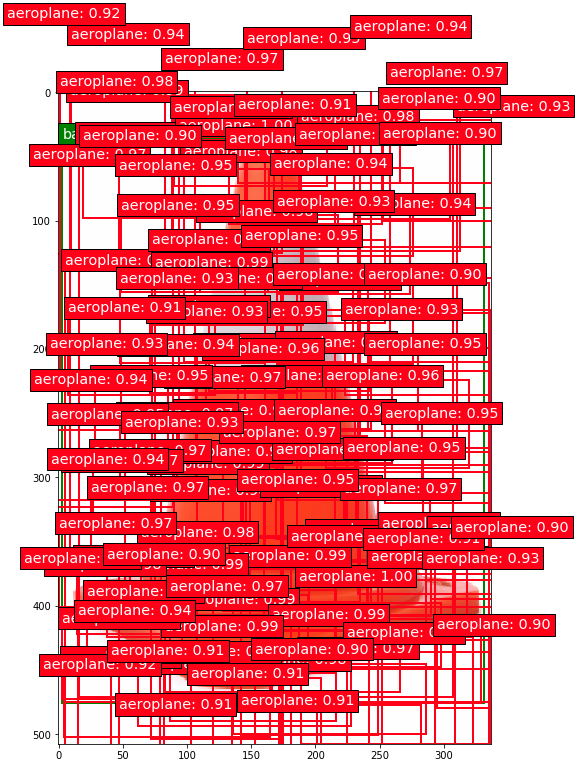

In [27]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})